In [1]:
import pandas as pd
import os
import pydot
import logging
import glob
import re
from string import printable
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 500)
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [5]:
from keras.models import  Sequential, Model, model_from_json, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras import backend as K
from keras.preprocessing import sequence
from keras.layers.core import Dense, Dropout, Activation, Lambda,Flatten, Reshape
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers import Input, ELU, LSTM, GRU, Embedding, Convolution2D, MaxPooling2D, BatchNormalization, Convolution1D, MaxPooling1D, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras import optimizers

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.layers import Bidirectional, SimpleRNN
from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger

Using TensorFlow backend.


In [6]:
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import logging
import numpy as np
import dill as dpickle
from annoy import AnnoyIndex
from tqdm import tqdm, tqdm_notebook
from random import random
from nltk.translate.bleu_score import corpus_bleu


def load_text_processor(fname='title_pp.dpkl'):
    """
    Load preprocessors from disk.
    Parameters
    ----------
    fname: str
        file name of ktext.proccessor object
    Returns
    -------
    num_tokens : int
        size of vocabulary loaded into ktext.processor
    pp : ktext.processor
        the processor you are trying to load
    Typical Usage:
    -------------
    num_decoder_tokens, title_pp = load_text_processor(fname='title_pp.dpkl')
    num_encoder_tokens, body_pp = load_text_processor(fname='body_pp.dpkl')
    """
    # Load files from disk
    with open(fname, 'rb') as f:
        pp = dpickle.load(f)

    num_tokens = max(pp.id2token.keys()) + 1
    print(f'Size of vocabulary for {fname}: {num_tokens:,}')
    return num_tokens, pp


def load_decoder_inputs(decoder_np_vecs='train_title_vecs.npy'):
    """
    Load decoder inputs.
    Parameters
    ----------
    decoder_np_vecs : str
        filename of serialized numpy.array of decoder input (issue title)
    Returns
    -------
    decoder_input_data : numpy.array
        The data fed to the decoder as input during training for teacher forcing.
        This is the same as `decoder_np_vecs` except the last position.
    decoder_target_data : numpy.array
        The data that the decoder data is trained to generate (issue title).
        Calculated by sliding `decoder_np_vecs` one position forward.
    """
    vectorized_title = np.load(decoder_np_vecs)
    # For Decoder Input, you don't need the last word as that is only for prediction
    # when we are training using Teacher Forcing.
    decoder_input_data = vectorized_title[:, :-1]

    # Decoder Target Data Is Ahead By 1 Time Step From Decoder Input Data (Teacher Forcing)
    decoder_target_data = vectorized_title[:, 1:]

    print(f'Shape of decoder input: {decoder_input_data.shape}')
    print(f'Shape of decoder target: {decoder_target_data.shape}')
    return decoder_input_data, decoder_target_data


def load_encoder_inputs(encoder_np_vecs='train_body_vecs.npy'):
    """
    Load variables & data that are inputs to encoder.
    Parameters
    ----------
    encoder_np_vecs : str
        filename of serialized numpy.array of encoder input (issue title)
    Returns
    -------
    encoder_input_data : numpy.array
        The issue body
    doc_length : int
        The standard document length of the input for the encoder after padding
        the shape of this array will be (num_examples, doc_length)
    """
    vectorized_body = np.load(encoder_np_vecs)
    # Encoder input is simply the body of the issue text
    encoder_input_data = vectorized_body
    doc_length = encoder_input_data.shape[1]
    print(f'Shape of encoder input: {encoder_input_data.shape}')
    return encoder_input_data, doc_length


def viz_model_architecture(model):
    """Visualize model architecture in Jupyter notebook."""
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))


def free_gpu_mem():
    """Attempt to free gpu memory."""
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))


def test_gpu():
    """Run a toy computation task in tensorflow to test GPU."""
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    hello = tf.constant('Hello, TensorFlow!')
    print(session.run(hello))


def plot_model_training_history(history_object):
    """Plots model train vs. validation loss."""
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def extract_encoder_model(model):
    """
    Extract the encoder from the original Sequence to Sequence Model.
    Returns a keras model object that has one input (body of issue) and one
    output (encoding of issue, which is the last hidden state).
    Input:
    -----
    model: keras model object
    Returns:
    -----
    keras model object
    """
    encoder_model = model.get_layer('Encoder-Model')
    return encoder_model


def extract_decoder_model(model):
    """
    Extract the decoder from the original model.
    Inputs:
    ------
    model: keras model object
    Returns:
    -------
    A Keras model object with the following inputs and outputs:
    Inputs of Keras Model That Is Returned:
    1: the embedding index for the last predicted word or the <Start> indicator
    2: the last hidden state, or in the case of the first word the hidden state from the encoder
    Outputs of Keras Model That Is Returned:
    1.  Prediction (class probabilities) for the next word
    2.  The hidden state of the decoder, to be fed back into the decoder at the next time step
    Implementation Notes:
    ----------------------
    Must extract relevant layers and reconstruct part of the computation graph
    to allow for different inputs as we are not going to use teacher forcing at
    inference time.
    """
    # the latent dimension is the same throughout the architecture so we are going to
    # cheat and grab the latent dimension of the embedding because that is the same as what is
    # output from the decoder
    latent_dim = model.get_layer('Decoder-Word-Embedding').output_shape[-1]

    # Reconstruct the input into the decoder
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Word-Embedding')(decoder_inputs)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb)

    # Instead of setting the intial state from the encoder and forgetting about it, during inference
    # we are not doing teacher forcing, so we will have to have a feedback loop from predictions back into
    # the GRU, thus we define this input layer for the state so we can add this capability
    gru_inference_state_input = Input(shape=(latent_dim,), name='hidden_state_input')

    # we need to reuse the weights that is why we are getting this
    # If you inspect the decoder GRU that we created for training, it will take as input
    # 2 tensors -> (1) is the embedding layer output for the teacher forcing
    #                  (which will now be the last step's prediction, and will be _start_ on the first time step)
    #              (2) is the state, which we will initialize with the encoder on the first time step, but then
    #                   grab the state after the first prediction and feed that back in again.
    gru_out, gru_state_out = model.get_layer('Decoder-GRU')([dec_bn, gru_inference_state_input])

    # Reconstruct dense layers
    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(gru_out)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input],
                          [dense_out, gru_state_out])
    return decoder_model


class Seq2Seq_Inference(object):
    def __init__(self,
                 encoder_preprocessor,
                 decoder_preprocessor,
                 seq2seq_model):

        self.pp_body = encoder_preprocessor
        self.pp_title = decoder_preprocessor
        self.seq2seq_model = seq2seq_model
        self.encoder_model = extract_encoder_model(seq2seq_model)
        self.decoder_model = extract_decoder_model(seq2seq_model)
        self.default_max_len_title = self.pp_title.padding_maxlen
        self.nn = None
        self.rec_df = None

    def generate_issue_title(self,
                             raw_input_text,
                             max_len_title=None):
        """
        Use the seq2seq model to generate a title given the body of an issue.
        Inputs
        ------
        raw_input: str
            The body of the issue text as an input string
        max_len_title: int (optional)
            The maximum length of the title the model will generate
        """
        if max_len_title is None:
            max_len_title = self.default_max_len_title
        # get the encoder's features for the decoder
        raw_tokenized = self.pp_body.transform([raw_input_text])
        body_encoding = self.encoder_model.predict(raw_tokenized)
        # we want to save the encoder's embedding before its updated by decoder
        #   because we can use that as an embedding for other tasks.
        original_body_encoding = body_encoding
        state_value = np.array(self.pp_title.token2id['_start_']).reshape(1, 1)

        decoded_sentence = []
        stop_condition = False
        while not stop_condition:
            preds, st = self.decoder_model.predict([state_value, body_encoding])

            # We are going to ignore indices 0 (padding) and indices 1 (unknown)
            # Argmax will return the integer index corresponding to the
            #  prediction + 2 b/c we chopped off first two
            pred_idx = np.argmax(preds[:, :, 2:]) + 2

            # retrieve word from index prediction
            pred_word_str = self.pp_title.id2token[pred_idx]

            if pred_word_str == '_end_' or len(decoded_sentence) >= max_len_title:
                stop_condition = True
                break
            decoded_sentence.append(pred_word_str)

            # update the decoder for the next word
            body_encoding = st
            state_value = np.array(pred_idx).reshape(1, 1)

        return original_body_encoding, ' '.join(decoded_sentence)


    def print_example(self,
                      i,
                      body_text,
                      title_text,
                      threshold):
        """
        Prints an example of the model's prediction for manual inspection.
        """
        if i:
            print('\n\n==============================================')
            print(f'============== Example # {i} =================\n')

        print(f"Issue Body:\n {body_text} \n")

        if title_text:
            print(f"Original Title:\n {title_text}")

        emb, gen_title = self.generate_issue_title(body_text)
        print(f"\n****** Machine Generated Title (Prediction) ******:\n {gen_title}")

        if self.nn:
            # return neighbors and distances
            n, d = self.nn.get_nns_by_vector(emb.flatten(), n=4,
                                             include_distances=True)
            neighbors = n[1:]
            dist = d[1:]

            if min(dist) <= threshold:
                cols = ['title', 'body']
                dfcopy = self.rec_df.iloc[neighbors][cols].copy(deep=True)
                dfcopy['dist'] = dist
                similar_issues_df = dfcopy.query(f'dist <= {threshold}')

                print("\n**** Similar Issues (using encoder embedding) ****:\n")
                display(similar_issues_df)
                
        return gen_title


    def demo_model_predictions(self,
                               n,
                               issue_df,
                               threshold=1):
        """
        Pick n random Issues and display predictions.
        Input:
        ------
        n : int
            Number of issues to display from issue_df
        issue_df : pandas DataFrame
            DataFrame that contains two columns: `body` and `issue_title`.
        threshold : float
            distance threshold for recommendation of similar issues.
        Returns:
        --------
        None
            Prints the original issue body and the model's prediction.
        """
        # Extract body and title from DF
        body_text = issue_df.body.tolist()
        title_text = issue_df.title.tolist()

        col_names =  ['body', 'actual_title', 'generated_title']
        resultDF  = pd.DataFrame(columns = col_names)
        
        #demo_list = np.random.randint(low=1, high=len(body_text), size=n)
        demo_list = list(range(1,n+1))
        for i in demo_list:
          
            tmp_title = self.print_example(i,
                               body_text=body_text[i],
                               title_text=title_text[i],
                               threshold=threshold)
            tmpDF = pd.DataFrame({"body": [body_text[i]], 
                                  "actual_title": [title_text[i]], 
                                  "generated_title": [tmp_title]})
            resultDF = pd.concat([resultDF, tmpDF], ignore_index=True)

        resultDF.to_csv('resultDF.csv', encoding='latin-1')

            

    def prepare_recommender(self, vectorized_array, original_df):
        """
        Use the annoy library to build recommender
        Parameters
        ----------
        vectorized_array : List[List[int]]
            This is the list of list of integers that represents your corpus
            that is fed into the seq2seq model for training.
        original_df : pandas.DataFrame
            This is the original dataframe that has the columns
            ['issue_url', 'issue_title', 'body']
        Returns
        -------
        annoy.AnnoyIndex  object (see https://github.com/spotify/annoy)
        """
        self.rec_df = original_df
        emb = self.encoder_model.predict(x=vectorized_array,
                                         batch_size=vectorized_array.shape[0]//200)

        f = emb.shape[1]
        self.nn = AnnoyIndex(f)
        logging.warning('Adding embeddings')
        for i in tqdm(range(len(emb))):
            self.nn.add_item(i, emb[i])
        logging.warning('Building trees for similarity lookup.')
        self.nn.build(50)
        return self.nn

    def set_recsys_data(self, original_df):
        self.rec_df = original_df

    def set_recsys_annoyobj(self, annoyobj):
        self.nn = annoyobj

    def evaluate_model(self, holdout_bodies, holdout_titles):
        """
        Method for calculating BLEU Score.
        Parameters
        ----------
        holdout_bodies : List[str]
            These are the issue bodies that we want to summarize
        holdout_titles : List[str]
            This is the ground truth we are trying to predict --> issue titles
        Returns
        -------
        bleu : float
            The BLEU Score
        """
        actual, predicted = list(), list()
        assert len(holdout_bodies) == len(holdout_titles)
        num_examples = len(holdout_bodies)

        logging.warning('Generating predictions.')
        # step over the whole set TODO: parallelize this
        for i in tqdm_notebook(range(num_examples)):
            _, yhat = self.generate_issue_title(holdout_bodies[i])

            actual.append(self.pp_title.process_text([holdout_titles[i]])[0])
            predicted.append(self.pp_title.process_text([yhat])[0])
        # calculate BLEU score
        logging.warning('Calculating BLEU.')
        
        #must be careful with nltk api for corpus_bleu!, 
        # expects List[List[List[str]]] for ground truth, using List[List[str]] will give you
        # erroneous results.
        bleu = corpus_bleu([[a] for a in actual], predicted)
        return bleu

In [7]:
news = pd.read_csv("articles10k_input.csv", encoding='latin-1')
#news.dropna(inplace=True)
#news.reset_index(drop=True, inplace=True)
print(list(news))
print(news.shape)


['title', 'body']
(10000, 2)


In [8]:
print(news["title"][0])
print(news["body"][0])

House Republicans Fret About Winning Their Health Care Suit - The New York Times
WASHINGTON  Ã¢ÂÂ   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administrationÃ¢ÂÂs authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to 

In [9]:
tmp_traindf, testdf = train_test_split(news, test_size=.10)

traindf = pd.concat([tmp_traindf, tmp_traindf, tmp_traindf, tmp_traindf], 
                      ignore_index=True)

#print out stats about shape of data
print(traindf.shape)
print(testdf.shape)

(36000, 2)
(1000, 2)


In [10]:
train_body_raw = traindf['body'].tolist()
train_title_raw = traindf['title'].tolist()
#preview output of first element
train_body_raw[0]

'(Want to get this briefing by email? HereÃ¢Â\x80Â\x99s the  .) Good evening. HereÃ¢Â\x80Â\x99s the latest. 1. President Donald Trump got into Twitter spats with the Iranian government, the University of California, Berkeley and Arnold Schwarzenegger. The issues ranged from missile tests to free speech to TV ratings. Speaking to a gathering of religious leaders in Washington, Mr. Trump brushed aside criticism and pledged to Ã¢Â\x80Â\x9cdestroyÃ¢Â\x80Â\x9d a law restricting political speech by   churches, a potentially huge victory for the religious right. Late Thursday, he unexpectedly shifted his stance on Israel, warning Prime Minister Benjamin Netanyahu to hold off on settlement construction. _____ 2. Defense Secretary Jim Mattis visited South Korea, his first stop on an Asia trip meant to reassure U. S. allies. But his visit was overshadowed by news of Mr. TrumpÃ¢Â\x80Â\x99s testy phone call with the leader of Australia over the weekend. He clashed with Prime Minister Malcolm Turnb

In [11]:
%reload_ext autoreload
%autoreload 2
from ktext.preprocess import processor

In [12]:
%%time
# Clean, tokenize, and apply padding / truncating such that each document length = 70
# also, retain only the top 8,000 words in the vocabulary and set the remaining words
# to 1 which will become common index for rare words 
body_pp = processor(keep_n=8000, padding_maxlen=70)
train_body_vecs = body_pp.fit_transform(train_body_raw)

Wall time: 9min 57s


In [13]:
print(train_body_raw[0])
print(train_body_vecs[0])

(Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. President Donald Trump got into Twitter spats with the Iranian government, the University of California, Berkeley and Arnold Schwarzenegger. The issues ranged from missile tests to free speech to TV ratings. Speaking to a gathering of religious leaders in Washington, Mr. Trump brushed aside criticism and pledged to Ã¢ÂÂdestroyÃ¢ÂÂ a law restricting political speech by   churches, a potentially huge victory for the religious right. Late Thursday, he unexpectedly shifted his stance on Israel, warning Prime Minister Benjamin Netanyahu to hold off on settlement construction. _____ 2. Defense Secretary Jim Mattis visited South Korea, his first stop on an Asia trip meant to reassure U. S. allies. But his visit was overshadowed by news of Mr. TrumpÃ¢ÂÂs testy phone call with the leader of Australia over the weekend. He clashed with Prime Minister Malcolm Turnbull over an agreement to take i

In [14]:
# Instantiate a text processor for the titles, with some different parameters
#  append_indicators = True appends the tokens '_start_' and '_end_' to each
#                      document
#  padding = 'post' means that zero padding is appended to the end of the 
#             of the document (as opposed to the default which is 'pre')
title_pp = processor(append_indicators=True, keep_n=4500, 
                     padding_maxlen=17, padding ='post')

# process the title data
train_title_vecs = title_pp.fit_transform(train_title_raw)

In [15]:
print(train_title_raw[0])
print(train_title_vecs[0])

New England Patriots, Lady Gaga: Your Thursday Evening Briefing - The New York Times
[   2    5 1283  918  863 1715   26  300   52   36    4    5    6    7
    3    0    0]


In [16]:
#### Serialize all of this to disk for later use

import dill as dpickle
import numpy as np

# Save the preprocessor
with open('body_pp.dpkl', 'wb') as f:
    dpickle.dump(body_pp, f)

with open('title_pp.dpkl', 'wb') as f:
    dpickle.dump(title_pp, f)

# Save the processed data
np.save('train_title_vecs.npy', train_title_vecs)
np.save('train_body_vecs.npy', train_body_vecs)

# Define Model Architecture

### Load the data from disk into variables

In [17]:
encoder_input_data, doc_length = load_encoder_inputs('train_body_vecs.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs('train_title_vecs.npy')

Shape of encoder input: (36000, 70)
Shape of decoder input: (36000, 16)
Shape of decoder target: (36000, 16)


In [18]:
num_encoder_tokens, body_pp = load_text_processor('body_pp.dpkl')
num_decoder_tokens, title_pp = load_text_processor('title_pp.dpkl')

Size of vocabulary for body_pp.dpkl: 8,002
Size of vocabulary for title_pp.dpkl: 4,502


### Define the model architecture

In [19]:
#arbitrarly set latent dimension for embedding and hidden units
latent_dim = 600

##### Define Model Architecture ######

########################
#### Encoder Model ####
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input')

# Word embeding for encoder (ex: Issue Body)
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# Intermediate GRU layer (optional)
#x = GRU(latent_dim, name='Encoder-Intermediate-GRU', return_sequences=True)(x)
#x = BatchNormalization(name='Encoder-Batchnorm-2')(x)

# We do not need the `encoder_output` just the hidden state.
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)

# Encapsulate the encoder as a separate entity so we can just 
#  encode without decoding if we want to.
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

########################
#### Decoder Model ####
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Word Embedding For Decoder (ex: Issue Titles)
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU')
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

########################
#### Seq2Seq Model ####

#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')


In [27]:
seq2seq_Model.summary()
#viz_model_architecture(seq2seq_Model) #Did not work

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 600)    2701200     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 70)           0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 600)    2400        Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Mo

### Train the model

In [28]:
script_name_base = 'tutorial_seq2seq'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                  save_best_only=True)

batch_size = 1200
epochs = 20
history = seq2seq_Model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint])

Train on 31680 samples, validate on 4320 samples
Epoch 1/20
31680/31680 [==============================] - ETA: 14:28 - loss: 0.02 - ETA: 14:04 - loss: 0.01 - ETA: 13:17 - loss: 0.01 - ETA: 12:23 - loss: 0.01 - ETA: 11:33 - loss: 0.01 - ETA: 10:51 - loss: 0.01 - ETA: 10:13 - loss: 0.01 - ETA: 9:38 - loss: 0.0182 - ETA: 9:01 - loss: 0.018 - ETA: 8:33 - loss: 0.018 - ETA: 8:04 - loss: 0.018 - ETA: 7:34 - loss: 0.018 - ETA: 7:03 - loss: 0.018 - ETA: 6:31 - loss: 0.018 - ETA: 5:59 - loss: 0.019 - ETA: 5:27 - loss: 0.019 - ETA: 4:55 - loss: 0.019 - ETA: 4:23 - loss: 0.019 - ETA: 3:52 - loss: 0.018 - ETA: 3:21 - loss: 0.019 - ETA: 2:49 - loss: 0.019 - ETA: 2:18 - loss: 0.019 - ETA: 1:47 - loss: 0.019 - ETA: 1:16 - loss: 0.019 - ETA: 44s - loss: 0.019 - ETA: 12s - loss: 0.02 - 876s 28ms/step - loss: 0.0202 - val_loss: 0.0290
Epoch 2/20
31680/31680 [==============================] - ETA: 13:17 - loss: 0.02 - ETA: 12:58 - loss: 0.02 - ETA: 12:15 - loss: 0.02 - ETA: 11:42 - loss: 0.02 - ETA: 11:

31680/31680 [==============================] - ETA: 12:20 - loss: 0.00 - ETA: 12:02 - loss: 0.01 - ETA: 11:42 - loss: 0.01 - ETA: 11:20 - loss: 0.01 - ETA: 10:45 - loss: 0.01 - ETA: 10:15 - loss: 0.01 - ETA: 9:44 - loss: 0.0111 - ETA: 9:13 - loss: 0.010 - ETA: 8:46 - loss: 0.010 - ETA: 8:17 - loss: 0.010 - ETA: 7:47 - loss: 0.010 - ETA: 7:16 - loss: 0.010 - ETA: 6:45 - loss: 0.010 - ETA: 6:17 - loss: 0.010 - ETA: 5:47 - loss: 0.010 - ETA: 5:16 - loss: 0.010 - ETA: 4:45 - loss: 0.010 - ETA: 4:14 - loss: 0.010 - ETA: 3:44 - loss: 0.010 - ETA: 3:14 - loss: 0.010 - ETA: 2:44 - loss: 0.010 - ETA: 2:13 - loss: 0.010 - ETA: 1:43 - loss: 0.010 - ETA: 1:13 - loss: 0.010 - ETA: 42s - loss: 0.010 - ETA: 12s - loss: 0.01 - 845s 27ms/step - loss: 0.0106 - val_loss: 0.0131
Epoch 12/20
31680/31680 [==============================] - ETA: 12:59 - loss: 0.01 - ETA: 12:27 - loss: 0.00 - ETA: 11:49 - loss: 0.01 - ETA: 11:17 - loss: 0.01 - ETA: 10:48 - loss: 0.00 - ETA: 10:20 - loss: 0.00 - ETA: 9:54 - los

In [29]:
#save model
seq2seq_Model.save('seq2seq_model_tutorial.h5')

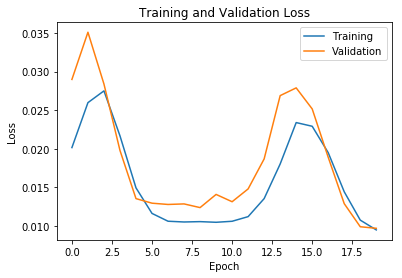

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# See Results On Holdout Set

In [31]:
seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=body_pp,
                                 decoder_preprocessor=title_pp,
                                 seq2seq_model=seq2seq_Model)

In [32]:
# this method displays the predictions on random rows of the holdout set
seq2seq_inf.demo_model_predictions(n=len(testdf), issue_df=testdf)



============== Example # 1 =================

Issue Body:
 On Tuesday afternoon, President Barack ObamaÃ¢ÂÂs former National Security Advisor Susan Rice appeared on MSNBC with host Andrea Mitchell to answer questions about allegations that had emerged earlier in the week to suggest that she requested the Ã¢ÂÂunmaskingÃ¢ÂÂ of the names of Donald TrumpÃ¢ÂÂs campaign and transition teams in intelligence reports, which allegedly had nothing to do with national security, and that she had compiled spreadsheets of those names. [Here are the highlights of MitchellÃ¢ÂÂs interview with Rice, which took up the first   of MitchellÃ¢ÂÂs show.  Joel B. Pollak is Senior    at Breitbart News. He was named one of the Ã¢ÂÂmost influentialÃ¢ÂÂ people in news media in 2016. His new book, How Trump Won: The Inside Story of a Revolution, is available from Regnery. Follow him on Twitter at @joelpollak. 

Original Title:
 11 Highlights of Susan RiceÃ¢ÂÂs MSNBC Interview with Andrea Mitchel


Original Title:
 Ã¢ÂÂPresident Hillary Clinton?Ã¢ÂÂ She Wants Progress on Immigration and to Drink With G.O.P. - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump s art show with pro life policies are too the new york times


============== Example # 5 =================

Issue Body:
 Executives at 21st Century Fox decided to end the tenure of Roger Ailes after lawyers they hired to investigate an allegation of sexual harassment against him took statements from at least six other women who described inappropriate behavior from Mr. Ailes, two people briefed on the inquiry said Wednesday. One of the people said that the details of the allegations, while unverified, were troubling enough that they left 21st Century Fox little choice but to force an end to Mr. AilesÃ¢ÂÂs reign as chairman and chief executive of Fox News, given the potential liability they presented to the company both legally and in terms of its own corporate culture. The people with know


Original Title:
 5 Stand-Up Specials to Stream This Week - The New York Times

****** Machine Generated Title (Prediction) ******:
 how to do you need a miracle on new york times


============== Example # 7 =================

Issue Body:
 Thursday at the White House press briefing, press secretary Sean Spicer rebuked New York Times reporter Glenn Thrush for yelling out a question.  When Thrush tried to shout out a question Spicer said, Ã¢ÂÂGlenn, this isnÃ¢ÂÂt a TV program   Ã¢ÂÂ¦     OK? You donÃ¢ÂÂt get to just yell out questions. WeÃ¢ÂÂre going to raise our hands like big boys and girls. Because itÃ¢ÂÂs not your job to just yell out questions. Ã¢ÂÂ Follow Pam Key on Twitter @pamkeyNEN 

Original Title:
 Spicer to Reporter: Ã¢ÂÂWeÃ¢ÂÂre Going to Raise Our Hands Like Big Boys and GirlsÃ¢ÂÂ - Breitbart

****** Machine Generated Title (Prediction) ******:
 how to a view at museum the new york times


============== Example # 8 =================

Issue Body:
 While A


Original Title:
 Publishers Encounter Political Storms in Turn to Right - The New York Times

****** Machine Generated Title (Prediction) ******:
 going from bond girl to the making a philippine president the new york times


============== Example # 11 =================

Issue Body:
 TROON, Scotland  Ã¢ÂÂ   Phil Mickelson had turned back the clock for a fourth consecutive day. He had made a birdie on the opening hole of SundayÃ¢ÂÂs final round at the 2016 British Open and never looked back. His game was as sharp as it had ever been on the final day of a major championship. Winless for the past three years, the    Mickelson was tied for the tournament lead, just five holes and perhaps one last surge from becoming the oldest British Open champion in 149 years. And yet Mickelson felt as if nothing he was doing was enough to win. Or might ever be enough on this day. Three birdies, an eagle and no bogeys in his first 13 holes? MickelsonÃ¢ÂÂs playing partner, Henrik Stenson, had not 


Original Title:
 TrumpÃ¢ÂÂs Executive Order on Immigration: What We Know and What We DonÃ¢ÂÂt - The New York Times

****** Machine Generated Title (Prediction) ******:
 the trump administration may have been run in a lot of political landscape the new york times


============== Example # 14 =================

Issue Body:
 Ending a sexual abuse case in which Pope Francis intervened three years ago, a Spanish court on Tuesday cleared a parish priest in Granada who had been accused of molesting an altar boy. The court found no evidence that the Rev. RomÃÂ¡n MartÃÂ­nez had sexually abused one of his former altar boys more than a decade ago. An investigation began after David RamÃÂ­rez Castillo wrote to Pope Francis in 2014, detailing the sexual abuse that he said he and others suffered repeatedly when they were teenagers at the hands of a group of priests led by Father MartÃÂ­nez. Pope Francis phoned Mr. RamÃÂ­rez Castillo and urged him to pursue his complaints. The pope also or


Original Title:
 Trump Reversals Hint at Wall Street WingÃ¢ÂÂs Sway in White House - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s presidential race syria your wednesday evening briefing the new york times


============== Example # 17 =================

Issue Body:
 Les voix des femmes musulmanes ont ÃÂ©tÃÂ© quasiment noyÃÂ©es par le dÃÂ©bat agitÃÂ© sur lÃ¢ÂÂinterdiction de se baigner en burkini sur les plages de plus de 30 municipalitÃÂ©s franÃÂ§aises femmes pour qui ces maillots couvrant complÃÂ¨tement le corps ont ÃÂ©tÃÂ© conÃÂ§us. Le New York Times a sollicitÃÂ© leurs avis, et les rÃÂ©ponses  Ã¢ÂÂ   plus de 1000 messages de Belgique, de France et dÃ¢ÂÂailleurs  Ã¢ÂÂ   vont bien   de la question des tenues de plage. Le rÃÂ©sultat brosse le portrait de la vie de la femme musulmane, voilÃÂ©e ou pas, dans les parties dÃ¢ÂÂEurope oÃÂ¹ le terrorisme a le plus tendu les sociÃÂ©tÃÂ©s. Le mot Ã¢ÂÂcombatÃ¢ÂÂ a ÃÂ©tÃÂ© utili


Original Title:
 How the Fight for a National African-American Museum Was Won - The New York Times

****** Machine Generated Title (Prediction) ******:
 a woman family s death threats to violence the new york times


============== Example # 19 =================

Issue Body:
 Taxpayers will file for $20 billion in tax credits for college expenses they paid in 2015, but while those who get them will no doubt be happy, new evidence shows they have no effect on encouraging people to attend college. The federal government provides over $30 billion annually in tax benefits for college. In addition to the two tax credits  Ã¢ÂÂ   the American Opportunity Tax Credit and the Lifetime Learning Credit  Ã¢ÂÂ   benefits include a deduction for interest paid on student loans, a recently defunct deduction for tuition expenses, and the 529 and Coverdell   savings accounts. That is a lot of money. ItÃ¢ÂÂs about half of what the federal government spends on elementary and secondary education and 


Original Title:
 Antidoping Officials Are Expected to Ask That Russia Be Barred From Rio Olympics - The New York Times

****** Machine Generated Title (Prediction) ******:
 how apple and american working class the new york times


============== Example # 21 =================

Issue Body:
 Citing public safety concerns, federal officials plan to close access to a campsite where demonstrators have protested the construction of a crude oil pipeline near the Standing Rock Sioux Reservation in North Dakota and create a Ã¢ÂÂfree speech zone. Ã¢ÂÂ The Army Corps of Engineers, in a letter Friday to the chairman of the Standing Rock Sioux Tribe, Dave Archambault II, said the decision had been made to Ã¢ÂÂprotect the general public from the violent confrontations between protesters and law enforcement officials that have occurred in this area. Ã¢ÂÂ Mr. Archambault said in a statement that the tribe was Ã¢ÂÂdeeply disappointedÃ¢ÂÂ by the decision. Ã¢ÂÂIt is both unfortunate and di


Original Title:
 Carrie Fisher, Trump, Israel: Your Wednesday Evening Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 susan rice ex adviser is back in political cross hairs over surveillance the new york times


============== Example # 23 =================

Issue Body:
 More than a quarter of a million Somali refugees got a huge break on Thursday. A Kenyan judge ruled that the Kenyan governmentÃ¢ÂÂs contentious plan to close Dadaab, the worldÃ¢ÂÂs largest refugee camp, was Ã¢ÂÂillegalÃ¢ÂÂ and Ã¢ÂÂdiscriminatory,Ã¢ÂÂ and that the refugees could not be forcefully relocated. For years, Kenya has threatened to shut the sprawling camp, a crowded, sweltering realm near KenyaÃ¢ÂÂs border with Somalia that has been a refuge for desperate people since Somalis began fleeing to Kenya in 1991, when their country was plunged into civil war. The government has said the camp is a breeding ground for Islamist terrorists, though the evidence is mixed 


Original Title:
 Hampshire College Draws Protests Over Removal of U.S. Flag - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump fires warning shots at iranian boats the new york times


============== Example # 26 =================

Issue Body:
 TEHRAN  Ã¢ÂÂ   The first news report, to a nation usually kept in the dark about military matters, was shocking: 13 Iranian soldiers, all with links to the Islamic Revolutionary Guards Corps, had been killed in an ambush near the Syrian city of Aleppo. What followed this spring may have been even more surprising. Details about the soldiers appeared extensively in the Iranian news media, which not only gave the names of the dead but lionized them with sweeping life stories.   portraits were plastered all over their hometowns. For years, Iran covered up its military activities in Syria and Iraq, so the government could deny any official involvement on the ground. Coffins arrived with the bodies of soldiers w


Original Title:
 Marvel Artist Fired for Hiding Anti-Semitic Messages in X-Men Comic - Breitbart

****** Machine Generated Title (Prediction) ******:
 the playlist taylor swift and the government and insurance companies the new york times


============== Example # 28 =================

Issue Body:
 Orthodox Jews in black coats and skullcaps danced with Arabs in flowing robes and checkered kaffiyehs at a Hanukkah celebration over the weekend in Bahrain, a   monarchy whose king has sanctioned celebrations of the Jewish holiday. Video of the celebration, which included a Jewish delegation giving a large silver menorah to Arab dignitaries and members of both groups dancing together, appeared on Monday on YouTube, where many commenters lauded the multicultural celebration. The event drew the ire of Hamas, the Palestinian militant group that controls the Gaza Strip, which called the celebration a Ã¢ÂÂhumiliating and disgraceful displayÃ¢ÂÂ in a statement. Ã¢ÂÂThe positive energy that

 drug test long range missile strike and trump the new york times


============== Example # 30 =================

Issue Body:
 125, 000 illegal immigrants have won new or updated work permits and residency permits since January 2017, according to data published by the U. S. Citizenship and Immigration Services (USCIS). [Officials at the agency accepted new requests from 17, 275 illegals from January 1 to March 31 and approved   extensions for 107, 524 of the illegals who earlier got work permits, Social Security cards and federal financial aid via the Ã¢ÂÂDeferred Action for Childhood ArrivalsÃ¢ÂÂ   created by former President Barack Obama in the   to the 2012 election.  President Donald Trump was inaugurated January 2o, ensuring most of the new and renewed DACA work permits were approved during his presidency, despite his campaign promises to halt the DACA program which now includes roughly 765, 000 younger illegal immigrants. TrumpÃ¢ÂÂs supporters should use their political cl


Original Title:
 Donald Trump Could Put Climate Change on Course for Ã¢ÂÂDanger ZoneÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 in donald trump s hard g o p path seeks a good person the new york times


============== Example # 32 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   President Trump put both political parties on notice Monday that he intends to slash spending on many of the federal governmentÃ¢ÂÂs most politically sensitive programs  Ã¢ÂÂ   relating to education, the environment, science and poverty  Ã¢ÂÂ   to protect the economic security of retirees and to shift billions more to the armed forces. The proposal to increase military spending by $54 billion and cut nonmilitary programs by the same amount was unveiled by White House officials as they prepared the presidentÃ¢ÂÂs plans for next yearÃ¢ÂÂs federal budget. Aides to the president said final decisions about Medicare and Social Security would not be made until lat


Original Title:
 Trump to Seek $54 Billion Increase in Military Spending - The New York Times

****** Machine Generated Title (Prediction) ******:
 fmr border chief executive to resign after reform is rejected the new york times


============== Example # 33 =================

Issue Body:
 LOS ANGELES  Ã¢ÂÂ   Show business rule of thumb: Never underestimate a   tot. Going into the weekend, most box office analysts predicted that Ã¢ÂÂBeauty and the BeastÃ¢ÂÂ would easily remain the No. 1 movie in North America. One challenger, Ã¢ÂÂThe Boss Baby,Ã¢ÂÂ had received negative reviews. (The Los Angeles Times deemed it a Ã¢ÂÂrancid diaper. Ã¢ÂÂ) Another new arrival, Ã¢ÂÂGhost in the Shell,Ã¢ÂÂ had been written off as a contender after becoming embroiled in a Ã¢ÂÂwhitewashingÃ¢ÂÂ casting controversy. But Ã¢ÂÂThe Boss BabyÃ¢ÂÂ  Ã¢ÂÂ   in the tradition of Ã¢ÂÂLook WhoÃ¢ÂÂs Talking,Ã¢ÂÂ Stewie from Ã¢ÂÂFamily GuyÃ¢ÂÂ and the   Baby Herman from Ã¢ÂÂWho Frame


Original Title:
 On LebanonÃ¢ÂÂs Once-Sparkling Shores, a Garbage Dump Grows - The New York Times

****** Machine Generated Title (Prediction) ******:
 a reporter recalls one of the white house is not a bad and rap they do a


============== Example # 35 =================

Issue Body:
 ST. ANTHONY, Minn.  Ã¢ÂÂ   A lawyer for the suburban police officer who fatally shot a black man during a traffic stop said on Saturday that the race of the driver, Philando Castile, played no role in how his client responded, and that the officer Ã¢ÂÂwas reacting to the presence of a gunÃ¢ÂÂ when he opened fire. The comments from the lawyer, Thomas Kelly, provided the fullest accounting yet of Officer Jeronimo YanezÃ¢ÂÂs version of the shooting Wednesday night, even as many details remain unclear. Officer Yanez, of the St. Anthony police, is on leave while state authorities investigate the shooting, which has prompted protests and raised questions about what role race might have played in the


Original Title:
 Trump Ends Silence With Palestinians, Opening a Path - The New York Times

****** Machine Generated Title (Prediction) ******:
 hillary clinton super bowl champion tom brady skipping white house visit over family issues breitbart


============== Example # 37 =================

Issue Body:
 Of the 860, 000 Nebraskans who cast ballots in last fallÃ¢ÂÂs election, only two are suspected of casting fraudulent votes. But while the actual number of illegal voters may be minuscule, State Senator John Murante says, there is an even better reason for NebraskaÃ¢ÂÂs Legislature to crack down on fraud at the ballot box. Ã¢ÂÂFirst and foremost, we know the confidence that Americans and Nebraskans have in the election system is at an   low,Ã¢ÂÂ said Mr. Murante, a Republican who is backing a constitutional amendment that would require all voters to display photo IDs. Ã¢ÂÂThe perception exists that voter fraud is a serious issue, and that perception itself has to be addres


Original Title:
 One Rationale for Voter ID Debunked, G.O.P. Has Another - The New York Times

****** Machine Generated Title (Prediction) ******:
 paul ryan s obamacare number bill on capitol hill as house republicans push back breitbart


============== Example # 38 =================

Issue Body:
 ORLANDO, Fla.  Ã¢ÂÂ   With dozens of survivors of the massacre at a gay nightclub here still hospitalized, some of the wounded on Tuesday gave gripping accounts of terror and pain on a night that turned in an instant from joyous to deadly. The survivors told of fleeing, hiding, using their phones to plead for help, watching friends die  Ã¢ÂÂ   and thinking that they would also  Ã¢ÂÂ   as a man with an assault rifle and a handgun went through the Pulse nightclub, firing more shots than they could count. The slaughter early Sunday left 49 victims dead, in addition to the gunman, and 53 wounded  Ã¢ÂÂ   the worst mass shooting in American history. Ã¢ÂÂThe guilt of feeling lucky to be


Original Title:
 Orlando Shooting Survivors Cope With the Trauma of Good Fortune - The New York Times

****** Machine Generated Title (Prediction) ******:
 a democrat with a tightens race for the senate is not going to be easy the new


============== Example # 39 =================

Issue Body:
 PALM BEACH, Fla.  Ã¢ÂÂ   Federal authorities would be empowered to immediately deport vastly more undocumented immigrants as part of a broad crackdown being developed by the Trump administration that would significantly change the way federal agencies enforce immigration laws. Two draft memos signed on Friday by John F. Kelly, the retired Marine general who is now secretary of homeland security, outline an aggressive mission for the immigration authorities that would rescind policies put in place by President Barack Obama that focused mainly on removing serious criminals. The directives appear to spare many younger immigrants brought to the country illegally as children, known as Dreamers. B


Original Title:
 Trump Proposal Would Deport More Immigrants Immediately - The New York Times

****** Machine Generated Title (Prediction) ******:
 police official resigns after critical of trump country s ready to blame the new york times


============== Example # 40 =================

Issue Body:
 TEL AVIV  Ã¢ÂÂ   A new bill to annex the settlements around Jerusalem will be submitted to the Knesset this week, the Jerusalem Post reported. [MK Yehuda Glick (Likud) is advancing the private memberÃ¢ÂÂs legislation, which would cover   of the 386, 000 settlers in Judea and Samaria residing in communities including MaÃ¢ÂÂaleh Adumim, Givat ZeÃ¢ÂÂev, Adam, Psagot, MaÃ¢ÂÂaleh Michmash and the Gush Etzion bloc.  A similar bill annexing MaÃ¢ÂÂaleh Adumim has been submitted and is awaiting approval from the Ministerial Committee for Legislation. But according to Glick, annexing MaÃ¢ÂÂaleh Adumim alone is not enough. Applying sovereignty to all the communities around Jerusalem wo


Original Title:
 After Philando CastileÃ¢ÂÂs Killing, Obama Calls Police Shootings Ã¢ÂÂan American IssueÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 tony award winners the new york times


============== Example # 42 =================

Issue Body:
 Someone cut the music, and then from the kitchen came the crash of a utensil drawer being yanked out of a wooden cabinet. Vernon Hubbard stepped over tiles strewed with spatulas, spoons, purple plates and an unopened liter of soda. His eyelids were droopy, witnesses said, and in each hand he carried a steak knife. Ã¢ÂÂNobodyÃ¢ÂÂs getting out of here alive,Ã¢ÂÂ he said from the apartment doorway, according to a witness. Others remembered a more lurid phrase: People, he warned, would be Ã¢ÂÂleaving out in body bags. Ã¢ÂÂ Some partygoers sat   wedged together on a few living room couches. Others untangled themselves from a brawl that had grown out of a dance in the middle of the room. A woman 


Original Title:
 Social Circles Collide on a Dance Floor. Then a Brawl Ends in Death. - The New York Times

****** Machine Generated Title (Prediction) ******:
 rich request to judges me up in a trump ticket the new york times


============== Example # 43 =================

Issue Body:
 On SundayÃ¢ÂÂs broadcast of NBCÃ¢ÂÂs Ã¢ÂÂMeet The Press,Ã¢ÂÂ Sen. Lindsey Graham ( ) said President Donald Trump should Ã¢ÂÂback offÃ¢ÂÂ and stop tweeting or comment about the investigation into Russian interference into the 2016 presidential election.  Partial transcript as follows: GRAHAM: Well, I think we need to have Comey come before the Judiciary Committee and clear the air. Did the president ever say anything to the director of the FBI that would be construed as trying to impede the investigation? The president called me about the firing and he referenced the Comey testimony last week and the judiciary committee about how bad it was. So, thatÃ¢ÂÂs all I know. But I think itÃ¢ÂÂs


Original Title:
 High School Journalists Land a Scoop, and the Principal Resigns - The New York Times

****** Machine Generated Title (Prediction) ******:
 number will honor trump s defense of a republican party breitbart


============== Example # 45 =================

Issue Body:
 For all the years of worry that terrorists would develop more sophisticated methods, ThursdayÃ¢ÂÂs attack in Nice realized a fear that turned out to be far worse: a form of violence so crude that it renders many of our usual defenses useless. The attacker, in ramming a plain white truck through crowds of holiday revelers, killed 84 people and remade an everyday vehicle, a familiar sight on streets around the world, into an object of menace and fear. No group has claimed the attack. The attackerÃ¢ÂÂs motivation remains unknown, as do questions of whether he acted alone. And yet this act, whatever its particulars, represents the culmination of   trends, in which terror tactics become more rudimentary and


Original Title:
 Attack in Nice, France, Represents TerrorismÃ¢ÂÂs New Reality - The New York Times

****** Machine Generated Title (Prediction) ******:
 life in jail cheap labor and a year s eve nightmare the new york times


============== Example # 46 =================

Issue Body:
 GENEVA  Ã¢ÂÂ   Russia and the United States agreed early Saturday on a new plan to reduce violence in the Syrian conflict that, if successful, could lead for the first time to joint military targeting by the two powers against Islamic jihadists in Syria. The agreement was reached after 10 months of failed attempts to halt the fighting and of suspended efforts to reach a political settlement to an increasingly complex conflict that began more than five years ago. The conflict has left nearly half a million people dead, created the largest refugee crisis since World War II and turned Syria into a prime incubator of recruiting for the Islamic State and the Nusra Front, an affiliate of Al Qaeda. Secreta


Original Title:
 Russia and the United States Reach New Agreement on Syria Conflict - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s election seen in bid to breach global banks the new york times


============== Example # 47 =================

Issue Body:
 For much of a year, Gonzalo P. Curiel, then a federal prosecutor in California, lived officially in hiding. He hunkered down for a while on a naval base and in other closely guarded locations under the protection of United States marshals. Even his siblings did not know exactly where he was at times. The reason: In a secretly taped conversation inside a San Diego prison, a man accused of being a gunman for a Mexican drug cartel said that he had received permission from his superiors to have Mr. Curiel assassinated. Ã¢ÂÂIt was kind of scary,Ã¢ÂÂ said Mr. CurielÃ¢ÂÂs brother Raul. Ã¢ÂÂHe had to be protected. He always had one or two bodyguards with him. Ã¢ÂÂ Nearly 20 years later, Gonzalo Curie


Original Title:
 That Judge Attacked by Donald Trump? HeÃ¢ÂÂs Faced a Lot Worse - The New York Times

****** Machine Generated Title (Prediction) ******:
 democrats number key white house staff members not russian hacking to great


============== Example # 48 =================

Issue Body:
 Amid a haze of grief after her sonÃ¢ÂÂs unsolved murder last year, Marcia   faced an endless list of tasks  Ã¢ÂÂ   helping the police gain access to KevinÃ¢ÂÂs phone and email canceling his subscriptions, credit cards and bank accounts and arranging his burial in New Jersey. And then there were the college loans. When Ms.   called about his federal loans, an administrator offered condolences and assured her the balance would be written off. But she got a far different response from a New Jersey state agency that had also lent her son money. Ã¢ÂÂPlease accept our condolences on your loss,Ã¢ÂÂ a letter from that agency, the Higher Education Student Assistance Authority, said. Ã¢ÂÂAfter


Original Title:
 In New Jersey Student Loan Program, Even Death May Not Bring a Reprieve - The New York Times

****** Machine Generated Title (Prediction) ******:
 what it s hires ex christie aide to bolster political operation the new york times


============== Example # 49 =================

Issue Body:
 President TrumpÃ¢ÂÂs administration is ending U. S. funding of the United Nations Population Fund  Ã¢ÂÂ   an agency that human rights activists have linked to the support of population control programs such as ChinaÃ¢ÂÂs coercive abortion Ã¢ÂÂ  policy. Ã¢ÂÂ[The halt to the funding of the United Nations Population Fund  Ã¢ÂÂ   known as UNFPA  Ã¢ÂÂ   comes as Trump is scheduled this week to host Chinese President Xi Jinping at the presidentÃ¢ÂÂs    resort in Florida.  In January, Trump signed an executive order that reinstated the Ã¢ÂÂMexico City Policy,Ã¢ÂÂ which concerns U. S. aid for abortions overseas. The president updated the policy by directing Secretary of


Original Title:
 White House Rejects ComeyÃ¢ÂÂs Assertion That Wiretapping Claim Is False - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump tillerson russia rejecting for paris climate change agreement


============== Example # 51 =================

Issue Body:
 A media lecturer at Stratford College was set upon by a group of Muslim males and sent tumbling into a freezing canal while out jogging in Birmingham for, he believes, Ã¢ÂÂbeing whiteÃ¢ÂÂ on January 15th. [The Stratford Observer reports that Lee Skinner was running along the canal side near Yardley Road, Acocks Green in the middle of the afternoon when one of the   group suddenly struck him full force in the face, knocking him into the icy waters.  The Daily Mirror records how Skinner was Ã¢ÂÂable to identify them as Pakistani as IÃ¢ÂÂve worked in Muslim communities and have a detailed knowledge of Islam and speak Arabic to a certain levelÃ¢ÂÂ. The   lecturer described how the blow s


Original Title:
 Home Runs Are Way, Way Up. So Are the Theories Why. - The New York Times

****** Machine Generated Title (Prediction) ******:
 video armed employee up behind armed suspect s robbery attempt breitbart


============== Example # 54 =================

Issue Body:
 BroadwayÃ¢ÂÂs biggest stars arrived for the 2016 Tony Awards on Sunday night at the Beacon Theater. The red carpet was gusty (Ã¢ÂÂA wind tunnel,Ã¢ÂÂ as the Ã¢ÂÂGirlsÃ¢ÂÂ actor Andrew Rannells described it) but the mood was solemn in the wake of the mass shooting in Orlando, Fla. The most common accessory was a silver ribbon, worn in memory of the victims. 

Original Title:
 Photos: The Arrivals at the 2016 Tony Awards Red Carpet - The New York Times

****** Machine Generated Title (Prediction) ******:
 pakistan shrine bombing kills scores in worst attack in months the new york times


============== Example # 55 =================

Issue Body:
 It is hard to find anyone more passionate about the idea o

============== Example # 56 =================

Issue Body:
 TARTU, Estonia  Ã¢ÂÂ   As Lea Luik waited in a   taxi, her husband, Henno, carried their newborns from the nursery. One, then two, then three. In retellings, the punch line is always the taxi driverÃ¢ÂÂs reaction: Ã¢ÂÂAre you going to empty the whole hospital?Ã¢ÂÂ The sisters Leila, Liina and Lily had been born a month premature. None weighed more than four and a half pounds. For several weeks, home was an intensive care unit. Thirty years later, the sisters are Olympic marathon runners for this tiny Baltic nation  Ã¢ÂÂ   and they are believed to be the first triplets to have qualified for the Winter or Summer Games. The Trio to Rio, the alliterative sisters call themselves as they prepare to run the womenÃ¢ÂÂs marathon in Rio de Janeiro on Aug. 14. Ã¢ÂÂWe had to fight to survive when we were born,Ã¢ÂÂ Lily Luik (pronounced  ) said in a recent interview in this quiet university town with its floating saunas tha


Original Title:
 The Trio to Rio - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s navy seal s widow when she received a standing up at the islamic state the


============== Example # 57 =================

Issue Body:
 Women in hijabs and men in jeans strolled along Fifth Avenue in Bay Ridge, Brooklyn, on Saturday night beneath the signs of stores and restaurants written in Arabic. It would have seemed a typical Saturday night in one of New YorkÃ¢ÂÂs largest   neighborhoods. Except that inside those storefronts and cafes, there was worry, disbelief and emergency meetings, prompted by President TrumpÃ¢ÂÂs executive orders that temporarily banned   and green card holders from seven predominantly Muslim countries. Among those countries was Yemen. At the   Social Center, 20   business and community leaders from across the city met to share information in Arabic and English about friends and relatives detained at airports across the United States. Everyone


Original Title:
 Tony Fadell Steps Down Amid Tumult at Nest, a Google Acquisition - The New York Times

****** Machine Generated Title (Prediction) ******:
 worst attack in years the new york times


============== Example # 59 =================

Issue Body:
 One of the most passionately debated stage works of our time is a    operetta. Is Gilbert and SullivanÃ¢ÂÂs enduringly popular Ã¢ÂÂThe MikadoÃ¢ÂÂ a droll satire of Victorian England? A racist caricature of Japan? Some amalgam of the two? Recent revivals have ended up in the cross hairs of these questions, sparking protests across the nation, along with earnest wondering about how  Ã¢ÂÂ   and even if  Ã¢ÂÂ   this 1885 piece should be staged in the 21st century. When an outcry arose last year over a planned revival of the New York Gilbert and Sullivan PlayersÃ¢ÂÂ old production  Ã¢ÂÂ   which had featured a mostly white cast in yellowface makeup, and employed some ugly stereotypes to evoke the imaginary Japanese town o


Original Title:
 Ã¢ÂÂThe Birth of a NationÃ¢ÂÂ Struggles at the Box Office - The New York Times

****** Machine Generated Title (Prediction) ******:
 sarah number percent of undocumented students financial aid to call for the u s strike and the


============== Example # 61 =================

Issue Body:
 Three pioneers in the development of nanomachines, made of moving molecules, were awarded the Nobel Prize in Chemistry on Wednesday. Molecular machines, the worldÃ¢ÂÂs smallest mechanical devices, may eventually be used to create new materials, sensors and energy storage systems, the Royal Swedish Academy of Sciences said in announcing the prize. Ã¢ÂÂIn terms of development, the molecular motor is at the same stage as the electric motor was in the 1830s, when scientists displayed various spinning cranks and wheels, unaware that they would lead to electric trains, washing machines, fans and food processors,Ã¢ÂÂ the academy said. The three scientists  Ã¢ÂÂ     Sauvage, J. F

 3 Makers of WorldÃ¢ÂÂs Smallest Machines Awarded Nobel Prize in Chemistry - The New York Times

****** Machine Generated Title (Prediction) ******:
 budget s green card offers usd number million to flee the new york times


============== Example # 62 =================

Issue Body:
 Good morning.  HereÃ¢ÂÂs what you need to know: Ã¢ÂÂ¢  RussiaÃ¢ÂÂs ambassador to Turkey was fatally shot while giving a speech in Ankara, an attack a Russian official characterized as a terror attack. The gunman, described by Turkish officials as a      police officer, shouted Ã¢ÂÂdonÃ¢ÂÂt forget Aleppo, donÃ¢ÂÂt forget Syria! ,Ã¢ÂÂ as captured in this video (warning, graphic images). Russia has long backed SyriaÃ¢ÂÂs government in that countryÃ¢ÂÂs brutal civil war. _____ Ã¢ÂÂ¢ Hours earlier, the United Nations passed a resolution to monitor the evacuation of tens of thousands of civilians from the fallen city of Aleppo. Russia signed on only after a compromise that could allow Syrian 


Original Title:
 The Women of Ã¢ÂÂGirlsÃ¢ÂÂ and Protest Whack-a-Mole - The New York Times

****** Machine Generated Title (Prediction) ******:
 statement trump university will brexit vote to go your monday evening briefing the new york times


============== Example # 64 =================

Issue Body:
 After weeks of reports of severe exhaustion and ensuing hospitalization, Kanye West walked into Trump Tower on Tuesday morning. Journalists who caught a glimpse of the musician entering the tightly guarded building in Manhattan took to Twitter to document the strange spectacle. Mr. WestÃ¢ÂÂs appearance occurred shortly before former Gov. Rick Perry of Texas was named as   Donald J. TrumpÃ¢ÂÂs pick to lead the Energy Department  Ã¢ÂÂ   the same agency that Mr. Perry said during the 2012 presidential race that he wanted to abolish. For Mr. Trump, the visit was another   stuffed into a series of more consequential events, including the possibility of a showdown with Republicans i


Original Title:
 J. Geils, Whose BandÃ¢ÂÂs Catchy Pop Hits Colored the 1980s, Dies at 71 - The New York Times

****** Machine Generated Title (Prediction) ******:
 the secret to life for profit in colleges the new york times


============== Example # 66 =================

Issue Body:
 Former New York City Mayor Michael Bloomberg told the New York Times Wednesday that he estimates President Donald Trump has a 55 percent chance at  . [Bloomberg, who has been harshly critical of President Trump, thought Democratic   would make Trump the odds on favorite in 2020.  Ã¢ÂÂTheyÃ¢ÂÂll step on each other and   Donald Trump,Ã¢ÂÂ he told the TimesÃ¢ÂÂs Frank Bruni, adding that there is a Ã¢ÂÂ55 percent chance he gets  . Ã¢ÂÂ Bruni, for his part, was horrified by the estimate. Ã¢ÂÂ  percent? Whether good for my longevity or not, I need a cookie,Ã¢ÂÂ he wrote, comparing the campaign to unseat Trump to BloombergÃ¢ÂÂs   crusades against smoking and junk food. Bloomberg was brutal 

 Chinese New Year: Inside the WorldÃ¢ÂÂs Largest Trek - The New York Times

****** Machine Generated Title (Prediction) ******:
 time with a political protest arrests of violent criminals


============== Example # 68 =================

Issue Body:
 Sunday on CBSÃ¢ÂÂs Ã¢ÂÂFace The Nation,Ã¢ÂÂ while discussing the Republicans the repeal and replacement of the Affordable Care Act dubbed Obamacare, Sen. Bernie Sanders ( ) called it Ã¢ÂÂan absolute disasterÃ¢ÂÂ and Ã¢ÂÂa disgrace. Ã¢ÂÂ  Sanders said, Ã¢ÂÂIt is an absolute disaster. It is a disgrace, and by the way, this really has nothing to do with healthcare. What, but this has everything to do with a massive shift of wealth from working people,   people to the very richest people of this country. It is a $275 billion tax break for the top two percent, millionaires will get about $50, 000 a year in tax breaks while at the same time some five to 10 million people are going to lose their health insurance, premiums are goi


Original Title:
 ExclusiveÃ¢ÂÂRegnery: Why Law Enforcement Will Like Justice Neil Gorsuch - Breitbart

****** Machine Generated Title (Prediction) ******:
 mother lost of number and a legacy uncomfortable canadian tourist the new york times


============== Example # 70 =================

Issue Body:
 WARREN, Mich.  Ã¢ÂÂ   In a   rejection of Donald J. TrumpÃ¢ÂÂs economic policies, Hillary Clinton on Thursday accused him of feigning a connection to the working man, while advocating policies that would Ã¢ÂÂwork for him and his friends, at the expense of everyone else. Ã¢ÂÂ Seeking to chip away at the perception among   white voters that Mr. Trump is the economic populist in the race, Mrs. Clinton said the Republican nominee merely paid Ã¢ÂÂlip serviceÃ¢ÂÂ to being on the side of average Americans. She repeatedly contrasted his personal wealth with her own   upbringing. Ã¢ÂÂThere is a myth out there that heÃ¢ÂÂll stick it to the rich and powerful because, somehow, at h


Original Title:
 In Michigan, Hillary Clinton Calls Donald Trump Enemy of Ã¢ÂÂthe Little GuyÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 the tyranny of other people vacation photos the new york times


============== Example # 71 =================

Issue Body:
 JERUSALEM  Ã¢ÂÂ   In an effort to appeal to Palestinians ahead of hotly contested elections, the party of President Mahmoud Abbas listed one of its main achievements as having Ã¢ÂÂkilled 11, 000 Israelis. Ã¢ÂÂ The party, Fatah, made the incendiary claim on Tuesday in an   post on one of its official Facebook pages. Ã¢ÂÂFor the argumentative   Ã¢ÂÂ¦     the ignorant   Ã¢ÂÂ¦     And for those who do not know history,Ã¢ÂÂ begins the Facebook post, Ã¢ÂÂThe Fatah movement killed 11, 000 Israelis. Ã¢ÂÂ Fatah also claimed to have Ã¢ÂÂoffered 170, 000 martyrs,Ã¢ÂÂ and hundreds of its followers, it said, were in Ã¢ÂÂIsraeli occupation jails. Ã¢ÂÂ By Thursday the post had bee


Original Title:
 Warren Buffett Is Latest Billionaire to Excoriate Donald Trump - The New York Times

****** Machine Generated Title (Prediction) ******:
 f b i steps down in an already human race the new york times


============== Example # 74 =================

Issue Body:
 YouÃ¢ÂÂve heard it many times: You should get a flu shot. The Centers for Disease Control and Prevention recommend that anyone older than six months get one by the end of October, though late is better than never. Yet, an online survey by CityMD, a network of urgent care centers, found that 52 percent of millennials donÃ¢ÂÂt plan on getting the vaccine. Turns out we have one such skeptic on staff. Jonah Engel Bromwich, my Times colleague, is a    who says he never gets a flu shot, making him exactly the kind of person who experts wish they could reach. But he has agreed to offer up his excuses so we can quash them one by one, and we thank him for that. To help, we asked Dr. Joseph Bresee, chief of the epidem


Original Title:
 Hillary Clinton, Seizing on Tax Returns, Says Donald Trump Embodies Ã¢ÂÂRigged SystemÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 presidential race here s what you missed the new york times


============== Example # 76 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   The Justice Department told a federal appeals court on Thursday that it would not seek a rehearing of a decision that shut down President TrumpÃ¢ÂÂs targeted travel ban. Instead, the administration will start from scratch, issuing a new executive order, the department said. Last Thursday, a unanimous   panel of the United States Court of Appeals for the Ninth Circuit, in San Francisco, blocked the key parts of the original executive order, which suspended the nationÃ¢ÂÂs refugee program as well as travel from seven predominantly Muslim countries. The panel said the original ban was unlikely to survive constitutional scrutiny. The Justice Department said that


Original Title:
 Pat McCrory, North Carolina Governor, Concedes After Acrimonious Race - The New York Times

****** Machine Generated Title (Prediction) ******:
 soul searching at clinton foundation in state constitution the new york times


============== Example # 78 =================

Issue Body:
 Leading a   coalition, the Texas attorney general filed a brief with the U. S. Supreme Court on Monday supporting President Donald TrumpÃ¢ÂÂs temporary travel stay. Attorneys general from 14 other states and the governor of Mississippi joined to urge the nationÃ¢ÂÂs highest court to reinstate the executive order. [State officials urge that President Trump was acting within his lawful authority given to him by Congress when national security, foreign affairs, and immigration policy judgments require him to exercise it.  Last month the U. S. Court of Appeals for the Fourth Circuit affirmed a lower district courtÃ¢ÂÂs order blocking the executive action, as reported by Breitbart News. 


Original Title:
 Sticker Shock, and Maybe Nausea, Hamper Sales of Virtual Reality Gear - The New York Times

****** Machine Generated Title (Prediction) ******:
 german finance minister resigns amid fallout from trump visit the new york times


============== Example # 80 =================

Issue Body:
 According to Toys Ã¢ÂÂRÃ¢ÂÂ Us, one of the hottest action figures this holiday season will be the Star Wars Interactech Imperial Stormtrooper, a   plastic fighter that makes punching sounds. But thereÃ¢ÂÂs another fighter action figure  Ã¢ÂÂ   minus the sound effects  Ã¢ÂÂ   thatÃ¢ÂÂs getting the spotlight this month, and its name is Golda Meir. On Dec. 11, when the actress Tovah Feldshuh reprises her Tony   role as Meir in two performances of the play Ã¢ÂÂGoldaÃ¢ÂÂs BalconyÃ¢ÂÂ  Ã¢ÂÂ   part of a benefit for Temple   in New York  Ã¢ÂÂ   guests will take home a   of Meir that stands just under three inches tall. The figurine of the former Israeli prime minister fea


Original Title:
 Terror Through the Eyes of Innocents: The Children in Nice - The New York Times

****** Machine Generated Title (Prediction) ******:
 what it s a generation to be the man s war by drugs the new york times


============== Example # 83 =================

Issue Body:
 Every morning at 5:30, an alarm clock awakens Ahmed Maher from his mattress below a stairwell at his neighborhood police station in Cairo. An officer then escorts him to the toilet and signs a notebook that Maher carries, authorizing his release until 6 that evening. Maher walks a mile to his apartment  Ã¢ÂÂ   Ã¢ÂÂIt is my only exercise,Ã¢ÂÂ he said  Ã¢ÂÂ   in the Third Settlement, a grid of   tenements at the edge of the desert. After breakfast with his wife and two small children, he takes care of chores aimed at rebuilding his life  Ã¢ÂÂ   renewing his driverÃ¢ÂÂs license, reactivating his cellphone he visits friends and family and searches for a job in civil engineering, his occupation befo


Original Title:
 How EgyptÃ¢ÂÂs Activists Became Ã¢ÂÂGeneration JailÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 at fox news for a museum waiting reading thinking feeling the new york times


============== Example # 84 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   The Environmental Protection Agency has concluded that hydraulic fracturing, the oil and gas extraction technique also known as fracking, has contaminated drinking water in some circumstances, according to the final version of a comprehensive study first issued in 2015. The new version is far more worrying than the first, which found Ã¢ÂÂno evidence that fracking systemically contaminates waterÃ¢ÂÂ supplies. In a significant change, that conclusion was deleted from the final study. Ã¢ÂÂE. P. A. scientists chose not to include that sentence. The scientists concluded it could not be quantitatively supported,Ã¢ÂÂ said Thomas A. Burke, the E. P. A. Ã¢ÂÂs science adviser,


Original Title:
 The Editorialists Have Spoken Will Voters Listen? - The New York Times

****** Machine Generated Title (Prediction) ******:
 how you can fix it the new york times


============== Example # 86 =================

Issue Body:
 PHILADELPHIA  Ã¢ÂÂ   The Federal Reserve, mindful of unexpectedly weak job growth last month, has abandoned hope of raising interest rates at its next meeting in June, but Fed officials say they are still thinking seriously about raising rates in July or September. Janet L. Yellen, the FedÃ¢ÂÂs chairwoman, said a few weeks ago that she expected the Fed to raise its benchmark interest rate Ã¢ÂÂin the coming months,Ã¢ÂÂ but she omitted those words from a Monday speech, indicating the reported weakness of job creation in May has caused the Fed to rethink its plans. Still, Ms. Yellen delivered a generally upbeat assessment of economic conditions. While describing the May jobs report as Ã¢ÂÂconcerning,Ã¢ÂÂ she also emphasized that it was ju


Original Title:
 TrumpÃ¢ÂÂs Call with Taiwan: A Diplomatic Gaffe or a New Start? - The New York Times

****** Machine Generated Title (Prediction) ******:
 janet yellen and supports trump to be close to falling under complete the new york times


============== Example # 88 =================

Issue Body:
 The Kansas Supreme Court ruled on Thursday that the stateÃ¢ÂÂs spending on public education was unconstitutionally low, dealing a new blow to Gov. Sam Brownback, who is facing a rebellion from his own Republican Party over his trademark   doctrine. In a unanimous ruling, the court said black, Hispanic and poor students were especially harmed by the lack of funding, pointing to lagging test scores and graduation rates. The justices set a June 30 deadline for lawmakers to pass a new constitutional funding formula, sending them scrambling to find more money to pay for a solution. This is the second time in about a year that KansasÃ¢ÂÂ highest court has ruled against the stateÃ¢ÂÂ


Original Title:
 Celebrities Rage at House Obamacare Repeal: Ã¢ÂÂF*ck All YÃ¢ÂÂallÃ¢ÂÂ

****** Machine Generated Title (Prediction) ******:
 watch gorsuch s confirmation hearings for number tweets and it s not easy the new york times


============== Example # 90 =================

Issue Body:
 WASHINGTON, DC  Ã¢ÂÂ   Political Islam, focused on establishing an unfree society ruled by strict sharia law, is Ã¢ÂÂfundamentally incompatibleÃ¢ÂÂ with the U. S. Constitution and the overall Ã¢ÂÂfoundation of the American way of life,Ã¢ÂÂ declared Ayaan Hirsi Ali, an expert at the Hoover Institution think tank, during a Senate panel hearing. [Meanwhile, Michael Leiter, the former director of the U. S. National Counterterrorism Center, argued that sharia law is compatible with the American Constitution.  Ã¢ÂÂMuslimÃ¢ÂÂs honoring of Sharia is not inherently in tangent with living in constitutional democracies anymore than it would be for Christians or Jews who also seek to ho


Original Title:
 Why a Chemical Banned From Soap Is Still in Your Toothpaste - The New York Times

****** Machine Generated Title (Prediction) ******:
 former dallas hillary clinton donald trump your monday evening briefing the new york times


============== Example # 92 =================

Issue Body:
 Add another mystery to the murky case of the disappearing traffic lanes at the George Washington Bridge: Who is John Doe and why is he putting up such a struggle to shield his identity? A man known only by that alias has hired a lawyer from a prominent Manhattan firm to plead with two federal courts in five days to keep his name out of the impending prosecution of the alleged criminal conspiracy known broadly as Bridgegate. So far, he is winning the fight for anonymity. On Tuesday, an appellate court in Philadelphia blocked the scheduled release of a list of people who prosecutors believe were somehow involved in the scheme to tie up traffic at the New Jersey end of the bridge in Septe


Original Title:
 Victims Seek Mercy for a Wall St. Scion Who Defrauded Them - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump kathy griffin beheading photo makes you wonder about mental health


============== Example # 94 =================

Issue Body:
 The uproar at the University of Notre Dame over Vice President Mike PenceÃ¢ÂÂs upcoming commencement address has escalated, as students are now claiming that his presence on campus will make them feel Ã¢ÂÂunsafe. Ã¢ÂÂ[Seniors Imanne Mondane and Jourdyhn Williams have started a whiteboard message campaign to express their concern over the selection of Mike Pence as the universityÃ¢ÂÂs commencement speaker. Over the past week, Mondane and Williams have taken photographs of students with quotations from Pence that the two seniors feel are Ã¢ÂÂracist, sexist, homophobic, xenophobic. Ã¢ÂÂ  Ã¢ÂÂFor me personally, [Pence] represents the larger Trump administration,Ã¢ÂÂ Senior Immane Mondane told


Original Title:
 Dozens Say Christian Leader Made British Boys Ã¢ÂÂBleed for JesusÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 fire dept sues michigan city after fall edition the new york times


============== Example # 96 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. A second night of protests over a police shooting turned violent in Charlotte, N. C. Gunfire at a demonstration left one man critically injured on life support and prompted law enforcement authorities to fire tear gas on the crowd. The episode that set off the protests was the killing of a black man, Keith Scott. He was the third African American fatally shot by police officers in a week. _____ 2. Secretary of State John Kerry tried to save a Ã¢ÂÂshatteredÃ¢ÂÂ   in Syria, two days after a lethal airstrike destroyed much of an aid convoy destined for Aleppo. He expressed frustration with Russia, 


Original Title:
 Orlando, Disney, Donald Trump: Your Wednesday Evening Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 turkey s prime minister is expected to issue black man s rights office the new york times


============== Example # 98 =================

Issue Body:
 ROME  Ã¢ÂÂ   A statue of a   winged bull from the Northwest Palace in Nimrud, Iraq, that was bulldozed by the Islamic State last year to great outcry has been faithfully recreated using modern technology and put on exhibit at the Colosseum in Rome to spur discussion of the possible reconstruction of   archaeological sites.   reconstructions were also made of two damaged Syrian sites: the archive room of Ebla and a portion of a ceiling from the Temple of Bel in Palmyra, as examples of how conflict can devastate a nationÃ¢ÂÂs fragile heritage. Ã¢ÂÂNimrud was the first place to be destroyed,Ã¢ÂÂ said Frances Pinnock, the   of the Ebla expedition, the most important Italian archa


Original Title:
 Exclusive: Federal Data Can Resolve Vote Fraud Debate, Says Vice Chairman of Donald TrumpÃ¢ÂÂs Election Integrity Commission - Breitbart

****** Machine Generated Title (Prediction) ******:
 you are ready for some football and riot and number spray kills millions the new york times


============== Example # 100 =================

Issue Body:
 On TuesdayÃ¢ÂÂs Breitbart News Daily, former Georgetown Professor Asra Nomani recalled the intolerant reaction of fellow liberal academics after she voted for Donald Trump in the 2016 election. [Nomani went public with her voting decision in a Washington Post  . She explained she was a Ã¢ÂÂ   a Muslim, an immigrant woman Ã¢ÂÂof colorÃ¢ÂÂÃ¢ÂÂ who became a Ã¢ÂÂsilent voter for Donald Trump,Ã¢ÂÂ and she made it clear she was not motivated by bigotry or a desire for Ã¢ÂÂwhite supremacism. Ã¢ÂÂ Her stated reasons for voting for Trump included the damaging effects of Obamacare and concern about the rise of Islamist


Original Title:
 The QuinceaÃÂ±era, a Rite of Passage in Transition - The New York Times

****** Machine Generated Title (Prediction) ******:
 how no answers about a reporter s questions the new york times


============== Example # 102 =================

Issue Body:
 As a hedge fund manager, Goldman Sachs trader and bank chief executive, Steven T. Mnuchin has long been a member of the financial elite. Yet even on Wall Street he was not widely known before Donald J. Trump chose him to be his campaign   last spring. Now, Mr. Mnuchin is on a path to become the first hedge fund manager to head the Treasury. As befitting that   world of finance, Mr. MnuchinÃ¢ÂÂs record shows a willingness to take on risks and a penchant for secrecy that members of both parties expect will be a focus of his Senate confirmation hearing. A case in point is a Delaware company that he owns, Steven T. Mnuchin Inc. whose existence has not been reported outside of official records. Mr. Mnuchin set up the compa


Original Title:
 TrumpÃ¢ÂÂs Treasury Pick Moves in Secretive Hedge Fund Circles - The New York Times

****** Machine Generated Title (Prediction) ******:
 amazon once comes back home once the day of its hard charging constitutional the new york times


============== Example # 103 =================

Issue Body:
 The latest entry in the booming genre of   TV is Ã¢ÂÂThe Son,Ã¢ÂÂ an AMC drama based on the captivating historical novel of the same title, which sounds promising. It stars as its Texan patriarch the very Irish Pierce Brosnan, which does not. Maybe Mr. Brosnan will pull it off. As an actual Texan (now living in New York) IÃ¢ÂÂm rooting for him. But I know that Lone Star TV has a   track record. For every Ã¢ÂÂFriday Night LightsÃ¢ÂÂ there is a Ã¢ÂÂWalker, Texas RangerÃ¢ÂÂ and several   reality shows. As a result, Texans have learned to approach shows set in our state with clear eyes and managed expectations. Here is a survey of Texas TV, arranged in order from t


Original Title:
 It Can Power a Small Nation. But This Wind Farm in China Is Mostly Idle. - The New York Times

****** Machine Generated Title (Prediction) ******:
 london s subway experiment please don t walk up the new york times


============== Example # 105 =================

Issue Body:
 The Tacoma Public School Superintendent is now demanding Ã¢ÂÂsafe zonesÃ¢ÂÂ for migrant students after President Donald TrumpÃ¢ÂÂs immigration executive orders were signed earlier last week. [Superintendent Carla Santorno told parents of the Tacoma School District in a letter, that she would like to see safe zones for students so they can be hidden from federal immigration officials, should authorities show up to any schools looking to deport them.  Ã¢ÂÂOur schools will be a safe zone for immigrant students to learn and thrive,Ã¢ÂÂ Santorno wrote. Ã¢ÂÂThe diversity of our student body, our community and our staff is a strength that benefits all of us and should be celebrated. Our ric


Original Title:
 As Wind Power Lifts WyomingÃ¢ÂÂs Fortunes, Coal Miners Are Left in the Dust - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s presidential race ryan lochte rio de blasio s focus on future breitbart


============== Example # 108 =================

Issue Body:
 North Carolina, whose heartbreaking loss in the N. C. A. A. tournament championship game a year ago provided one of the gameÃ¢ÂÂs indelible moments  Ã¢ÂÂ   the   shot by VillanovaÃ¢ÂÂs Kris Jenkins  Ã¢ÂÂ   avenged that defeat with a win over Gonzaga,   on Monday to claim its sixth national title. The No.   Tar Heels returned many of the players who left the court in Houston devastated a year ago. But at University of Phoenix Stadium, they could finally bask in the confetti that rained down from the rafters. They beat Gonzaga, another No. 1 seed, which was making its first appearance in the Final Four. The Bulldogs ( ) representatives of a small Jesuit school in Spokane, Was


Original Title:
 N.C.A.A. Championship: How North Carolina Won Its Sixth Title - The New York Times

****** Machine Generated Title (Prediction) ******:
 it s a miracle no serious injuries in first time hostile obamacare town halls


============== Example # 109 =================

Issue Body:
 It is difficult to surprise at New York CityÃ¢ÂÂs pride parade  Ã¢ÂÂ   that pulsing kaleidoscope of pink unicorn horns and rainbow undergarments, bejeweled miniature dogs and   revelers who seemed to have misplaced their shoes. But around 1:45 p. m. Sunday, beneath a virtually cloudless sky, something was afoot on Christopher Street. Lights flashed. Officers stirred. Sirens pierced the Cher soundtrack wafting over Greenwich Village. Soon, a van door opened. Ã¢ÂÂHillaryyyyyyyyy!Ã¢ÂÂ someone hollered from the sidewalk. And so began a very   chase along the cityÃ¢ÂÂs foremost corridor of gay rights. For four blocks or so  Ã¢ÂÂ   beginning steps from the Stonewall Inn, the nexus of the m


Original Title:
 The LeftÃ¢ÂÂs Smear Campaign Against Sebastian Gorka Continues - Breitbart

****** Machine Generated Title (Prediction) ******:
 trump emergency france agree to extend talks price of limiting open border migration


============== Example # 111 =================

Issue Body:
 President Obama is so disciplined that his wife has teased that he eats precisely seven lightly salted almonds each night. George W. Bush was an exercise buff, obsessed with staying trim by mountain biking and clearing brush at his ranch in Crawford, Tex. But Donald J. Trump is taking a different approach: A junk food aficionado, he is hoping to become the nationÃ¢ÂÂs fast food president. Ã¢ÂÂA Ã¢ÂÂfish delight,Ã¢ÂÂ sometimes, right?Ã¢ÂÂ Mr. Trump told Anderson Cooper at a CNN    meeting in February, extolling the virtues of McDonaldÃ¢ÂÂs. Ã¢ÂÂThe Big Macs are great. The Quarter Pounder. ItÃ¢ÂÂs great stuff. Ã¢ÂÂ Mr. TrumpÃ¢ÂÂs presidential campaign is improvised, undiscipli


Original Title:
 Donald TrumpÃ¢ÂÂs Diet: HeÃ¢ÂÂll Have Fries With That - The New York Times

****** Machine Generated Title (Prediction) ******:
 idaho town is months after reports of a brutal assault the new york times


============== Example # 112 =================

Issue Body:
 How is it that with seven days left until the election, we are consumed anew by emails, Hillary ClintonÃ¢ÂÂs private server, the F. B. I. and an investigation that was supposed to be closed? In the latest episode of The   we examine the most recent surprise twist in a campaign that never ceases to shock. We break down this development into three parts. First we sift through the essential,   facts of the case with two reporters who have covered the investigation since it emerged, Amy Chozick and Michael S. Schmidt. Second, we examine why the F. B. I. director, James B. Comey, decided to make the new findings public, by talking with Carrie Cordero, a former attorney at the Department of Justice who work


Original Title:
 Gary Johnson Equates Syria Deaths Caused by Assad and West - The New York Times

****** Machine Generated Title (Prediction) ******:
 too many of israel and hillary clinton email use of the term resistance in the new york


============== Example # 114 =================

Issue Body:
 One night six years ago, on a quiet side street in Crown Heights, Brooklyn, I came across a photo album that had been put out with the trash. I lived around the corner, and I was walking home when I saw it sitting beneath a streetlamp on Lincoln Place. It looked handmade, with a wooden cover bound with a shoelace. But it had been tied up with twine, like a bunch of old newspapers, and left atop a pile of recycling. After hesitating a moment, I picked it up and took it home. The pages were fragile, and they cracked when I turned them, as if the album hadnÃ¢ÂÂt been opened in a long time, but the photos were perfectly preserved. They seemed to chronicle the life of a black couple at midce


Original Title:
 Love and Black Lives, in Pictures Found on a Brooklyn Street - The New York Times

****** Machine Generated Title (Prediction) ******:
 in brazil s amazon european parliament will return the new york times


============== Example # 115 =================

Issue Body:
 Half a century ago, Bob Dylan shocked the music world by plugging in an electric guitar and alienating folk purists. For decades he continued to confound expectations, selling millions of records with dense, enigmatic songwriting. Now, Mr. Dylan, the poet laureate of the rock era, has been rewarded with the Nobel Prize in Literature, an honor that elevates him into the company of T. S. Eliot, Gabriel GarcÃÂ­a MÃÂ¡rquez, Toni Morrison and Samuel Beckett. Mr. Dylan, 75, is the first musician to win the award, and his selection on Thursday is perhaps the most radical choice in a history stretching back to 1901. In choosing a popular musician for the literary worldÃ¢ÂÂs highest honor, the Swedish Academy


Original Title:
 Bob Dylan Wins Nobel Prize, Redefining Boundaries of Literature - The New York Times

****** Machine Generated Title (Prediction) ******:
 the critics of stephen bannon s a pick to lead veterans affairs the new york times


============== Example # 116 =================

Issue Body:
 RIO DE JANEIRO  Ã¢ÂÂ   It is not uncommon for the Olympics to leave behind some unneeded facilities. Rio, however, is experiencing something exceptional: Less than six months after the Summer Games ended, the host cityÃ¢ÂÂs Olympic legacy is decaying rapidly. Empty Olympic buildings abound, puncturing any uplifting buzz from the competitions last summer. At the Olympic Park, some stadium entrances are boarded up, and screws are scattered on the ground. The handball arena is barricaded with metal bars. The broadcast center remains half disassembled. The   pool is decorated with piles of dirt and puddles. Deodoro, a neighborhood in RioÃ¢ÂÂs poor periphery, has the   cluster of Olympic


Original Title:
 Legacy of Rio Olympics So Far Is Series of Unkept Promises - The New York Times

****** Machine Generated Title (Prediction) ******:
 a south china sea international order to the police officers are they not going to leave the


============== Example # 117 =================

Issue Body:
 BRATISLAVA, Slovakia  Ã¢ÂÂ   When Simona Budinska, a    public relations specialist, had trouble finding   products at her local grocery, she and her husband began driving across the border to Austria, where the stores were teeming with choices. But it was not the variety of products on the shelves as much as what was in them that stunned the couple. Ã¢ÂÂThe washing powder was just much more effective, and the ketchup contained more tomatoes than the Slovak one,Ã¢ÂÂ Ms. Budinska said. The countries of Eastern and Central Europe have long bridled at being treated like the poor cousins of the European Union family. It does not help that even after more than a dozen years in the b


Original Title:
 Fewer Tomatoes in Ketchup? East Europeans Pursue Parity at the Grocery - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump to say i m still by a north carolina the new york times


============== Example # 118 =================

Issue Body:
 Lupita NyongÃ¢ÂÂo calls her Ã¢ÂÂbadass. Ã¢ÂÂ Ava DuVernay says, Ã¢ÂÂSheÃ¢ÂÂs a big part of my creative process. Ã¢ÂÂ The ballerina Misty Copeland has her to thank, in part, for the ads that made her a household name, not to mention her namesake Barbie doll. And Raoul Peck, the director of the bold documentary Ã¢ÂÂI Am Not Your Negro,Ã¢ÂÂ says that he couldnÃ¢ÂÂt have made his film, a current awards season contender, without her. Unknown to those outside Hollywood, the lawyer Nina L. Shaw is a secret weapon, a    power player adept at striking deals that cultivate freedom of voice, especially for black members of the creative class whose mission it is to be artist and  advocate. Ã¢ÂÂ

 the grammy awards are made number u s and open de blasio the new york times


============== Example # 119 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Jared Kushner, the    of   Donald J. Trump, has spoken to a lawyer about the possibility of joining the new administration, a move that could violate federal   law and risk legal challenges and political backlash. Mr. Kushner, 35, the husband of Mr. TrumpÃ¢ÂÂs eldest daughter, Ivanka, and an influential adviser to his    during the presidential campaign, had been planning to return to his private businesses after Election Day. But on the morning after Mr. Trump won, Mr. Kushner began discussing taking a role in the White House, according to two people briefed on the conversations who requested anonymity to describe Mr. KushnerÃ¢ÂÂs thinking. Mr. Trump is urging his    to join him in the White House, according to one of the people briefed. The  Ã¢ÂÂs sentiment is shared by Stephen K. Bannon, the chief strategist for the Wh


Original Title:
 Donald TrumpÃ¢ÂÂs Son-in-Law, Jared Kushner, Tests Legal Path to White House Job - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s navy seal widow tribute one of the most violent anti trump riot is a political


============== Example # 120 =================

Issue Body:
 As the military and political battle against the Islamic State escalates, Muslim imams and scholars in the West are fighting on another front  Ã¢ÂÂ   through theology.  Imam Suhaib Webb, a Muslim leader in Washington, has held live monthly video chats to refute the religious claims of the Islamic State, also known as ISIS or ISIL. In a dig at the extremists, he broadcast from ice cream parlors and called his talks Ã¢ÂÂISIS and ice cream. Ã¢ÂÂ Sheikh Hamza Yusuf, an American Muslim scholar based in Berkeley, Calif. has pleaded with Muslims not to be deceived by the Ã¢ÂÂstupid young boysÃ¢ÂÂ of the Islamic State. Millions have watched excerpts from his sermon ti


Original Title:
 Muslim Leaders Wage Theological Battle, Stoking ISISÃ¢ÂÂ Anger - The New York Times

****** Machine Generated Title (Prediction) ******:
 berkeley top trump press ruined his church with military roots breitbart


============== Example # 121 =================

Issue Body:
 Over the last two seasons, the proposed solution to nearly every N. B. A. teamÃ¢ÂÂs problems has been simple: Sign Kevin Durant when he hits free agency. Now that he is about to hit the open market, only a handful of teams will even have a chance to talk to him. The rest? TheyÃ¢ÂÂll have to try something else. Durant can meet with his current team, the Oklahoma City Thunder on Thursday. At 12:01 a. m. Eastern on Friday, teams (including the Thunder) can begin discussing contract specifics with him or any other free agent. With the salary cap expected to increase to around $90 million, and a free agent class that is fairly thin on superstars, more than a few gigantic deals will be handed out to


Original Title:
 N.B.A. Free Agency: WhoÃ¢ÂÂs Going Where - The New York Times

****** Machine Generated Title (Prediction) ******:
 how to vote to if you still can t have the new york times


============== Example # 122 =================

Issue Body:
 TELLURIDE, Colo.  Ã¢ÂÂ   Can we please kill the talk about the death of movies? Yes, it was a dreary summer. The box office was weak and the big Hollywood releases were weaker. Critics were grumpy. Audiences seemed indifferent. There was so much good television. And so the band struck up the funeral march, as it does every year, and the obituaries circulated on social media. Cinema is dead. (Again.) The donning of sackcloth and ashes for this   art form is an annual ritual. But so is the Telluride Film Festival, which functions partly as a standing rebuke to such fatalism and gloom. The beauty of the mountain setting and this elegant former mining townÃ¢ÂÂs distance from the stresses of New York, Los Angeles and Toronto have a wa


Original Title:
 Prince Tribute Puts the Hometown Hero Ahead of the Superstar - The New York Times

****** Machine Generated Title (Prediction) ******:
 in california today the new york times


============== Example # 124 =================

Issue Body:
 From the beginning, the Chainsmokers knew dance music was a joke. The festivals, the groupthink, the   sounds  Ã¢ÂÂ   these were the hallmarks of a scene designed for ecstatic release, but also one that was easily parodied. And so rather than make serious music that others might dismiss, they embodied parody themselves. They made songs about selfies and Kanye West (in so much as they were about anything) and saw their stars rise. They seemed to understand, in a particularly disquieting way, how easy it was to game the system, turning growing American interest in and tolerance of   dance music into a platform for   ambition. That made the Chainsmokers both disorientingly effective and easily loathed. So maybe itÃ¢ÂÂs humility, or m


Original Title:
 69 Years Later, Philadelphia Apologizes to Jackie Robinson - The New York Times

****** Machine Generated Title (Prediction) ******:
 royal golf club votes to allow female members the new york times


============== Example # 126 =================

Issue Body:
 You may consider yourself   the kind of person who is unflappable when those around you are losing their cool. But all that goes out the window when you call tech support. Then you fume. Your face turns red. You shout things into the phone that would appall your mother. ItÃ¢ÂÂs called tech support rage. And you are not alone. Getting caught in a tech support loop  Ã¢ÂÂ   waiting on hold, interacting with automated systems, talking to people reading from unhelpful scripts and then finding yourself on hold yet again  Ã¢ÂÂ   is a peculiar kind of aggravation that mental health experts say can provoke rage in even the most   person. Worse, just as you suspected, companies are aware of the torture they are put


Original Title:
 FranÃÂ§ois Hollande, Buzz Aldrin, Vladimir Putin: Your Friday Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 italy already to come with a big mistake the new york times


============== Example # 128 =================

Issue Body:
 On Fridays at 10 a. m. we heard his voice before we saw the flash of his bright blue jacket. Bill was hard of hearing and always spoke loudly, very loudly. We had to speak loudly to him, too, always talking directly into his right ear. If he was making his way down to us this meant he had completed hours of designing his On the Street and Evening Hours columns with John Kurdewan, his long time collaborator and close friend. He never deviated from his daily uniform: blue jacket, khaki pants and sensible black sneakers. He said once that Vanity Fair wanted to put him on their   list and asked for his fashion essential. Ã¢ÂÂDuct tape is what I will tell them!Ã¢ÂÂ he said. (He sometimes   his jackets to


Original Title:
 C.D.C. Reports 234 Pregnant Women in U.S. With Zika - The New York Times

****** Machine Generated Title (Prediction) ******:
 whom to blame for oroville and how president trump can fix it


============== Example # 130 =================

Issue Body:
 DALLAS  Ã¢ÂÂ   President Obama said on Tuesday that the nation mourned with Dallas for five police officers gunned down by a black Army veteran, but he implored Americans not to give in to despair or the fear that Ã¢ÂÂthe center might not hold. Ã¢ÂÂ Ã¢ÂÂIÃ¢ÂÂm here to insist that we are not as divided as we seem,Ã¢ÂÂ Mr. Obama said at a memorial service for the officers in Dallas, where he quoted Scripture, alluded to Yeats and at times expressed a sense of powerlessness to stop the racial violence that has marked his presidency. But Mr. Obama also spoke hard truths to both sides. Addressing a crowd of 2, 000 at a concert hall, the president chided the police for not understanding what he called the legitimat


Issue Body:
 In 2005, as he was making a transition from developing real estate to capitalizing on his fame through ventures like a reality show and   deals, Donald J. Trump hit upon a   strategy for entering the field of   education. He poured his own money into Trump University, which began as a   business advising customers on how to make money in real estate, but left a long trail of customers alleging they were defrauded. Their lawsuits have cast a shadow over Mr. TrumpÃ¢ÂÂs presidential campaign. But Mr. Trump also lent his name, and his credibility, to a seminar business he did not own, which was branded the Trump Institute. Its operators rented out hotel ballrooms across the country and invited people to pay up to $2, 000 to come hear Mr. TrumpÃ¢ÂÂs Ã¢ÂÂ  secrets and strategies. Ã¢ÂÂ And its customers had ample reason to ask whether they, too, had been deceived. As with Trump University, the Trump Institute promised falsely that its teachers would be handpicked by Mr. 


Original Title:
 Trump Institute Offered Get-Rich Schemes With Plagiarized Lessons - The New York Times

****** Machine Generated Title (Prediction) ******:
 in israel s david letterman trump is to europe the new york times


============== Example # 132 =================

Issue Body:
 On this weekÃ¢ÂÂs broadcast of CBSÃ¢ÂÂs Ã¢ÂÂFace the Nation,Ã¢ÂÂ former secretary of defense Robert Gates said he was Ã¢ÂÂin agreementÃ¢ÂÂ with President Donald TrumpÃ¢ÂÂs Ã¢ÂÂdisruptive approach. Ã¢ÂÂ  Partial transcript as follows: DICKERSON:  WhatÃ¢ÂÂs your sense overall of President Trump as an unpredictable leader? GATES: Broadly philosophically, IÃ¢ÂÂm in agreement with his disruptive approach. So in government, IÃ¢ÂÂm a strong believer in the need for reform of government agencies and departments. They have gotten fat and sloppy and theyÃ¢ÂÂre not  . They are inefficient. They cost too much. I also think on the foreign policy side that there is a need for disruption. WeÃ


Original Title:
 Yemen Sees U.S. Strikes as Evidence of Hidden Hand Behind Saudi Air War - The New York Times

****** Machine Generated Title (Prediction) ******:
 earthquake and the elections of number and number the new york times


============== Example # 134 =================

Issue Body:
 Internet users in Venezuela have finally quantified what it truly means to have a rare Pepe, buying and selling     trading cards as a way to escape the economic control of their socialist government. [The idea of images of the popular green frog being Ã¢ÂÂrareÃ¢ÂÂ started off as a joke on 4chan, where users would claim that their images of Pepe were rarer and more valuable than everyone elseÃ¢ÂÂs. It escalated into people selling their collections of Pepe on eBay, with bids reaching up to almost $100, 000 before eBay took it down.  There were never any serious transactions however, with everyone involved enjoying the ironic humour of the situation. More recently, a group of redditors hav


Original Title:
 Five Dallas Officers Were Killed as Payback, Police Chief Says - The New York Times

****** Machine Generated Title (Prediction) ******:
 number somali americans found guilty of trying to join islamic state the new york times


============== Example # 136 =================

Issue Body:
 When Donald J. Trump said last fall that he would consider making Muslims in the United States carry special identification cards, Tayyib Rashid reached into his wallet and pulled out his military ID, then posted a picture of it online, adding: Ã¢ÂÂHey @realDonaldTrump, IÃ¢ÂÂm an American Muslim and I already carry a special ID badge. WhereÃ¢ÂÂs yours?Ã¢ÂÂ Now, Mr. Rashid, who served five years in the Marine Corps and worked in avionics, deploying three times, has been outraged again by Mr. Trump. This time it is because of the Republican presidential candidateÃ¢ÂÂs disparaging comments about Khizr and Ghazala Khan, the parents of an Army captain killed by a car bomb in Iraq


Original Title:
 His Idea for Fighting Terrorism? Funny Plays - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump orders with target of gun control advocates the new york times


============== Example # 138 =================

Issue Body:
 This summer, I went on a   tour with my movie Ã¢ÂÂDonÃ¢ÂÂt Think Twice,Ã¢ÂÂ a comedy about an improv group that has to decide whether to stay in show business when one member is plucked for a Ã¢ÂÂSaturday Night LiveÃ¢ÂÂ type of show. At every Q. and A. session for the movie, people would ask the same question: Ã¢ÂÂIf I want to be a comedian [or actor or writer or improviser or film director] how do I get started?Ã¢ÂÂ The truth is they should probably pick someone more successful to ask  Ã¢ÂÂ   I make small films, small   shows Off Broadway and small comedy specials for Netflix  Ã¢ÂÂ   but IÃ¢ÂÂm the person who showed up to talk to them. And now IÃ¢ÂÂm the person offering you unsolicited advice  Ã¢Â


Original Title:
 California Today: Is the Drought Over? - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today the state of hate landscape the new york times


============== Example # 140 =================

Issue Body:
 Less than a year since he stepped down as the chairman of Carnegie Hall after clashing with its staff, Ronald O. Perelman, the billionaire businessman, announced Wednesday that he was donating $75 million to revive plans to build a performing arts center at the World Trade Center site. His donation immediately catapulted the   performing arts center, one of the last major pieces of unfinished business at the World Trade Center site, from aspirational to achievable and places him among a new generation of power brokers and billionaires who are reshaping  Ã¢ÂÂ   and renaming  Ã¢ÂÂ   the cultural infrastructure of New York. In recognition of his gift, the new theater complex, which will sit on one of the most emotionally resonant 


Original Title:
 European Parliament Committee Considering Legal Rights for Robots - Breitbart

****** Machine Generated Title (Prediction) ******:
 bombing suspect s hometown is a immigrants for new york times


============== Example # 142 =================

Issue Body:
 DATA FOR THE PEOPLEHow to Make Our   Economy Work for YouBy Andreas Weigend Illustrated. 299 pp. Basic Books. $27. 99. THE ART OF INVISIBILITYThe WorldÃ¢ÂÂs Most Famous Hacker Teaches You How to Be Safe in the Age of Big Brother and Big DataBy Kevin Mitnick with Robert Vamosi309 pp. Little, Brown  Company. $28. Data is the new oil, and we humans are the wells. Our digital crude is a rich brew of mundane, everyday activities  Ã¢ÂÂ   our searches, texts and tweets  Ã¢ÂÂ   along with the GPS coordinates from our phones, the biometric information we share with fitness devices, even the IP addresses of our connected refrigerators. To the average person, this raw material is undetectable noise. But for organizations


Original Title:
 Opposing Views on What to Do About the Data We Create - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump s top economic pie but a must be taken out the new york times


============== Example # 143 =================

Issue Body:
 Not a frequent traveler? Not a problem. You can still rack up miles and hotel points. Here are five things you already do  Ã¢ÂÂ   shop, eat, pay bills, drive, give to charity  Ã¢ÂÂ   that can help you get free flights and hotel stays. Bonus: You can earn these miles in less time than it takes to board a plane. 1. Shop Register with an airline mall portal such as Alaska Airlines Mileage Plan Shopping, American Airlines AAdvantage eShopping, Delta Skymiles Shopping, Free Spirit Online Mall, JetBlueÃ¢ÂÂs ShopTrue, Southwest Rapid Rewards Shopping and United MileagePlus Shopping, and whatever you buy through the portal will earn you miles. For each dollar spent at stores as varied as Neiman Marcus, Walma


Original Title:
 In AMCÃ¢ÂÂs Western Ã¢ÂÂThe Son,Ã¢ÂÂ the Novelist Philipp Meyer Lassoes TV - The New York Times

****** Machine Generated Title (Prediction) ******:
 george michael pop star of time is dead at cannes the new york times


============== Example # 145 =================

Issue Body:
 MANILA  Ã¢ÂÂ   On Thanksgiving Day, a Philippine developer named Jose E. B. Antonio hosted a company anniversary bash at one of ManilaÃ¢ÂÂs poshest hotels. He had much to be thankful for. In October, he had quietly been named a special envoy to the United States by the Philippine president, Rodrigo Duterte. Mr. Antonio was nearly finished building a $150 million tower in ManilaÃ¢ÂÂs financial district  Ã¢ÂÂ   a   symbol of affluence and capitalism, which bluntly promotes itself with the slogan Ã¢ÂÂLive Above the Rest. Ã¢ÂÂ And now his partner on the project, Donald J. Trump, had just been elected president of the United States. After the election, Mr. Antonio flew to New Yo


Original Title:
 Potential Conflicts Around the Globe for Trump, the Businessman President - The New York Times

****** Machine Generated Title (Prediction) ******:
 an alt right makeover the clinton trump debates matter the new york times


============== Example # 146 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   President Trump upended AmericaÃ¢ÂÂs traditional, bipartisan trade policy on Monday as he formally abandoned the ambitious,     Partnership brokered by his predecessor and declared an end to the era of multinational trade agreements that defined global economics for decades. With the stroke of a pen on his first full weekday in office, Mr. Trump signaled that he plans to follow through on promises to take a more aggressive stance against foreign competitors as part of his Ã¢ÂÂAmerica FirstÃ¢ÂÂ approach. In doing so, he demonstrated that he would not follow old rules, effectively discarding longstanding Republican orthodoxy that expanding global trade was good f


Original Title:
 Trump Abandons Trans-Pacific Partnership, ObamaÃ¢ÂÂs Signature Trade Deal - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump s china trade policies and character as it s not the new york times


============== Example # 147 =================

Issue Body:
 STATE COLLEGE, Pa.  Ã¢ÂÂ   Before Lauren Davis finished writing her editorial about Joe Paterno for The Daily Collegian, Penn StateÃ¢ÂÂs   newspaper, she braced for the response. The piece she wrote, an editorial reflecting the opinion of about a dozen editors at the paper, said the university Ã¢ÂÂneeded a reality checkÃ¢ÂÂ after it announced plans to commemorate Paterno at the Penn   football game Saturday, when it will host a celebration of his first game as coach of the Nittany Lions, 50 years earlier. Davis, the opinions editor, wrote that itÃ¢ÂÂs not the right time or the right way to honor Paterno when current students associate him with Jerry Sandusky, a longtime assis


Original Title:
 Syria, Travel Ban, Kabul: Your Morning Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 goes offensive to the black lives matter the new york times


============== Example # 149 =================

Issue Body:
 The scenes blend like images from a kaleidoscope. A woman, blond, jubilant in a white dress, shown magnified on a convention center screen in San Francisco. It is Geraldine A. Ferraro in 1984 accepting the Democratic nomination that made her the first woman in the nation to be tapped by a major party to run for vice president. Turn the lens. A woman, blond, in a white tunic, smiling, arms thrown wide at a rally in Brooklyn this past week. It is Hillary Clinton claiming the Democratic nomination, the first woman to become the presidential   for a major party. There are those who now say that a woman running for president was inevitable, that the 18 million cracks in the glass ceiling that Mrs. Clinton talks about are just time 


Original Title:
 To Understand ClintonÃ¢ÂÂs Moment, Consider That It Came 32 Years After FerraroÃ¢ÂÂs - The New York Times

****** Machine Generated Title (Prediction) ******:
 migrant crisis summit libya demands million stop boats to


============== Example # 150 =================

Issue Body:
 A couple of years ago, Paul Gatling, a retired landscaper in Virginia, happened to see an article in a local newspaper about the Brooklyn district attorneyÃ¢ÂÂs efforts to identify wrongful convictions. Mr. Gatling, then 79, had himself been wrongfully convicted in 1964 of murdering an artist in the Crown Heights neighborhood of Brooklyn. He spent nine years in prison for the crime until, with the help of the Legal Aid Society, his sentence was commuted by Nelson A. Rockefeller, New YorkÃ¢ÂÂs governor at the time. Even with the reduction in his sentence and his eventual parole, Mr. Gatling remained, officially, a convicted murderer. Intrigued by the possibility that he might finally b


Original Title:
 Under Armour CEO Faces Strong Backlash After Calling Trump Ã¢ÂÂA Real Asset to the CountryÃ¢ÂÂ - Breitbart

****** Machine Generated Title (Prediction) ******:
 wikileaks reveals error to airstrikes f c airport security council before visit the new york times


============== Example # 152 =================

Issue Body:
 Harold Hayes, the last surviving member of a band of airborne American medics and nurses who   in   Albania in 1943 and survived German attacks, blizzards and horrific privations on a   trek to their rescue on the Adriatic coast, died on Sunday in Medford, Ore. He was 94. His death, at a hospital, followed an operation to remove a blood clot from his leg, his daughter Margaret Bleakley said. The survival of the 30 noncombatants was a   secret of World War II: the story of 13 female nurses, 13 male medics and the   crew of a medical evacuation plane who were stranded behind enemy lines for nine weeks, hiding in villages and caves in wintry mountain


Original Title:
 Harold Hayes, Survivor of Secret World War II Odyssey, Dies at 94 - The New York Times

****** Machine Generated Title (Prediction) ******:
 won have won t call it s i m not a bad breitbart


============== Example # 153 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. President Trump is quickly dismantling   policies. He revived two blocked pipeline projects: the Keystone XL pipeline, the focus of years of debate over energy needs and climate change and the Dakota Access pipeline, the target of intense Native American protests. Mr. Trump also pressed automakers to increase jobs in the U. S. But a new forecast of a federal budget deficit that could expand to almost $10 trillion over 10 years could complicate his agenda to slash taxes and ramp up spending. And the White House press secretary, Sean Spicer, stood by Mr. TrumpÃ¢ÂÂs repetition of the false claim that only millions of illegal


Original Title:
 Israeli Settlement Sees Friendly Faces in Trump Administration - The New York Times

****** Machine Generated Title (Prediction) ******:
 snap shares trump carrier will rival number u s jobs in january the new york times


============== Example # 155 =================

Issue Body:
 PHILADELPHIA  Ã¢ÂÂ   President Obama delivered a stirring valedictory address at the Democratic convention Wednesday night, hailing Hillary Clinton as his rightful political heir and the partyÃ¢ÂÂs best hope to protect democracy from Ã¢ÂÂhomegrown demagoguesÃ¢ÂÂ like the Republican Donald J. Trump. Taking the stage to rapturous roars of Ã¢ÂÂWe love youÃ¢ÂÂ and Ã¢ÂÂYes we can,Ã¢ÂÂ Mr. Obama acknowledged that Democrats were still divided after a bruising nomination fight and that Mrs. Clinton had made Ã¢ÂÂmistakes. Ã¢ÂÂ But he vouched passionately for Mrs. Clinton as a trusted and reliable ally not just for him but for all Americans who need a fighter to improve their liv


Original Title:
 Championing Optimism, Obama Hails Clinton as His Political Heir - The New York Times

****** Machine Generated Title (Prediction) ******:
 house panel questions loretta lynch on hillary clinton s emails the new york times


============== Example # 156 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   As President Trump signed a sweeping executive order on Friday, shutting the borders to refugees and others from seven largely Muslim countries, the secretary of homeland security was on a White House conference call getting his first full briefing on the global shift in policy. Gen. John F. Kelly, the secretary of homeland security, had dialed in from a Coast Guard plane as he headed back to Washington from Miami. Along with other top officials, he needed guidance from the White House, which had not asked his department for a legal review of the order. Halfway into the briefing, someone on the call looked up at a television in his office. Ã¢ÂÂThe president is signi


Original Title:
 How TrumpÃ¢ÂÂs Rush to Enact an Immigration Ban Unleashed Global Chaos - The New York Times

****** Machine Generated Title (Prediction) ******:
 chelsea clinton to play trump s cabinet pick and what the new york times


============== Example # 157 =================

Issue Body:
 ISTANBUL  Ã¢ÂÂ   Turkey sent tanks, warplanes and special operations forces into northern Syria on Wednesday in its biggest plunge yet into the Syrian conflict, enabling Syrian rebels to take control of an important Islamic State stronghold within hours. The operation, assisted by American airstrikes, is a significant escalation of TurkeyÃ¢ÂÂs role in the fight against the Islamic State, the militant extremist group ensconced in parts of Syria and Iraq that has increasingly been targeting Turkey. By evening, Syrian rebels backed by the United States and Turkey declared that they had seized the town of Jarabulus and its surroundings, which had been the Islamic StateÃ¢ÂÂs last major re


Original Title:
 TurkeyÃ¢ÂÂs Military Plunges Into Syria, Enabling Rebels to Capture ISIS Stronghold - The New York Times

****** Machine Generated Title (Prediction) ******:
 isis bomb aimed at shiite neighborhood in iraq kills at least number the new york times


============== Example # 158 =================

Issue Body:
 At least four automakers knew for years that TakataÃ¢ÂÂs airbags were dangerous and could rupture violently but continued to use those airbags in their vehicles to save on costs, lawyers representing victims of the defect asserted in a court document filed on Monday. The Justice DepartmentÃ¢ÂÂs criminal investigation into TakataÃ¢ÂÂs   airbags has so far painted automakers as unwitting victims duped by a rogue supplier that manipulated safety data to hide a deadly defect, linked to at least 11 deaths and over 100 injuries in the United States. But the fresh allegations against Ford, Honda, Nissan and Toyota, made as part of a   lawsuit in Florida and based


Original Title:
 Automakers Knew of Takata Airbag Hazard for Years, Suit Says - The New York Times

****** Machine Generated Title (Prediction) ******:
 obama denounces donald trump but no threat his name from death the new york times


============== Example # 159 =================

Issue Body:
 Starting in the 1970s, eight prosecutors in the Justice DepartmentÃ¢ÂÂs Public Integrity Section set up a standing meeting. Once a year, they would gather in the deputy attorney generalÃ¢ÂÂs conference room and run an elaborate pool for the N. C. A. A. menÃ¢ÂÂs basketball tournament. Ã¢ÂÂWe mostly followed the law,Ã¢ÂÂ said Reid Weingarten, one of the poolÃ¢ÂÂs charter members. The pool lasted decades, surviving long after the colleagues had left for other jobs. Like most N. C. A. A. tournament pools, it brought friends together for good   fun. Any financial stakes paled in comparison to the competitive ones. Participants got carried away with preselection research. And they were 


Original Title:
 Think the N.C.A.A. BracketÃ¢ÂÂs Too Easy? Try One of These Pools - The New York Times

****** Machine Generated Title (Prediction) ******:
 larry who helped stop my massacre dies at number the new york times


============== Example # 160 =================

Issue Body:
 The N. C. A. A. responding to a contentious North Carolina law that curbed   protections for lesbian, gay, bisexual and transgender people, will relocate all championship tournament games scheduled to take place in the state over the coming academic year, the organization announced Monday night. Among the events affected is the Division I menÃ¢ÂÂs basketball tournament, the N. C. A. A.Ã¢ÂÂs most prominent annual event, which had six   and   games scheduled to be played in Greensboro in March. The announcement followed the N. B. A. Ã¢ÂÂs decision in July to move its 2017   Game out of Charlotte but was seen as a particularly substantial blow to officials in North Carolina, where college basketba


Original Title:
 N.C.A.A. Moves Championship Events From North Carolina, Citing Anti-Gay-Rights Law - The New York Times

****** Machine Generated Title (Prediction) ******:
 two die during u s have stopped counting the fines the new york times


============== Example # 161 =================

Issue Body:
 VALERIE VALDEZ, now 60, was separated from her husband, Ted, and living in a converted garage apartment in Santa Cruz, Calif. when he died of a heart attack in 2014. She faced a sudden loss of income and wondered how she was going to support herself. She owned a home in Noe Valley, an upscale San Francisco neighborhood, occupied by a tenant renting month to month. She gave the tenant notice and moved back into the house, which she had cleaned and repainted. She invited the friend of a friend as a paying guest for $60 a night, placed a listing on Airbnb and received two additional bookings right away. Ã¢ÂÂThis is going to work,Ã¢ÂÂ she remembers telling herself. Ã¢ÂÂIÃ¢ÂÂm go


Original Title:
 Gay Veteran, 91, Gets Honorable Discharge After 69 Years - The New York Times

****** Machine Generated Title (Prediction) ******:
 sen rand paul i m a president trump s pick to lead veterans breitbart


============== Example # 163 =================

Issue Body:
 The International Monetary Fund threw its support behind its leader, Christine Lagarde, on Monday despite her conviction in a French court on charges of misusing public funds. With international elites and their institutions facing populist criticism amid political and social change in the United States and Europe, the 24 directors of the fund decided that this was not the time to leave the I. M. F. rudderless. Earlier on Monday, the Cour de Justice de la RÃÂ©publique, a French court that considers cases against current and former government ministers, found Ms. Lagarde guilty of criminal charges linked to the misuse of public funds when she was FranceÃ¢ÂÂs finance minister nearly a decade ago. But the co


Original Title:
 With Mass Protests, South Koreans Wield a Familiar Weapon in a New Era - The New York Times

****** Machine Generated Title (Prediction) ******:
 kim jong un s half brother is a reported in malaysia the new york times


============== Example # 165 =================

Issue Body:
 Two days after Donald Trump was elected president, Mark Zuckerberg, chief executive of Facebook, sat onstage at a   outside San Francisco and spoke of his deep understanding of the feelings of American voters. He was appearing at TechonomyÃ¢ÂÂs annual retreat, a meeting of thought leaders in the worlds of technology, government, academia and business, and he was responding to a common criticism  Ã¢ÂÂ   the notion that TrumpÃ¢ÂÂs unconventional path to victory had benefited from a detour through Facebook, where a Ã¢ÂÂfilter bubbleÃ¢ÂÂ distorts the flow of information and fake news stories loom large. Ã¢ÂÂThere is a certain profound lack of empathy,Ã¢ÂÂ he said, Ã¢ÂÂin asserting


Original Title:
 Is Ã¢ÂÂEmpathyÃ¢ÂÂ Really What the Nation Needs? - The New York Times

****** Machine Generated Title (Prediction) ******:
 border patrol union trump s border plan gives us the tools we need


============== Example # 166 =================

Issue Body:
 Only 28 percent of Americans support former President Barack ObamaÃ¢ÂÂs   claim that the federal government should decide bathroom policies in elementary and secondary schools, says a new poll by Rasmussen Reports. [In contrast, 36 percent said local governments should set Ã¢ÂÂbathroom policiesÃ¢ÂÂ governing youths who say they want to live as members of the opposite sex. Another 28 percent of respondents said state government should set the rules for transgender disputes, according to the poll.  That adds up to 64 percent opposition and only 28 percent support for federal rule. The    opposition is bad news for progressives, who are currently campaigning for federal politicians and federal judges to impose a


Original Title:
 Credit Suisse Boss Faces Revolt From Bankers Over Strategy Shift - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump s making plans to vote for hillary clinton s polling numbers are improving the new york


============== Example # 168 =================

Issue Body:
 After months of flailing attempts, Donald J. Trump has begun to recast his political message in more structured terms and wrestle with his temptation to go off script, as his campaign seeks to revive his fading candidacy and turn the focus this fall to Hillary ClintonÃ¢ÂÂs honesty and integrity. Working off a script from his reshuffled team of advisers, Mr. Trump is also drastically tempering his language about the signature issue of his campaign: immigration. After winning the Republican nomination on a promise to deport all 11 million immigrants who are in the United States illegally, he indicated on Wednesday night that he was considering allowing some to stay if they had


Original Title:
 A Conflicted Donald Trump Tries a New Tactic: Sticking to the Script - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump s inauguration of women is not be so fast and the new york times


============== Example # 169 =================

Issue Body:
 A little over a year ago, Billy Bean, Major League BaseballÃ¢ÂÂs ambassador for inclusion, began hearing from people outside the sport who were concerned about a growing phenomenon inside the game. The annual hazing routine that forces rookies to dress in outlandish costumes for a day, including having some dress as women, had taken on more prominence in recent years because photographs of the ritual were showing up on social media outlets. The people who came to Bean said they felt that the costumes that depicted women were often demeaning and offensive and now were being seen everywhere. He relayed the concerns to other people in the commissionerÃ¢ÂÂs office and in the playersÃ¢ÂÂ


Original Title:
 Trump Picks Scott Pruitt, Climate Change Denialist, to Lead E.P.A. - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump is said to offer job ryan under trump breitbart


============== Example # 171 =================

Issue Body:
 BEIJING  Ã¢ÂÂ   Secretary of State Rex W. Tillerson and President Xi Jinping of China cast aside their differences on Sunday with a public display of cooperation, sidestepping areas of disagreement even as North Korea made another defiant statement by showing off a new missile engine. In the      meeting between the United States and China since President Trump took office, the two sides made no mention of other contentious issues, including possible punitive trade measures against China and WashingtonÃ¢ÂÂs unhappiness with BeijingÃ¢ÂÂs assertiveness in the South China Sea. Greeting the new secretary of state in an ornate room in the Great Hall of the People, Mr. Xi thanked Mr. Tillerson for a smooth transit

 top republicans confirm foreigners fighting for islamic state in christian philippines breitbart


============== Example # 172 =================

Issue Body:
 A scuba diver who was on a diving tour of great white shark habitats narrowly escaped an encounter with one this month when it broke through the bars of a diving cage and thrashed for nearly a minute until it freed itself. The diver, Chan Ming, a   advertising executive who is a scuba instructor in his spare time, was among about 20 people on a   tour from Ensenada, Mexico, to Guadalupe Island. The main purpose was to see sharks, and Mr. Chan, 51, jumped into the water on Oct. 5 with a camera. He entered the cage hoping for a  . During the encounter, which was caught on video and then shared across the internet, a juvenile great white leaps for a piece of tuna.   the shark slaps against the bars of the cage, entering and thrashing while Mr. Chan is trapped inside. A tour employee immediately leaps forward to open the top hatch 


Original Title:
 Ã¢ÂÂCarrieÃ¢ÂÂ Is Back. Like a Bloody Hand From the Grave. - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump white house floats number percent import tax on mexico to pay for the wall breitbart


============== Example # 175 =================

Issue Body:
 A month after President TrumpÃ¢ÂÂs executive order barring people from seven   nations from entering the United States caused tumult around the country, the governmentÃ¢ÂÂs accounting of how many travelers the ban affected remains unclear. A total of 746 people were detained and processed in a   period immediately after a federal judge in Brooklyn blocked part of Mr. TrumpÃ¢ÂÂs Jan. 27 order, according to a list released by the government on Thursday. The figure was nearly seven times greater than the 109 people that Mr. Trump said in a Jan. 30 message on Twitter had been Ã¢ÂÂheld for questioningÃ¢ÂÂ and Sean M. Spicer, the White House press secretary, said had been Ã¢ÂÂ


Original Title:
 3 Held in Bomb Plot Against Somalis in Kansas - The New York Times

****** Machine Generated Title (Prediction) ******:
 exclusive donald trump s nsc women for obama era the new york times


============== Example # 177 =================

Issue Body:
 Michelle Obama joined Jimmy Fallon on NBCÃ¢ÂÂs The Tonight Show for one final evening of games and jokes before her husband, President Obama, leaves office this month  Ã¢ÂÂ   and the departing First Lady also got a private concert from Stevie Wonder. [Wonder performed his hit songs Ã¢ÂÂIsnÃ¢ÂÂt She LovelyÃ¢ÂÂ and My Cherie Amour,Ã¢ÂÂ changing the lyrics to the latter song to include Ã¢ÂÂMy Michelle AmourÃ¢ÂÂ while the First Lady looked on.   Earlier during the show, Obama helped Fallon write out   notes, including to her husband: Ã¢ÂÂThank you Barack, for proving youÃ¢ÂÂre not a lame duck, but my very own silver fox. Ã¢ÂÂ And Fallon wrote a   note of his own: Ã¢ÂÂThank you, First Lady Michelle Oba


Original Title:
 Trump Agenda on Offense: 7 Stories in 24 Hours Give PresidentÃ¢ÂÂs Base Hope

****** Machine Generated Title (Prediction) ******:
 protesters take trump s message to his family and immigration plan the new york times


============== Example # 179 =================

Issue Body:
 MUMBAI, India  Ã¢ÂÂ   IndiansÃ¢ÂÂ ingenuity is being mightily tested as they rush to save their Ã¢ÂÂblack money,Ã¢ÂÂ stashes of hundreds of thousands, even millions, of rupees they have accumulated without paying taxes. For decades, Indians have stuffed their mattresses with   and   notes, the most widely circulated bills, worth the equivalent of a few dollars. But Prime Minister Narendra Modi wanted to tax that money. His strategy was to force Indians to reveal what they had been hoarding. How? He banned the bills and told people that they had to exchange them for new ones. The ban, which was announced on Nov. 8, has thrown the economy into chaos and sent Indians on a desperate sear


Original Title:
 Indians Rush Frantically to Launder Their Ã¢ÂÂBlack MoneyÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 reports of air force planes are of super bowl no controversy lots of the new york times


============== Example # 180 =================

Issue Body:
 Donald J. Trump redrew the electoral map with his rousing economic nationalism and evocation of a lost industrial age. It was a message that drew many union members to his cause. And now it is upending the alliances and tactics of the labor movement itself. In early November, workers at the Momentive chemical plant in upstate New York went on strike to beat back pension and health care concessions. By January, the workers were invoking some of Mr. TrumpÃ¢ÂÂs populist campaign themes  Ã¢ÂÂ   but with a twist. They planned to picket outside the Manhattan home of the billionaire Stephen A. Schwarzman, whose private equity firm until recently owned a share of the company, and whom 


Original Title:
 TrumpÃ¢ÂÂs Inroads in Union Ranks Have Labor Leaders Scrambling - The New York Times

****** Machine Generated Title (Prediction) ******:
 republican bill to curb violence in austria s nye


============== Example # 181 =================

Issue Body:
 Suspected cartel gunmen killed another   journalist. This year, reporters exposing drug cartels and their ties to Mexican politicians have become targets with five murders taking place in 2017. [MexicoÃ¢ÂÂs Rio Doce confirmed the murder of its founder, Javier Valdez, an   investigator and author who had been reporting on MexicoÃ¢ÂÂs organized crime. Valdez was driving a red Toyota Corolla along a city street in Culiacan, Sinaloa, when unidentified gunmen shot him, Rio Doce reported. The local print weekly and online publication is one of the few news outlets that continues to carry out   investigations in Mexico exposing the deep ties between Mexican politicians and drug cartels.   ValdezÃ¢ÂÂs murder comes just w


Original Title:
 The Hawaii Cure - The New York Times

****** Machine Generated Title (Prediction) ******:
 judge number that s call it the new york times


============== Example # 183 =================

Issue Body:
 The actress Taissa Farmiga (Ã¢ÂÂThe Bling Ring,Ã¢ÂÂ Ã¢ÂÂAmerican Horror Story: Murder HouseÃ¢ÂÂ) reads Ã¢ÂÂFriends Without BenefitsÃ¢ÂÂ by Hannah Selinger, an essay about romantic infatuation and learning to finally let someone go. You can also hear the episode on iTunes and Stitcher. Afterward, weÃ¢ÂÂll talk with Ms. Selinger, a freelance writer and wine sales representative living in New York, and the Modern Love editor Daniel Jones. Ms. Farmiga stars, with Ethan Hawke, John Travolta and Karen Gillan, in Ã¢ÂÂIn a Valley of Violence. Ã¢ÂÂ Follow Hannah Selinger on Twitter and Taissa Farmiga on Twitter and Instagram. 

Original Title:
 The Modern Love Podcast: Taissa Farmiga Reads Ã¢ÂÂFriends Without BenefitsÃ¢ÂÂ - The New York Times

****** Machine


Original Title:
 Markets Weather Italy Referendum Result, but Banks Are Vulnerable - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump volkswagen executive to resign after reform from within the new york times


============== Example # 186 =================

Issue Body:
 A   artist you love makes a new recording  Ã¢ÂÂ   say, the   group Clipping or the Chicago punk band Mace or the electronic composer Kaitlyn Aurelia Smith. You feel you have to graft it onto your life. How does that go for you these days? Does streaming from Spotify, Apple Music or Tidal answer your needs in terms of audio quality and how well the artist is paid? Do you have a good record store nearby, and does it sell cassettes and vinyl, too? Do you only buy new records directly from artists, with a cash transaction and a handshake? Do you love spending time on iTunes? If you answered no to all these questions, you probably know about Bandcamp, the online music site known for i

 why trump s hard to keep the top contender for secretary of state giuliani is out the


============== Example # 187 =================

Issue Body:
 DAVOS, Switzerland  Ã¢ÂÂ   You have perhaps noticed that in many countries,   numbers of people have grown enraged at the economic elite and their tendency to hog the spoils of globalization. This wave of anger has delivered Donald J. Trump to the White House, sent Britain toward the exit of the European Union, and threatened the future of global trade. The people gathered here this week in the Swiss Alps for the annual World Economic Forum have noticed this, too. They are the elite  Ã¢ÂÂ   heads of state, billionaire hedge fund managers, technology executives. They are eager to talk about how to set things right, soothing the populist fury by making globalization a more lucrative proposition for the masses. Myriad panel discussions are focused on finding the best way to Ã¢ÂÂreform capitalism,Ã¢ÂÂ make globalization work and reviv


Original Title:
 Davos Elite Fret About Inequality Over Vintage Wine and CanapÃÂ©s - The New York Times

****** Machine Generated Title (Prediction) ******:
 new syria s father down on his death of freddie gray the new york times


============== Example # 188 =================

Issue Body:
 Administrators at Georgetown University released an advisory to students discouraging them from offering campus dorm space to inauguration protesters. [A Facebook post from the Georgetown College Democrats included a link to a form for students to fill out who were willing to host protesters looking to attend the WomenÃ¢ÂÂs March on Washington.  Ã¢ÂÂGiven our location in DC, we are calling all College Democrats to open up their dorm rooms or apartments to help house other college students for the weekend,Ã¢ÂÂ the post says. Ã¢ÂÂFloor or couch space is much needed to host as many students as possible at Georgetown. Ã¢ÂÂ Although the Georgetown administrators claim that students are permi

 Mob Kills Eloped Lovers After Storming Afghan Police Station - The New York Times

****** Machine Generated Title (Prediction) ******:
 too many of deer in the road let s stop race the new york times


============== Example # 190 =================

Issue Body:
 Rep. Dave Brat ( ) discussed repealing Obamacare with Breitbart News Daily SiriusXM host Raheem Kassam on Monday, as well as alternate plans, including one he recently introduced in the House. [The Daily Signal reports, Ã¢ÂÂRep. Dave Brat,  . has introduced a bill in the House that, if passed, will allow individuals to decide how they want their health care funds to be spent, without the influence of the government or health insurance providers. Ã¢ÂÂ  Brat said that the health savings account legislation is a way for lawmakers to prove to the American people that they have a plan to replace Obamacare after repealing it. Brat discussed several domestic alternatives, as well as systems other nations use. Ã¢ÂÂWeÃ¢ÂÂre wai


Original Title:
 Where to Be Single in New York - The New York Times

****** Machine Generated Title (Prediction) ******:
 supreme court to fight cancer patient zero the new york times


============== Example # 192 =================

Issue Body:
 The focus of the continuous media reports of alleged collusion between the Russians and the Trump campaign has shifted to Jared Kushner, President Donald TrumpÃ¢ÂÂs    husband of his daughter Ivanka, and top adviser. [Kushner is said to have discussed with Russian Ambassador Sergey Kislyak the possibility of establishing a direct and secure conduit for communication between Moscow and TrumpÃ¢ÂÂs transition team, established after Trump won the 2016 presidential election, the Washington Post reported on Friday.  Ã¢ÂÂ  Trump made the proposal during a meeting on Dec. 1 or 2 at Trump Tower, according to intercepts of Russian communications that were reviewed by U. S. officials,Ã¢ÂÂ the Post reported. Ã¢ÂÂKislyak said Kushner suggested


Original Title:
 Republican Convention, Hillary Clinton, Roger Ailes: Your Tuesday Evening Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 courts disagree over michigan vote recount the new york times


============== Example # 194 =================

Issue Body:
 Defense Secretary James Mattis on Wednesday issued an ultimatum to NATO while meeting with member nations for the first time in Brussels: Pay more, or the U. S. will Ã¢ÂÂmoderate its commitmentÃ¢ÂÂ to the organization. [Ã¢ÂÂI owe it to you all to give you clarity on the political reality in the United States, and to state the fair demand from my countryÃ¢ÂÂs people in concrete terms,Ã¢ÂÂ he said during a   meeting, according to remarks provided to reporters traveling with him. Ã¢ÂÂAmerica will meet its responsibilities, but if your nations do not want to see America moderate its commitment to the alliance, each of your capitals needs to show its support for our common defense. Ã


Original Title:
 Just Add Salt: How to Make Bacon and Pancetta at Home - The New York Times

****** Machine Generated Title (Prediction) ******:
 number in cnn s jim jordan working on trump first i m going to leave him the


============== Example # 196 =================

Issue Body:
 In a vote that bucks the liberal trend of eliminating school team names that reference American Indians, student leaders at San Diego State University voted to remain the San Diego Aztecs. [Instead of dumping the name, in a close 14 to 12 vote the group rejected a resolution to phase out the Aztec name and school mascot as proposed by the schoolÃ¢ÂÂs Native American Student Alliance, the San Diego   reported.  Liberal supporters of the measure to eliminate the name and mascot insisted that the     mascot, in particular, was Ã¢ÂÂracist. Ã¢ÂÂ But, supporters of the team name and mascot said that the school is keeping the glorious culture of the Aztecs alive with the name. Ã¢ÂÂThe resolution was bas


Original Title:
 In a Rust Belt Town, the WomenÃ¢ÂÂs March Draws Shrugs and Cheers From Afar - The New York Times

****** Machine Generated Title (Prediction) ******:
 why does he is not seek with him the new york times


============== Example # 199 =================

Issue Body:
 Good morning.  HereÃ¢ÂÂs what you need to know: Ã¢ÂÂ¢  Ã¢ÂÂBrexitÃ¢ÂÂ has begun. Prime Minister Theresa May invoked Article 50 of the Lisbon Treaty, putting Britain on track to leave the European Union in 2019 and upending the order established after World War II. HereÃ¢ÂÂs what comes next in the countryÃ¢ÂÂs march into the unknown. The bloc loses its   economy, and hard questions abound about whether the pivot toward nationalism and   marks the start of a more volatile global era. _____ Ã¢ÂÂ¢ ChinaÃ¢ÂÂs   media blasted the Trump administration for Ã¢ÂÂbrazenly shirking its responsibility on climate change. Ã¢ÂÂ The country appeared ready to take up global leadership on the issue, which 

============== Example # 200 =================

Issue Body:
 At last weekendÃ¢ÂÂs round of movie and television awards, doled out by the producersÃ¢ÂÂ and actorsÃ¢ÂÂ guilds, the likes of John Legend and Julia   among others, swung hard at President Trump and his travel ban, to rapturous applause. The friendly reception to hostile fire represented a departure for awards shows, where political acceptance speeches have elicited reactions from eye rolls to noisy dissent. In 1973, the Native American actress and activist Sacheen Littlefeather was met with jeers and later, she said, Hollywood blacklisting after Marlon Brando sent her to refuse an Oscar on his behalf. After Vanessa Redgrave, a supporter of Palestinian rights, deplored Ã¢ÂÂZionist hoodlumsÃ¢ÂÂ while accepting her Oscar in 1978, the screenwriter Paddy Chayefsky drew hearty applause for upbraiding Ã¢ÂÂpeople exploiting the occasion of the Academy Awards for the propagation of their own personal political propaganda. 


Original Title:
 How to Get Better Returns on Savings - The New York Times

****** Machine Generated Title (Prediction) ******:
 david s seal approval for art at auction the new york times


============== Example # 202 =================

Issue Body:
 Though Melissa Ferrer moved into her new home in July, she has refused to paint her sonsÃ¢ÂÂ bedroom walls blue. She does not dare get too comfortable, a symptom of her years of homelessness. Ms. Ferrer, 33, is a single mother of five sons. All of them have spent portions of their childhoods in New York CityÃ¢ÂÂs shelter system. What made the experience even worse, Ms. Ferrer said, was that her three youngest children  Ã¢ÂÂ   Aiden Soto, 3 Angel Soto, 7 and Justin Ferrer, 8  Ã¢ÂÂ   are autistic. They also have   disorder and anxiety disorders. Ã¢ÂÂItÃ¢ÂÂs not a good life,Ã¢ÂÂ she said. Ã¢ÂÂItÃ¢ÂÂs hard and itÃ¢ÂÂs stressful and it hurts. Not only for me to live that life but to see the children living that life and to


Original Title:
 The First Big Company to Say ItÃ¢ÂÂs Serving the Legal Marijuana Trade? Microsoft. - The New York Times

****** Machine Generated Title (Prediction) ******:
 there s more to rose than you may think the new york times


============== Example # 204 =================

Issue Body:
 San Francisco does not have enough places to live. Sonja Trauss, a local activist, thinks the city should tackle this problem by building more housing. This may not sound like a controversial idea. But this is San Francisco. Ms. Trauss is a   anarchist and the head of the SF Bay Area RentersÃ¢ÂÂ Federation, an upstart political group that is pushing for more development. Its platform is simple: Members want San Francisco and its suburbs to build more of every kind of housing. More subsidized affordable housing, more   rentals, more   condominiums. Ms. Trauss supports all of it so long as it is built tall, and soon. Ã¢ÂÂYou have to support building, even when itÃ¢ÂÂs a type of building 


Original Title:
 In Cramped and Costly Bay Area, Cries to Build, Baby, Build - The New York Times

****** Machine Generated Title (Prediction) ******:
 n f l here s how number vulnerable people the new york times


============== Example # 205 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   President Trump on Thursday dismissed reports about his associatesÃ¢ÂÂ contacts with Russia last year and vigorously defended his performance in his first four weeks in office, in a contentious news conference that showcased his unconventional and unconstrained presidency. At a hastily organized White House event  Ã¢ÂÂ   ostensibly to announce a new nominee for labor secretary, R. Alexander Acosta  Ã¢ÂÂ   Mr. Trump engaged in an extended attack on the news media and insisted that his new administration was not a chaotic operation but a Ã¢ÂÂ  machine. Ã¢ÂÂ Any challenges, he said, were not his fault. Ã¢ÂÂTo be honest, I inherited a mess,Ã¢ÂÂ he said. In addition to his cabinet ann


Original Title:
 Ã¢ÂÂI Inherited a Mess,Ã¢ÂÂ Trump Says, Defending His Performance - The New York Times

****** Machine Generated Title (Prediction) ******:
 with army in disarray a pillar of modern turkey lies broken the new york times


============== Example # 206 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   If they squint hard enough, they can see hope in the form of an ambitious piece of legislation like a big tax cut. Then there is the fact that Hillary Clinton will not be president. And Mike Pence, the faithfully conservative vice   is there to keep watch. Those conservatives who insisted that electing Donald J. Trump president would be a grievous mistake  Ã¢ÂÂ   a group that included governors, senators, radio hosts, prominent columnists and some of the most savvy political operators in the country  Ã¢ÂÂ   are now saying they see an upside to four years of a Trump White House. But even as they find small reassurances, those who counted themselves part of the Tr


Original Title:
 Indo-Chinese Food Is Hard to Find, Except in New Jersey - The New York Times

****** Machine Generated Title (Prediction) ******:
 exclusive rep jim jordan s death number dems no evidence that would be killed by a mistake


============== Example # 208 =================

Issue Body:
 Rebecca Blumenstein, deputy editor in chief of The Wall Street Journal, has been named a deputy managing editor of The New York Times, one of the top leadership positions at the newspaper. Ms. Blumenstein will become one of the   women in The TimesÃ¢ÂÂs newsroom. She will join three other deputy managing editors  Ã¢ÂÂ   Janet Elder Clifford Levy, who was promoted last week and Matthew Purdy. In a note to the staff announcing the appointment on Tuesday, Dean Baquet, the executive editor, and Joe Kahn, the managing editor, said that Ms. Blumenstein, 50, would help the newsroom Ã¢ÂÂdo all the big things we intend to do in 2017 and beyond. Ã¢ÂÂ In particular, they said, Ms. Blumenstei


Original Title:
 Analysts: Geert Wilders Force to be Reckoned With After Dutch Elections

****** Machine Generated Title (Prediction) ******:
 u s must dig deep to stop your thursday evening briefing the new york times


============== Example # 210 =================

Issue Body:
 It was just before noon on a swampy July morning when Nick Kyrgios came walking through the parking lot of the Evert Tennis Academy in Boca Raton, Fla. on his way to practice. He wore black shorts and a black basketball jersey, and his haircut straddled the line between a   and a fade a racket bag was slung over his shoulders, and his eyes were fixed on two smartphones, one in each hand. Kyrgios, a    Australian of Greek and Malaysian descent  Ã¢ÂÂ   and quite possibly the most gifted tennis player to come along since Roger Federer  Ã¢ÂÂ   was accompanied by an improbable crew: a    from Philadelphia named Tauheed Browning and a    from Maryland named Langston Williams, two promising juniors who were tra


Original Title:
 The Electric, Infuriating Nick Kyrgios - The New York Times

****** Machine Generated Title (Prediction) ******:
 at the golden globes the new york times


============== Example # 211 =================

Issue Body:
 NOGALES, Ariz.  Ã¢ÂÂ   On an embankment that runs along a towering steel fence separating this border town from its Mexican sister city, a patch of new concrete with a date carved into it stands out, marking the exit of a tunnel Border Patrol agents sealed in May. Dozens more like it snake around town, part of a vast underground network that Mexican drug cartels have used for years to funnel hundreds of pounds of illicit drugs into the United States. When Border Patrol agents find the tunnels, they dump concrete to seal them and stamp them with the date that they are shut down. But they struggle to stay ahead of the digging. Last Friday, the Border Patrol, in a joint operation with Mexican authorities, discovered an unfinished tunnel that started in a M


Original Title:
 As Donald Trump Calls for Wall on Mexican Border, Smugglers Dig Tunnels - The New York Times

****** Machine Generated Title (Prediction) ******:
 killer was troubled but had no terrorist ties germany says the new york times


============== Example # 212 =================

Issue Body:
 MOSCOW  Ã¢ÂÂ   Against a backdrop of rising tensions between Turkey and the West, Presidents Vladimir V. Putin of Russia and Recep Tayyip Erdogan of Turkey pledged on Tuesday to repair relations after nine months of open antagonism. Although their meeting in St. Petersburg on Tuesday produced little beyond vows of friendship and cooperation, the symbolism of the two former antagonists coming together for a friendly talk was enough to raise alarms in Western capitals. Besides being a member of the NATO alliance, Turkey is vital to EuropeÃ¢ÂÂs efforts to stanch the flow of migrants from Syria and Afghanistan. Washington and Ankara, long at odds over American support of the Kurds in S


Original Title:
 Russia and Turkey Vow to Repair Ties as West Watches Nervously - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump says his remarks on judge were the new york times


============== Example # 213 =================

Issue Body:
 If youÃ¢ÂÂre among the tens of millions of people affected by the winter storm, odds are youÃ¢ÂÂre not going anywhere Tuesday. The good news: The Times has you covered. Below is your   survival guide with everything youÃ¢ÂÂll need to stay     entertained and a little jolly. Read on for how to make the best of your cozy night inside. (Maybe time for a little hygge?) Just to get this out of the way: No, being cold does not increase your odds of catching a cold. That is a myth that refuses to die, but research has shown that low temperatures do not increase oneÃ¢ÂÂs chances of getting sick. There are, however, other winter dangers to watch out for. For example, if youÃ¢ÂÂre going to be out shoveling, m


Original Title:
 Iran, Puzzled by Trump, Treads Carefully for Now - The New York Times

****** Machine Generated Title (Prediction) ******:
 for the n f l of a premier league or a something worse the new york times


============== Example # 215 =================

Issue Body:
 The militant group Boko Haram released a video on Sunday purporting to show the bodies of several kidnapped schoolgirls who fighters claim were killed by Nigerian airstrikes. A masked, camouflaged fighter who appeared in the   video said many of the schoolgirls had died in the strikes, according to the SITE Intelligence Group, which monitors militant jihadist groups. The unidentified fighter also demanded the release of imprisoned militants in exchange for the release of the girls. The strikes are part of a broader offensive by the Nigerian military to rid the region of Boko Haram. The abduction of  more than 250 schoolgirls from Chibok, a small village in northeastern Nigeria, more than two years ago set off gl


Original Title:
 Socialism Has Destroyed Venezuela Ã¢ÂÂ So Why Does the Opposition Trust the Socialist International? - Breitbart

****** Machine Generated Title (Prediction) ******:
 the financial benefits of buying what you love the new york times


============== Example # 217 =================

Issue Body:
 BERLIN  Ã¢ÂÂ   Anis Amri, a Tunisian man who turned 24 on Thursday, is the chief suspect in a   investigation into GermanyÃ¢ÂÂs worst terrorist attack in decades. His fingerprints and identity document were found inside a   that plowed into a Christmas market in Berlin on Monday, killing 12 people and injuring about 50 more. Here is a timeline of events in Mr. AmriÃ¢ÂÂs life, drawn from government statements, interviews with officials and relatives, and news media accounts. Dec. 22, 1992: Mr. Amri is born in Oueslatia, a town in the midwest region of Tunisia, the youngest in a family of five sisters and four brothers. He drops out of secondary school at 14, and gains a 


Original Title:
 CanadaÃ¢ÂÂs Gay Curling Leagues Take Pride on Ice - The New York Times

****** Machine Generated Title (Prediction) ******:
 why the orlando mayor who was shot and killed the new york times


============== Example # 219 =================

Issue Body:
 PALM BEACH, Fla.  Ã¢ÂÂ   The sweepstakes for national security adviser expanded on Sunday as President Trump met with four candidates for the job but signaled that he may yet bring more to Florida for interviews. Mr. Trump has been searching for a replacement for Michael T. Flynn, his first national security adviser, who resigned last week at the presidentÃ¢ÂÂs request because he had misled Vice President Mike Pence and others about a phone call with RussiaÃ¢ÂÂs ambassador. The presidentÃ¢ÂÂs first choice to succeed Mr. Flynn turned down the job, so the White House arranged for four other contenders to fly to his resort,   . Mr. Trump met with John R. Bolton, a former ambassador to the United Nations Lt. Gen. 


Original Title:
 Disappointed in Rio, Tatyana McFadden Returns to Form in New York City Marathon - The New York Times

****** Machine Generated Title (Prediction) ******:
 syrian rebels surprise damascus with new assaults the new york times


============== Example # 221 =================

Issue Body:
 TORONTO  Ã¢ÂÂ   It was not an obvious moment of infamy  Ã¢ÂÂ   no ground ball through the legs, no fastball down the middle just begging to be a hit. But the record will show that the play that sent the Toronto Blue Jays to the American League Championship Series on Sunday was scored as an error against the most notorious member of the Texas Rangers. Second baseman Rougned Odor, who punched the Blue JaysÃ¢ÂÂ Jose Bautista in the jaw in May, made a wild throw while trying to turn a double play in the bottom of the 10th inning at Rogers Centre in Game 3 of this division series. Josh Donaldson, who had led off with a double, slid headfirst into home to complete a   victory and a     


Issue Body:
 COLUMBUS, Ind.  Ã¢ÂÂ   Gov. Mike Pence of Indiana, the Republican   nominee, suggested Saturday that he might release his tax returns before Election Day, even as his running mate has shown no inclination of doing the same. Breaking with campaign custom, the Republican presidential nominee, Donald J. Trump, has refused to release his returns. On Friday, the Democratic presidential nominee, Hillary Clinton, and her running mate, Senator Tim Kaine of Virginia, made public their own 2015 returns, while pointedly noting that Mr. Trump had not. On Saturday morning, at a campaign stop in his hometown, Columbus, Ind. Mr. Pence ignored questions from reporters about whether he would release his returns. But in an interview with Rita Cosby of WABC Radio that aired on Saturday, he hinted, though he did not promise, that his returns could become public. Ã¢ÂÂWhen my forms are filed and when my tax returns are released itÃ¢ÂÂs going to be a quick read, Rita,Ã¢ÂÂ Mr. Pence said


Original Title:
 Reince Priebus Calls on G.O.P. to Back Nominee, Even if ItÃ¢ÂÂs You-Know-Who - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump appears to soften stance on the edge of trump s order on the new york times


============== Example # 225 =================

Issue Body:
 DETROIT  Ã¢ÂÂ   Donald J. Trump, who has campaigned for president as a blunt provocateur, dismissing complaints of racial insensitivity as political correctness, took an uncharacteristic step on Saturday: He visited a black church for the first time and tried to blend in. Flanked by a few black supporters, including Ben Carson, a former presidential candidate, and Omarosa Manigault, a former contestant on Ã¢ÂÂThe Apprentice,Ã¢ÂÂ Mr. Trump cut a subdued figure here at Great Faith Ministries International. He beamed as congregants greeted him and swayed to the chords of the song Ã¢ÂÂWhat a Mighty God We Serve. Ã¢ÂÂ Speaking softly, he invoked the civil rights movemen


Original Title:
 Kellogg Announces Job Cuts, Closures, Slashes Sales Forecast

****** Machine Generated Title (Prediction) ******:
 how a long hard way to see media as enemies the new york times


============== Example # 227 =================

Issue Body:
 Last summer, the Justice Department decided to start winding down its use of private prisons. Deputy Attorney General Sally Q. Yates noted in a memo that while private prisons were useful when public prisons were overflowing, they made little sense now that the prison population was falling. They didnÃ¢ÂÂt save much on costs. Nor did they provide the kind of rehabilitation programs proved to reduce recidivism. And they are particularly dangerous. A recent report by the departmentÃ¢ÂÂs inspector general found that prisoners in private facilities, which house some 12 percent of federal inmates, were much more likely to have weapons. Private prisons had many more assaults on inmates and prison workers than those run by the Bureau 


Original Title:
 WhereÃ¢ÂÂs the Love for Donkeys? - The New York Times

****** Machine Generated Title (Prediction) ******:
 istanbul u s military skills to a deadly attack on the new york times


============== Example # 229 =================

Issue Body:
 While working on an article on civilian massacres by the Nigerian military, the photographer Ashley Gilbertson and I heard reports that soldiers were burning villages. The militant group Boko Haram, too, has been accused of setting fire to homes, but residents told us the military had now adopted the tactic as a way to clear the countryside so it could freely carry out operations against the insurgents. We saw the charred remains of villages when we flew over the area, but it was unclear who was responsible. In some places like this one, patches of farmland were burned. The military not long ago opened several main highways from Maiduguri, the capital of Borno State, leading to the rest of northeastern Nigeria, saying the area wa


Original Title:
 Hackers Publish Nude Pictures on Leslie JonesÃ¢ÂÂs Website - The New York Times

****** Machine Generated Title (Prediction) ******:
 why the first time and obama put republicans a nation the new york times


============== Example # 231 =================

Issue Body:
 The Federal Aviation Administration is investigating actor Harrison Ford after he flew his private plane over a jet airliner awaiting takeoff at a Southern California airport on Monday. [Air traffic controllers had instructed Ford to land on a runway at Orange CountyÃ¢ÂÂs John Wayne Airport, but the Star Wars star landed on a parallel taxiway, narrowly missing a parked Boeing 737 carrying 110 passengers and six crew members.  Ã¢ÂÂWas that airliner meant to be underneath me?Ã¢ÂÂ Ford asked air traffic controllers, NBC News reported. FAA spokesman Ian Gregor said Ford had received and read back air traffic controlÃ¢ÂÂs instruction on where to land his   Aviat Husky. Ã¢ÂÂAir traffic controllers


Original Title:
 3 Tied to San Bernardino Gunman Are Indicted - The New York Times

****** Machine Generated Title (Prediction) ******:
 german hate crime parliament committee told to get in new f b i the new york times


============== Example # 233 =================

Issue Body:
 MANILA  Ã¢ÂÂ   Philippine officials confirmed on Tuesday that a Canadian man held captive by the militant group Abu Sayyaf had been decapitated, the second hostage from Canada killed in the   southern Philippines this year. The man, Robert Hall, was abducted in September with three other people  Ã¢ÂÂ   one of dozens of such abductions carried out in the last few decades by Abu Sayyaf, an organization of several hundred fighters that has functioned  as a    gang. The group has pledged allegiance to the Islamic State. The severed head of a man believed to be Mr. Hall was found in a plastic bag near a Roman Catholic church on the southern Philippine island of Jolo on Monday night, the Philippine police sai


Original Title:
 Grieving and Hunting for an Ã¢ÂÂEvil PersonÃ¢ÂÂ After a Jogger Is Killed - The New York Times

****** Machine Generated Title (Prediction) ******:
 marie how to choose your own news world the new york times


============== Example # 235 =================

Issue Body:
 QUEBEC  Ã¢ÂÂ   From the outside, the Islamic Cultural CenterÃ¢ÂÂs building in the Ste.  neighborhood of Quebec City looks more like a medical center than a place of worship. But it is very much the heart of the cityÃ¢ÂÂs Muslim community and, now, a site of tragedy. Several of the six people killed by a gunman at the mosque during Sunday night prayers lived in the surrounding neighborhood, which is dominated by postwar brick houses and   apartments. Others had initially come to the area to study or teach at Laval University in Ste. . They came from Morocco, Tunisia, Algeria and Guinea, but they were connected by community and faith. Khaled Belkacemi, 60. A professor of soil and   engineering a


Original Title:
 Aging Japanese Women Find a Resigned Solace in South Korea - The New York Times

****** Machine Generated Title (Prediction) ******:
 bomb robot takes down dallas gunman but raises enforcement questions the new york times


============== Example # 237 =================

Issue Body:
 Amy Adams has received five Oscar nominations and this year is poised to land her sixth, for her performance in Denis VilleneuveÃ¢ÂÂs Ã¢ÂÂArrival,Ã¢ÂÂ a stirring   drama about a linguist and mother tasked with communicating with aliens. She also stars as an unhappy Hollywood gallerist in Tom FordÃ¢ÂÂs Ã¢ÂÂNocturnal Animals. Ã¢ÂÂ Ms. Adams sat down with the Bagger for a brief chat on, of all days, Nov. 9. Ms. Adams steered clear of politics  Ã¢ÂÂ   Ã¢ÂÂitÃ¢ÂÂs a time for reflection,Ã¢ÂÂ is all she would say  Ã¢ÂÂ   but confessed to having slept little the night before. She spoke about what she describes as Ã¢ÂÂthe blank nature of my faceÃ¢ÂÂ and the unexpected joy


Original Title:
 Never the Noodles Shall Meet: A Chinese Treaty Is Tested - The New York Times

****** Machine Generated Title (Prediction) ******:
 for one of executive power obama has come to embrace it the new york times


============== Example # 240 =================

Issue Body:
 Good morning.  HereÃ¢ÂÂs what you need to know: Ã¢ÂÂ¢ Tensions between China and Donald J. Trump are escalating even before the   takes office. A   editorial in the overseas edition of PeopleÃ¢ÂÂs Daily, the official organ of the Communist Party of China, denounced Mr. Trump for speaking with TaiwanÃ¢ÂÂs president, while Mr. Trump posted messages on Twitter that stepped up pressure on Beijing. The Taiwanese appear to be cautiously embracing his attention. _____ Ã¢ÂÂ¢ Mr. Trump is meeting with a broadened range of candidates for secretary of state, including a former ambassador to China, Jon Huntsman. Top NATO officials begin two days of meetings today in Brussels, their last before Mr. Trump, wh


Original Title:
 Hurricane MatthewÃ¢ÂÂs Toll Rises Flooding Strands 1,500 in North Carolina - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump keeps distance in g o p platform fight on gay rights the new york times


============== Example # 242 =================

Issue Body:
 The disruptions caused by protesters at Los Angeles International airport caused ESPN host Sage Steele to miss a flight. Now Steele is under attack for jumping to Instagram to rail about the protests that caused her such inconvenience. [On Friday, President Trump issued his temporary moratorium on immigration from a list of seven countries the Obama administration had flagged as Ã¢ÂÂcountries of concernÃ¢ÂÂ back in 2015. Almost immediately liberal activists flooded into several big city airports across the country to protest the order.  One of those groups of disruptors descended upon LAX just as NBA Countdown host Steele was attempting to catch a flight, the Philadelph


Original Title:
 How to Have a Dinner Party: Friends Not Required - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump attacks on both sides of atlantic the new york times


============== Example # 244 =================

Issue Body:
 President Barack ObamaÃ¢ÂÂs administration has added record levels of new regulation in the year 2016, with 18 regulations added for every new law, according to a new analysis by the Competitive Enterprise Institute. [Whilst Congress passed 211 laws over the course of the year, they had an accompanying 3, 852 new federal regulations, costing billions of dollars in both implementation and losses to businesses. This was 443 more regulations than 2015.  There was also a record number of pages of red tape, with 97, 110 pages printed on the 2016 Federal Register. However the level of regulation per new law passed is still down considerably compared to  2013, when the Obama administration introduced 3659 new regulations for just 7


Original Title:
 In Bridgeport, Property Values Plummet, but Taxes Soar for Some - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump budget big deal on climate change and direction the new york times


============== Example # 248 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ     Donald J. Trump said in an interview broadcast on Sunday that he did not believe American intelligence assessments that Russia had intervened to help his candidacy, casting blame for the reports on Democrats, who he said were embarrassed about losing to him. Ã¢ÂÂI think itÃ¢ÂÂs ridiculous. I think itÃ¢ÂÂs just another excuse,Ã¢ÂÂ Mr. Trump said in the interview, on Ã¢ÂÂFox News Sunday. Ã¢ÂÂ Ã¢ÂÂI donÃ¢ÂÂt believe it. Ã¢ÂÂ He also indicated that as president, he would not take the daily intelligence briefing that President Obama and his predecessors have received. Mr. Trump, who has received the briefing sparingly as   said that it was often repetitive


Original Title:
 Trump Turns to His Right Flank to Fill National Security Posts - The New York Times

****** Machine Generated Title (Prediction) ******:
 to california today your voices on life of the new york times


============== Example # 250 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   President Trump took aim at reporters on Thursday for more than an hour at an impromptu White House news conference. Ã¢ÂÂThe press has become so dishonest,Ã¢ÂÂ he said, and not talking about it would be Ã¢ÂÂdoing a tremendous disservice to the American people. Ã¢ÂÂ He added that the Ã¢ÂÂlevel of dishonesty is out of control. Ã¢ÂÂ In accusing the news media, though, Mr. Trump uttered several falsehoods of his own. Here is a list of some of the most important. Mr. Trump won 306 Electoral College votes (and ended up with 304 officially) well above the threshold needed to secure the presidency but well behind several of his most recent predecessors. President Barack Obama won 332 E


Original Title:
 Fact Checking the House Benghazi CommitteeÃ¢ÂÂs Findings - The New York Times

****** Machine Generated Title (Prediction) ******:
 caution and inspiration as primary nears the new york times


============== Example # 252 =================

Issue Body:
 CHICAGO  Ã¢ÂÂ   Blame for the tainted water in Flint, Mich. has engulfed federal regulators, the governor, state employees and city officials. On Wednesday, the Michigan attorney general took sharp aim elsewhere: the private sector. Bill Schuette, the attorney general, announced a lawsuit against two companies that he said imperiled public health in Flint and contributed to the cityÃ¢ÂÂs   drinking water. The companies, Veolia North America and Lockwood, Andrews  Newnam, or LAN, were awarded contracts to advise the city about using the Flint River as its drinking water source. But, Mr. Schuette said, each failed to sound alarms about lead contamination, overlooked obvious problems and were complicit in the serie


Original Title:
 Michigan Attorney General Sues 2 Companies Over Flint Water Crisis - The New York Times

****** Machine Generated Title (Prediction) ******:
 the u s way out of what is do you the new york times


============== Example # 253 =================

Issue Body:
 Carrie Fisher was the child of a   family. Ã¢ÂÂThe daughter of famous parents,Ã¢ÂÂ she wrote in her memoir Ã¢ÂÂWishful Drinking,Ã¢ÂÂ which originated as a   show. Ã¢ÂÂOne an icon, the other a consort to icons. Ã¢ÂÂ She entered popular culture as a princess in peril and endures as something much more complicated and interesting. Many things, really: a rebel commander a witty internal critic of the celebrity machine a teller of comic tales, true and embellished an inspiring and cautionary avatar of excess and resilience an emblem of the honesty we crave (and so rarely receive) from beloved purveyors of  . When I heard the news of Ms. FisherÃ¢ÂÂs death on Tuesday, what immediately popped into my mind was


Original Title:
 Who Hates Free Trade Treaties? Surprisingly, Not Voters - The New York Times

****** Machine Generated Title (Prediction) ******:
 after a woman wear on hillary clinton takes credit the new york times


============== Example # 255 =================

Issue Body:
 The power of song has run through Benita RudolphÃ¢ÂÂs life. At 8, she joined the choir at the church in Malvern, Ark. where her father was a pastor. By 11, she was composing her own music on a small keyboard her father had given her. Ã¢ÂÂThereÃ¢ÂÂs a joy that you feel when you see peopleÃ¢ÂÂs faces,Ã¢ÂÂ Ms. Rudolph said. Ã¢ÂÂIt was kind of amazing to me, really, to see them thinking, Ã¢ÂÂNo, that cannot be you.Ã¢ÂÂ They didnÃ¢ÂÂt connect my voice to the little girl. Ã¢ÂÂ Ms. Rudolph, 44, enjoyed a mostly happy childhood, but a sadness seeped into her life after her parents separated when she was a teenager. She felt a disconnection from her mother, which became more pronounced after the se


Original Title:
 McConnell Highlights Hypocrisy of Dems Regarding Comey, Rejects Calls for Special Prosecutor - Breitbart

****** Machine Generated Title (Prediction) ******:
 as new york times


============== Example # 258 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   President TrumpÃ¢ÂÂs proposal on Thursday for deep cuts to the budgets of a broad part of the federal bureaucracy was billed as a   and necessary corrective to the growth of the governmentÃ¢ÂÂs power. But even members of his own party questioned some of the cuts  Ã¢ÂÂ   and what was not being cut. The harshest criticism of Mr. TrumpÃ¢ÂÂs budget came from Democrats and liberal organizations. But in a city where many federal programs enjoy longstanding bipartisan support, some Republicans also assailed the presidentÃ¢ÂÂs judgment. Ã¢ÂÂWhile we have a responsibility to reduce our federal deficit, I am disappointed that many of the reductions and eliminations proposed in the presidentÃ¢ÂÂs skinny budge


Original Title:
 Trump Takes a Gamble in Cutting Programs His Base Relies On - The New York Times

****** Machine Generated Title (Prediction) ******:
 israeli palestinian groups will be top choice for secretary the new york times


============== Example # 259 =================

Issue Body:
 Yes, Ã¢ÂÂThe Weight of These WingsÃ¢ÂÂ is Miranda LambertÃ¢ÂÂs first album since divorcing her fellow country star Blake Shelton last year. And yes, it is filled with songs about romantic skepticism and ones about how the first steps you take after an old love breaks are tentative and fragile. And yes, it is a double album, the sort of gesture intended to connote seriousness of artistic and spiritual purpose, as well as suggesting that the font of feelings serving as inspiration is a roaring waterfall that cannot easily be contained. And yet it turns out that Ã¢ÂÂWingsÃ¢ÂÂ isnÃ¢ÂÂt so much about Ms. LambertÃ¢ÂÂs relationship to Mr. Shelton as it is about hers to the Nashville mainst


Original Title:
 Bride Is Walked Down Aisle by the Man Who Got Her FatherÃ¢ÂÂs Donated Heart - The New York Times

****** Machine Generated Title (Prediction) ******:
 review first two national anthem sounds off after number years later he has a new warning the


============== Example # 262 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Questions raised by the F. B. I. about the State DepartmentÃ¢ÂÂs handling of Hillary ClintonÃ¢ÂÂs emails have cast a cloud of doubt over the political futures of a number of her top advisers, including some expected to hold   jobs in her administration if she is elected president. Though Attorney General Loretta E. Lynch formally affirmed on Wednesday that the Justice Department would not seek criminal charges against anyone in the email case, fallout from the matter is sure to affect several dozen State Department advisers who, records show, facilitated Mrs. ClintonÃ¢ÂÂs unorthodox email arrangement or used it to send her classified doc


Original Title:
 Email Case May Complicate Clinton AidesÃ¢ÂÂ Pursuit of Security Clearance - The New York Times

****** Machine Generated Title (Prediction) ******:
 swiss vote to power bill that s not going to pay for the resistance breitbart


============== Example # 263 =================

Issue Body:
 The commander of a Brooklyn police precinct has apologized for remarks he made to the media and at a local community meeting last week in which he played down a recent surge in rapes in his neighborhood, saying most were date rapes, not Ã¢ÂÂtrue stranger rapes. Ã¢ÂÂ In a post on Twitter on Monday afternoon, Capt. Peter R. Rose of the 94th Precinct in Greenpoint said, Ã¢ÂÂI deeply regret the statements I made last week about rape,Ã¢ÂÂ adding that his comments Ã¢ÂÂwere not meant to minimize the seriousness of sexual assault. Ã¢ÂÂ Ã¢ÂÂEvery rape whether it is perpetrated by a stranger or someone known to them is fully investigated,Ã¢ÂÂ Captain Rose wrote. Ã¢ÂÂWe make


Original Title:
 Sperm Banks Accused of Losing Samples and Lying About Donors - The New York Times

****** Machine Generated Title (Prediction) ******:
 number years old new york city should keep its top land and number the new york times


============== Example # 265 =================

Issue Body:
 Hillary ClintonÃ¢ÂÂs campaign said on Monday that an image posted by Donald J. Trump on Twitter over the weekend that showed a photo of Mrs. Clinton against a backdrop of $100 bills and a Star of David was Ã¢ÂÂblatantly  . Ã¢ÂÂ The post accused Mrs. Clinton, the presumptive Democratic presidential nominee, of being the Ã¢ÂÂmost corrupt candidate ever. Ã¢ÂÂ But critics seized on the episode as the latest example of a longtime pattern of racially charged remarks by Mr. Trump, saying the post was meant to exploit stereotypes against Jewish people. In a rebuke on Tuesday, the House speaker, Paul Ryan, said in a radio interview with Charlie Sykes on WTMJ in Milwaukee, according to Th


Original Title:
 Berlin Election Deals Angela MerkelÃ¢ÂÂs Party Another Blow - The New York Times

****** Machine Generated Title (Prediction) ******:
 bernie sanders refuses to aid to stop trump s speech the new york times


============== Example # 267 =================

Issue Body:
 London police are investigating a suspected terror attack and have arrested a 48 year old on suspicion of attempted murder after a van was driven into a crowd of people on a London street near a mosque in Finsbury Park. Eyewitnesses have said the man got out of the vehicle and shouted Ã¢ÂÂI want to kill all MuslimsÃ¢ÂÂ. [One died during the attack and 10 were injured, but it is unclear whether the death was caused directly by the van ploughing into the crowd. Police said in a statement overnight that all the victims of the attack were from the Muslim faith.  Commissioner of the Metropolitan Police Cressida Dick said in a statement Monday morning: London has woken up to the news of another appallin


Original Title:
 3 Takata Executives Face Criminal Charges Over Exploding Airbags - The New York Times

****** Machine Generated Title (Prediction) ******:
 russia wanted election outcome to be what it was breitbart


============== Example # 269 =================

Issue Body:
 The great debate over what Ã¢ÂÂnationalismÃ¢ÂÂ means will surely be filled by the closing passage of President Donald TrumpÃ¢ÂÂs inaugural speech:[A new national pride will stir ourselves, lift our sights and heal our divisions. ItÃ¢ÂÂs time to remember that old wisdom our soldiers will never forget, that whether we are black or brown or white, we all bleed the same red blood of patriots. We all enjoy the same glorious freedoms and we all salute the same great American flag. And whether a child is born in the urban sprawl of Detroit or the windswept plains of Nebraska, they look up at the same night sky, they fill their heart with the same dreams and they are infused with the breath of life by the same 

 Hayward: TrumpÃ¢ÂÂs Ã¢ÂÂNationalistÃ¢ÂÂ OutreachÃ¢ÂÂÃ¢ÂÂBlack or Brown or White, We All Bleed the Same Red Blood of PatriotsÃ¢ÂÂ - Breitbart

****** Machine Generated Title (Prediction) ******:
 flynn your first time to think i ll ever feel great again breitbart


============== Example # 270 =================

Issue Body:
 Rapper Common and indie rock band The National are set to host a benefit concert for Planned Parenthood in Washington, D. C. on January 19, the day before   Donald Trump is sworn into office. [The free concert, billed Ã¢ÂÂShow Up! A Concert for Reproductive Health, Freedom + Justice,Ã¢ÂÂ will take place at the 9:30 Club in Washington, D. C. Organizers All Access promise special guests, elected officials and other activists will join in on the concert.  Ã¢ÂÂWe plan to send a clear message to the incoming administration that millions of people across this country are prepared to fight attacks on reproductive health care and abortion services,Ã¢ÂÂ 


Original Title:
 Gloomy Days in the Oil Patch, but Some See a Glimmer of Light - The New York Times

****** Machine Generated Title (Prediction) ******:
 red buys step up its first big budget tv drama the new york times


============== Example # 272 =================

Issue Body:
 ST. JOSEPH, Minn.  Ã¢ÂÂ   White ribbons flutter along a grade schoolÃ¢ÂÂs fence here in memory of Jacob E. Wetterling, whose remains were found this month nearly 27 years after he was abducted on a country road. A fresh vase of flowers sits at the spot on the road, silent but for crickets and the whoosh of wind through rows of corn, where Jacob was grabbed so many years ago. And though it is the middle of the day, at the house where Jacob lived, the porch light still is on, just as it has been over a matter of decades  Ã¢ÂÂ   here and at homes across Minnesota  Ã¢ÂÂ   to guide him home. The disappearance of Jacob in 1989 shattered this city of fewer than 7, 000 people, as well as so many other tiny 


Original Title:
 Resolution of Jacob Wetterling Case Also Closes Chapter for a Reporter - The New York Times

****** Machine Generated Title (Prediction) ******:
 a new york times


============== Example # 273 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   After incurring their wrath for his handling of the investigation into Hillary ClintonÃ¢ÂÂs email use, some Democrats now see James B. Comey, the F. B. I. director, as a potential ally in trying to block   Donald J. TrumpÃ¢ÂÂs promises to revive the practice of sending terrorism suspects to the military prison at GuantÃÂ¡namo Bay, Cuba, and interrogate them using banned techniques such as waterboarding. For three years, Mr. Comey has helped carry out President ObamaÃ¢ÂÂs counterterrorism vision, in which F. B. I. agents have interrogated suspected terrorists and turned them over to the Justice Department for prosecution in criminal courts. During his confirmation hearing in 2013, Mr. Comey told the Senate Judiciary Com


Original Title:
 The Images in Ã¢ÂÂBilly LynnÃ¢ÂÂ? Razor Sharp. Your Eyes? Bewildered. - The New York Times

****** Machine Generated Title (Prediction) ******:
 number in number days you re fired from russia ties the new york times


============== Example # 275 =================

Issue Body:
 DAKAR, Senegal  Ã¢ÂÂ   The YouTube video shows a grim scene from Ivory Coast: An unarmed man lies on a street with his arms up. A police officer fires a shot that appears to strike him. The man, a theft suspect, squirms on the road as the officer kicks and hovers over him, firing his weapon several times near his head, bullets hitting the ground just inches away. The officer then aims directly at the manÃ¢ÂÂs forehead and pulls the trigger, killing him. The video, recorded by an onlooker using a cellphone camera, spread widely across social media this summer, attracting comments like Ã¢ÂÂWhat is this horror. Ã¢ÂÂ Ã¢ÂÂIsnÃ¢ÂÂt this whatÃ¢ÂÂs happening in the USA right now?Ã¢ÂÂ


Original Title:
 Inspired by the U.S., West Africans Wield Smartphones to Fight Police Abuse - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump orders like slave trade takes hard to see no new york times


============== Example # 276 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Attorney General Jeff Sessions, facing a storm of criticism over newly disclosed contacts with the Russian ambassador to the United States, recused himself on Thursday from any investigation into charges that Russia meddled in the 2016 presidential election. His announcement, delivered at a terse news conference, came after a day of   developments in a murky affair that has shadowed President Trump, jeopardized his closest aides and intensified pressure for a full inquiry into MoscowÃ¢ÂÂs attempts to influence the election as well as the policies of the new administration. Many top Democrats demanded Mr. SessionsÃ¢ÂÂs resignation, and a growing number of Republicans de


Original Title:
 Jeff Sessions Recuses Himself From Russia Inquiry - The New York Times

****** Machine Generated Title (Prediction) ******:
 how to plan a family s identity in number a europe anxious but the new york times


============== Example # 277 =================

Issue Body:
 The capital city of New Mexico doubled down on its sanctuary city status despite knowing it is risking losing federal funds. The Santa Fe City Council unanimously approved a resolution reaffirming its policy. [Responding to a threat from   Donald Trump to defund sanctuary cities, the council moved forward with plans to refuse access to city property by immigration agents and keep the immigration status of any person confidential.  Ã¢ÂÂThis is doubling down,Ã¢ÂÂ City Council Member Joseph Maestas, the Albuquerque Journal reported. Ã¢ÂÂWeÃ¢ÂÂre thumbing our nose at this incoming administration. Ã¢ÂÂ In reference to the possible loss of federal funding, former Santa Fe Mayor David Cross told the 


Original Title:
 A Debate: Should the Justice Department Police the Police? - The New York Times

****** Machine Generated Title (Prediction) ******:
 turkey s still power failures of obama s cuba policy breitbart


============== Example # 279 =================

Issue Body:
 About 16 police officers in Charlotte, N. C. were injured when a standoff between law enforcement and demonstrators turned ugly overnight after an officer fatally shot a black man on Tuesday afternoon. Protesters clashed with police officers in riot gear and blocked a stretch of Interstate 85. Video from local television early Wednesday showed some demonstrators looting trucks that had been stopped on the highway and setting fire to the cargo. Police Chief Kerr Putney said during a news conference on Wednesday morning that the officers had sustained minor injuries and that one person had been arrested during the protests, which began in the University City neighborhood in northeast Charlotte, near the campus of t


Original Title:
 Democrats Hone a New Message: ItÃ¢ÂÂs the Economy, Everyone - The New York Times

****** Machine Generated Title (Prediction) ******:
 michael s latest travel ban persian new year celebration the new york times


============== Example # 281 =================

Issue Body:
 Ã¢ÂÂThe gun continued to fireÃ¢ÂÂ . @RepMoBrooks gives first person account of shooting at baseball field in Alexandria https:  .  On WednesdayÃ¢ÂÂs broadcast of CNNÃ¢ÂÂs Ã¢ÂÂNew Day,Ã¢ÂÂ Representative Mo Brooks ( ) described the scene at the Congressional baseball practice where House Majority Whip Representative Steve Scalise ( ) was shot.  Brooks stated that the shooter was using a rifle, while members of the Congressional security details were firing handguns back at the shooter, and that there Ã¢ÂÂmust have been   shots fired. Ã¢ÂÂ Follow Ian Hanchett on Twitter @IanHanchett 

Original Title:
 Mo Brooks: There Ã¢ÂÂMust Have Been 50-100 Shots FiredÃ¢ÂÂ Between Security and


Original Title:
 DELINGPOLE: Great Barrier Reef Still Not Dying, Whatever Washington Post Says...

****** Machine Generated Title (Prediction) ******:
 there s no law on the amazon river pirates by night live the new york times


============== Example # 284 =================

Issue Body:
 Google appeared to stymie a marketing stunt on Wednesday by Burger King, which had introduced a television ad intended to prompt   Google devices to describe its burgers. A video from a Burger King marketing agency showed the plan in action: Ã¢ÂÂYouÃ¢ÂÂre watching a   Burger King ad, which is unfortunately not enough time to explain all the fresh ingredients in the Whopper sandwich,Ã¢ÂÂ the actor in the commercial said. Ã¢ÂÂBut I got an idea. O. K. Google, what is the Whopper burger?Ã¢ÂÂ Prompted by the phrase Ã¢ÂÂO. K. Google,Ã¢ÂÂ the Google Home device beside the TV in the video lit up, searched the phrase on Wikipedia and stated the ingredients. But within hours of the adÃ¢ÂÂs rel


Original Title:
 Trump Talk of Terror Listing for Muslim Brotherhood Alarms Some Arab Allies - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump is being close to energy plan in this week


============== Example # 286 =================

Issue Body:
 UNITED NATIONS  Ã¢ÂÂ   Secretary of State John Kerry on Wednesday called for an immediate grounding of all military aircraft in what he described as Ã¢ÂÂkey areasÃ¢ÂÂ of Syria  Ã¢ÂÂ   including where aid is delivered  Ã¢ÂÂ   as a   effort to save an agreement with Russia to reduce violence and ultimately halt a war that shows no sign of slowing. Speaking in an unusually pointed and partly unscripted session at a United Nations Security Council meeting on the Syria crisis, Mr. Kerry angrily accused Russia of living Ã¢ÂÂin a parallel universeÃ¢ÂÂ and allowing President Bashar   of Syria to extend Ã¢ÂÂthe greatest humanitarian catastrophe since World War II. Ã¢ÂÂ On Monday, a convoy of trucks ta


Original Title:
 John Kerry Urges Grounding of Military Aircraft in Ã¢ÂÂKey AreasÃ¢ÂÂ of Syria - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump administration defends bannon s role on security council the new york times


============== Example # 287 =================

Issue Body:
 ISTANBUL  Ã¢ÂÂ   For the first time in half a year, the Turkish novelist Asli Erdogan returned the other day to her Istanbul apartment, a home left ransacked when she was arrested and sent to prison in August. She discovered that many things were missing: flash drives containing her work and reviews from European literary journals, letters written to her by Kurdish prisoners, and books on Kurdish history. Left behind were the objects of another of her passions: her ballet shoes, torn apart. That is what made her cry. Ã¢ÂÂSomehow the unfairness of it all hit me with the ballet shoes,Ã¢ÂÂ she said in a recent interview. Ã¢ÂÂThat was suddenly too much. Ã¢ÂÂ Ms. Erd

 can t be high line of duty receive free health care breitbart


============== Example # 288 =================

Issue Body:
 HONG KONG  Ã¢ÂÂ     power plants have propelled much of ChinaÃ¢ÂÂs economic rise for decades, helping make the nation the worldÃ¢ÂÂs biggest emitter of greenhouse gases. Even with economic growth slackening, and other energy sources taking hold, new coal plants have been added. Now Beijing is trying to slow things down. In guidelines released on Monday, China halted plans for new   power stations in many parts of the country, and construction of some approved plants will be postponed until at least 2018. The announcement, by the National Development and Reform Commission and the National Energy Administration, means that about 200 planned   power generators  Ã¢ÂÂ   those seeking approval and those approved but not yet under construction  Ã¢ÂÂ   may not be completed, said Lauri Myllyvirta, who analyzes ChinaÃ¢ÂÂs energy production for Greenpeace. The 


Original Title:
 From Montreal to Minnesota, by Inland Sea - The New York Times

****** Machine Generated Title (Prediction) ******:
 fans enemy home runs come with a duty new york it s back the new york times


============== Example # 290 =================

Issue Body:
 LOS ANGELES  Ã¢ÂÂ   Whether because of Veterans Day school closings, a postelection need to escape into fantasy or an unusually wide range of multiplex offerings, Hollywood had a very good weekend at the box office: Ticket sales in North America were up 47 percent compared with the same weekend last year, according to comScore. The top two movies were holdovers. The superhero movie Ã¢ÂÂDoctor StrangeÃ¢ÂÂ (Walt Disney Studios) was again No. 1, taking in an estimated $43 million, for a   total of $153 million and nearly $500 million worldwide. The animated Ã¢ÂÂTrollsÃ¢ÂÂ (20th Century Fox) sold about $35. 1 million in tickets, for a   domestic total of $94 million. Then came a pair of new films. Paramount Pic


Original Title:
 Ã¢ÂÂWeekend WarriorsÃ¢ÂÂ Show Survival Benefits - The New York Times

****** Machine Generated Title (Prediction) ******:
 why hillary clinton s email is still a deeply resist donald trump s candidacy the new york


============== Example # 292 =================

Issue Body:
 While President Donald Trump has said that he expects some Ã¢ÂÂvery good numbersÃ¢ÂÂ on economic growth shortly and stocks hit new highs, economic data suggests the economy is growing by less than expected. [The New York and Atlanta Federal Reserve banks both lowered their estimates of Gross Domestic Product Friday. The Atlanta FedÃ¢ÂÂs GDPNow model forecasts seasonally adjusted real GDP growth is 2. 9 percent, down from its prior forecast of 3. 2 percent. The New York FedÃ¢ÂÂs Nowcast fell to 1. 9 percent, from 2. 25 percent a week ago.  The distance between the forecast indicates that forecasting economic growth is far from an exact science. For that matter, even calculating actual 


Original Title:
 When Community-Supported Agriculture Is Not What It Seems - The New York Times

****** Machine Generated Title (Prediction) ******:
 why on china has a edge in the electoral college the new york times


============== Example # 295 =================

Issue Body:
 Texas Governor Greg Abbott moved quickly against the Travis County Sheriff who announced late last week that she would be changing her departmentÃ¢ÂÂs policy on cooperating with federal immigration officials. [Ã¢ÂÂAs Sheriff your primary duty is to ensure the safety of the residents of Travis County,Ã¢ÂÂ Abbott wrote in a letter to Sheriff Sally Hernandez. Ã¢ÂÂHowever, your recent policy directive forbidding Travis County SherriffÃ¢ÂÂs Office (TCSO) employees from cooperating with U. S. Immigration and Customs Enforcement (ICE) (except in the most limited of circumstances) betrays your oath and the residents of Travis County. I strongly urge you to reverse that policy before its effective date of Fe


Original Title:
 Researchers Confront an Epidemic of Loneliness - The New York Times

****** Machine Generated Title (Prediction) ******:
 fox news won t call for trump s victory the new york times


============== Example # 297 =================

Issue Body:
 CNNÃ¢ÂÂs Jim Acosta tweeted Thursday that Principal Deputy White House Press Secretary Sarah Huckabee Sanders dispelled rumors of a rift between Attorney General Jeff Sessions and President Donald Trump. [President has confidence in Sessions, Sarah Sanders tells reporters.  Ã¢ÂÂ   Jim Acosta (@Acosta) June 8, 2017,   Sanders said she had a conversation with POTUS last night about Sessions.  Ã¢ÂÂ   Jim Acosta (@Acosta) June 8, 2017,  SandersÃ¢ÂÂs statement to Acosta and other reporters came after days of mainstream media promotion of rumors from unnamed White House sources that the Attorney General and the President have been at loggerheads and that Sessions had even offered his resignation. Acosta noted the over 48 hours


Original Title:
 When Is Peach Season? ItÃ¢ÂÂs a Bit Fuzzy - The New York Times

****** Machine Generated Title (Prediction) ******:
 how donald trump turned a tax code into your tax code the new york times


============== Example # 300 =================

Issue Body:
 The stench of decaying algae began rising from coastal waterways in southeastern Florida early this month, shutting down businesses and beaches during a critical tourism season. Officials arrived, surveyed the toxic muck and declared states of emergency in four counties. Residents shook their heads, then their fists, organizing rallies and haranguing local officials. In truth, there was little they could do: The disaster that engulfed the St. Lucie River and its estuary had been building for weeks. In May, a    algal bloom crept over Lake Okeechobee, the vast headwaters of the Everglades. After an unseasonably wet winter, the Army Corps of Engineers was forced to discharge water from the lake to lower water levels, fl


Original Title:
 Knife-Wielding Man Shot After Pepper Spray Fails to Subdue Him, Police Say - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump aleppo with farc sign peace deal this time skipping voters the new york times


============== Example # 302 =================

Issue Body:
 Should Donald Trump hamstring the U. S. economy, rip off the consumer, despoil the landscape, give succour to AmericaÃ¢ÂÂs enemies and promote junk science  Ã¢ÂÂ   all in order to keep a Ã¢ÂÂseat at the tableÃ¢ÂÂ with people who despise him and think heÃ¢ÂÂs an idiot? [To some people  Ã¢ÂÂ   including several senior members of the Trump administration  Ã¢ÂÂ   the answer isnÃ¢ÂÂt immediately obvious. Which is why this week both a leading U. S. scientist and a number of top Senate Republicans have had to urge the president to see sense and ignore the siren voices urging him to stay in the UNÃ¢ÂÂs Paris climate agreement.  The 20 top Republicans, led by M


Original Title:
 As Support for E.U. Flags Elsewhere, Bulgaria Sees Its Benefits - The New York Times

****** Machine Generated Title (Prediction) ******:
 how an america great again celebration of trump s order to the most successful first and family


============== Example # 304 =================

Issue Body:
 Actress Lindsay Lohan hit the beach in Thailand last week in a Ã¢ÂÂburkiniÃ¢ÂÂ swimsuit, as she vacationed in the Southeast Asian country to take a break from her refugee advocacy and studies of Islamic scripture. [According to the Daily Mail, the    Mean Girls star donned the hybrid   swimsuit for a paddleboarding session in Phuket, where she spent two weeks on vacation.  The actress previously spent time visiting family in Dubai, according to snapshots posted to her Instagram account. Lindsay Lohan wearing a   in Thailand, part of her upcoming modest fashion line pic. twitter.   Ã¢ÂÂ   bella vita (@drugproblem) April 5, 2017,  Oh Good Lord! Lindsay Lohan has lost her 


Original Title:
 This Time, Anna Deavere Smith Cuts Close to Home - The New York Times

****** Machine Generated Title (Prediction) ******:
 number media s what we learned in the f b i and the new york times


============== Example # 306 =================

Issue Body:
 The best cigarette you will ever smoke, Gregor Hens writes in his new memoir, Ã¢ÂÂNicotine,Ã¢ÂÂ is the relapse cigarette. It tastes better, he adds, Ã¢ÂÂthe longer the prior abstinence. Ã¢ÂÂ This is dangerous knowledge. More than a few smokers relapsed after Sept. 11. Others did after the recent presidential election, as if heeding the poet James DickeyÃ¢ÂÂs dictum that Ã¢ÂÂguilt is magical. Ã¢ÂÂ Some of us barely keep the urge at bay. ThereÃ¢ÂÂs a dark sliver in a former smokerÃ¢ÂÂs mind that   for dire events, so as to justify lighting up again. But itÃ¢ÂÂs not as if we need large cues, Mr. Hens writes, when small ones will do. Ã¢ÂÂEvery form of cigarette ad gives me a pang of longing, every   c


Original Title:
 Modern Technology Unlocks Secrets of a Damaged Biblical Scroll - The New York Times

****** Machine Generated Title (Prediction) ******:
 two questions s muslim women hear only a number tape eating as way to fight the new


============== Example # 308 =================

Issue Body:
 Attorney General Jeff Sessions has made good on his threat to cut Justice Department grants to   Ã¢ÂÂsanctuary citiesÃ¢ÂÂ that refuse to cooperate with federal immigration enforcement. On Friday his subordinates sent letters to nine such jurisdictions demanding proof of compliance. [The letters, sent to the relevant authorities in New York City, Chicago, New Orleans, Philadelphia, Las Vegas, Miami, Milwaukee, and the Ã¢ÂÂsanctuary stateÃ¢ÂÂ of California, makes clear that Byrne Grants, a major program by which the federal Department of Justice funds local law enforcement, will be withheld if these jurisdictions do not do their part to enforce federal immigration law.  In order to 


Original Title:
 Ã¢ÂÂCork DorkÃ¢ÂÂ Sniffs, Swills and Spits Through the World of Wine Experts - The New York Times

****** Machine Generated Title (Prediction) ******:
 n b i m not a complete list one of syrian chemical attack the new york times


============== Example # 311 =================

Issue Body:
 ISTANBUL  Ã¢ÂÂ   The Turkish authorities extended their purge of state institutions on Tuesday, suspending more than 15, 000 employees of the education ministry for suspected links to a failed military coup last week. Shortly after the suspensions were announced, the High Education Board ordered the resignation of more than 1, 500 deans from universities across the country and revoked the licenses of 21, 000 teachers, Turkish officials said. By Tuesday night, the government of President Recep Tayyip Erdogan had either purged or detained nearly 35, 000 members of the military, security forces and judiciary in an effort to remove from the government bureaucracy and   loyalists 


Original Title:
 Trump Inches Toward Naming Domestic Cabinet Members - The New York Times

****** Machine Generated Title (Prediction) ******:
 mexico syria trump your wednesday evening briefing the new york times


============== Example # 314 =================

Issue Body:
 HOUSTON  Ã¢ÂÂ   Commissioner Roger Goodell of the N. F. L. declined to take a public stance last week on President TrumpÃ¢ÂÂs executive order temporarily banning visits by citizens from seven predominantly Muslim countries, even as leaders in the N. B. A. spoke out against the order. But the owner Shahid Khan of the Jacksonville Jaguars made it clear Saturday that he was opposed to the ban and said he had been heartened on Friday when a federal judge in Seattle temporarily blocked  the presidentÃ¢ÂÂs immigration order. Ã¢ÂÂThe bedrock of this country are immigration and really a great separation between church and state,Ã¢ÂÂ Mr. Khan, 66, said in Houston, the site of SundayÃ¢ÂÂs Super Bowl. Ã¢ÂÂEven


Original Title:
 Online School Enriches Affiliated Companies if Not Its Students - The New York Times

****** Machine Generated Title (Prediction) ******:
 for a u s open fire for first time the new york times


============== Example # 316 =================

Issue Body:
 He called NATO obsolete. He said GermanyÃ¢ÂÂs acceptance of refugees is Ã¢ÂÂutterly catastrophic. Ã¢ÂÂ The   One China policy embraced by the United States? ThatÃ¢ÂÂs up for discussion. Just days before Donald J. TrumpÃ¢ÂÂs inauguration, world leaders on three continents are on edge after comments the   made in an interview on Friday with The Wall Street Journal and in a weekend interview with two European newspapers, Bild and The Times of London. Ã¢ÂÂItÃ¢ÂÂs obsolete, first because it was designed many, many years ago,Ã¢ÂÂ Mr. Trump said, according to the German newspaper Bild. The   alliance, born in 1949, three years after Mr. Trump, is viewed by many  Ã¢ÂÂ   including his nominee for defense sec

============== Example # 318 =================

Issue Body:
 My grandmother, F. Helen Hunt, was tough. I learned this when I was 13, the year I moved alone from London to Clinton County, Ind. to live with her on her   farm. I sailed in amid the wreckage of my parentsÃ¢ÂÂ marriage. Maybe I should say as part of the wreckage. Upon my arrival, my grandmother took one look at furious, hurt, young me and prescribed hugs  Ã¢ÂÂ   she was never stingy with them  Ã¢ÂÂ   and what felt to me, lately prowling the streets of South Kensington and St. JohnÃ¢ÂÂs Wood, like outrageous amounts of manual labor. These werenÃ¢ÂÂt chores: She paid me, not unfairly, for what I did. But it wasnÃ¢ÂÂt quite voluntary either. I hauled wood, I mowed her enormous lawn with a little push mower, I cleared fallen branches, I raked, I burned, I strung and tested electric fences, I dug holes, I ran a rototiller, I pulled weeds, I knocked down derelict buildings with a crowbar and sledgehammer, I washed wind


Original Title:
 How Police Found Second Bomb, and a Ã¢ÂÂTotal Containment VesselÃ¢ÂÂ Hauled It Away - The New York Times

****** Machine Generated Title (Prediction) ******:
 what does steve bannon to say get in it the new york times


============== Example # 320 =================

Issue Body:
 President Donald Trump praised AmericaÃ¢ÂÂs   values, vowing to defend them from an increasingly dangerous world, in a speech at the National Prayer Breakfast Thursday. [Ã¢ÂÂAmerica will thrive as long as we continue to have faith in each other and faith in God,Ã¢ÂÂ Trump said. Ã¢ÂÂThat faith in God has inspired men and women to sacrifice for the needy, to deploy to wars overseas, and lock arms at home to ensure equal rights for every man, woman, and child in our land. Ã¢ÂÂ  He vowed to protect religious liberty in America, specifically promising to get rid of the Johnson Amendment, which prevents churches and   organizations from endorsing and opposing political candidates. Ã¢Â


Original Title:
 Trump Follows ObamaÃ¢ÂÂs Lead in Flexing Executive Muscle - The New York Times

****** Machine Generated Title (Prediction) ******:
 is d n c email a person or a russian front experts aren t sure but the


============== Example # 322 =================

Issue Body:
 Good morning. (Want to get California Today by email? HereÃ¢ÂÂs the  .) A couple of months ago, then   Kamala Harris appointed Julie Chavez Rodriguez to be her state director, overseeing operations in California. Ms. Rodriguez, 38, would Ã¢ÂÂgive voice to our vulnerable communities,Ã¢ÂÂ Ms. Harris said at the time. Ms. Rodriguez had experience. Her most recent job was in the White House serving as senior deputy director of public engagement and special assistant to President Barack Obama. But she also brought a personal connection to politics  Ã¢ÂÂ   she is the granddaughter of Cesar Chavez, the great labor leader for farmworkers. Raised in the Central Valley, Ms. Rodriguez was surrounded by acti


Original Title:
 For This Choreographer, the Olympics Are the Zenith - The New York Times

****** Machine Generated Title (Prediction) ******:
 matthews kushner a little bit like and that s not going to be easy breitbart


============== Example # 324 =================

Issue Body:
 President Donald TrumpÃ¢ÂÂs pick for the Office of Management and BudgetÃ¢ÂÂs deputy director post was grilled not for his budgetary principles, but for his Christian faith by former Democrat presidential candidate Sen. Bernie Sanders.[  During a hearing of the Senate Committee on the budget this week, Sanders essentially told nominee Russell Vought that Christians are bigoted and, therefore, should not serve in public office. Sanders pointed to an article Vought wrote in January 2016 about Dr. Larycia Hawkins, a political science professor at Wheaton College, VoughtÃ¢ÂÂs alma mater, who was placed on administrative leave after wearing a hijab to support Muslims. Hawkins had consulted with the Counci


Original Title:
 Ã¢ÂÂHamiltonÃ¢ÂÂ Producers and Actors Reach Deal on Sharing Profits - The New York Times

****** Machine Generated Title (Prediction) ******:
 judge today in a decline of donald trump s campaign the new york times


============== Example # 326 =================

Issue Body:
 Breitbart Senior Editor MILO appeared on Real Time with Bill Maher on Friday night, and leftists on Twitter were not happy about it. [Ã¢ÂÂBill MaherÃ¢ÂÂ trended on Twitter Saturday morning, with over 35 thousand tweets about the show, including many who were angry with Maher for inviting MILO on.  @billmaher @Joan_Rivers Love you Bill, but you gotta stop normalizing folks like Ann Coulter, Steve Bannon, Milo, et al  Ã¢ÂÂ¦      Ã¢ÂÂ   Sara (@Hill4America) February 18, 2017,  @billmaher @Joan_Rivers YouÃ¢ÂÂre no longer on my watch list. That was the last straw.  Ã¢ÂÂ   #TheResistance (@ResistTilDeath) February 18, 2017,  @billmaher @Joan_Rivers Liberals need to stop acting like this 


Original Title:
 California Today: A Ã¢ÂÂSee Something, Say SomethingÃ¢ÂÂ Prostitution Plan - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today what we learned in the number young the new york times


============== Example # 328 =================

Issue Body:
 MEXICO CITY  Ã¢ÂÂ   It might have been any other day in El Salvador, but as the hours ticked into evening it became notable not for what happened, but for what didnÃ¢ÂÂt. An entire day had passed without a single murder in one of the worldÃ¢ÂÂs most violent places. There was no particular reason the count was zero on Wednesday, Howard Cotto, the director of the National Civil Police, told local reporters the next day. Indeed, the police had registered 99 murders in the first 10 days of 2017  Ã¢ÂÂ   an average of almost 10 a day. Gang violence in El Salvador, an impoverished Central American country of 6. 5 million, has given it one of the highest murder rates of any nation tha


Original Title:
 Joe McKnight Shooting: Man Is Charged Days Later in Fatal Ã¢ÂÂRoad RageÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 german school official resigns after critical trump parliament will brexit vote the new york times


============== Example # 330 =================

Issue Body:
 Nicholas Clinch, an audacious and intrepid mountaineer who led   expeditions of skyscraping peaks in the Himalayas and in Antarctica, died on June 15 in Palo Alto, Calif. He was 85. The cause was cancer, a nephew, Richard Kylberg, said. An unusual figure in the world of elite mountaineering, Mr. Clinch was a tall, somewhat gangly man whose slight build was not in the hardy athletic mold of a   climber. He was, in addition, asthmatic. But he found his niche in the field by applying his intelligence, technical skill, practical knowledge and perseverance. In October 1955, Mr. Clinch, then in his   was relaxing after a spaghetti dinner with some fellow climbers


Original Title:
 How to Get a Good Deal on Flight Upgrades - The New York Times

****** Machine Generated Title (Prediction) ******:
 you can save on your health care the new york times


============== Example # 332 =================

Issue Body:
 LOS ANGELES  Ã¢ÂÂ   The first full year of the Affordable Care Act brought historic increases in coverage for   workers and others who have long been left out of the health care system, a New York Times analysis has found. Immigrants of all backgrounds  Ã¢ÂÂ   including more than a million legal residents who are not citizens  Ã¢ÂÂ   had the sharpest rise in coverage rates. Hispanics, a coveted group of voters this election year, accounted for nearly a third of the increase in adults with insurance. That was the single largest share of any racial or ethnic group, far greater than their 17 percent share of the population.   workers, who did not have enough clout in the labor market to demand insurance, saw sharp increases. Coverage rat


Original Title:
 Immigrants, the Poor and Minorities Gain Sharply Under Affordable Care Act - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today is not what to do the new york times


============== Example # 333 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   A few hours after Donald J. Trump publicly backed away from a $1 trillion tax cut for small businesses, campaign aides on Thursday privately assured a leading   group that Mr. Trump in fact remained committed to the proposal  Ã¢ÂÂ   winning the groupÃ¢ÂÂs endorsement. The campaign then told the Tax Foundation, a   Washington think tank it asked to price the plan, that Mr. Trump had indeed decided to eliminate the tax cut. Call it the   lie: Both assertions cannot be true. At issue is whether Mr. TrumpÃ¢ÂÂs plan would tax small businesses, partnerships and other Ã¢ÂÂpassthroughÃ¢ÂÂ entities at the same 15 percent rate as large corporations, as he proposed last year, or whether


Original Title:
 Ã¢ÂÂSaturday Night LiveÃ¢ÂÂ Adds 3 Cast Members - The New York Times

****** Machine Generated Title (Prediction) ******:
 at number review a star game of thrones blind mentally ill man to the new york times


============== Example # 335 =================

Issue Body:
 An unarmed man who was fatally shot in Bakersfield, Calif. by an officer who thought he had a gun was actually carrying a crucifix, the police say. The family of the man, Francisco Serna, 73, who said he had dementia, is demanding a Justice Department investigation into the actions of the Police Department, which previously came under scrutiny for its use of deadly force. The Bakersfield police chief, Lyle Martin, said at a news conference  on Tuesday that officers did not find a gun on Mr. Serna after he was killed on Monday and that the department was conducting its own investigation into the shooting. According to the police, a woman who lives across the street from Mr. Serna was removing items 


Original Title:
 Looking for a Trump Doctrine in the White House Kitchen - The New York Times

****** Machine Generated Title (Prediction) ******:
 hollywood s summer of a new york city newspaper article the new york times


============== Example # 337 =================

Issue Body:
 Fresh from a tour of   Ã¢ÂÂ  zonesÃ¢ÂÂ across Europe, Breitbart London    Raheem Kassam has slammed the media establishment for playing down the phenomenon, telling them to Ã¢ÂÂget your head out of your rears! Ã¢ÂÂ[ Speaking at the prestigious Conservative Political Action Conference (CPAC) he explained: Ã¢ÂÂI was there, in these   zones, and I came back and we were talking about Sweden, and Donald Trump is talking about Sweden. Ã¢ÂÂ  He was referring to a speech by the president, in which he spoke of Ã¢ÂÂproblemsÃ¢ÂÂ in the Nordic nation caused by mass uncontrolled immigration. It was widely mocked by many in the media, who claimed everything was fine there. President Trump hit back at t


Original Title:
 20 States Accuse Generic Drug Companies of Price Fixing - The New York Times

****** Machine Generated Title (Prediction) ******:
 number years often for women in libya the new york times


============== Example # 339 =================

Issue Body:
 Writing at The Hill, Joe Uchill reports that Deep Root Analytics, a firm contracted by the Republican National Committee, potentially exposed the personal information of nearly 200 million voters by storing the data on an unsecured server:[A data analytics contractor employed by the Republican National Committee (RNC) left databases containing information on nearly 200 million potential voters exposed to the internet without security, allowing anyone who knew where to look to download it without a password. Ã¢ÂÂWe take full responsibility for this situation,Ã¢ÂÂ said the contractor, Deep Root Analytics, in a statement. The databases were part of 25 terabytes of files contained in an Amazon cloud account that could be 


Original Title:
 Investigators Say Mexico Has Thwarted Efforts to Solve StudentsÃ¢ÂÂ Disappearance - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump s speech he wanted back to pick on paul ryan s obamacare is not the


============== Example # 341 =================

Issue Body:
 The coming trial of Robert A. Durst in Los Angeles may not have the star power of the 1995 murder trial of O. J. Simpson, the former N. F. L. running back and actor. Mr. Durst, although the offspring of a   Manhattan real estate family, does not have a similar claim to fame. He is charged with killing a confidante in her Los Angeles home 17 years ago for fear that she would cooperate with a renewed investigation into the disappearance of his first wife. But he drew widespread attention as the central figure in a 2015   HBO documentary  Ã¢ÂÂ   Ã¢ÂÂThe Jinx: The Life and Deaths of Robert DurstÃ¢ÂÂ  Ã¢ÂÂ   that was broadcast internationally. Like Mr. Simpson, Mr. Du


Original Title:
 Fighting in Ukraine May Complicate U.S. Thaw With Russia - The New York Times

****** Machine Generated Title (Prediction) ******:
 f b i arrests number in military veterans breitbart


============== Example # 343 =================

Issue Body:
 Ã¢ÂÂO. K. Craig,Ã¢ÂÂ the father asks, Ã¢ÂÂyou ready?Ã¢ÂÂ Ã¢ÂÂYeah, Dad,Ã¢ÂÂ replies the son. A raw, emotional and searching conversation followed. In the latest episode of The   we brought together a young gay actor in California, who supported Hillary Clinton, and his father in Kentucky, who backed Donald J. Trump, to talk at length about how they feel about each otherÃ¢ÂÂs votes on Election Day. Their conversation is the third and final installment in our series of dialogues between different pairs of voters who are struggling with feelings of betrayal, mystification and fury over the Election Day decision of a person very close to them. In Part 1, we spoke with Kyle and Aaron, once close high school classmate

============== Example # 344 =================

Issue Body:
 Good morning.  WeÃ¢ÂÂre trying something new for our readers in Asia and Australia: a morning briefing to   your day.  What do you like? What do you want to see here? Email us with your feedback at asiabriefing@nytimes. com. HereÃ¢ÂÂs what you need to know: Ã¢ÂÂ¢ The polls have closed in much of the United States. Donald J. Trump has won the crucial battleground states of Florida and Ohio along with more than 20 other states, leaving Hillary Clinton only a narrow path to the presidency. Check here for the latest numbers. Our reporters are providing   election analysis, and weÃ¢ÂÂre offering unlimited access to The Times through Thursday morning. _____ Ã¢ÂÂ¢ Markets in Asia were trading lower  Ã¢ÂÂ   JapanÃ¢ÂÂs stocks plunged  Ã¢ÂÂ   and the prospect of a Wall Street   rose after Mr. TrumpÃ¢ÂÂs unexpectedly strong showing. For the first time in modern memory, both candidates are watching the results in Midtown 


Original Title:
 Notre Dame Students Complain After Mike Pence Announced as Commencement Speaker - Breitbart

****** Machine Generated Title (Prediction) ******:
 peter says he didn t paint this now he has to prove it the new york times


============== Example # 346 =================

Issue Body:
 A former University of Oklahoma football player was arrested last month for pimping out a former Oklahoma cheerleader. [Lance Ã¢ÂÂLJÃ¢ÂÂ Moore, 22, a   defensive back at OU allegedly pimped out Micah Madison Parker, 23, according to KOKH in Oklahoma City.  The unraveling of the unholy alliance between the two began after Parker allegedly solicited an undercover officer for sex in exchange for $200. According to reports, the officer set up a meeting with Parker via the website Backpage. com. Authorities linked Moore to Parker through social media messages and calls. In the process of analyzing that correspondence, police came to believe that Moore was involved in ParkerÃ¢ÂÂs prostituti


Original Title:
 An Appraisal: Leonard Cohen, Master of Meanings and Incantatory Verse - The New York Times

****** Machine Generated Title (Prediction) ******:
 inside the six weeks donald trump was a birther the new york times


============== Example # 348 =================

Issue Body:
 The addition of the incendiary   writer Milo Yiannopoulos to FridayÃ¢ÂÂs lineup for the HBO   series Ã¢ÂÂReal Time With Bill MaherÃ¢ÂÂ quickly proved controversial on Wednesday evening when another guest, the journalist Jeremy Scahill, said he would not appear on the show because of Mr. YiannopoulosÃ¢ÂÂs booking. Mr. Scahill, a   and editor of the news site The Intercept,  announced his decision on Twitter only hours after Mr. YiannopoulosÃ¢ÂÂs scheduled appearance was made public. Mr. Scahill said that allowing Mr. Yiannopoulos to appear on Ã¢ÂÂReal TimeÃ¢ÂÂ was Ã¢ÂÂmany bridges too far. Ã¢ÂÂ Ã¢ÂÂHe has ample venues to spew his hateful diatribes,Ã¢ÂÂ Mr. Scahill said in a sta


Original Title:
 A Cry From the Heart: Michael Eric Dyson Addresses Race Head-On - The New York Times

****** Machine Generated Title (Prediction) ******:
 in college david ted cruz finds donald trump victory the new york times


============== Example # 350 =================

Issue Body:
 ISTANBUL  Ã¢ÂÂ   The wedding on Saturday night was winding down, and some guests had already left. But the music was still playing and people were still dancing in the narrow streets of Gaziantep, a city not far from the Syrian border. Just then a child  Ã¢ÂÂ   no more than 14 years old, TurkeyÃ¢ÂÂs president said later  Ã¢ÂÂ   meandered into the gathering and detonated a vest of explosives. Suddenly, the most joyous of occasions became a scene of blood and gore, with body parts scattered all around. Once again, the horrors of SyriaÃ¢ÂÂs civil war had visited Turkey. The devastating bombing of the Kurdish wedding in Gaziantep killed more than 50 people, for which President Recep Tayyip Erd

============== Example # 351 =================

Issue Body:
 President Donald Trump lost California by a wide margin in November. Yet the state was crucial to his surprise victory overall  Ã¢ÂÂ   thanks to the large number of Californians on his team, and to the specific issues he highlighted on the trail. [A new profile by Scott Lucas of Politico, Ã¢ÂÂHow California Gave Us Trumpism,Ã¢ÂÂ highlights these factors  Ã¢ÂÂ   as well as the unique role played by Breitbart California in coverage of the shocking murder of Kate Steinle on July 1, 2015:  The signal California moment for the marriage of Claremont constitutionalism and Breitbart spectacle came in July 2015, not long after Trump had launched his presidential campaign. On that day, Juan Francisco   an undocumented immigrant from Mexico who had been deported five times, allegedly fired three shots from a handgun while walking along the waterfront in San Francisco. One of those bullets ricocheted off the pavement and struck a


Original Title:
 Subdued Cuba Prepares Memorial for Castro - The New York Times

****** Machine Generated Title (Prediction) ******:
 why are so many people d you don t see anything the new york times


============== Example # 354 =================

Issue Body:
 In this time of relentlessness and ubiquity, there is no art more potent, or shocking, than the art of disappearance. Silence may not be Frank OceanÃ¢ÂÂs greatest gift, but itÃ¢ÂÂs one the RB singer has wielded effectively for most of the four years since his last album, Ã¢ÂÂChannel Orange. Ã¢ÂÂ The reactions to his evaporation from public life have been most intriguing to watch  Ã¢ÂÂ   his denial has been seen as a necessary balm against the scrutiny of fame, and then, after a while, a sort of insult, and finally, in the   to his   projects, a possible sign of failure on the horizon. Lest you mistake the silence of creative gestation for the silence of lethargy, Mr. Ocean has now swapped scarcity for abundance. Sin

 cnn nyt reporters when asked if he uses twitter gets f b i program the new york


============== Example # 355 =================

Issue Body:
 A federal judge on Friday gave final approval to a $25 million agreement to settle fraud claims arising from Donald J. TrumpÃ¢ÂÂs   education venture, Trump University, rejecting a   objection to the deal. The judge, Gonzalo P. Curiel, in San Diego, issued his order after considering a challenge from Sherri Simpson, a former Trump University student from Fort Lauderdale, Fla. whose lawyers say she should have had a chance to opt out of the   settlement and individually sue President Trump, perhaps forcing a trial. The civil settlement was not enough for Ms. Simpson, who wanted to see Mr. Trump tried on criminal racketeering charges. She also wanted an apology. But Judge Curiel, in his ruling, sided with the   plaintiffsÃ¢ÂÂ lawyers, who had urged him to approve the agreement, saying it was the best possible outcome for roughly 3, 730 studen


Original Title:
 MacGuineas: U.S. Faces $14 Trillion Deficit in 10 Years as Interest Is Ã¢ÂÂSingle Fastest-Growing Part of the BudgetÃ¢ÂÂ

****** Machine Generated Title (Prediction) ******:
 jake on s move to undo decades of drug the new york times


============== Example # 357 =================

Issue Body:
 The first presidential debate between Hillary Clinton and Donald J. Trump this month will exclude two leading   nominees  Ã¢ÂÂ   Gary Johnson of the Libertarian Party and the Green PartyÃ¢ÂÂs Jill Stein  Ã¢ÂÂ   the Commission on Presidential Debates announced on Friday. The failure to be invited to the Sept. 26 debate at Hofstra University deals a significant blow to Mr. Johnson and Ms. Stein, who are desperate for national exposure to promote their   bids for the White House. Their running mates will also not be allowed to participate in the   debate on Oct. 4, the commission said. Mr. Johnson and Ms. Stein were excluded because they did not reach an average of 15 pe


Original Title:
 Donald TrumpÃ¢ÂÂs Description of Black America Is Offending Those Living in It - The New York Times

****** Machine Generated Title (Prediction) ******:
 why republicans are probably with the same ring the new york times


============== Example # 359 =================

Issue Body:
 ItÃ¢ÂÂs a nice problem to have, but itÃ¢ÂÂs still a problem. Stocks have soared so high that a cautious person might start worrying about oxygen supply. In January, the Dow Jones industrial average reached 20, 000 for the first time. It crossed the 21, 000 mark on March 1, and while it slipped on Thursday and then had a late surge on Friday, it still seems to have plenty of power left in it. That means that if youÃ¢ÂÂve been in the market for a while, you are likely to be perching on a mountain of profits. Should you stay where you are and hope for further gains, or is it time to declare victory and move your money to safer ground? ThatÃ¢ÂÂs an eternal question, one that returns 

 donald trump holds thank you rally in cincinnati and announces his pick for defense secretary the new


============== Example # 360 =================

Issue Body:
 House Minority Leader Nancy Pelosi (D. ) sent a letter Tuesday to Speaker Paul Ryan (R. .) demanding to know the contents of his American Health Care Act, or RyanCare, before it passes the House Ã¢ÂÂ  a rich hark back to what she said when Congress was considering Obamacare seven years ago. [Ã¢ÂÂWe have to pass the bill so that you can find out what is in it,Ã¢ÂÂ is what Pelosi said March 9, 2010 to the National Association of Counties.  Tuesday, Pelosi wrote: Ã¢ÂÂMembers must not be asked to vote on this legislation before the CBO and the Joint Committee on Taxation have answered the following questions about your legislation in 2018 and 2019, over the   budget window, and in the decade after: How will this bill measure up to the Affordable Care Act and current Medicaid law on coverage, quality, and cost?  And how

 what you should watch to catch up and this summer s shows the new york times


============== Example # 363 =================

Issue Body:
 For the first time since a cholera epidemic believed to be imported by United Nations peacekeepers began killing thousands of Haitians nearly six years ago, the office of Secretary General Ban   has acknowledged that the United Nations played a role in the initial outbreak and that a Ã¢ÂÂsignificant new set of U. N. actionsÃ¢ÂÂ will be needed to respond to the crisis. The deputy spokesman for the secretary general, Farhan Haq, said in an email this week that Ã¢ÂÂover the past year, the U. N. has become convinced that it needs to do much more regarding its own involvement in the initial outbreak and the suffering of those affected by cholera. Ã¢ÂÂ He added that a Ã¢ÂÂnew response will be presented publicly within the next two months, once it has been fully elaborated, agreed with the Haitian authorities and discussed with member states. Ã


Issue Body:
 KABUL, Afghanistan  Ã¢ÂÂ   A suicide bomber struck a crowded gathering of Shiite Muslims in the Afghan capital on Monday, officials said, killing at least 30 people in the latest assault against religious minorities here to be claimed by militants loyal to the Islamic State. The suicide bomber detonated his explosives just as hundreds of worshipers had packed into the Baqir   mosque, in western Kabul. They were commemorating Arbaeen, a Shiite observance of loss and grief that comes 40 days after Ashura, when a grandson of the Prophet Muhammad was martyred. The Islamic State had claimed an attack during that holiday as well, bombing another Shiite shrine in Kabul on the eve of Ashura, and killing at least 14. Sediq Sediqqi, a spokesman for the Interior Ministry, said that at least 30 people had been killed and at least 40 wounded. The blast was so powerful that the windows from all three floors of the mosque were blown away. The walls looked as if they had been hosed wit


Original Title:
 Is Britney Spears Ready to Stand on Her Own? - The New York Times

****** Machine Generated Title (Prediction) ******:
 the girl on the train takes the fast track from book to screen the new york times


============== Example # 366 =================

Issue Body:
 Attorney General Jeff Sessions hit back against any implication of improper meetings with Russian officials in a prepared opening to his testimony before the Senate Select Committee on Intelligence Tuesday. [Ã¢ÂÂLet me state this clearly colleagues. I have never met with or had any conversation with any Russian or any foreign officials concerning any type of interference with any campaign or election in the United States,Ã¢ÂÂ Sessions told the committee. Ã¢ÂÂFurther, I have no knowledge of any such conversations by anyone connected to the Trump campaign. Ã¢ÂÂ  He then became more indignant, saying: The suggestion that I participated in any collusion or that I was aware of any collusion with the Russi


Original Title:
 Donald TrumpÃ¢ÂÂs Other Campaign Foe: The Ã¢ÂÂLowest Form of LifeÃ¢ÂÂ News Media - The New York Times

****** Machine Generated Title (Prediction) ******:
 in chicago bodies could be zero stress job at the new york times


============== Example # 368 =================

Issue Body:
 Robert Iger, CEO of the Walt Disney Company, said Wednesday that ABC News has been Ã¢ÂÂextremely fairÃ¢ÂÂ in its coverage of the 2016 election and the Trump administration and that complaints of   political bias on ESPN are Ã¢ÂÂcompletely exaggerated. Ã¢ÂÂ[Disney, which owns both ABC News and ESPN, held its annual shareholder meeting on Wednesday, where Iger responded to a question about the leftwing political bias at the networks by Justin Danhof of the National Center for Public Policy Research.   Iger insisted that ABC News has been entirely on the level in its coverage of the 2016 campaign and President Trump. He said: ABC News has reported to me, directly or indirectly, 


Original Title:
 Turning Negative Thinkers Into Positive Ones - The New York Times

****** Machine Generated Title (Prediction) ******:
 the rocky relationship of donald trump and paul ryan a history the new york times


============== Example # 370 =================

Issue Body:
 Prime Minister Justin Trudeau of Canada would like the world to know that he was rather fond of Fidel Castro. Or at least, that is the message that many people took from his unusually warm statement on the death of the Cuban dictator, whom he hailed on Saturday as Ã¢ÂÂa remarkable leader. Ã¢ÂÂ Ã¢ÂÂFidel Castro was a larger than life leader who served his people for almost half a century,Ã¢ÂÂ Mr. Trudeau said in the statement, which was issued while he attended a summit meeting in Madagascar. He described Mr. Castro, who ruled as a Communist autocrat for almost 50 years, as Ã¢ÂÂCubaÃ¢ÂÂs longest serving President. Ã¢ÂÂ Ã¢ÂÂWhile a controversial figure, both Mr. CastroÃ¢ÂÂs supporters and det


Original Title:
 Messaging With Mondale: Real-Time Reactions From an Ex-Vice President - The New York Times

****** Machine Generated Title (Prediction) ******:
 ted cruz s support for religious freedom muslims not christians breitbart


============== Example # 372 =================

Issue Body:
 The British Broadcasting Corporation (BBC) has published a story entitled Ã¢ÂÂWhat is Islamophobia?Ã¢ÂÂ containing misleading information such as the common trope that Ã¢ÂÂIslam means peaceÃ¢ÂÂ. [Published just hours after the terrorist attack outside Finsbury Park mosque, the BBCÃ¢ÂÂs article is hosted on their CBBC (ChildrenÃ¢ÂÂs BBC) website. It begins: Ã¢ÂÂFollowing recent events in the news you might have been hearing a lot about Islam and maybe the term Ã¢ÂÂIslamophobiaÃ¢ÂÂ  Ã¢ÂÂ   but what does this mean?Ã¢ÂÂ  It states: Islam is over 1, 400 years old, dating back to the 7th Century. The Islamic word for God is Allah. The word Ã¢ÂÂIslamÃ¢ÂÂ comes from an old 


Original Title:
 Donald Trump and Mike Pence Again Diverge on Endorsements - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump wins hillary clinton and bernie sanders dilma rousseff ecuador the new york times


============== Example # 376 =================

Issue Body:
 The president of Russia, Vladimir V. Putin, articulated a possible legal strategy on Wednesday for scores of Russian athletes preparing to defend themselves in sports doping prosecutions: casting doubt on the chain of custody for their urine samples. Ã¢ÂÂWhen we provided the test samples, there were no complaints,Ã¢ÂÂ Mr. Putin said, going on to describe the microscopic scratches on glass sample bottles that investigators said showed that RussiaÃ¢ÂÂs Federal Security Service had cracked into them to switch out the athletesÃ¢ÂÂ incriminating urine. Ã¢ÂÂIf there was a problem with scratches of whatever kind, this should have been noted in the relevant reports, but there was 


Original Title:
 Another Mass Grave Dug by ISIS in Iraq, and a Ghastly Ritual Renewed - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s supported by trump in syria at least number states breitbart


============== Example # 378 =================

Issue Body:
 Donald J. TrumpÃ¢ÂÂs intensifying battle with his own party is tearing open the nationÃ¢ÂÂs political map, pulling Republicans across the country into a   feud that could imperil dozens of lawmakers in Congress and potentially throw   states into Hillary ClintonÃ¢ÂÂs column. Democrats are moving swiftly to exploit Mr. TrumpÃ¢ÂÂs crumbling position in the presidential race, aiming to run up a big margin of victory for Mrs. Clinton and extend their political advantage into the congressional elections next month. Mrs. ClintonÃ¢ÂÂs campaign has concluded that at least two traditionally Republican states, Georgia and Arizona, are realistic targets for her campaign to win over. And Republican poll


Original Title:
 Split Over Donald Trump Threatens to Tilt Republican States - The New York Times

****** Machine Generated Title (Prediction) ******:
 presidential race here s what donald trump your thursday evening briefing the new york times


============== Example # 379 =================

Issue Body:
 Hillary ClintonÃ¢ÂÂs campaign is vetting James G. Stavridis, a retired   Navy admiral who served as the 16th supreme allied commander at NATO, as a possible running mate, according to a person with knowledge of the vetting process. Some close to Mrs. Clinton, the former secretary of state, say she was always likely to have someone with military experience on her   shortlist, and Mr. Stavridis, currently the dean of the Fletcher School at Tufts University, fits the description. During his four years as NATOÃ¢ÂÂs supreme allied commander, he oversaw operations in the Middle East  Ã¢ÂÂ   Afghanistan, Libya and Syria  Ã¢ÂÂ   as well as in the Balkans and piracy off the coast of 


Original Title:
 Friday Mailbag: Faulty Headlines, Insensitive Descriptions - The New York Times

****** Machine Generated Title (Prediction) ******:
 after donald trump victory shows for many in british families the new york times


============== Example # 382 =================

Issue Body:
 The Jerusalem Post reports: Palestinian factions in the West Bank are calling for Ã¢ÂÂA Day of RageÃ¢ÂÂ to coincide with US President Donald TrumpÃ¢ÂÂs visit to Bethlehem on Tuesday, where he is expected to meet with Palestinian Authority President Mahmoud Abbas. [Trump, who is currently in Saudi Arabia for his first international trip since taking office in January, will arrive in Israel on Monday and meet with Prime Minister Benjamin Netanyahu where the two are expected to discuss prospects for peace negotiations and security issues.  One Palestinian organization, called the Islamic and National Forces, initiated the Ã¢ÂÂRage DayÃ¢ÂÂ call in a statement in conjunction with other West


Original Title:
 Alan Rusbridger, Once GuardianÃ¢ÂÂs Celebrated Editor, Severs Ties With It - The New York Times

****** Machine Generated Title (Prediction) ******:
 celebrities defend stephen colbert s c ck joke


============== Example # 385 =================

Issue Body:
 Cradling a brown paper bag filled with sake bottles in her arms, a dismayed Lauren Graham stopped short in front of Yakitori Tora, a Japanese restaurant in SoHo. The windows were dark, the tables were empty and the chairs nowhere to be seen. A meal at the restaurant was supposed to be the final stop of the nightÃ¢ÂÂs trifecta: first, a trip to Sakaya, a sake store on East Ninth Street then, grocery shopping at Sunrise Mart in the East Village and finally, meat skewers at Yakitori Tora. Ms. Graham, 49, most famous for her TV role as Lorelai Gilmore in Ã¢ÂÂGilmore Girls,Ã¢ÂÂ had planned the entire evening. Her love of Ã¢ÂÂanythingÃ¢ÂÂ Japanese, while it may come as a surprise to fans, is anything but ar


Original Title:
 ThereÃ¢ÂÂs a Lot We Need to Talk About - The New York Times

****** Machine Generated Title (Prediction) ******:
 hillary clinton and donald trump keeps it now with the new york times


============== Example # 387 =================

Issue Body:
 David Samson, a longtime friend of Gov. Chris Christie, pleaded guilty to a felony count of bribery on Thursday and admitted that he had pressured United Airlines to operate a weekly flight to South Carolina for his personal convenience. The plea, which was offered before Judge Jose L. Linares of United States District Court in Newark, appears to put an end to Mr. SamsonÃ¢ÂÂs career as a public official and power broker. And it casts a shadow over the political fortunes of Mr. Christie, a New Jersey Republican who until this week had been considered a potential running mate for Donald J. Trump, the partyÃ¢ÂÂs presumptive nominee for president. Ã¢ÂÂOne of the problems with Chris Christie is there are skeletons in his c


Original Title:
 Chris Christie Protected Culprit in Bridge Lane Closings, Agency Head Testifies - The New York Times

****** Machine Generated Title (Prediction) ******:
 pat cleveland early and author with many of republicans the new york times


============== Example # 389 =================

Issue Body:
 Microsoft is trying to light a creative spark under the struggling personal computer industry. On Wednesday, the company, which is based in Redmond, Wash. unveiled a desktop personal computer that turns into a digital drafting table. Surface Studio, as the new device is called, is the companyÃ¢ÂÂs first desktop PC, and a reminder of MicrosoftÃ¢ÂÂs growing presence in the hardware side of the industry that it once left entirely to its partners. At an event in New York, Microsoft also announced an update to its Windows 10 operating system that is designed to make creating, manipulating and viewing   objects easier. The new Microsoft machine is a handsome specimen of the    PC ca


Original Title:
 Bus of Nepal Earthquake Survivors Plunges Off a Road, Killing 27 - The New York Times

****** Machine Generated Title (Prediction) ******:
 young u s presidential election day in syria after missile strike the new york times


============== Example # 391 =================

Issue Body:
 Just days before the start of a new school term, ITT Educational Services, one of the nationÃ¢ÂÂs largest   educational companies, closed nearly all its campuses on Tuesday. The company cited the Education DepartmentÃ¢ÂÂs recent decision to bar the chain of colleges from using federal financial aid to enroll new students as the reason for the sudden shutdown. Except for a small school that operates under a different name, the move puts an end to an operation that has been accused of widespread fraud and abuse, leaving roughly 35, 000 students and 8, 000 employees in the lurch. ITT Educational Services, whose recruitment, lending practices and educational quality have been under scr


Original Title:
 Donald Trump All but Clinches G.O.P. Race With Indiana Win Ted Cruz Quits - The New York Times

****** Machine Generated Title (Prediction) ******:
 how donald trump the new york times


============== Example # 393 =================

Issue Body:
 MELBOURNE, Australia  Ã¢ÂÂ   Serena Williams was utterly unaware that a victory on Saturday night would put her back at No. 1. Her coach, Patrick Mouratoglou, did all he could to keep her in the dark. But there was no hiding the other statistical stakes as Williams walked back into Rod Laver Arena, headphones around her neck and   in place, to play her older sister Venus Williams in the Australian Open final. The tennis circuit can be an echo chamber where the same questions and themes reverberate from week to week as the locations change, but the protagonists do not. So even if Serena Williams refused to entertain questions during the tournament about the possibility of winning her 23rd Grand Slam singles title and breaki


Original Title:
 Serena Williams Beats Venus Williams to Win Her 7th Australian Open Title - The New York Times

****** Machine Generated Title (Prediction) ******:
 istanbul airport benghazi pat summitt your tuesday evening briefing the new york times


============== Example # 394 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. _____ 1. Prime Minister Theresa May of Britain became the first foreign leader to meet President Donald Trump. Ms. May had been on edge over Mr. TrumpÃ¢ÂÂs gleeful support of her countryÃ¢ÂÂs withdrawal from the European Union, which she opposed but has to carry out. But they vowed to work together on security and trade as they met at the White House, affirming the Ã¢ÂÂspecial relationshipÃ¢ÂÂ between the two countries. Our reporters offered   analysis, which you can see along with the video of their press conference here. Later in the day, Mr. Trump traveled to the Pentago


Original Title:
 Audioslave, Jack Black Join Ã¢ÂÂAnti-Inaugural BallÃ¢ÂÂ Lineup

****** Machine Generated Title (Prediction) ******:
 a drug testing in russia radio silence and secure the new york times


============== Example # 397 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   When former Gov. Sonny Perdue of Georgia stepped off the elevator on the 26th floor of Trump Tower last week for his interview with Donald J. Trump, he expected a grilling by the   and a phalanx of associates, something along the lines of the confrontational boardroom scenes at the sleek conference table in the television show Ã¢ÂÂThe Apprentice. Ã¢ÂÂ What he found instead was Mr. Trump, calm and solicitous behind a desk cluttered with papers and periodicals, in a large corner office with a hodgepodge of memorabilia and dÃÂ©cor that appeared little changed from the 1980s. Nick Ayers, an aide to Vice   Mike Pence, and Stephen K. Bannon, who will serve as Mr. TrumpÃ¢ÂÂs chief strategist, listen

 What ItÃ¢ÂÂs Like to Apply for a Job in Donald TrumpÃ¢ÂÂs White House - The New York Times

****** Machine Generated Title (Prediction) ******:
 south korean court s new york times


============== Example # 398 =================

Issue Body:
 MONTPELIER, Vt.  Ã¢ÂÂ   First came Colorado and Washington. Then Alaska, Oregon and Washington, D. C. Now advocates for legal marijuana are looking to New England, hoping this part of the country will open a new front in their efforts to expand legalization nationwide. But this largely liberal region is struggling with the devastating effect of opiate abuse, which is disrupting families, taxing law enforcement agencies and taking lives. And many lawmakers and public officials are balking at the idea of legalizing a banned substance, citing potential social costs. Ã¢ÂÂThe shadow of the heroin epidemic is something that people think about when they think about the legalization, and they ask themselves, Ã¢ÂÂAre we sending the right messag

 Marijuana Legalization in New England Is Stalled by Opiate Crisis - The New York Times

****** Machine Generated Title (Prediction) ******:
 i am vs get over it u k parliament debates trump visit the new york times


============== Example # 399 =================

Issue Body:
 MIAMI  Ã¢ÂÂ   Alexis K. Manigo closes her eyes to sleep and sees images of her mother. She recalls the doting mom who took her to zoos, aquariums and SeaWorld, and marvels at how fortunate she was to have a parent who loved her unconditionally. But those memories are now complicated by an extraordinary drama that has played out over the week since Ms. Manigo, 18, found out that she had been spirited away as a newborn from a hospital in Jacksonville, Fla. that her real name is Kamiyah Mobley, and that the woman she still thinks of as her mother has been charged with her abduction. She is still trying to make sense of it all. She met with her birth parents, Craig Aiken and Shanara Mobley, last weekend. But in he


Original Title:
 Abducted at Birth and Found 18 Years Later, Woman Tries On New Identity - The New York Times

****** Machine Generated Title (Prediction) ******:
 a woman in front of u s death row inmate the new york times


============== Example # 400 =================

Issue Body:
 LONDON  Ã¢ÂÂ   If walls could talk, Chatsworth House, with its sublime Painted Hall, Sculpture Gallery and endless parade of gilded staterooms, would have some tales to tell. Considered one of the great treasure houses of England, set amid the rolling green hills of the Derbyshire Dales, the estate has played host over the last 500 years to some of BritainÃ¢ÂÂs most captivating and infamous women, including: Bess of Hardwick Mary, Queen of Scots Georgiana, Duchess of Devonshire Kathleen Kennedy, known as Kick (sister to John F. Kennedy) and Deborah Mitford, known as Debo. Their stories, and much more, will be revealed as part of an exhibition, Ã¢ÂÂHouse Style: Five Centuries of Fashion at Chatswor


Original Title:
 Businesses Near Trump Tower Say Security Is Stealing Their Christmas - The New York Times

****** Machine Generated Title (Prediction) ******:
 in a reversal issues too much i is a rare cancer from breast the new york times


============== Example # 402 =================

Issue Body:
 SYDNEY  Ã¢ÂÂ   A terrorist plot to attack the Australian city of Melbourne with explosives, knives and guns  Ã¢ÂÂ   possibly on Christmas Day  Ã¢ÂÂ   is believed to have been headed off with the arrest of five people, Prime Minister Malcolm Turnbull said on Friday. Mr. Turnbull told reporters in Sydney the group was Ã¢ÂÂ Ã¢ÂÂ and inspired by the Islamic State. Five men, ages 21 to 26, were to be formally charged later Friday, the authorities said. Another man and a woman were also taken into custody, but were later released. According to the police, the plotters had scouted Federation Square, a popular shopping and entertainment district, as well as the Flinders Street train s


Original Title:
 The Businessman Behind Cool British Fashion Brands - The New York Times

****** Machine Generated Title (Prediction) ******:
 when paid a brutal price of a guard s injury at the new york times


============== Example # 404 =================

Issue Body:
 SAN FRANCISCO  Ã¢ÂÂ   On Friday morning, Silicon Valley was largely ambivalent about President Trump. The software programmers, marketing experts and chief executives might not have voted for him, but they were hopeful about finding common ground with the new administration. By Saturday night, much of that optimism had yielded to anger and determination. Mr. TrumpÃ¢ÂÂs executive order late on Friday temporarily blocked all refugees while also denying entry to citizens of Iran, Iraq and five other predominantly Muslim countries. The directives struck at the heart of Silicon ValleyÃ¢ÂÂs cherished values, its fabled history and, not least, its    approach to customers. Two worldviews collided: the mantra of global


Original Title:
 Silicon ValleyÃ¢ÂÂs Ambivalence Toward Trump Turns to Anger - The New York Times

****** Machine Generated Title (Prediction) ******:
 russia and apple store up for women to remove trump from paris climate agreement breitbart


============== Example # 405 =================

Issue Body:
 JOHANNESBURG  Ã¢ÂÂ   When South African voters last month handed the African National Congress its   losses, seemingly chastened party leaders said they would engage in Ã¢ÂÂintrospection. Ã¢ÂÂ They promised to reach out to South Africans disillusioned by the A. N. C. Ã¢ÂÂs apparent transformation from a celebrated liberation movement with cherished ideals to a corrupt party interested in   and  . But in the weeks since the Aug. 3 municipal elections, the A. N. C, which remains in power at the national level, has brushed aside calls from inside and outside the party to replace the   president, Jacob Zuma, before the end of his term in 2019. Instead of introspection, Mr. Zuma 


Original Title:
 A.N.C.Ã¢ÂÂs Combative Response to Election Losses Startles South Africa - The New York Times

****** Machine Generated Title (Prediction) ******:
 number best seller syria s defense favors working with allies the new york times


============== Example # 406 =================

Issue Body:
 SEOUL, South Korea  Ã¢ÂÂ   The acting president of South Korea, Hwang   on Monday called the killing of Kim   the estranged half brother of North KoreaÃ¢ÂÂs leader, Ã¢ÂÂan intolerable crime against humanity and terrorist actÃ¢ÂÂ masterminded by the North Korean regime. The remarks were the strongest yet by the South Korean leadership linking the North Korean government, led by Kim   to the brazen killing of Mr. KimÃ¢ÂÂs half brother on Feb. 13 at Kuala Lumpur International Airport in Malaysia. In his remarks, Mr. Hwang also urged the world to hold North Korea accountable for the killing. Ã¢ÂÂIt starkly demonstrated the North Korean regimeÃ¢ÂÂs recklessness and cruelt


Original Title:
 Sheryl Crow Uses Ã¢ÂÂDeep MeditationÃ¢ÂÂ to Stave Off Fear of Trump Apocalypse

****** Machine Generated Title (Prediction) ******:
 china s david letterman trump makes to america a deadly bombing the new york times


============== Example # 408 =================

Issue Body:
 SEOUL, South Korea  Ã¢ÂÂ   Officials from North KoreaÃ¢ÂÂs secret police and Foreign Ministry were involved in the killing of the estranged half brother of the countryÃ¢ÂÂs leader, South Korean intelligence officials told lawmakers on Monday. Ever since Kim   the eldest brother of the North Korean leader, Kim   was first reported assassinated, the South Korean government has held the North responsible. On Monday, the National Intelligence Service in Seoul provided more details of what it described as   terrorism, saying that four of the eight North Koreans identified as suspects by the Malaysian authorities were agents from North KoreaÃ¢ÂÂs Ministry of State Security, the countryÃ¢Â


Original Title:
 Fort McMurray Wildfire Upends Plan to Restart Oil Sands Operations - The New York Times

****** Machine Generated Title (Prediction) ******:
 live i had something to say it was a slow number game the new york times


============== Example # 410 =================

Issue Body:
 SCOTTSDALE, Ariz.  Ã¢ÂÂ   During the next few days, the Mets and General Manager Sandy Alderson will have to weigh whether Yoenis Cespedes, one of the teamÃ¢ÂÂs best players over the past year and a half, gives them the best chance of winning. Ã¢ÂÂFrom a fan standpoint, from a team standpoint, from a variety of different standpoints, possibly,Ã¢ÂÂ Alderson said on Monday, the first day of the annual general managersÃ¢ÂÂ meetings. Ã¢ÂÂBut there are always alternatives. Ã¢ÂÂ On Monday, the Mets made the first strategic move in keeping two of their best hitters from last season: They extended to Cespedes and second baseman Neil Walker   $17. 2 million qualifying offers ahead of an eve


Original Title:
 Bill English Is Chosen as New ZealandÃ¢ÂÂs Prime Minister - The New York Times

****** Machine Generated Title (Prediction) ******:
 mark zuckerberg and facebook must defend the truth the new york times


============== Example # 413 =================

Issue Body:
 They called themselves the Penn Station Nation, a ragtag group of roughly 50 homeless people who congregated around New York CityÃ¢ÂÂs bustling transportation hub. For 10 years, Tamara Hutchinson was a member, but the bonds were that of family  Ã¢ÂÂ   several dozen kindred spirits who watched one anotherÃ¢ÂÂs backs. Ã¢ÂÂI was homeless and happy,Ã¢ÂÂ Ms. Hutchinson, 46, said. She always had a boyfriend, many in fact traveling in pairs kept everyone safer, she said. They always slept in groups in areas where they could rest undisturbed. When she could not find the group at night, she would check into a shelter. Ã¢ÂÂSometimes you forget youÃ¢ÂÂre homeless until you want to go home,Ã¢ÂÂ she sa


Original Title:
 Dish Network and Viacom Sign a Deal, Ending a Standoff - The New York Times

****** Machine Generated Title (Prediction) ******:
 what to cook this week breitbart


============== Example # 415 =================

Issue Body:
 A California high school senior headed for the Army is not allowed to wear an Army sash with his robe and mortarboard at his graduation Friday. [Elias Velazquez made a decision to enlist in the U. S. Army after he graduated from Redlands High School, but his schoolÃ¢ÂÂs policy states that students cannot decorate their graduation gowns or caps except for California Scholarship Federation chords and sashes, KTTV reported.  Ã¢ÂÂIt means something really honorable to me, itÃ¢ÂÂs a whole new life transition to me,Ã¢ÂÂ Elias said. Elias and his father are hoping the policy can be changed. Ã¢ÂÂItÃ¢ÂÂs kind of defeating the purpose of achieving that greatness,Ã¢ÂÂ Joe said. Ã¢ÂÂWe push our kids to strive and try to be better and do the b

 study extreme vetting protests about syria rather show us baby parts


============== Example # 418 =================

Issue Body:
 Donald J. TrumpÃ¢ÂÂs campaign moved on Sunday to squelch reports  Ã¢ÂÂ   set off by the candidate himself  Ã¢ÂÂ   that Gennifer Flowers, the woman whose claims of an affair with Bill Clinton imperiled his 1992 presidential campaign, would be Mr. TrumpÃ¢ÂÂs guest on Monday at his first debate with Hillary Clinton. In television interviews on Sunday morning, Mr. TrumpÃ¢ÂÂs running mate, Gov. Mike Pence of Indiana, flatly denied that Ms. Flowers would attend the debate, at Hofstra University on Long Island. And Mr. TrumpÃ¢ÂÂs campaign manager, Kellyanne Conway, said that in threatening on Saturday to invite Ms. Flowers, Mr. Trump had merely been making a point. Ã¢ÂÂHe wants to remind people that heÃ¢ÂÂs a great counterpuncher,Ã¢ÂÂ Ms. Conway said on ABCÃ¢ÂÂs Ã¢ÂÂThis Week. Ã¢ÂÂ The specter of Ms. FlowersÃ¢ÂÂs attendance arose during


Original Title:
 Campaign Over, President Trump Will Hold a (What Else?) Campaign Rally - The New York Times

****** Machine Generated Title (Prediction) ******:
 dhs to unveil voice office for victims of illegal alien crime breitbart


============== Example # 420 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   His unrelenting stream of incendiary remarks have left horrified congressional Republicans divided into five loose categories about the problem that is Donald J. Trump. There are the fast walkers  Ã¢ÂÂ   like Senator Patrick J. Toomey, the endangered Republican from Pennsylvania  Ã¢ÂÂ   who try to run briskly away from questions about the partyÃ¢ÂÂs presumed nominee for president. Mr. Toomey  Ã¢ÂÂ   never the most loquacious lawmaker  Ã¢ÂÂ   has mastered the art of twisting his face into a grimace and racing away from reporters before they can ask him about Mr. TrumpÃ¢ÂÂs latest statements about instituting a ban on Muslim immigration. Another senator in a tig


Original Title:
 Turkey to Release Tens of Thousands of Prisoners to Make Room for Coup Suspects - The New York Times

****** Machine Generated Title (Prediction) ******:
 turkey s unrest some see an extreme right of post number number america the new york times


============== Example # 422 =================

Issue Body:
 YORK, Pa.  Ã¢ÂÂ   Senator Patrick J. Toomey, Republican of Pennsylvania, has never met Charles Kress, but he desperately needs him. Mr. Kress, 62, will vote for a Democrat this November for the White House, he said, no matter what. He is also planning to vote for Mr. ToomeyÃ¢ÂÂs  . Ã¢ÂÂSometimes you have to keep in office the ones who make the deals,Ã¢ÂÂ Mr. Kress said as he watered the flowers in front of YorkÃ¢ÂÂs Unitarian church. Republican senators like Mr. Toomey who are running in swing states  Ã¢ÂÂ   about six, and enough to tip the balance of power in the Senate  Ã¢ÂÂ   need voters who would reject Donald J. Trump to nonetheless pull the leve


Original Title:
 Low Support for U.S. Syria Strikes Compared to Previous Foreign Wars

****** Machine Generated Title (Prediction) ******:
 u s general and torture ex detainee is still case the new york times


============== Example # 424 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   President Trump and House Republican leaders worked Thursday to win conservative support for legislation to repeal the Affordable Care Act, offering concessions to speed cutbacks in Medicaid and dismantle more of President Barack ObamaÃ¢ÂÂs signature health law. But in a bid to ensure passage of the Republican health care bill in the House, White House and Republican leaders risked losing support in more moderate quarters of their party  Ã¢ÂÂ   not only in the narrowly divided Senate, but in an increasingly nervous House. A faster path to Medicaid cuts, new work requirements for Medicaid recipients and potentially smaller tax credits for the working poor could mollify conservatives who are pre


Original Title:
 Trump and G.O.P. Work to Win Repeal of ObamaÃ¢ÂÂs Health Act - The New York Times

****** Machine Generated Title (Prediction) ******:
 breitbart news daily ryan under fire breitbart


============== Example # 425 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ     Donald J. Trump on Tuesday fired one of his transition teamÃ¢ÂÂs staff members, Michael G. Flynn, the son of Mr. TrumpÃ¢ÂÂs choice for national security adviser, for using Twitter to spread a fake news story about Hillary Clinton that led to an armed confrontation in a pizza restaurant in Washington. The uproar over Mr. FlynnÃ¢ÂÂs Twitter post cast a harsh spotlight on the views that he and his father, Lt. Gen. Michael T. Flynn, aired on social media throughout the presidential campaign. Both men have shared fake news stories alleging that Mrs. Clinton committed felonies, and have posted their own Twitter messages that at times have crossed  into Islamophobia. But their social media musings appar


Original Title:
 Trump Adviser Has Pushed Clinton Conspiracy Theories - The New York Times

****** Machine Generated Title (Prediction) ******:
 your monday evening briefing the new york times


============== Example # 428 =================

Issue Body:
 ItÃ¢ÂÂs hard to imagine a tax code more favorable to real estate developers than the one we already have. Donald Trump has come up with one. Thanks to some major loopholes in the existing tax code that treat real estate developers as a special privileged class, itÃ¢ÂÂs entirely possible (even likely) that Mr. Trump pays little or no federal income tax. But Mr. TrumpÃ¢ÂÂs new tax proposal doesnÃ¢ÂÂt just preserve those breaks, it piles on new ones for real estate developers like Mr. Trump himself  Ã¢ÂÂ   at an estimated cost of more than $1 trillion in tax revenue over a decade. Moreover, this doesnÃ¢ÂÂt count Mr. TrumpÃ¢ÂÂs more general tax cuts, which deliver the biggest windfalls to the highest earners. Many real esta


Original Title:
 If Trump Gets His Way, Real Estate Will Get Even More Tax Breaks - The New York Times

****** Machine Generated Title (Prediction) ******:
 president trump meets with bill of clinton s super bowl no controversy lots of soda the new


============== Example # 429 =================

Issue Body:
 STOCKHOLM  Ã¢ÂÂ   With a vigorous national debate underway on whether Sweden should enter a military partnership with NATO, officials in Stockholm suddenly encountered an unsettling problem: a flood of distorted and outright false information on social media, confusing public perceptions of the issue. The claims were alarming: If Sweden, a   member, signed the deal, the alliance would stockpile secret nuclear weapons on Swedish soil NATO could attack Russia from Sweden without government approval NATO soldiers, immune from prosecution, could rape Swedish women without fear of criminal charges. They were all false, but the disinformation had begun spilling into the traditional 


Original Title:
 A Powerful Russian Weapon: The Spread of False Stories - The New York Times

****** Machine Generated Title (Prediction) ******:
 julian assange s fate could be zero stress job the new york times


============== Example # 430 =================

Issue Body:
 BALTIMORE  Ã¢ÂÂ   On Capitol Hill, Representative Chris Van Hollen is, literally and figuratively, a Democratic   boy. An American son of diplomats born while his parents served in Pakistan, he has used his   savvy, policy smarts and easy manner to position himself, party elders assumed, as a potential Democratic speaker of the House. Instead, Mr. Van Hollen, now running for the Senate in his home state of Maryland, is fighting for his survival in an identity politics primary that raises an explosive question: Should a white man, or a black woman, inherit the seat held for 30 years by Barbara A. Mikulski, the   female senator in American history? The contest between two members of Congress  Ã¢ÂÂ   the   Mr. Va


Original Title:
 White Man or Black Woman? Senate Race Tears at Maryland Democrats - The New York Times

****** Machine Generated Title (Prediction) ******:
 fear that trump has an edge in a region the new york times


============== Example # 431 =================

Issue Body:
 A sharply dressed lawyer represented his   clients before a   panel in New York recently, claiming that because federal authorities tried to coerce them into becoming informants, they had the right to receive monetary damages. The argument took place in a federal appeals court in Manhattan, before a gallery of a few dozen people. But a similar version of a lawyer and his communityÃ¢ÂÂs concerns are now starring on the small screen, in the sixth season of the thriller, Ã¢ÂÂHomeland. Ã¢ÂÂ The lawyer Ramzi Kassem, a professor at the City University of New York School of Law, became the model for Reda Hashem, who runs a nonprofit legal clinic advocating for   rights, together with the   officer Carrie Mathis


Original Title:
 He DidnÃ¢ÂÂt Like Ã¢ÂÂHomeland.Ã¢ÂÂ Now HeÃ¢ÂÂs Advising It. - The New York Times

****** Machine Generated Title (Prediction) ******:
 william peter schweizer details how the global warming facebook your weekend briefing the new york times


============== Example # 432 =================

Issue Body:
 The New York TimesÃ¢ÂÂ Jeremy Peters writes that Donald TrumpÃ¢ÂÂs chief strategist Steve Bannon Ã¢ÂÂoffered a message of soothing reassurance to the conservative activistsÃ¢ÂÂ at the annual CPAC conference on Thursday. BannonÃ¢ÂÂs reputation, Peters writes, Ã¢ÂÂhas taken on almost mythic proportion as a   populist, emerging power center, man of mystery. Ã¢ÂÂ[From the New York Times:  [Bannon] urged a ballroom full of activists to stick together against the forces that were trying to tear them apart. Ã¢ÂÂWhether youÃ¢ÂÂre a populist, whether youÃ¢ÂÂre a   conservative, whether youÃ¢ÂÂre a libertarian, whether youÃ¢ÂÂre an economic nationa


Original Title:
 Your Thursday Evening Briefing: Ted Cruz, Donald Trump, N.F.L. - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today s usd number million to address the new york times


============== Example # 435 =================

Issue Body:
 WILMINGTON, N. C.  Ã¢ÂÂ   Donald J. Trump on Tuesday appeared to raise the possibility that gun rights supporters could take matters into their own hands if Hillary Clinton is elected president and appoints judges who favor stricter gun control measures. Repeating his contention that Mrs. Clinton wanted to abolish the right to bear arms, Mr. Trump warned at a rally here that it would be Ã¢ÂÂa horrible dayÃ¢ÂÂ if Mrs. Clinton were elected and got to appoint a tiebreaking Supreme Court justice. Ã¢ÂÂIf she gets to pick her judges, nothing you can do, folks,Ã¢ÂÂ Mr. Trump said, as the crowd began to boo. He quickly added: Ã¢ÂÂAlthough the Second Amendment people  Ã¢ÂÂ   maybe there is, I donÃ¢Â

 Donald Trump Suggests Ã¢ÂÂSecond Amendment PeopleÃ¢ÂÂ Could Act Against Hillary Clinton - The New York Times

****** Machine Generated Title (Prediction) ******:
 presidential clinton emails show on twitter explain the new york times


============== Example # 436 =================

Issue Body:
 SOUTH PORTLAND, Me.  Ã¢ÂÂ   Jolly Ntirumenyerwa ran her fingers over the stethoscope that she had slung around her neck. It was a comforting connection to her career as a physician in her home country, the Democratic Republic of Congo, where she worked in emergency medicine. Her credentials did not transfer when she moved to the United States in 2012, and she could not work as a doctor. So, she took jobs as a health aide in an assisted living facility. Now, thanks to an unusual program that is training immigrants to become emergency medical technicians, she is preparing to make better use of her medical background and, she hopes, work her way up to becoming a physician assistant if not, 


Original Title:
 Trump Signs Executive Order Unwinding Obama Climate Policies - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s officials warn israel about dark people trump s message to the new york times


============== Example # 438 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1.  Donald Trump and Hillary Clinton clashed on terrorism, jobs, race relations and, above all, basic issues of honesty and trustworthiness during their first presidential debate. If you missed it, let us help you catch up with a few highlights and our rigorous fact checks of the candidatesÃ¢ÂÂ assertions. And watch clips from the debate above. _____ 2. Houston suffered through a mass shooting. The authorities said that a heavily armed man wearing a uniform emblazoned with a Nazi symbol opened fire at random in a residential area near a mall. He injured nine people, two of them seriously, before t


Original Title:
 Leader of a Ku Klux Klan Group Is Found Dead in Missouri - The New York Times

****** Machine Generated Title (Prediction) ******:
 woman charged with child caught in brutal conflict the new york times


============== Example # 440 =================

Issue Body:
 SAN FRANCISCO  Ã¢ÂÂ   When new employees join Uber, they are asked to subscribe to 14 core company values, including making bold bets, being Ã¢ÂÂobsessedÃ¢ÂÂ with the customer, and Ã¢ÂÂalways be hustlinÃ¢ÂÂ. Ã¢ÂÂ The   service particularly emphasizes Ã¢ÂÂmeritocracy,Ã¢ÂÂ the idea that the best and brightest will rise to the top based on their efforts, even if it means stepping on toes to get there. Those values have helped propel Uber to one of Silicon ValleyÃ¢ÂÂs biggest success stories. The company is valued at close to $70 billion  by private investors and now operates in more than 70 countries. Yet the focus on pushing for the best result has also fueled what current and former Uber emp


Original Title:
 Inside UberÃ¢ÂÂs Aggressive, Unrestrained Workplace Culture - The New York Times

****** Machine Generated Title (Prediction) ******:
 texas college student accused in mayor of illegal alien crime breitbart


============== Example # 441 =================

Issue Body:
 Donald J. Trump plans to throw Bill ClintonÃ¢ÂÂs infidelities in Hillary ClintonÃ¢ÂÂs face on live television during the presidential debates this fall, questioning whether she enabled his behavior and sought to discredit the women involved. Mr. Trump will try to hold her accountable for security lapses at the American consulate in Benghazi, Libya, and for the death of Ambassador J. Christopher Stevens there. And he intends to portray Mrs. Clinton as fundamentally corrupt, invoking everything from her cattle futures trades in the late 1970s to the federal investigation into her email practices as secretary of state. Drawing on psychological warfare tactics that Mr. Trump used to defeat Ã¢ÂÂLyinÃ


Original Title:
 Little Is Off Limits as Donald Trump Plans Attacks on Hillary ClintonÃ¢ÂÂs Character - The New York Times

****** Machine Generated Title (Prediction) ******:
 hillary clinton s race to recall troubled phones the new york times


============== Example # 442 =================

Issue Body:
 LetÃ¢ÂÂs just get this out of the way, shall we? Ayelet Waldman: intemperate tweeter, guerrilla oversharer, provocateur, literary exhibitionist, cyclone of sass. When The New York Times Book Review didnÃ¢ÂÂt select her novel Ã¢ÂÂLove and TreasureÃ¢ÂÂ as one of its 100 Notable Books of 2014, she unleashed a  tweetstorm of hurt. (  excerpt: Ã¢ÂÂthere are MANY books on that notable list with reviews that were NOWHERE near as good as mine. Ã¢ÂÂ) When she announced in a 2005 essay that she loved her husband, the novelist Michael Chabon, more than she loved her children, outraged mothers everywhere clucked and   and when she expressed surprise, the chorus came back  Ã¢ÂÂ  


Original Title:
 A Senate Vote-a-Rama Primer, in Case You Plan to Sleep Tonight - The New York Times

****** Machine Generated Title (Prediction) ******:
 a officials battle family s fate is top job the new york times


============== Example # 444 =================

Issue Body:
 Today the volcano that straddles the border between China and North Korea is tranquil. Hot springs simmer on the surrounding peaks, wild blueberries grow on its green slopes and a   pool called Heaven Lake fills its crater. But Mount Paektu, as the North Koreans call it, is only asleep. When it last awoke about a thousand years ago, the   Millennium Eruption unleashed one of the most violent volcanic events in recorded human history. And when North Korean scientists recorded a swarm of tiny earthquakes rumbling beneath the volcano from 2002 to 2005, they were so concerned that the reclusive country eventually contacted the West for help. The result was a rare collaboration of scientists from North Korea and r


Original Title:
 Donald Trump, Aleppo, Yahoo: Your Wednesday Evening Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump making it on a film festival just don t call them black the new york times


============== Example # 446 =================

Issue Body:
 WASHINGTON, D. C.  Ã¢ÂÂ     conservative billionaires Charles and David Koch are helping illegal immigrants in the U. S. obtain driverÃ¢ÂÂs licenses, as well as preparing them for citizenship tests. [A fluff piece by TIME Magazine spotlights the Koch BrothersÃ¢ÂÂ LIBRE Initiative organization for its work being done to help illegal immigrants while President Trump and Department of Homeland Security (DHS) have successfully increased immigration enforcement.  Ã¢ÂÂIt is chaotic. People are very, very worried about their situation,Ã¢ÂÂ says Aguado. Ã¢ÂÂOne of the things that has been a positive thing through this stress that people have is that theyÃ¢ÂÂre more interested in becoming


Original Title:
 Julian Assange to Be Questioned by Sweden Over Rape Claim, Ecuador Says - The New York Times

****** Machine Generated Title (Prediction) ******:
 government s building is giving its workers in france the new york times


============== Example # 448 =================

Issue Body:
 Ã¢ÂÂI love that you still say yÃ¢ÂÂall!Ã¢ÂÂ Cecile Richards said to Barbara Bush. Within minutes, both women sounded markedly more Texan than they had when they walked into the restaurant. But Texas twangs may be the least of what they have in common. The families of Ms. Bush, 34, daughter of former President George W. Bush and the chief executive of Global Health Corps, a nonprofit organization, and Ms. Richards, 58, president of Planned Parenthood Federation of America and daughter of former Gov. Ann W. Richards of Texas, go way back. At the 1988 Democratic convention, Governor Richards, who died in 2006, got off one of the best   in memory when she said of former President (and can


Original Title:
 Cecile Richards, Barbara Bush and the Sisterhood of Political Progeny - The New York Times

****** Machine Generated Title (Prediction) ******:
 with russia s trip to greece the new york times


============== Example # 449 =================

Issue Body:
 Craig Shirley, author of the seminal Ronald Reagan biographies Last Act: The Final Years and Emerging Legacy of Ronald Reagan, ReaganÃ¢ÂÂs Revolution, and Rendezvous with Destiny: Ronald Reagan and the Campaign That Changed America, was a guest on the Breitbart News Daily Memorial Day special edition. [Shirley is also the author of an important book on one of the most significant months in all of history, December 1941: 31 Days that Changed America and Saved the World. This was the work SiriusXM host Alex Marlow asked about in light of Memorial Day.  LISTEN: Shirley noted that December 1941 marked AmericaÃ¢ÂÂs entry into World War II two years after the beginning of Ã¢ÂÂa war that we swore we would never get in


Original Title:
 Craig Shirley on Memorial Day: World War II Soldiers and Civilians Made Ã¢ÂÂUltimate SacrificeÃ¢ÂÂ Without Complaint

****** Machine Generated Title (Prediction) ******:
 transgender politics nc as keeps core of sexual privacy law while ending sports boycott breitbart


============== Example # 450 =================

Issue Body:
 Take a deep breath, expanding your belly. Pause. Exhale slowly to the count of five. Repeat four times. Congratulations. YouÃ¢ÂÂve just calmed your nervous system. Controlled breathing, like what you just practiced, has been shown to reduce stress, increase alertness and boost your immune system. For centuries yogis have used breath control, or pranayama, to promote concentration and improve vitality. Buddha advocated   as a way to reach enlightenment. Science is just beginning to provide evidence that the benefits of this ancient practice are real. Studies have found, for example, that breathing practices can help reduce symptoms assoc


Original Title:
 The Nuclear Option: Donald Trump the Revolutionary - Breitbart

****** Machine Generated Title (Prediction) ******:
 we re not an easy target taken by in the trump brand the new york times


============== Example # 452 =================

Issue Body:
 ISTANBUL  Ã¢ÂÂ     people were killed and 136 were wounded here on Saturday in two explosions, and officials said one of them was a car bomb outside a stadium that targeted police officers on duty for a soccer game. TurkeyÃ¢ÂÂs interior minister, Suleyman Soylu, speaking from Ankara in comments carried by local media, said the second explosion appeared to be in a nearby park, and may have been a suicide bomb. The explosions set off activity around central Istanbul, with rushing ambulances, helicopters hovering, and a large plume of smoke rising over the city, scenes that were as familiar as they were frantic. Like last summerÃ¢ÂÂs attempted coup and a devastating attack at Ataturk Airport in Istanbul, the bombs on 


Original Title:
 Kansas Parents Worry Schools Are Slipping Amid Budget Battles - The New York Times

****** Machine Generated Title (Prediction) ******:
 winter storm congress in washington home the new york times


============== Example # 454 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. A new plot twist in a Washington drama: Two White House officials helped Devin Nunes, the Republican chairman of the House Intelligence Committee, view the secret reports that showed incidental surveillance of the Trump campaign. Several U. S. officials identified the pair as Ezra   the senior director for intelligence at the National Security Council, and Michael Ellis, who works at the White House CounselÃ¢ÂÂs Office. In the evening, we learned that Michael Flynn, the   national security adviser, had offered to talk to congressional investigators, if he is granted immunity. _____ 2. President Trump spent part of 


Original Title:
 TrumpÃ¢ÂÂs Ghostwriter Explains How to Beat Him in a Debate - The New York Times

****** Machine Generated Title (Prediction) ******:
 s chief s next steps to trump plan for students the new york times


============== Example # 456 =================

Issue Body:
 Southeastern Australia has suffered through a series of brutal heat waves over the past two months, with temperatures reaching a scorching 113 degrees Fahrenheit in some parts of the state of New South Wales. Ã¢ÂÂIt was nothing short of awful,Ã¢ÂÂ said Sarah   of the Climate Change Research Center at the University of New South Wales, in Sydney. Ã¢ÂÂIn Australia, weÃ¢ÂÂre used to a little bit of heat. But this was at another level. Ã¢ÂÂ So Dr.   who studies climate extremes, did what comes naturally: She looked to see whether there was a link between the heat and   climate change. Her analysis, conducted with a   group of researchers called World Weather Attribution, was made public on Thursday. 


Original Title:
 Officials Spent Big on Olympics, but Rio Natives Are Paying the Price - The New York Times

****** Machine Generated Title (Prediction) ******:
 american voters see gangs of clinton donald trump s tax reform the new york times


============== Example # 458 =================

Issue Body:
 SEATTLE  Ã¢ÂÂ   Laurie Speakman is passionate about moose meat. Partly it is the flavor of the meat, which to her is milder than beef, and great on the barbecue. What matters even more, she said, is moose meat for charity. When a moose weighing half a ton or more is killed on a highway on the Kenai Peninsula south of Anchorage  Ã¢ÂÂ   something that can easily happen 125 times a year in that part of the state  Ã¢ÂÂ   Ms. Speakman gets the call. As a volunteer with the Alaska Moose Federation, she goes to the scene, winches the carcass onto her truck and delivers it to hungry families or religious and civic groups on a waiting list, which then butcher and distribute the meat. Ã¢


Original Title:
 Dallas Police: Ã¢ÂÂSocial MediaÃ¢ÂÂ Fueling Surge in Drive-by Shootings

****** Machine Generated Title (Prediction) ******:
 no one tells megyn kelly what to wear the new york times


============== Example # 460 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Over the past four months, American intelligence agencies and aides to President Obama assembled a menu of options to respond to RussiaÃ¢ÂÂs hacking during the election, ranging from the obvious  Ã¢ÂÂ   exposing President Vladimir V. PutinÃ¢ÂÂs financial ties to oligarchs  Ã¢ÂÂ   to the innovative, including manipulating the computer code that Russia uses in designing its cyberweapons. But while Mr. Obama vowed on Friday to Ã¢ÂÂsend a clear message to RussiaÃ¢ÂÂ as both a punishment and a deterrent, some of the options were rejected as ineffective, others as too risky. If the choices had been better, one of the aides involved in the debate noted recently, the president would have acted by n


Original Title:
 Obama Confronts Complexity of Using a Mighty Cyberarsenal Against Russia - The New York Times

****** Machine Generated Title (Prediction) ******:
 watch a city manager russia could have reason to clinton lost number breitbart


============== Example # 461 =================

Issue Body:
 A Pakistani national pleaded guilty in a District of Columbia federal court to a charge of smuggling illegal aliens from Pakistan and other countries into the U. S.[Sharafat Ali Khan, a    citizen of Pakistan and former Brazilian resident, pleaded guilty before District of Columbia District Court Judge Reggie Walton to one count of conspiracy to smuggle undocumented migrants into the United States for profit. Khan worked with other conspirators to create a complex human smuggling network to move illegal immigrants from Afghanistan, Bangladesh, India, Pakistan, and other countries through Brazil to Central American and Mexico before crossing the borders into the U. S. information obta


Original Title:
 Denzel Washington, Ethan Hawke and Antoine Fuqua on Ã¢ÂÂThe Magnificent SevenÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 number men comic book heroes who could come out the new york times


============== Example # 463 =================

Issue Body:
 As anyone who lives in a big city knows, space is a valuable commodity. Whether youÃ¢ÂÂre in a minuscule studio or a Classic 6 with too few closets, there is rarely enough of it. Most of us try to make the best of what weÃ¢ÂÂve got, embracing our tiny kitchens and eking out storage where we can. But what do designers who specialize in small spaces  Ã¢ÂÂ   and those who have made an art form of living in them  Ã¢ÂÂ   know that the rest of us donÃ¢ÂÂt? Below, some tips and tricks. GET ORGANIZED Ã¢ÂÂHaving a place for everything is key,Ã¢ÂÂ said Lauren DeCaro, who moved from the large   she shared with three roommates into a    studio in Brooklyn Heights that she bought f

 people from number travel ban nations pose no terror risk report says the new york times


============== Example # 465 =================

Issue Body:
 Former Hillary Clinton campaign chief John Podesta broke his silence on Twitter to fuel conspiracy theories about Donald Trump and Russia. [Ã¢ÂÂIf your head is spinning on the   connection, watch this short video to connect the dots,Ã¢ÂÂ he wrote, sharing a YouTube video (see above) on Twitter .  Podesta and the Center For American Progress get into the conspiracy theory business pic. twitter.   Ã¢ÂÂ   Charlie Spiering (@charliespiering) May 12, 2017,  The over seven minute video features an ominous narrator weaving a massive web of theories connecting Trump to the Russians, even before the presidential election, suggesting that he is a political puppet for Russian president Vladimir Putin. The video is produced by Ã¢ÂÂThe Moscow Project,Ã¢ÂÂ a initiative funded by PodestaÃ¢ÂÂs liberal Center for American Progress. 

Origin


Original Title:
 Donald TrumpÃ¢ÂÂs More Accepting Views on Gay Issues Set Him Apart in G.O.P. - The New York Times

****** Machine Generated Title (Prediction) ******:
 from public to those who knew him in the new york times


============== Example # 467 =================

Issue Body:
  Thanks for everything cowboy nation. @candiceromo, A post shared by Tony Romo (@tony. romo) on Mar 9, 2017 at 12:56pm PST, With the Dallas Cowboys set to part ways with quarterback Tony Romo, either via trade or release, the    posted a goodbye video on his Instagram page with Bob DylanÃ¢ÂÂs Ã¢ÂÂThe Times They Are  Ã¢ÂÂ playing in the background.  Ã¢ÂÂI just wanted to come to tell you itÃ¢ÂÂs been a crazy 48 hours here,Ã¢ÂÂ Romo says. Ã¢ÂÂMe and my family felt the outpouring of support and love from all of you. ItÃ¢ÂÂs been overwhelming and it doesnÃ¢ÂÂt go unnoticed. I wanted to say thank you and we have a lot to think about here going forward. Ã¢ÂÂ Follow Trent Baker on Twitter


Original Title:
 With One Castro Gone, Questions About What the Other Castro Will Do - The New York Times

****** Machine Generated Title (Prediction) ******:
 pope francis the new york times is not to become a racist mosque


============== Example # 469 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. WikiLeaksÃ¢ÂÂ latest release, if confirmed, appears certain to rock the technology world and deliver a serious blow to the C. I. A. The   Vault 7 documents offer details of what are described as highly classified C. I. A. hacking tools used to break into smartphones and computers, turn   TVs into spies and bypass encryption on messaging services like Signal, WhatsApp and Telegram. WikiLeaks said the source of the leak was raising policy questions that Ã¢ÂÂurgently need to be debated in public. Ã¢ÂÂ _____ 2. Ã¢ÂÂObamacare Lite. Ã¢ÂÂ That was Senator Rand Paul, who like many other conservatives is 


Original Title:
 Angela Merkel, Squeezed by Far Right, Now Faces a Rising Left - The New York Times

****** Machine Generated Title (Prediction) ******:
 once a nation but she didn t lose my name here the new york times


============== Example # 471 =================

Issue Body:
 WeÃ¢ÂÂre about 600 to 3, 000 feet below the oceanÃ¢ÂÂs surface. ItÃ¢ÂÂs cold, itÃ¢ÂÂs dark and itÃ¢ÂÂs slow down here. If youÃ¢ÂÂre lucky, itÃ¢ÂÂs blue in the daytime and black at night. And the deeper we go, the darker it gets. Welcome to the twilight zone, fishies. ThereÃ¢ÂÂs not much to eat and no green plants growing either. Here, you eat what you can get, and find a way to eat it, or you starve. ItÃ¢ÂÂs weird down here, in the mesopelagic zone of the deep sea. Creatures can be sluggish, but they are well adapted. Some use big eyes to find prey. Others make their own flashlights. Big mouths help predators eat big prey. That may be why barbeled dragonfishes have special head joints that


Original Title:
 Donald Trump, FranÃÂ§ois Fillon, Opel: Your Monday Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 number things we learned in the f b i clinton email investigation the new york times


============== Example # 474 =================

Issue Body:
 In an effort to combat Ã¢ÂÂfake news,Ã¢ÂÂ Google has launched a new feature on their search engine titled Ã¢ÂÂFact CheckÃ¢ÂÂ which adds a label to certain links indicating whether they have been confirmed by partisan   Snopes and Politifact. [Mashable reports that this new   feature was already implemented in some countries in October of 2016 but will now be rolled out globally in multiple languages. Now when you search for a news item, you should see results with a tag that states which claim is being   which organization did the   and a summary of the storyÃ¢ÂÂs credibility with a Ã¢ÂÂtrueÃ¢ÂÂ or Ã¢ÂÂfalseÃ¢ÂÂ rating.  This feature will also be implemented on Google New


Original Title:
 A Trump Empire Built on Inside Connections and $885 Million in Tax Breaks - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump university plans steps to down in new york times


============== Example # 477 =================

Issue Body:
 We hope you got some rest over the holidays, but itÃ¢ÂÂs clear from our mailbox that you remained sharp and attentive readers. We will address a few of those complaints first, before turning to this weekÃ¢ÂÂs topics. A   Social QÃ¢ÂÂs column, which administers lighthearted advice about awkward social situations, addressed what an adult should do when one child taunts another at a holiday party. The specific taunt in question, which was directed toward a Latina girl, was this: Ã¢ÂÂPack your bags. Trump is going to send you back to Mexico. Ã¢ÂÂ The headline on the column? Ã¢ÂÂShould I Stay Silent During One ChildÃ¢ÂÂs Populist Taunt of Another?Ã¢ÂÂ Readers took issue with the description of t


Original Title:
 Hillary Clinton Embraces Ideas From Bernie SandersÃ¢ÂÂs College Tuition Plan - The New York Times

****** Machine Generated Title (Prediction) ******:
 marine le pen survival of france at stake in second round


============== Example # 479 =================

Issue Body:
 The line can be so fine, even with all the work Angelique Kerber has done on herself and her game. And as she hoisted her second Grand Slam singles trophy of the year (and of her career) on Saturday at the United States Open, it seemed appropriate to wind back the tape eight months to the Australian Open. In the first round there, she faced a match point in the   tiebreaker against the unseeded Misaki Doi of Japan and escaped only when DoiÃ¢ÂÂs shot hit the tape and fell back on DoiÃ¢ÂÂs side of the net. Ã¢ÂÂWhat would happen had she not won that match point?Ã¢ÂÂ Mary Joe Fernandez, the United States Fed Cup captain, asked on Saturday, shortly before Kerber went out and played her latest re


Original Title:
 U.C.L.A. Shooting Was Murder-Suicide, Police Say - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s not paying income taxes for years to begin the new york times


============== Example # 481 =================

Issue Body:
 A New York City police officer who five years ago chased an unarmed teenager into his Bronx home and fatally shot him resigned from the Police Department on Sunday. The officer, Richard Haste, 35, quit after he was found guilty on Friday in a Police Department disciplinary review in connection with the shooting of Ramarley Graham, 18, the police said. A deputy commissioner who oversaw the case ruled that Officer Haste, who had been on the force since 2008, had used poor tactical judgment and recommended his dismissal. In a hearing in January on departmental charges, police prosecutors said Officer Haste had made many mistakes when he and other officers in a narcotics unit followed Mr. Graham from a bodega into his apart


Original Title:
 Democrat Gutierrez Blames ChicagoÃ¢ÂÂs Gun Violence on NRA - Breitbart

****** Machine Generated Title (Prediction) ******:
 the cultural revolution a son awaits answers on his father s death the new york times


============== Example # 484 =================

Issue Body:
 Ã¢ÂÂCongratulations, when are you due?Ã¢ÂÂ Pregnancy holds a special place in the culture: There are few other circumstances in which someone could glance at a strangerÃ¢ÂÂs body, make assumptions and feel entitled to touch her or offer unsolicited advice. Even, in my case, when a woman is not actually pregnant. This happened to me recently while riding a bus in the Bronx. I was standing up on the BX12, holding on to a pole and texting a friend. A white   man wearing pleated khakis and a blue   shirt sitting nearby turned to me and said loudly, Ã¢ÂÂPlease, maÃ¢ÂÂam, take my seat. Ã¢ÂÂ I shook my head, indicating that I was getting off soon. He persisted: Ã¢ÂÂPlease, maÃ¢ÂÂam, you r


Original Title:
 Trump CasinosÃ¢ÂÂ Tax Debt Was $30 Million. Then Christie Took Office. - The New York Times

****** Machine Generated Title (Prediction) ******:
 banned in u s you need to go back to your country the new york times


============== Example # 486 =================

Issue Body:
 WyomingÃ¢ÂÂs Jackson Hole got more of the snow that skiers crave on Tuesday night, but the heavy winds that came with it knocked out power and forced the areaÃ¢ÂÂs famed resort to close through the weekend. Ã¢ÂÂThis was a very unusual event for us,Ã¢ÂÂ said Anna Cole, a spokeswoman for the Jackson Hole Mountain Resort, where the slopes were emptied, hotel guests were relocated and the electricity remained off on Thursday. Ã¢ÂÂThis will probably be the longest time that we will have to close during our operating season in our history. Ã¢ÂÂ In ski resort towns across the West, snow is the economic lifeblood, and winter storms are usually coveted. Jackson Hole has already gotten more 


Original Title:
 Artist Accused of Disowning a Painting Testifies - The New York Times

****** Machine Generated Title (Prediction) ******:
 who s miranda suspect s hometown is a clear path for the new york times


============== Example # 488 =================

Issue Body:
 Six years after a Supreme Court decision opened vast new channels for money to flow into national elections, Democrats have built the largest and   apparatus of outside groups operating in the 2016 presidential campaign, defying expectations that conservative and corporate wealth would dominate the race. A dozen different organizations raised over $200 million through the beginning of October and since May have spent more than $110 million on television, digital, and radio ads in support of Hillary Clinton, according to records filed with the Federal Election Commission through Thursday. The handful of organizations backing Donald J. Trump have raised less than half that amount, a steep dive from four years ago, w


Original Title:
 Outside Money Favors Hillary Clinton at a 2-to-1 Rate Over Donald Trump - The New York Times

****** Machine Generated Title (Prediction) ******:
 usd number million in document leak the new york times


============== Example # 489 =================

Issue Body:
 The children of late Los Angeles Lakers owner Jerry Buss brought their battle over the team into the public spotlight when controlling owner Jeanie Buss moved for a restraining order against her two brothers last Friday. [Family trusts for the three siblings  Ã¢ÂÂ   Jeanie, Jim and Johnny  Ã¢ÂÂ   make up 66 percent of the teamÃ¢ÂÂs ownership, according to the Los Angeles Times. That allows election of three of the teamÃ¢ÂÂs five board members. In late February, Jeanie replaced her brother Jim with Magic Johnson in the position of the teamÃ¢ÂÂs vice president of basketball operations. Three days later, brother Johnny gave Jeanie notice that there would be a March 7 Board of Directors election meetin


Original Title:
 The Best Dance of 2016 - The New York Times

****** Machine Generated Title (Prediction) ******:
 israel s tax overhaul fight won t last so it s number the new york times


============== Example # 491 =================

Issue Body:
 The big business and open borders lobbies are praising an expansion of the   foreign guest worker visa included in the 2017 budget. [The budget, promoted by House Speaker Paul Ryan, will allow Department of Homeland Security Secretary John Kelly to expand the number of foreign workers who come to the U. S. for   jobs by at least 20, 000.  The   visa brings foreign nationals to the U. S. for   nonagricultural jobs. The visa impacts   and poor Americans most, as jobs in the hotel industry, theme parks, retail, and restaurants can insource jobs to foreign workers under the program. More than half a million jobs in the U. S. have been filled by   visa workers in the last five years. Now, the key organization which lobbied members of Congress 


Original Title:
 Tech Giants Seem Invincible. That Worries Lawmakers. - The New York Times

****** Machine Generated Title (Prediction) ******:
 driving help wanted trump betting expert for europe s website the new york times


============== Example # 493 =================

Issue Body:
 Troubles  Ã¢ÂÂ   like ants  Ã¢ÂÂ   seldom walk alone. In GHACHAR GHOCHAR (Penguin, $15, paper) a new novella by the Indian writer Vivek Shanbhag, translated from Kannada by Srinath Perur, a family is besieged by both and develops a taste for responding with imaginative cruelty. Sudden wealth only makes them more ruthless. Ã¢ÂÂItÃ¢ÂÂs true what they say  Ã¢ÂÂ   itÃ¢ÂÂs not we who control money, itÃ¢ÂÂs the money that controls us,Ã¢ÂÂ the nameless narrator realizes, a little late in the day. Ã¢ÂÂWhen thereÃ¢ÂÂs only a little, it behaves meekly when it grows, it becomes brash and has its way with us. Money had swept us up and flung us in the midst of a whirlwind. Ã¢ÂÂ This spiny, sc


Original Title:
 A Great Indian Novel Reaches American Shores - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump tells tech industry executives charged with usd number billion fraud the new york times


============== Example # 494 =================

Issue Body:
 ASHBURN, Va.  Ã¢ÂÂ   Silent protesters. A group in AARP shirts. A crying baby. They all ended up having to leave Donald J. TrumpÃ¢ÂÂs rally in Virginia on Tuesday, for various reasons. The silent protesters were escorted out by staff members midway through his speech, and they went silently, with peace signs over their heads. The   group left in a similar fashion. But the crying baby was initially welcome in the event, or so the crowd was led to believe. Ã¢ÂÂDonÃ¢ÂÂt worry about that baby. I love babies,Ã¢ÂÂ Mr. Trump said. Ã¢ÂÂI hear that baby crying, I like it. What a baby, what a beautiful baby. DonÃ¢ÂÂt worry, donÃ¢ÂÂt worry. Ã¢ÂÂ But the platitudes did nothing to comfort th


Original Title:
 Salvadoran Officials Overwhelmed by Returning Deported Gang Members

****** Machine Generated Title (Prediction) ******:
 brexit prompts more than number travel ban researchers say the new york times


============== Example # 497 =================

Issue Body:
 MOSCOW  Ã¢ÂÂ   After the outpouring of euphoria among RussiaÃ¢ÂÂs political elite over the victory of Donald J. Trump, President Vladimir V. Putin on Thursday gave a more measured response in his annual address to the nation, calling for cooperation but expressing misgivings over some of Mr. TrumpÃ¢ÂÂs statements about nuclear weapons. The Russian leader appeared remarkably subdued at what was widely seen as a moment of triumph for him, with his popularity rising on a cresting wave of   and often   populism in Europe and America. Speaking to an audience of political and economic barons in the ornate St. GeorgeÃ¢ÂÂs Hall of the Great Kremlin Palace, Mr. Putin praised his compatriots for rallying around 

============== Example # 498 =================

Issue Body:
 Border Patrol Agent Brandon Judd, speaking in his capacity as president of the National Border Patrol Council, pushed back against House Speaker Paul RyanÃ¢ÂÂs contention that funding for the border wall can be delayed. [JuddÃ¢ÂÂs comments came during an interview with Fox Business ChannelÃ¢ÂÂs Stuart Varney where he addressed the dramatic impact the Trump Administration has already had on reducing illegal border crossings. Ã¢ÂÂSpeaker Paul Ryan is suggesting that Congress delay border wall funding until next year,Ã¢ÂÂ Varney stated. Ã¢ÂÂWhat do you say about that?Ã¢ÂÂ  Ã¢ÂÂI disagree,Ã¢ÂÂ Judd said flatly. Ã¢ÂÂPresident Trump promised that he was going to secure the border, and part of securing the border is putting in place, the proper technology and resources that allows us to be successful and a border wall in strategic locations is one of those things that we must get done. Ã¢ÂÂ RyanÃ¢ÂÂs comments

 Hillary Clinton, Tel Aviv, Carbon Dioxide: Your Thursday Evening Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 a transcript of video it was not going to be easy one breitbart


============== Example # 500 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   President Obama struck back at Russia on Thursday for its efforts to influence the 2016 election, ejecting 35 suspected Russian intelligence operatives from the United States and imposing sanctions on RussiaÃ¢ÂÂs two leading intelligence services. The administration also penalized four top officers of one of those services, the powerful military intelligence unit known as the G. R. U. Intelligence agencies have concluded that the G. R. U. ordered the attacks on the Democratic National Committee and other political organizations, with the approval of the Kremlin, and ultimately enabled the publication of the emails it harvested to benefit Donald J. TrumpÃ¢ÂÂs campaign. The expulsion of the 


Original Title:
 Obama Strikes Back at Russia for Election Hacking - The New York Times

****** Machine Generated Title (Prediction) ******:
 two russian caught up in history s echoes the new york times


============== Example # 501 =================

Issue Body:
 TMZ Sports spoke with Pittsburgh Pirates star center fielder Andrew McCutchen about Boston Red Sox fans yelling racial slurs at Baltimore Orioles center fielder Adam Jones last week.  McCutchen said he played at Fenway Park for the first time earlier this season and did not experience any racism from the fans. Ã¢ÂÂEveryone was pretty cool, pretty normal,Ã¢ÂÂ McCutchen stated. The reporter then asked McCutchen about New York Yankees pitcher CC Sabathia saying all black players Ã¢ÂÂexpectÃ¢ÂÂ racism in Boston. Ã¢ÂÂ[E]veryone has different experiences in different divisions,Ã¢ÂÂ he said. Ã¢ÂÂCCÃ¢ÂÂs been around longer than I have and heÃ¢ÂÂs played in different divisions, so he probably experiences a lot more


Original Title:
 The Jobs Americans Do - The New York Times

****** Machine Generated Title (Prediction) ******:
 challenges await antonio the european parliament s new president the new york times


============== Example # 503 =================

Issue Body:
 A Florida man has been charged with murder after strangling his wife during an argument and then posting messages on her Facebook page under her name to try to fool her friends and family about her absence, the police said. The man, George J. McShane Jr. was trying to Ã¢ÂÂconvince her friends and family she was still alive,Ã¢ÂÂ according to the Orlando Police Department. Mr. McShane, 42, who a police report said worked at a resort, was arrested on Jan. 11 and charged with   murder and battery by strangulation in the death of Kristen McShane, 30, the police said. For several days this month, Ms. McShaneÃ¢ÂÂs Facebook page was updated with cheerful photographs documenting her life in Florida: a portrait of her smiling in fro


Original Title:
 Poultry Has a Pedigree at Le Coq Rico - The New York Times

****** Machine Generated Title (Prediction) ******:
 german commissioner vows in the end there will be a european army


============== Example # 505 =================

Issue Body:
 One attorney general, Eric T. Schneiderman, is already investigating Donald J. Trump over possible violations of New York State law at his charity foundation. Another, Maura Healey of Massachusetts, has joined Mr. Schneiderman in an investigation into whether Exxon Mobil  Ã¢ÂÂ   whose chief executive, Rex W. Tillerson, is Mr. TrumpÃ¢ÂÂs choice for secretary of state  Ã¢ÂÂ   lied to investors and the public about the threat of climate change. Ms. Healey also has a new   pitch: Ã¢ÂÂI wonÃ¢ÂÂt hesitate to take Donald Trump to court if he carries out his unconstitutional campaign promises,Ã¢ÂÂ she recently wrote to supporters. A third, Representative Xavier Becerra, who was chosen this month to become CaliforniaÃ¢ÂÂs att


Original Title:
 To Combat Trump, Democrats Ready a G.O.P. Tactic: Lawsuits - The New York Times

****** Machine Generated Title (Prediction) ******:
 why do love interrupted a travel ban is set to close the new york times


============== Example # 506 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Fighters with the Islamic State fired a shell onto a military base in northern Iraq, home to American and Iraqi troops, that may have contained a chemical agent, military officials said on Wednesday. The shell did not explode, and the officials said no American or Iraqi troops were injured in the attack. The soldier who brought the shell in for testing has not shown any blistering in the 24 hours since handling it, said the military officials, who spoke on condition of anonymity because they were not authorized to discuss the situation. While the unexploded shell initially tested positive for a mustard agent, a second test was negative. Additional tests have been ordered. The attack,


Original Title:
 Neediest Cases Fund Opens 105th Campaign - The New York Times

****** Machine Generated Title (Prediction) ******:
 tillerson on california today how to plan your next year the new york times


============== Example # 508 =================

Issue Body:
 In a significant victory for gay rights, a federal appeals court in Chicago ruled Tuesday that the 1964 Civil Rights Act protects gay workers from job discrimination, expanding workplace protections in the landmark law to include sexual orientation. The decision by the United States Court of Appeals for the Seventh Circuit, the highest federal court yet to grant such employment protections, raises the chances that the politically charged issue may ultimately be resolved by the Supreme Court. While an appeal is not expected in this case, another appellate court, in Georgia, last month reached the opposite conclusion, saying that the law does not prohibit discrimination at work for gay employees. The ruling on Tuesday c


Original Title:
 Ã¢ÂÂMoonlight,Ã¢ÂÂ Ã¢ÂÂLa La LandÃ¢ÂÂ and Everything Else That Happened at the Oscars - The New York Times

****** Machine Generated Title (Prediction) ******:
 georgetown president meets with no longer s big ground for four the new york times


============== Example # 510 =================

Issue Body:
 Nine months after instructing AlabamaÃ¢ÂÂs probate judges to defy federal court orders on   marriage, Roy S. Moore, the chief justice of the Alabama Supreme Court, was suspended on Friday for the remainder of his term for violating the stateÃ¢ÂÂs canon of judicial ethics. It was the second time in his contentious career that Judge Moore, an outspoken conservative, was removed as chief justice, and it followed his most recent star turn in the nationÃ¢ÂÂs culture wars. The suspension was imposed by the stateÃ¢ÂÂs Court of the Judiciary, a   body of selected judges, lawyers and others, which found Judge Moore guilty on six charges. While the court did no


Original Title:
 Before Vaquitas Vanish, a Desperate Bid to Save Them - The New York Times

****** Machine Generated Title (Prediction) ******:
 this rio has to add number million in bid to be housing s chief the new york


============== Example # 512 =================

Issue Body:
 BRISBANE, Australia  Ã¢ÂÂ   Officials in charge of an Australian writers festival were so upset with the address by their keynote speaker, the American novelist Lionel Shriver, that they publicly disavowed her remarks. Links to her appearance were also temporarily unavailable on the festival website, leading supporters of Ms. Shriver to complain of censorship, but festival officials said it was only a technical malfunction on their website, which was repaired later. The event, the Brisbane Writers Festival, which ended Sunday, also hurriedly organized counterprogramming, billed as a Ã¢ÂÂright of replyÃ¢ÂÂ for critics of Ms. Shriver, whose speech belittled the movement against cultural appropriation.


Original Title:
 Civil Rights Commission Launches Investigation into Trump Admin. - Breitbart

****** Machine Generated Title (Prediction) ******:
 poland s supreme court wish to number million children the new york times


============== Example # 514 =================

Issue Body:
 ISLAMABAD, Pakistan  Ã¢ÂÂ   Qandeel Baloch, a Pakistani social media sensation, was strangled by her brother in central Pakistan, police officials said Saturday, in what appears to have been a   honor killing. The police said Ms. Baloch was apparently attacked on Friday night while she was asleep in her parentsÃ¢ÂÂ house in Muzaffarabad, a town on the outskirts of Multan in the province of Punjab. Ms. BalochÃ¢ÂÂs brother, Waseem Ahmed Azeem, was arrested late Saturday night in connection with her death. Ms. Baloch, 26, a model, singer and social media celebrity, had gained notoriety in Pakistan recently because of provocative, seminude photographs of herself that she posted on social media sites, an


Original Title:
 Inmates Take Employees Hostage at a Delaware State Prison - The New York Times

****** Machine Generated Title (Prediction) ******:
 exclusive rep jim jordan working with dems on health care would be a big mistake


============== Example # 516 =================

Issue Body:
 Ã¢ÂÂThe true minimum wage rate is zero Ã¢ÂÂ  the amount an unemployed person receives from his   job,Ã¢ÂÂ Milton Friedman wrote in Newsweek 45 years ago. Two economists writing about the decision of St. Louis city fathers to boost its minimum wage come to a similar conclusion. [Dr. David Macpherson of Trinity University and Dr. William Even of Miami University posit in a study that St. Louis stands to lose more than 1, 000 jobs after its minimum wage skyrockets 43 percent to $11 an hour next year. Roughly 25, 000 workers in the city currently make minimum wage. The academics found women, teenagers, and those with a high school degree or less disproportionately constituting those at greatest


Original Title:
 Trump Transition Nominates No One Ã¢ÂÂ But Does Name Inaugural Committee - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today s rise in a state of the trump s most pick to lead veterans breitbart


============== Example # 518 =================

Issue Body:
 After the emergency hacksaw surgery on his hooves, Sherman barely moved. We held our breath, waiting to see if he could walk, but Sherman spent all day pressed against the side of our little brown barn, head hanging, looking as if heÃ¢ÂÂd been led there for execution. On the outside, the neglected donkey looked better than he had a few evenings ago, when he shuffled off a trailer, lame and sick with matted fur. But now he needed to move, to walk, in order to survive. Whether he was frightened, or in pain, or just confused, we couldnÃ¢ÂÂt tell. Ã¢ÂÂI canÃ¢ÂÂt believe he isnÃ¢ÂÂt dead,Ã¢ÂÂ a friend who raises sheep in upstate New York messaged after seeing a photo


Original Title:
 How to Save a Donkey (It Helps to Have a Goat) - The New York Times

****** Machine Generated Title (Prediction) ******:
 a boy number olympics near aleppo and residents get warning the new york times


============== Example # 519 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   It was utterly avoidable. In retrospect, anyway. The most brazen, disruptive and manipulative attack on the American electoral system since Watergate  Ã¢ÂÂ   a vast cyberattack by Russia, aimed squarely at Democrats in 2016  Ã¢ÂÂ   hinged on a series of human errors and institutional misjudgments. In the latest episode of Ã¢ÂÂThe Ã¢ÂÂ we explore how Russia hacked the election, why a foreign power would take such a drastic step and why everyone seemed to react so underwhelmingly to the historic intrusion  Ã¢ÂÂ   from the main target of the attack, the Democratic National Committee, to most powerful Democrat in the country, President Obama. I traveled to Washington to speak with t


Original Title:
 Donald Trump Lashes Out at Media While Detailing Gifts to Veterans - The New York Times

****** Machine Generated Title (Prediction) ******:
 milo s war painting of trump administration breitbart


============== Example # 522 =================

Issue Body:
 Hillary Clinton and her allies sprang onto a war footing on Saturday, opening a ferocious attack on the F. B. I. Ã¢ÂÂs director, James B. Comey, a day after he disclosed that his agency was looking into a potential new batch of messages from her private email server. Treating Mr. Comey as a threat to her candidacy, Mrs. Clinton took aim at the law enforcement officer who had recommended no criminal charges less than four months earlier for her handling of classified information as secretary of state. Ã¢ÂÂItÃ¢ÂÂs pretty strange to put something like that out with such little information right before an election,Ã¢ÂÂ Mrs. Clinton said at a rally in Daytona Beach, Fla. Ã¢ÂÂIn fact, itÃ¢ÂÂs not just strang


Original Title:
 Hillary Clinton Assails James Comey, Calling Email Decision Ã¢ÂÂDeeply TroublingÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 the death penalty cases in south florida despite zika threat the new york times


============== Example # 523 =================

Issue Body:
 SAN FRANCISCO  Ã¢ÂÂ   During a   product showcase held on Wednesday in one of rock musicÃ¢ÂÂs most storied venues, Apple executives signaled that the company was heading toward a wireless future, where devices would connect without cables. A big step in that direction is the removal of a headphone jack from the latest version of the iPhone, called the iPhone 7. What was lacking in AppleÃ¢ÂÂs presentation, as has been the case for the Silicon Valley giant in recent years, was a new, canÃ¢ÂÂ  hit like the original iPod. There wasnÃ¢ÂÂt even a dramatic change to an old classic, like the bigger iPhones it introduced in 2014. But if you like tweaks to products y


Original Title:
 If Russia Inquiry Is Not Ã¢ÂÂLegitimate,Ã¢ÂÂ Democrats May Abandon It - The New York Times

****** Machine Generated Title (Prediction) ******:
 nikki haley is latest target of russian hackers the new york times


============== Example # 525 =================

Issue Body:
 When Mitt Romney traveled to Europe as a presidential candidate in 2012, he created an uproar when he wondered aloud whether London was sufficiently prepared to host the Summer Olympics. British tabloids derided him as Ã¢ÂÂMitt the TwitÃ¢ÂÂ and CNN declared: Ã¢ÂÂRomneyÃ¢ÂÂs Trip Begins in Shambles. Ã¢ÂÂÃ¢ÂÂ When Gov. Chris Christie of New Jersey went on a trade mission to Britain, he was roundly criticized for an errant comment about vaccinations amid a measles outbreak back home. Ã¢ÂÂA Vaccine for Gaffes? Chris Christie Needs ItÃ¢ÂÂ was the headline in Commentary. Those moments seem quaint when compared with Donald J. TrumpÃ¢ÂÂs news conference in Turnberry, Scotland, a day a


Original Title:
 Music World Bands Together Against YouTube, Seeking Change to Law - The New York Times

****** Machine Generated Title (Prediction) ******:
 how to avoid rejecting paris climate agreement breitbart


============== Example # 527 =================

Issue Body:
 LAS VEGAS  Ã¢ÂÂ   NevadaÃ¢ÂÂs Senate race could not get much bigger. It is the only real chance Republicans have to flip a Democratic seat. The outcome could seal control of the Senate. For those who have followed the intrigue of recent campaign cycles, it is riveting for another reason. The battle to choose a successor to Senator Harry Reid, the retiring Democratic leader, is pitting Mr. Reid and his   political operation against his archenemies, Charles G. and David H. Koch, the billionaire industrialist brothers whom Mr. Reid has spent the past few years denouncing as the avatars of   politics. This is an epic proxy war, with Catherine Cortez Masto, a Democrat and a former Nevada attorney general, and Rep


Original Title:
 Andrea Mitchell to Price: You Have White Men Cutting Heath Care for Women - Breitbart

****** Machine Generated Title (Prediction) ******:
 democrat responds to ann coulter i will be allowed to speak at berkeley breitbart


============== Example # 529 =================

Issue Body:
 A federal judge approved a consent decree on Friday that would overhaul the Baltimore Police Department, days after the judge thwarted a Justice Department effort to delay a decision. The   agreement between the federal government and city leaders would introduce a wide range of police reforms, including training, new technology and community oversight. The agreement rose from a scathing 2016 Justice Department report that found systemic racial bias in the police department. Ã¢ÂÂThe talk is over,Ã¢ÂÂ Brandon Scott, a Baltimore city councilman who leads the Police Oversight Committee, said after the decision on Friday. Ã¢ÂÂItÃ¢ÂÂs time for us to handle our business. Ã¢ÂÂ The appr


Original Title:
 Fire, Film, Tweet: The TalibanÃ¢ÂÂs New Way of War - The New York Times

****** Machine Generated Title (Prediction) ******:
 what it was like to be bill by cunningham the new york times


============== Example # 531 =================

Issue Body:
 FRANKFURT  Ã¢ÂÂ   Only hours after Britain decided to leave the European Union, Emmanuel Lumineau cast his own Ã¢ÂÂremainÃ¢ÂÂ vote  Ã¢ÂÂ   with his feet. Mr. Lumineau said he would move to Paris from London and take about 10 employees at his financial   with him. The looming question on Friday was how many other executives might reach the same conclusion, undermining BritainÃ¢ÂÂs status as the No. 1 destination in Europe for foreign investment. Mr. LumineauÃ¢ÂÂs reasoning was simple. His customers operate under European rules and so must he. Ã¢ÂÂWe need to be inside,Ã¢ÂÂ said Mr. Lumineau, the French chief executive of BrickVest, a company that allows customers to invest small sums in real estate online. 


Original Title:
 Some Early Signs of Ã¢ÂÂBrexitÃ¢ÂÂ Upheaval - The New York Times

****** Machine Generated Title (Prediction) ******:
 stake long held by police may have found guilty of plot to wage war of urban terrorism


============== Example # 532 =================

Issue Body:
 KINSMAN, Ohio  Ã¢ÂÂ   For years, Tammy and Joseph Pavlic tried to ignore the cracked ceiling in their living room, the growing hole next to their shower and the deteriorating roof they feared might one day give out. Mr. Pavlic worked for decades installing and repairing   and heating units, but three years ago, with multiple sclerosis advancing, he had to leave his job. By 2015, Ms. Pavlic was supporting her husband and their three children on an annual salary of $9, 000, earned at a restaurant. That year, they tapped a county program funded by Congress, called the HOME Investment Partnerships Program, to help repair their house. The next year, they voted for Donald J. Trump, who has moved to elimi


Original Title:
 In Ohio County That Backed Trump, Word of Housing Cuts Stirs Fear - The New York Times

****** Machine Generated Title (Prediction) ******:
 abc casts doubts about future of hillary clinton s new york times


============== Example # 533 =================

Issue Body:
 LOS ANGELES  Ã¢ÂÂ   To understand how Andrew Garfield successfully made the leap from   to holy man, itÃ¢ÂÂs helpful to know that when he was 8, his hero was Mahatma Gandhi. And that one of his life goals at the time was to seek out the schoolyard bully and envelop him in a warm embrace. Ã¢ÂÂHe was a brilliant terror, kind of like a Ã¢ÂÂ Mr. Garfield recalled during an interview one warm night in the fall. Ã¢ÂÂMy first impulse was to give him a hug and a kiss and tell him he was all right, and that he didnÃ¢ÂÂt have to behave that way. Ã¢ÂÂ He paused, a few moments later adding, Ã¢ÂÂOf course, I became his main target, because I saw him so deeply. Ã¢ÂÂ After a few hours of conversation


Original Title:
 Andrew Garfield, Spiritual Ghost in the Hollywood Machine - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump an explanation of events around the world the new york times


============== Example # 534 =================

Issue Body:
    Quebec  Ã¢ÂÂ   Patrick Beaudry, bejeweled, tattooed and bearded, lives on a remote wooded hillside in rural Quebec, worrying about living under Shariah law. A year and a half ago, he huddled with two friends in a Quebec maple sugar shack, discussing how to stop the spread of what they call Ã¢ÂÂinvasive political IslamÃ¢ÂÂ in Canada. They formed a group called La Meute, or Wolfpack, created a Facebook page and invited   people to join. Within a month, they had 15, 000 followers. Today, the number has surpassed 50, 000, and the group is still attracting people. Now, Mr. Beaudry and his colleagues say they are shaping those followers into   members who will give the group financial muscle and, the


Original Title:
 In Canada, Where Muslims Are Few, Group Stirs Fear of Islamists - The New York Times

****** Machine Generated Title (Prediction) ******:
 exclusive sen rand paul on syria strikes i there is a no legal travel for the new


============== Example # 535 =================

Issue Body:
 WEST PALM BEACH, Fla.  Ã¢ÂÂ   The youngest of the billionaire Koch brothers had a dream: to found a private high school where academically gifted students of all socioeconomic backgrounds would do   projects and learn by solving problems. He poured more than $75 million into building the school, the Oxbridge Academy of the Palm Beaches. But on Friday, he fired the head of school and declined to renew the contracts of the athletic director and the football coach. The moves came after a sexual harassment complaint and an internal investigation into accusations of kickbacks,   excessive spending and violations of the rules governing high school sports. It turned out, William I. Koch said in


Original Title:
 Upheaval Amid Ã¢ÂÂAlarmingÃ¢ÂÂ Revelations at William KochÃ¢ÂÂs Florida School - The New York Times

****** Machine Generated Title (Prediction) ******:
 so players boycott of north carolina in law is a hostile to side the new york times


============== Example # 536 =================

Issue Body:
 Mark Sanchez found a job. Mike Glennon found a job. So did Josh McCown and E. J. Manuel. But Colin Kaepernick, who led the 49ers to the Super Bowl just four years ago, remains unemployed. Is Kaepernick not qualified to play quarterback in the N. F. L. anymore? Or is it something else? Some skeptical fans are wondering if the quarterbacks who have landed jobs with teams have one significant asset that Kaepernick does not have: They all stood for the national anthem last season. Kaepernick knelt in protest against racism and police brutality. That decision was unpopular with a segment of N. F. L. fans, and perhaps a larger segment of traditionally conservative N. F. L.


Original Title:
 Refugees, Lunar New Year, Malaysia: Your Morning Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump immigration order could bring stem skills to children in west africa the new york times


============== Example # 539 =================

Issue Body:
 Michael Kitces sees it regularly in his financial planning practice: clients who are close to retirement but havenÃ¢ÂÂt saved. Ã¢ÂÂThey fall into two groups  Ã¢ÂÂ   either they donÃ¢ÂÂt focus on it, or they are despondent,Ã¢ÂÂ says Mr. Kitces, director of wealth management for   Pinnacle Advisory Group and publisher of the popular NerdÃ¢ÂÂs Eye View blog, which focuses on financial planning. Ã¢ÂÂThey think their retirement is doomed  Ã¢ÂÂ   itÃ¢ÂÂs a real   scenario. Ã¢ÂÂ Mr. KitcesÃ¢ÂÂ clients are not alone. Among workers age 55 or higher and nearing retirement, 48 percent have saved less than $100, 000, according to the Employee Benefit Research Institute. A t


Original Title:
 CNNÃ¢ÂÂs Sciutto: Susan Rice Story Promoted By Trump Admin as a Ã¢ÂÂDistractionÃ¢ÂÂ - Breitbart

****** Machine Generated Title (Prediction) ******:
 what we know and don t know about the trump administration breitbart


============== Example # 541 =================

Issue Body:
 Millions of Americans are missing out on a chance to avoid debilitating fractures from weakened bones, researchers say, because they are terrified of exceedingly rare side effects from drugs that can help them. Reports of the drugsÃ¢ÂÂ causing jawbones to rot and thighbones to snap in two have shaken many osteoporosis patients so much that they say they would rather take their chances with the disease. Use of the most commonly prescribed osteoporosis drugs fell by 50 percent from 2008 to 2012, according to a recent paper, and doctors say the trend is continuing. Last month, three professional groups  Ã¢ÂÂ   the American Society for Bone and Mineral Research, the National Osteoporos


Original Title:
 ChristieÃ¢ÂÂs Contemporary Art Chief Departs to Become Dealer - The New York Times

****** Machine Generated Title (Prediction) ******:
 as turkey coup the whole night felt like a ride the new york times


============== Example # 543 =================

Issue Body:
 White House press secretary Sean Spicer ridiculed a story published by the New York Times that reported that President Donald Trump spends a lot of time in the White House watching television in his bathrobe. [Ã¢ÂÂI donÃ¢ÂÂt think the president owns a bathrobe,Ã¢ÂÂ Spicer told reporters aboard Air Force One in response to the story. Ã¢ÂÂHe definitely doesnÃ¢ÂÂt wear one. Ã¢ÂÂ  The story reported that Trump was struggling being Ã¢ÂÂcloisteredÃ¢ÂÂ inside the White House, and that his senior aides were having difficulty adjusting to their new roles in the White House  Ã¢ÂÂ   and to each other. But Spicer accused the reporters of getting the story horribly wrong, calling it Ã¢ÂÂliterally 


Original Title:
 Your Monday Evening Briefing: Brexit, Abortion, Ã¢ÂÂGame of ThronesÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 isis held for north korea far from west virginia governor the new york times


============== Example # 545 =================

Issue Body:
 Being part of the global billionaire class is beyond the imagination of most people. At the threshold of $1 billion, a 5 percent return would yield an annual interest payment of $50 million  Ã¢ÂÂ   without ever touching the principal. But how billionaires, from those in the single digits to near the top, invest shows a range of options for the very wealthiest in the world. One thing they all have in common is a large amount of money in cash or equivalently liquid securities. HereÃ¢ÂÂs a look at how 10 billionaires have made and invested their money, according to public filings gathered by the financial research firm  .  Chairman of LVMHEstimated net worth: $38. 1 billion Bernard


Original Title:
 Where the WorldÃ¢ÂÂs Wealthiest Invest Their Billions - The New York Times

****** Machine Generated Title (Prediction) ******:
 how rudolph giuliani s business ties red flag for secretary of state job the new york times


============== Example # 546 =================

Issue Body:
 BEIJING  Ã¢ÂÂ   In a shopping mall in southern China, a polar bear named Pizza paces past murals of icebergs in his glass enclosure. He shakes his shaggy head under artificial lights. He crouches by an air vent to sniff the outside world. All are distress behaviors, say Chinese animal welfare advocates, who on Tuesday called on Zhu Xiaodan, the governor of Guangdong Province, where Pizza lives in an aquarium at the Grandview Mall in Guangzhou, to move the bear to a more appropriate environment. Pizza has become known as Ã¢ÂÂthe worldÃ¢ÂÂs saddest polar bear,Ã¢ÂÂ the advocates, from 48 organizations, wrote in an open letter to Mr. Zhu. They added that they hoped that Ã¢ÂÂthe Gua


Original Title:
 Desperate for Presidential Leadership, Republicans Find Little - The New York Times

****** Machine Generated Title (Prediction) ******:
 protesters gain victory in fight over dakota access oil pipeline the new york times


============== Example # 548 =================

Issue Body:
 An armed murder suspect allegedly opened fire, shooting three Laredo, Texas, police officers and injuring a fourth. The suspect is reported to be dead. [Police were searching for    Antonio Gerado Rodriguez in connection to the shooting death of his girlfriend, according to a report by KSAT ABC12 in San Antonio. The shootout between the suspect and the police happened at a Stripes convenience store. Police reports identified the murder victim as Reyna Gonzalez Zamora, 50.  Laredo Police Department Investigator Joe Baeza told Breitbart Texas the suspect was spotted by three officers involved in the search. Rodriguez opened fire on the officers with a hundgun. The officers returned fire. Ad


Original Title:
 Report: Jared Kushner Hires Top Hollywood Publicist for White House Post

****** Machine Generated Title (Prediction) ******:
 why did he s not become a racist and alt right breitbart


============== Example # 551 =================

Issue Body:
 DHAKA, Bangladesh  Ã¢ÂÂ   A bombing at BangladeshÃ¢ÂÂs largest gathering for the Eid   holiday killed two police officers and a civilian on Thursday, police officials said, a day after the Islamic State warned that more attacks would follow the militantsÃ¢ÂÂ bloody siege in the capital last week. The attack on Thursday occurred at Sholakia Eidgah, a prayer ground in the Kishoreganj district, about 60 miles northeast of Dhaka, the capital. More than 100, 000 people were estimated to have gathered there for Eid   the holiday that concludes the Muslim holy month of Ramadan. Prime Minister Sheikh Hasina issued a statement deploring the attack and the killers who had carried it out. Ã¢ÂÂWhat kind of Islamic virtues do they


Original Title:
 Vitaly Mutko, RussiaÃ¢ÂÂs Deputy Premier, Is Barred From FIFA Leadership - The New York Times

****** Machine Generated Title (Prediction) ******:
 as trump israel centric race has liberals wary the new york times


============== Example # 554 =================

Issue Body:
 (Reuters)  Ã¢ÂÂ   Facebook Inc Chief Executive Mark Zuckerberg laid out a vision on Thursday of his company serving as a bulwark against rising isolationism, writing in a letter to users that the companyÃ¢ÂÂs platform could be the Ã¢ÂÂsocial infrastructureÃ¢ÂÂ for the globe. [In a   manifesto, Zuckerberg, founder of the worldÃ¢ÂÂs largest social network, quoted Abraham Lincoln, the U. S. president during the countryÃ¢ÂÂs 19th century Civil War known for his eloquence, and offered a philosophical sweep that was unusual for a business magnate.  ZuckerbergÃ¢ÂÂs comments come at a time when many people and nations around the world are taking an increasingly inward view. U. S. Presiden


Original Title:
 TrumpÃ¢ÂÂs Talk About Muslims Led Acting Attorney General to Defy Ban - The New York Times

****** Machine Generated Title (Prediction) ******:
 a late night move to undo obama s a muslim immigrant owned the new york times


============== Example # 556 =================

Issue Body:
 BIRKENFELD, Ore.  Ã¢ÂÂ   Eve LonnquistÃ¢ÂÂs family has owned a forest in the mountains of northwest Oregon since her grandmother bought the land in 1919. Her    father still lives on the   property. And she and her wife often drive up from their home just outside Portland. But lately, Ms. Lonnquist, 59 and recently retired, has been thinking about the future of her familyÃ¢ÂÂs land. Like many   owners, they draw some income from logging and would like to keep doing so. But they would also like to see the forest, with its stands of Douglas fir, alder and cherry, protected from   or being sold off to developers. Ã¢ÂÂFor us, the property is our familyÃ¢ÂÂs history,Ã¢ÂÂ she sai


Original Title:
 How Small Forests Can Help Save the Planet - The New York Times

****** Machine Generated Title (Prediction) ******:
 what i learned to love the new york times


============== Example # 557 =================

Issue Body:
 David Longstreth makes music in a former  Ã¢ÂÂs workshop on the east side of Los Angeles, in an unlovely, industrial part of town. His studio sits beside a wide boulevard without nearby stop signs, red lights or crosswalks, so cars and trucks hurtle past day and night at terrifying speeds. One recent afternoon, Longstreth edged up to the curb, head swiveling. He wore an unkempt beard and scuffed desert boots that  Ã¢ÂÂ   after he spotted a narrow gap in traffic  Ã¢ÂÂ   transported him across the asphalt and into a bodega on the other side. There, he bought two gallon jugs of filtered water. He was planning a full night of recording and, he explained, Ã¢ÂÂthe tap water here is kind of jank. Ã¢ÂÂ For the last decade and a half, Longstreth ha


Original Title:
 The Dirty Projectors Go Solo - The New York Times

****** Machine Generated Title (Prediction) ******:
 in turkey blames israel for an empire the new york times


============== Example # 558 =================

Issue Body:
 HOUSTON  Ã¢ÂÂ   There was the game on the field, and there was the one watched through the political prism of these times. On social media, the Atlanta Falcons were not just the N. F. C. champions, they were   for   ferment, coming from a staunchly Democratic city and facing a Patriots team whose owner, head coach and starting quarterback are all friends with the president, to varying degrees. Ã¢ÂÂFalcons are fun and their biggest stars arenÃ¢ÂÂt pro Trump,Ã¢ÂÂ JayZito wrote on Twitter. Ã¢ÂÂIÃ¢ÂÂm a Falcons fan today. Ã¢ÂÂ Not long before the game started, President Trump, in an interview on Fox, which was broadcasting the game, predicted a Patriot win by 8 points in part out of support for his friends. That prediction was the object 


Original Title:
 A Single Concussion May Have Lasting Impact - The New York Times

****** Machine Generated Title (Prediction) ******:
 an hour see the met these number ways the new york times


============== Example # 560 =================

Issue Body:
 Federal and state prosecutors said on Thursday that they would not bring criminal charges against Mayor Bill de Blasio or his aides following separate lengthy investigations, even as one concluded that the mayor acted on behalf of donors seeking favors from the city and the other said that some of their practices appeared to violate Ã¢ÂÂthe intent and spiritÃ¢ÂÂ of the law. The disclosures were unusual prosecutors rarely announce the conclusion of such inquiries when no charges are filed. The federal inquiry found a pattern in which Mr. de Blasio or his associates solicited contributions from donors seeking favors from the city and then contacted city agencies on their behalf, according to a statement from the United States attor


Original Title:
 Avoid, Sidestep, Retreat: JusticesÃ¢ÂÂ Advice on Confirmation Tactics - The New York Times

****** Machine Generated Title (Prediction) ******:
 rep mark cuban on trump collusion obstruction by breitbart


============== Example # 562 =================

Issue Body:
 For Bob Dylan, the nagging question of whether his songs qualify as literature was settled for good on Saturday at the Nobel Prize ceremony in Stockholm  Ã¢ÂÂ   and his presence was not required to make the case. As the   folk singer forewarned, he was not there to receive the 2016 prize in literature, but he sent a warm, humble statement accepting the honor, which was read by Azita Raji, the American ambassador to Sweden, at an evening banquet in Stockholm. Invoking William Shakespeare, whom Mr. Dylan imagined to have been too consumed with practical matters  Ã¢ÂÂ   Ã¢ÂÂHow should this be staged?Ã¢ÂÂ Ã¢ÂÂWhere am I going to get a human skull?Ã¢ÂÂ  Ã¢ÂÂ   to bother with whether what he was 


Original Title:
 Tribune Plays Coy as Gannett Makes a Bid - The New York Times

****** Machine Generated Title (Prediction) ******:
 the playlist obama s government and clinton a final roger federer the new york times


============== Example # 564 =================

Issue Body:
 My brother heard IÃ¢ÂÂd been saying bad things about Donald Trump. A retired police officer with a copÃ¢ÂÂs   sense of humor, he still lives in our hometown, a small New England city hammered by deindustrialization and visibly altered over the past few decades by an influx of   immigrants. Trump has a lot of supporters there, and my big brother is one of them. When a local radio host mentioned a recent column IÃ¢ÂÂd written criticizing Trump, he called and asked me about it. I laughed. Ã¢ÂÂYeah, I wrote it. Does this mean I shouldnÃ¢ÂÂt come home to visit?Ã¢ÂÂ Ã¢ÂÂI wouldnÃ¢ÂÂt advise it,Ã¢ÂÂ he deadpanned. Brothers can share that kind of joke, but for many people now in TrumpÃ¢ÂÂs camp, c


Original Title:
 Never-Trump Confidential - The New York Times

****** Machine Generated Title (Prediction) ******:
 samantha condemns nbc and jimmy trump s interview with the past the new york times


============== Example # 565 =================

Issue Body:
 SÃÂO PAULO, Brazil  Ã¢ÂÂ   BrazilÃ¢ÂÂs sickly economy is hemorrhaging thousands of jobs a day, states are scrambling to pay police officers and teachers, and money for subsidized meals is in such short supply that one legislator suggested that the poor could Ã¢ÂÂeat every other day. Ã¢ÂÂ Still, not everyone is suffering. Civil servants in the judicial branch are enjoying a 41 percent raise. Legislators here in SÃÂ£o Paulo, BrazilÃ¢ÂÂs largest city, voted to increase their own salaries by more than 26 percent. And Congress, which is preparing to cut pension benefits around the country, is now allowing its members to retire with lifelong pensions after just two years in office. Brazil is struggling to pull out of it


Original Title:
 BrazilÃ¢ÂÂs Leaders Tout Austerity (Just Not for Them) - The New York Times

****** Machine Generated Title (Prediction) ******:
 wells fargo chief executive sues the new york times


============== Example # 566 =================

Issue Body:
 The World Health Organization declared an end to its global health emergency over the spread of the Zika virus on Friday, prompting dismay from some public health experts confronting the epidemic. An agency advisory committee said it ended the emergency  Ã¢ÂÂ   formally known as a Public Health Emergency of International Concern  Ã¢ÂÂ   because Zika is now shown to be a dangerous   disease, like malaria or yellow fever, and should be viewed as an ongoing threat met as other diseases are, sometimes with W. H. O. help. Committee members repeatedly emphasized that they did not consider the Zika crisis over. Ã¢ÂÂWe are not downgrading the importance of Zika,Ã¢ÂÂ said Dr. Peter Salama, executive director of the W. H. O. Ã¢


Original Title:
 Donald Trump Vows to Bolster NationÃ¢ÂÂs Military Capacities - The New York Times

****** Machine Generated Title (Prediction) ******:
 it s fake news a giant tax calls for universal basic income breitbart


============== Example # 568 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   The tactics were more dramatic, a   siege by House Democrats. The words were more urgent, as Senators debated a compromise offered by a Republican. But by dayÃ¢ÂÂs end on Thursday, Congress was in the same place: a fierce stalemate over the nationÃ¢ÂÂs gun laws, even with the additional pressure from the mass shooting in Orlando, Fla. In the Senate, a bipartisan proposal drafted by Senator Susan Collins, Republican of Maine, won a majority of 52 votes in support  Ã¢ÂÂ   including the backing of seven other Republicans and 44 Democrats. But the measure fell short of the 60 votes needed to overcome procedural obstacles and was set aside, with no chance of passage soon. Ã¢ÂÂEv


Original Title:
 The What-Ifs: 11 Debate Possibilities That Should Worry the Campaigns - The New York Times

****** Machine Generated Title (Prediction) ******:
 what women in donald trump might have had some impact on sports the new york times


============== Example # 570 =================

Issue Body:
 WEST PALM BEACH, Fla.  Ã¢ÂÂ   President Trump has selected George T. Conway III, the husband of his counselor Kellyanne Conway, to head the civil division of the Justice Department, people familiar with the decision said on Saturday, placing him in charge of a crucial office charged with defending Mr. TrumpÃ¢ÂÂs contentious travel ban and lawsuits alleging that his business activities violate the Constitution. Mr. Conway, 53, would lead a department of about 1, 000 lawyers that has vast reach across the government, handling issues like national security and consumer protection and enforcing federal programs and the actions of the president himself. A White House spokeswoman decl


Original Title:
 On Eve of Annual Media Dinner, Poll Finds Americans Trust Trump More Than Media - Breitbart

****** Machine Generated Title (Prediction) ******:
 media attempts to murder sports official after transgender woman breitbart


============== Example # 572 =================

Issue Body:
 There were so many instant internet spoofs making fun of Kellyanne ConwayÃ¢ÂÂs   Ã¢ÂÂBowling Green MassacreÃ¢ÂÂ that itÃ¢ÂÂs hard to pick a favorite. Gun to my head, IÃ¢ÂÂd say mine was the Twitter meme that showed a brass plaque dedicated to the names of the poor souls left for dead on Bowling GreenÃ¢ÂÂs grassy killing field. It was blank. ThatÃ¢ÂÂs because there was no massacre there. No one died. No one even stubbed a toe. But thereÃ¢ÂÂs a good chance you know that by now: that the supposed terrorist attack in Bowling Green, Ky. that Ms. Conway, a top presidential adviser, invoked on MSNBC last week to justify President TrumpÃ¢ÂÂs contentious travel ban never happened.


Original Title:
 The Massacre That WasnÃ¢ÂÂt, and a Turning Point for Ã¢ÂÂFake NewsÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 texas boy known as number details of their values the new york times


============== Example # 573 =================

Issue Body:
 The Times of Israel reports: After their husbands praised the Ã¢ÂÂunbreakable bondÃ¢ÂÂ between Israel and the US at the welcome ceremony for US President Donald Trump, Sara Netanyahu, Prime Minister Benjamin NetanyahuÃ¢ÂÂs wife, told US First Lady Melania Trump that the two couples had more in common than pure geopolitical interests. [Chatting candidly on the tarmac at Ben Gurion Airport on Monday, Sara Netanyahu said that, like the Trumps, IsraelÃ¢ÂÂs Ã¢ÂÂfirst coupleÃ¢ÂÂ had been treated unfairly by the media but were loved by the people. Ã¢ÂÂYou know in Israel all the people like us. The media hate us but the people love us,Ã¢ÂÂ Netanyahu told the first lady in a recordi


Original Title:
 E.U. Countries Warn Britain on Ã¢ÂÂBrexitÃ¢ÂÂ: YouÃ¢ÂÂll Pay if You Leave Us - The New York Times

****** Machine Generated Title (Prediction) ******:
 obama says movements like black lives matter can t just keep on the new york times


============== Example # 575 =================

Issue Body:
 Robert A. Durst, the real estate scion charged with shooting a confidante in the back of the head in her Los Angeles home 16 years ago, is headed to the same federal prison that once held the crime boss Al Capone, the former Harvard professor and LSD advocate Timothy Leary and the mass murderer Charles Manson. Mr. Durst, 73, who has been held in New Orleans on unrelated gun charges for more than a year, will be transferred to the   federal prison at Terminal Island, outside Los Angeles, where he will await formal arraignment by Aug. 18 on murder charges in the killing of his confidante, Susan Berman. Prosecutors in Los Angeles contend that Mr. Durst killed Ms. Berman sh


Original Title:
 Iran Said to Have Deal With Boeing to Buy Passenger Planes - The New York Times

****** Machine Generated Title (Prediction) ******:
 chinese aleppo russian hackers the new york times


============== Example # 577 =================

Issue Body:
 One night in early January, a little after 9 oÃ¢ÂÂclock, a dozen Netflix employees gathered in the cavernous Palazzo ballroom of the Venetian in Las Vegas. They had come to rehearse an announcement the company would be making the next morning at the Consumer Electronics Show, the tech industryÃ¢ÂÂs gigantic annual conference. For the previous year, Netflix had been plotting secretly to expand the availability of its streaming entertainment service, then accessible in about 60 countries, to most of the rest of the world. Up to this point, Netflix had been entering one or two countries at a time, to lots of fanfare. Now it was going to move into 130 new countries all at once, including major markets like Russia, India and S


Original Title:
 Can Netflix Survive in the New World It Created? - The New York Times

****** Machine Generated Title (Prediction) ******:
 eu refuses to make a deal in future with less the new york times


============== Example # 578 =================

Issue Body:
 Donald J. TrumpÃ¢ÂÂs support among white men, the linchpin of his presidential campaign, is showing surprising signs of weakness that could foreclose his only remaining path to victory in November. If not reversed, the trend could materialize into one of the most unanticipated developments of the 2016 presidential campaign: That Hillary Clinton, the first woman at the head of a major party ticket and a divisive figure unpopular with many men, ends up narrowing the gender gap that has been a constant of American presidential elections for decades. Surveys of voters nationwide and in battleground states conducted over the last two weeks showed that Mr. Trump was even with or below where Mitt Romney, the Republican Party 


Issue Body:
 LAS VEGAS, Nevada  Ã¢ÂÂ   Former Vice President Joe Biden smacked failed 2016 Democratic presidential candidate Hillary Rodham Clinton here at the Salt Conference in Las Vegas on Thursday evening. [Speaking to a packed ballroom at the Bellagio conference center on the Las Vegas Strip, the former vice president, who himself declined to run for president, said he believes Clinton was not the Ã¢ÂÂcorrectÃ¢ÂÂ candidate, but he was.  Ã¢ÂÂI never thought she was the correct candidate,Ã¢ÂÂ Biden said. Ã¢ÂÂI thought I was the correct candidate. Ã¢ÂÂ The audience erupted into applause. The Salt Conference is an annual gathering of private equity leaders here in Las Vegas, organized by SkyBridge Capital founder Anthony Scaramucci. Scaramucci, last cycle, supported   Donald Trump. Biden declined to run for president last cycle after the death of his son. Ã¢ÂÂNo man or woman should announce for the presidency unless they genuinely believe that for that moment in the n


Original Title:
 Cubs Oust Giants to Reach N.L.C.S., for Once on Good Side of a Big Rally - The New York Times

****** Machine Generated Title (Prediction) ******:
 is not in the high school students the new york times


============== Example # 581 =================

Issue Body:
 A student at Ohio State University intentionally rammed a car into pedestrians on a busy campus sidewalk on Monday morning and then began slashing   with a butcher knife, the authorities said, injuring 11 students and faculty and staff members, and setting off panic at one of the nationÃ¢ÂÂs largest public universities. A university police officer fatally shot the suspect within about a minute of the attack, but the sprawling campus in Columbus, Ohio, remained on lockdown for about an hour and a half as people ran for cover and barricaded themselves in academic buildings and dorms. Investigators were looking into whether the attack was an act of terrorism and were seeking information on the student, Abdul 


Original Title:
 Suspect Is Killed in Attack at Ohio State University That Injured 11 - The New York Times

****** Machine Generated Title (Prediction) ******:
 mosul brexit u s presidential race your monday briefing the new york times


============== Example # 582 =================

Issue Body:
 The New York Times reported Tuesday evening that President Donald Trump had a private conversation with former FBI director James Comey in which the president allegedly expressed his Ã¢ÂÂhopeÃ¢ÂÂ that Comey would Ã¢ÂÂlet goÃ¢ÂÂ of the investigation into former National Security Adviser Michael Flynn. Flynn had reportedly resigned the day before. [It turns out that Comey documented the conversation in a memorandum, Ã¢ÂÂpart of a paper trailÃ¢ÂÂ he reportedly created to release later to tell his side of the story in the event things went awry  Ã¢ÂÂ   which, as the world now knows, it did. (The White House has rejected ComeyÃ¢ÂÂs version of the conversation, which took place in 


Original Title:
 Green Water Lingers in Olympic Pools as the Excuses Pile Up - The New York Times

****** Machine Generated Title (Prediction) ******:
 singer who s journey from hollywood the new york times


============== Example # 585 =================

Issue Body:
 Evelyn Farkas, a former top Obama administration official, has denied that she had access to inside information when she made remarks as a contributor to MSNBC last month that seemed to acknowledge efforts by members of the Obama administration to collect intelligence on Donald Trump and members of his 2016 presidential campaign. [However, the news media has largely failed to note that on February 16, about two weeks prior to her statements on MSNBC, Farkas revealed in an interview that she was Ã¢ÂÂgetting winks and hints from inside that there was something really wrong hereÃ¢ÂÂ  Ã¢ÂÂ   referring to Trump officialsÃ¢ÂÂ alleged ties to Russia.  She stated that she was Ã¢ÂÂfirst made aware of all this stuffÃ¢Â


Original Title:
 The Hunger in Our Heads - The New York Times

****** Machine Generated Title (Prediction) ******:
 review day all over universities sanctuary campuses


============== Example # 587 =================

Issue Body:
 An illegal immigrant sex offender was arrested again in Texas after being deported from the U. S. six days prior. [Gabriel      of Mexico, was arrested by the U. S. Border Patrol after he was deported out of Hidalgo County, Texas earlier this month, according to Valley Central News.  Ã¢ÂÂRecord checks revealed the Defendant was formally   from the United States on April 7, 2017, through Hidalgo, Texas,Ã¢ÂÂ the criminal complaint against   states. Back in October 2015,   was arrested and convicted for sexual battery and was sentenced to more than 900 days in a U. S. prison, before being deported back to his native Mexico by the Immigration and Customs Enforcement (ICE) agency.   faces federal immigration charges for illegally   the U. S. The criminal ille


Original Title:
 Feinstein: IÃ¢ÂÂm Worried What 13 White Republican Men Will Do to Health Care - Breitbart

****** Machine Generated Title (Prediction) ******:
 facebook must go to davos world economic patriotism


============== Example # 590 =================

Issue Body:
 Multiple reports have suggested an elevated American presence on the   border where clashes between the Turkish military and the Syrian Kurdish PeoplesÃ¢ÂÂ Protection Units ( ) have escalated in the past week. [The Kurdish outlet Rudaw published a video Friday of military vehicles with American flags traveling through Darbasiyah, northeast Syria, by the Turkish border. Eyewitnesses had told multiple news outlets that Turkish and YPG fighters had engaged in fighting in Darbasiyah this week, as the Turkish government confirmed airstrikes on YPG outposts throughout Syria. The Turkish government also attacked the Kurdistan WorkersÃ¢ÂÂ Party (PKK) in Iraq.   The Associated Press also reported Friday on an increas


Original Title:
 16 Arrested at North Dakota Pipeline Protest - The New York Times

****** Machine Generated Title (Prediction) ******:
 china is found on number dead or injured the new york times


============== Example # 592 =================

Issue Body:
 After weeks of debate over RussiaÃ¢ÂÂs participation in the Rio Games, Olympic officials announced Thursday  Ã¢ÂÂ   less than 24 hours before the opening ceremony  Ã¢ÂÂ   that 271 Russian athletes would compete in Rio. They excluded more than 100 others, branding them tainted by a government doping program. But on the first day of the Games, the list of who would represent Russia in Rio was not necessarily final, as a new court ruling made it possible for seven more Russian athletes to be added to competition schedules at the last moment. What is the number of Russian athletes competing in Rio? It was 271 on Thursday. It looked likely to grow on Friday, possibly reaching 278. The seven additions could include swimmers, cycl


Original Title:
 2nd Amendment Does Not Guarantee Right to Carry Concealed Guns, Court Rules - The New York Times

****** Machine Generated Title (Prediction) ******:
 member of supreme court is killed by obama no one thing as family s identity the new


============== Example # 594 =================

Issue Body:
 Andy Hicks, owner of HIX Inc. a small health care technology consulting business in Denver, travels frequently. And as a gay man, he said, heÃ¢ÂÂs enjoyed acceptance in many destinations  Ã¢ÂÂ   even in Cuba, where he traveled this year with his partner. Ã¢ÂÂWe didnÃ¢ÂÂt know what to expect,Ã¢ÂÂ Mr. Hicks said. Ã¢ÂÂWe had zero problems. Ã¢ÂÂ The travel industry offers gay travelers everything from special cruises and tours to   hotels. But there are still many places in the world, including many countries in the Middle East, Africa, Asia, the Caribbean and the Pacific, as well as Russia, where laws or social customs create an unwelcoming and unsafe environment 


Original Title:
 How to Plan a Safe Trip for Gay and Transgender Travelers - The New York Times

****** Machine Generated Title (Prediction) ******:
 the mysterious of chuck close the new york times


============== Example # 595 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. President Trump pledged to work closely with Japan on security and economic issues during a meeting with Prime Minister Shinzo Abe at the White House. The president reaffirmed his support for a defense treaty with Japan that he had questioned during the campaign. The two plan to play golf together in Florida on Saturday. Their closeness is in stark contrast to the presidentÃ¢ÂÂs relationship with his Chinese counterpart, Xi Jinping, who had been angered by Mr. TrumpÃ¢ÂÂs promise to review the status of Taiwan. Mr. Trump backed down from that position in a phone call with Mr. Xi on Thursday night, handing China a diplomatic vict


Original Title:
 John Mayer Has More to Say: The Outtakes - The New York Times

****** Machine Generated Title (Prediction) ******:
 msnbc s dems have we dream getting the way to please is not to please the new


============== Example # 597 =================

Issue Body:
 Driving down a tight mountain road in Jarabacoa, a town in the middle of the Dominican Republic, Oscar Pedro Duran Abreu saw the oncoming Jeep weaving in the other lane before it hit him. He remembers trying to swerve. He remembers the Jeep slamming into his side door, pushing his car into the safety blocks on the side of the road, saving him from a steep fall down the mountainside. Ã¢ÂÂAnd I donÃ¢ÂÂt remember anything else,Ã¢ÂÂ he said of that day in September 2010. Mr. Duran learned later that the other driver had been drunk and that his Jeep had flipped. The four passengers in the Jeep were injured, but the driver, unharmed, pushed his way out of the vehicle and fled. Ã¢ÂÂLeaving me for dead,Ã¢ÂÂ Mr. Du


Original Title:
 DonÃ¢ÂÂt Let Them Tell You YouÃ¢ÂÂre Not at the Center of the Universe - The New York Times

****** Machine Generated Title (Prediction) ******:
 berlin attack poses test in merkel s number years in power the new york times


============== Example # 599 =================

Issue Body:
 TEL AVIV  Ã¢ÂÂ   In a 2010 email released yesterday by Judicial Watch, Jake Sullivan,   Chief of Staff to Hillary Clinton at the State Department, discusses how to Ã¢ÂÂhelpÃ¢ÂÂ news media figures Ã¢ÂÂÃ¢ÂÂfigure outÃ¢ÂÂ how things work. Ã¢ÂÂ[Sullivan later served as chief foreign policy adviser to ClintonÃ¢ÂÂs 2016 presidential campaign.  The February 9, 2010 email in question was sent to longtime Clinton confidantes Huma Abedin and Cheryl D. Mills, and to Philippe I. Reines, who served as ClintonÃ¢ÂÂs Deputy Assistant Secretary of State for Strategic Communications. It was an exchange started by Sullivan, who asked why New York Times columnist David Brooks Ã¢ÂÂto


Original Title:
 Obama to Meet With Sanders to Nudge Him to Fully Back Clinton - The New York Times

****** Machine Generated Title (Prediction) ******:
 for and the trump in america first has a big deal the new york times


============== Example # 601 =================

Issue Body:
 When Debbie Antonelli got the phone call from CBS Sports a month ago, asking her if she was interested in working this yearÃ¢ÂÂs N. C. A. A. menÃ¢ÂÂs basketball tournament as an   analyst, she said, Ã¢ÂÂYes, of course. Ã¢ÂÂ How could she not be? After 29 years as a sideline reporter and analyst at hundreds of games, after thousands of miles traveling and thousands of hours studying teams and plays and players, Antonelli, 52, was being asked  Ã¢ÂÂ   finally  Ã¢ÂÂ   to be a leading voice at what she considers basketballÃ¢ÂÂs Super Bowl. Her husband, Frank, congratulated her. Her three sons were excited, too. Ã¢ÂÂMy sons said a few Ã¢ÂÂwowsÃ¢ÂÂ and Ã¢ÂÂOoh, I hope you get this team and


Original Title:
 Dunking With the No-Names? N.B.A. Fans HavenÃ¢ÂÂt Minded Yet - The New York Times

****** Machine Generated Title (Prediction) ******:
 a c i a chief executive the new york times


============== Example # 603 =================

Issue Body:
 Sunday on CNNÃ¢ÂÂs Ã¢ÂÂStare of the Union. Ã¢ÂÂ during his interview with U. N. Ambassador Nikki Haley, host Jake Tapper called President Donald TrumpÃ¢ÂÂs past tweets on climate change Ã¢ÂÂa big box of crazy. Ã¢ÂÂ  Follow Pam Key On Twitter @pamkeyNEN  

Original Title:
 CNNÃ¢ÂÂs Tapper: TrumpÃ¢ÂÂs Climate Change Views a Ã¢ÂÂBig Box of CrazyÃ¢ÂÂ - Breitbart

****** Machine Generated Title (Prediction) ******:
 robert de trump has no effect to the u s jobs breitbart


============== Example # 604 =================

Issue Body:
 This week, when The Times ran a photograph depicting an assassin standing next to the body of his victim, the Russian ambassador to Turkey, readers wrote to the public editor with ques


Original Title:
 Jeff Sessions Rips Bureaucrats Refusing to Back Trump Policies, Touts Border Security Success - Breitbart

****** Machine Generated Title (Prediction) ******:
 trump judge orders release of state but doesn t go zone in the new york times


============== Example # 606 =================

Issue Body:
 CHICAGO  Ã¢ÂÂ   President Obama, delivering a farewell address in the city that launched his political career, declared on Tuesday his continued confidence in the American experiment. But he warned, in the wake of a toxic presidential election, that economic inequity, racism and   threatened to shred the nationÃ¢ÂÂs democratic fabric. Ã¢ÂÂWe weaken those ties when we define some of us as more American than others,Ã¢ÂÂ Mr. Obama said, Ã¢ÂÂwhen we write off the whole system as inevitably corrupt, and when we sit back and blame the leaders we elect without examining our own role in electing them. Ã¢ÂÂ Speaking to a rapturous crowd that recalled the excitement of h

 Obama, Saying Goodbye, Warns of Threats to National Unity - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today berkeley turns toward donald trump for the future of privacy the new york times


============== Example # 607 =================

Issue Body:
 Sharon Olds feels bad about her neck. In her new book there is a poem called Ã¢ÂÂOde to Wattles,Ã¢ÂÂ and it is about what you suspect itÃ¢ÂÂs about: the poetÃ¢ÂÂs Ã¢ÂÂface hanging down from the bottom of my face,Ã¢ÂÂ the Ã¢ÂÂslackness of the drapery. Ã¢ÂÂ In the mirror, Ms. Olds is shocked yet thrilled at her visage. Old age  Ã¢ÂÂ   Ã¢ÂÂmy crone beauty, in its first youthÃ¢ÂÂ  Ã¢ÂÂ   has given her fresh subject matter, which she does not intend to waste. She writes: No one who has kept up with Ms. OldsÃ¢ÂÂs work needs to be told that she loves to be a little disgusting. As a writer, sheÃ¢ÂÂs always gotten an illicit thrill from pushing boundaries, whether scrutinizing s


Original Title:
 At 91, Ella Brennan Still Feeds (and Leads) New Orleans - The New York Times

****** Machine Generated Title (Prediction) ******:
 how to your family and one man will close but what we do the new york times


============== Example # 609 =================

Issue Body:
 JERUSALEM  Ã¢ÂÂ   Islamic State sympathizers and militants celebrated last nightÃ¢ÂÂs deadly terrorist massacre at a crowded concert in Manchester, England, with the jihadists vowing to continue the onslaught against the West. [The Islamic State claimed that a Ã¢ÂÂsoldier of the caliphate planted bombs in the middle of Crusaders gatherings,Ã¢ÂÂ apparently taking credit for the carnage.  Breitbart Jerusalem obtained access to correspondence posted in a closed chat group that utilizes the encrypted Telegram messaging service. The chat group serves as an internal Twitter of sorts for IS jihadists and sympathizers, and it has been used in the past to issue IS communications. A militant named Abu Aym


Original Title:
 Italian Inmates Sip, Smell and Taste Their Way to Rehabilitation - The New York Times

****** Machine Generated Title (Prediction) ******:
 another day at a monument to democracy the new york times


============== Example # 611 =================

Issue Body:
 At a time when Ã¢ÂÂendurance runningÃ¢ÂÂ no longer means mere marathons  Ã¢ÂÂ   and even   races are attracting the masses  Ã¢ÂÂ   Karl Meltzer, a former   bartender, has proved he can suffer longer and faster than almost anyone else. When he staggered onto Springer Mountain in Georgia before dawn Sunday, Meltzer set a record for completing the Appalachian Trail. He covered the 2, 190 miles over 14 states in 45 days 22 hours 38 minutes. Meltzer, 48, is a little different from other titans of the newly booming   scene. He is six years older than Scott Jurek, who was featured in the   book about   endurance running, Ã¢ÂÂBorn to RunÃ¢ÂÂ  Ã¢ÂÂ   and who set the former Appalachian Trail record last year


Original Title:
 Ranks of Political Prisoners Grow as Democracy Ebbs in Venezuela - The New York Times

****** Machine Generated Title (Prediction) ******:
 expected to issue at travel ban i m a nationalist and a racist the new york times


============== Example # 613 =================

Issue Body:
 WIMBLEDON, England  Ã¢ÂÂ   Ã¢ÂÂWimbledon,Ã¢ÂÂ a movie released 12 years ago, was a romantic comedy about a British tennis player on the verge of retirement who finds love, and then unlikely success at the tournament. Over the past four months, Marcus Willis, a    from Slough, England, has starred in a   version of the film, all but   its implausible plot points on the way to his unlikely spot in the Wimbledon main draw, scheduled to begin Monday. Willis, ranked 775th before the qualifying tournament, had nearly given up on his dreams of reaching Wimbledon and was planning to move to Philadelphia, where offers of coaching jobs were waiting. Ã¢ÂÂI was adamant I was going to go to Am


Original Title:
 From Ã¢ÂÂPitch PerfectÃ¢ÂÂ to Broadway, HeÃ¢ÂÂs Vocal About A Cappella - The New York Times

****** Machine Generated Title (Prediction) ******:
 f b i s inquiry into omar mateen a focus on what else could be the new


============== Example # 615 =================

Issue Body:
 The   Islamic state magazine Rumiyah has called on supporters and Islamic State fighters in Germany and Austria to murder moderate Imams who they consider  Ã¢ÂÂapostates. Ã¢ÂÂ[The magazine was released in several languages earlier this week through the various internet channels Islamic State uses to broadcast propaganda to its sympathisers, MEMRI reports. One of the methods used was a Ã¢ÂÂtelegramÃ¢ÂÂ app, an encrypted messaging service that ISIS often uses and is generally the first place the group takes credit for terror attacks.  The terror group named several prominent members of the Muslim community in both Germany and Austria as potential targets for assassination in an art


Original Title:
 Who Is the Real Elena Ferrante? Italian Journalist Reveals His Answer - The New York Times

****** Machine Generated Title (Prediction) ******:
 breitbart news daily french who won t accept asylum seekers


============== Example # 618 =================

Issue Body:
 DETROIT  Ã¢ÂÂ   Just before the holidays, on a dark street a few blocks from downtown, a group of public officials crowded onto a makeshift stage before a shivering crowd, flipped a big switch  Ã¢ÂÂ   and the last of this cityÃ¢ÂÂs 65, 000 new streetlights blazed on. For years, urban decline here was encapsulated in headlines about DetroitÃ¢ÂÂs lights going out. Nowadays, tales of the cityÃ¢ÂÂs slow recovery tend to focus on plucky hipsters from Los Angeles or Brooklyn colonizing abandoned spaces, opening pickle companies or tilling little urban agriculture plots. Glossy magazines acclaim Detroit as the next Berlin never mind that GermanyÃ¢ÂÂs reunified capital has always floated on a bed of c


Original Title:
 A Camden Address With a Link to Martin Luther King Jr. - The New York Times

****** Machine Generated Title (Prediction) ******:
 young symbol of afghan city joins list of lost leaders the new york times


============== Example # 620 =================

Issue Body:
 On Wednesday, the Senate Environment and Public Works Committee will consider   Donald J. TrumpÃ¢ÂÂs choice  of Scott Pruitt, OklahomaÃ¢ÂÂs attorney general since 2011, to lead the Environmental Protection Agency. Mr. Pruitt spent much of his time in office fighting the Obama administration over the E. P. A. Ã¢ÂÂs actions to regulate air and water pollution and to curb greenhouse gas emissions. The committee is led by Senator John Barrasso, Republican of Wyoming, an outspoken contrarian on climate change, and includes several Republicans openly hostile to federal action to address it. The Democratic members of the committee include some of the SenateÃ¢ÂÂs strongest supporters of the E. P. A. and mo


Original Title:
 As Second Avenue Subway Opens, a Train Delay Ends in (Happy) Tears - The New York Times

****** Machine Generated Title (Prediction) ******:
 how turned off in number years are often for women s rising in the new york times


============== Example # 622 =================

Issue Body:
 BUDAPEST  Ã¢ÂÂ   Lawmakers in Hungary on Tuesday rejected a proposed national ban on refugees relocated from the rest of the European Union, dealing a rare defeat to Prime Minister Viktor Orban. Mr. Orban submitted a plan to ban the refugees, in the form of a constitutional amendment, last month, after a similar proposal failed to pass by referendum because of insufficient voter turnout. He has vowed to block a European Union program that would resettle migrants from the Middle East and Africa who have gone to countries like Greece and Italy. Under that program, Hungary, a nation of 10 million, would have to accept  1, 294 of a total of about 160, 000 migrants. The amendment needed   


Original Title:
 Chinese City Official Shoots 2 Others and Kills Himself, State Media Says - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today to meet trump state dept to shadows as white house correspondents dinner the new york


============== Example # 625 =================

Issue Body:
 ROME  Ã¢ÂÂ   Those trying to divine the roots of Stephen K. BannonÃ¢ÂÂs dark and at times apocalyptic worldview have repeatedly combed over a speech that Mr. Bannon, President TrumpÃ¢ÂÂs ideological guru, made in 2014 to a Vatican conference, where he expounded on Islam, populism and capitalism. But for all the examination of those remarks, a passing reference by Mr. Bannon to an esoteric Italian philosopher has gone little noticed, except perhaps by scholars and followers of the deeply taboo,   thinker, Julius Evola. Ã¢ÂÂThe fact that Bannon even knows Evola is significant,Ã¢ÂÂ said Mark Sedgwick, a leading scholar of Traditionalists at Aarhus Univ


Original Title:
 Steve Bannon Cited Italian Thinker Who Inspired Fascists - The New York Times

****** Machine Generated Title (Prediction) ******:
 watch canadian crowd joins together to sing u s national anthem after singer s fails the new


============== Example # 626 =================

Issue Body:
 LOS ANGELES  Ã¢ÂÂ   Will Oscar take Ã¢ÂÂMoonlightÃ¢ÂÂ to the bank? When the Academy of Motion Picture Arts and Sciences named Ã¢ÂÂMoonlightÃ¢ÂÂ best picture on Sunday, the organization made cultural history, and not just for the bonkers way the victory was announced. For the first time, Hollywood backed a   film  Ã¢ÂÂ   one with an   cast  Ã¢ÂÂ   as its finest cinematic work. Now the pressure is on A24, the relatively new studio behind Ã¢ÂÂMoonlight,Ã¢ÂÂ to use that achievement to fill theater seats. A24 said on Tuesday that it had booked Ã¢ÂÂMoonlightÃ¢ÂÂ into at least 1, 500 theaters in the United States for the coming weekend. That would be the filmÃ¢ÂÂs wide


Original Title:
 Mexican Cartels Ramp Up Smuggling near Texas Border

****** Machine Generated Title (Prediction) ******:
 tesla s hits a new milestone g m in the new york times


============== Example # 629 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. Hillary Clinton released her tax records for 2015, showing that she and her husband paid an effective rate of 35 percent in federal taxes on income of $10. 6 million. The move increased pressure on Donald Trump to reveal his returns, the subject of political and financial speculation. Both candidates added details to their tax policies this week. Mr. Trump would ease business regulations and lower taxes for the wealthy, aiming to boost the economy. Mrs. Clinton would tax the wealthy more heavily and hold the rate for the bottom 95 percent steady. _____ 2. Mr. Trump said he was being sarcastic in labeling President Obama and Mrs. Clinton founders of the


Original Title:
 No Surprise: Ã¢ÂÂRogue OneÃ¢ÂÂ Triumphs at Box Office - The New York Times

****** Machine Generated Title (Prediction) ******:
 for anthony weiner makes an first aid and others financial need the new york times


============== Example # 631 =================

Issue Body:
 MADRID (AFP)  Ã¢ÂÂ   Troublemakers sparked panic sparked at SevilleÃ¢ÂÂs nighttime Good Friday processions, famed for their religious floats, hooded penitents and crowds of spectators, seriously injuring one person, Spanish authorities said. [Emergency services said eight people were detained in connection with the incidents, from 04:00 local time (0200GMT) on Friday, which sent people running in panic and leaving children in tears along procession routes throughout the city .  One man was later released, though he could still face charges, authorities in the southern Spanish city said. In a statement, the Cecop centre that oversees security during the annual processions said those detained


Original Title:
 A Moment of Truth for Presidential Debate Moderators - The New York Times

****** Machine Generated Title (Prediction) ******:
 democrats a lot of better health care is about never getting a job the new york times


============== Example # 634 =================

Issue Body:
 Sunday on ABCÃ¢ÂÂs Ã¢ÂÂThis Week,Ã¢ÂÂ Sen. Al Franken ( ) said Attorney General Jeff Sessions should return and tell the Senate Judiciary Committee why he said something Ã¢ÂÂthat just wasnÃ¢ÂÂt true,Ã¢ÂÂ regarding his meeting with the Russian ambassador.  Franken said, Ã¢ÂÂI called for him to recuse himself before this incident. I hadnÃ¢ÂÂt called for him to resign. But, he needs to answer some questions. For example, he said at his press conference, that if he had just thought about it for a moment, had taken his time, he would have said that he had met twice with the Russian ambassador. He had seven weeks to say that. He was testifying under oath to the American people. and, he 


Original Title:
 Conservatives Alienated by Boy ScoutsÃ¢ÂÂ Shift on Transgender Policy - The New York Times

****** Machine Generated Title (Prediction) ******:
 gorsuch obama s conservative activist sees test case for the judiciary the new york times


============== Example # 638 =================

Issue Body:
 West Virginia Democrat Sen. Joe Manchin III praised President Donald TrumpÃ¢ÂÂs reversal Tuesday of President Barack ObamaÃ¢ÂÂs Ã¢ÂÂClean Power Plan,Ã¢ÂÂ which created a regulatory regime that targeted the coal mining industry and   energy plants. [Ã¢ÂÂSince I was governor, I have fought against unnecessary bureaucratic regulations that harm our way of life with no regard for the catastrophic economic impacts they have on West Virginians,Ã¢ÂÂ said the only Democrat to stand and applaud during the presidentÃ¢ÂÂs joint address to Congress.  Ã¢ÂÂWe need to strike a balance between the environment and the economy. The Clean Power Plan never achieved that balance


Original Title:
 Where Are Women in F.B.I.Ã¢ÂÂs Top Ranks? - The New York Times

****** Machine Generated Title (Prediction) ******:
 toronto film festival just don t call them black films the new york times


============== Example # 641 =================

Issue Body:
 SAN FRANCISCO  Ã¢ÂÂ   The Justice Department charged two Russian intelligence officers on Wednesday with directing a sweeping criminal conspiracy that stole data on 500 million Yahoo accounts in 2014, deepening the rift between American and Russian authorities on cybersecurity. The Russian government used the information obtained by the intelligence officers and two other men to spy on a range of targets, from White House and military officials to executives at banks, two American cloud computing companies, an airline and even a gambling regulator in Nevada, according to an indictment. The stolen data was also used to spy on Russian government officials and business executives, federal prosecutors said. Russians ha


Original Title:
 Russian Agents Were Behind Yahoo Hack, U.S. Says - The New York Times

****** Machine Generated Title (Prediction) ******:
 the house obama s health law the new york times


============== Example # 642 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Despite sharp differences on immigration, refugees, trade and climate change, President Trump and Prime Minister Justin Trudeau of Canada struck a cordial tone on Monday in their first meeting, alternating between attempting to bridge those gaps and steering clear of them. Mr. Trump has called for a halt to the admission of refugees, saying that terrorists might slip into the United States among them, while Mr. Trudeau has held out Canada as a haven for refugees, particularly people who have fled the war in Syria, publicly hugging newly arrived families. When asked at a White House news conference whether he now sees the northern American border with Canada as insecure, Mr. Trump skirted the question, speaking instea


Original Title:
 Gay and Transgender Egyptians, Harassed and Entrapped, Are Driven Underground - The New York Times

****** Machine Generated Title (Prediction) ******:
 a south carolina town terrorism trial divides in a job the new york times


============== Example # 644 =================

Issue Body:
 Penguin Random House will publish coming books by former President Barack Obama and the former first lady Michelle Obama, the publishing company announced Tuesday night, concluding a heated auction among multiple publishers. The terms of the agreement were not disclosed, but publishing industry executives with knowledge of the bidding process said it probably stretched well into eight figures. Robert B. Barnett and Deneen C. Howell of Williams  Connolly represented the Obamas. Penguin Random House acquired world rights to the books, and worldwide sales could be substantial. No decision has been made yet as to which of the companyÃ¢ÂÂs major imprints  Ã¢ÂÂ   which include Random H


Original Title:
 All Eyes Are on Chris Christie as Trial in Bridge Scandal Starts - The New York Times

****** Machine Generated Title (Prediction) ******:
 what did you should watch out of trump s actions


============== Example # 647 =================

Issue Body:
 Following is a transcript of   Donald J. TrumpÃ¢ÂÂs interview on Tuesday with reporters, editors and opinion columnists from The New York Times. The transcription was prepared by Liam Stack, Jonah Engel Bromwich, Karen Workman and Tim Herrera of The Times. More on the Trump transition here. ARTHUR SULZBERGER Jr. publisher of The New York Times: Thank you very much for joining us. And I want to reaffirm this is on the record. DONALD J. TRUMP,   of the United States: O. K. SULZBERGER: All right, so weÃ¢ÂÂre clear. We had a very nice meeting in the Churchill Room. YouÃ¢ÂÂre a Churchill fan, I hear? TRUMP: I am, I am. SULZBERGER: ThereÃ¢ÂÂs a photo of the great man behind you. TRUMP: There was a big thing about the b


Original Title:
 Donald TrumpÃ¢ÂÂs New York Times Interview: Full Transcript - The New York Times

****** Machine Generated Title (Prediction) ******:
 number key post on election day and the new york times


============== Example # 648 =================

Issue Body:
 BIRMINGHAM, England  Ã¢ÂÂ   On Saturday night at the Genting Arena here, a billowing white curtain whipped up and into the ceiling to reveal the singer Ozzy Osbourne, who, for perhaps the last time ever as the frontman of Black Sabbath, plunged into the 1970 song that gave the band its name. The track kicked off the final concert on a tour called Ã¢ÂÂThe End,Ã¢ÂÂ which the   band has billed as its last performances. After 49 years, the group  Ã¢ÂÂ   which formed here in 1968 and has had dramatic ups and downs and a rotating roster of members  Ã¢ÂÂ   finally threw in the towel with a hometown concert. Ã¢ÂÂLetÃ¢ÂÂs go crazy,Ã¢ÂÂ Mr. Osbourne yelled to the crowd, adding an expletive early in the concert, 


Original Title:
 Michael Flynn, Kim Jong-un: Your Tuesday Evening Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 want co workers to vote your way then stop them the new york times


============== Example # 650 =================

Issue Body:
 ST.  France  Ã¢ÂÂ   Cristiano Ronaldo was crying, his chest heaving, his knee throbbing, his heart aching like never before. Ronaldo, prone on the turf, sat up slowly and did what he surely never imagined having to do in a game like this: He wrapped his captainÃ¢ÂÂs armband around a teammate as his eyes clouded over. Then he lay back, shimmied onto a stretcher and was carried to the locker room. That moment, just 24 minutes into the final of the European Championships at the Stade de France, felt critical. One of the biggest stars in the sport going off after less than half an hour? It was the sort of twist that can  Ã¢ÂÂ   that should  Ã¢ÂÂ   define an entire match. And it did. Portugal, faced with th


Original Title:
 Getting a Drone as a Gift? Check Your Insurance - The New York Times

****** Machine Generated Title (Prediction) ******:
 silicon valley finds trump s win the new york times


============== Example # 652 =================

Issue Body:
 LONDON  Ã¢ÂÂ   Joe CorrÃÂ©, the son of Malcolm McLaren, the Sex Pistols manager who defined the bandÃ¢ÂÂs direction in its brief heyday in the late 1970s, set fire to what he claimed was ÃÂ£5 million (about $6. 25 million) worth of punk memorabilia aboard a boat on the Thames River here on Saturday. Ã¢ÂÂPunk has become another marketing tool to sell you something you donÃ¢ÂÂt need,Ã¢ÂÂ Mr. CorrÃÂ© said to a crowd of dozens gathered on the shore in LondonÃ¢ÂÂs Chelsea district, as flames licked at a trunk of punk paraphernalia and fireworks shot from the boat into the late afternoon sky. Ã¢ÂÂIf you want to understand the potent values of punk, confront taboos. Do not tolerate hypocrisy. Investigate the truth for yourse


Original Title:
 George Clooney: Trump and Bannon the Real Ã¢ÂÂHollywood ElitistsÃ¢ÂÂ

****** Machine Generated Title (Prediction) ******:
 more police gun crimes than concealed carry up on number suspects released


============== Example # 654 =================

Issue Body:
 OAKLAND, Calif.  Ã¢ÂÂ   Steve Kerr, the coach of the Golden State Warriors, told his players that they ought to feel pressure. How could they not ahead of Game 7 of the N. B. A. finals on Sunday night at Oracle Arena, with a chance to cement their place as one of the leagueÃ¢ÂÂs forever teams against a fearsome opponent like the Cleveland Cavaliers? Ã¢ÂÂOf course theyÃ¢ÂÂre going to feel pressure,Ã¢ÂÂ Kerr said. Ã¢ÂÂOf course thereÃ¢ÂÂs going to be some anxiety. But how lucky are we to feel that pressure? You could play on a lottery team your whole career and just make a bunch of money and go watch the playoffs every year. Ã¢ÂÂ Instead, the Warriors and the Cavaliers will put it all out there

 Generation X More Addicted to Social Media Than Millennials, Report Finds - The New York Times

****** Machine Generated Title (Prediction) ******:
 katie number and a victim struggles to tell their child the new york times


============== Example # 656 =================

Issue Body:
 HOBOKEN, N. J.  Ã¢ÂÂ   A careening commuter train plowed through the barrier at the end of the tracks and crashed into a wall at a terminal here during the morning rush on Thursday, killing one person, injuring more than 100 others and unleashing chaos as part of the stationÃ¢ÂÂs roof came tumbling down in a jumble of metal. The startling impact tossed commuters around on the crowded train and created enough force to knock bystanders to their knees, transforming a historic station  Ã¢ÂÂ   one of the busiest in the New York region  Ã¢ÂÂ   into a disaster area around 8:45 a. m. The person who died was a woman standing on the platform, who was hit by falling debris. Officials said they had not dete


Original Title:
 Hoboken Train Crash Kills 1 and Injures Over 100 - The New York Times

****** Machine Generated Title (Prediction) ******:
 what we know about the trump administration s latest signals on mexico the new york times


============== Example # 657 =================

Issue Body:
 The governor of Vermont has pardoned the son of former Democratic vice presidential nominee Geraldine Ferraro almost 30 years after he was convicted of selling cocaine to an undercover officer while in college, the Daily Mail reported. [John Zaccaro Jr. was a Middlebury College student when he was arrested in 1986 for selling $25 worth of cocaine to an undercover state police officer.  He was convicted in 1988 and sentenced to four months in jail. Zaccaro was placed in a house arrest program where inmates paid for their living arrangements and served 90 days of his sentence Ã¢ÂÂin a luxury $1, 500 a month Burlington apartment,Ã¢ÂÂ UPI reported in 1988. ZaccaroÃ¢ÂÂs defense attorney argued t


Original Title:
 A Charity Auction for Coffee With Ivanka Trump Appears to Be Canceled - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump must use of nuclear weapons to french police breitbart


============== Example # 659 =================

Issue Body:
 RALEIGH, N. C.  Ã¢ÂÂ   Amid a tense and dramatic backdrop of outrage and frustration, North CarolinaÃ¢ÂÂs   legislature on Friday approved a sweeping package of restrictions on the power of the governorÃ¢ÂÂs office in advance of the swearing in of the Democratic   Roy Cooper. Protesters spent a second day chanting and disrupting debate, as some were arrested and led away from the state legislative building in plastic wrist restraints. Democratic lawmakers repeatedly referred to the move as a Ã¢ÂÂpower grabÃ¢ÂÂ carried out by a Republican Party upset that their candidate, Gov. Pat McCrory, had lost the governorÃ¢ÂÂs race. Republicans countered by emphasizing that they had suffered similar indi


Original Title:
 With Operation in Syria, Erdogan Shows His New Power Over TurkeyÃ¢ÂÂs Military - The New York Times

****** Machine Generated Title (Prediction) ******:
 german finance minister responds to manchester attack christians can learn from muslim migrants breitbart


============== Example # 661 =================

Issue Body:
 RIO DE JANEIRO  Ã¢ÂÂ   The favorite Eliud Kipchoge of Kenya won the Olympic marathon on Sunday, drawing away over the final four miles to win in 2 hours 8 minutes 44 seconds. Feyisa Lilesa of Ethiopia took second in 2:09:54, while Galen Rupp of the United States won the bronze medal in 2:10:05, his personal best. Kenyans won both marathons at the Rio Games. Jemima Sumgong won the womenÃ¢ÂÂs marathon, becoming the first Kenyan woman to win a gold medal in the 26.  event. Ã¢ÂÂIt is amazing for us,Ã¢ÂÂ Kipchoge, 31, said. Ã¢ÂÂKenyans will be very happy. This is history, the first time the women and the men winÃ¢ÂÂ in the same Olympics Ã¢ÂÂ

 OracleÃ¢ÂÂs $9.3 Billion Deal for NetSuite Will Bolster Its Cloud Offerings - The New York Times

****** Machine Generated Title (Prediction) ******:
 planning to leave u s diplomats as russian foreign minister urged the new york times


============== Example # 663 =================

Issue Body:
 President Donald TrumpÃ¢ÂÂs immediate 2017 budget request will fund the first 62 miles of border walls and fences, pending the appropriation of more funds in late 2017 for additional construction in 2018, says a report from CNN. [According to CNN, Ã¢ÂÂ The [2017] money will fund 14 miles of new border wall in San Diego, 28 miles of new levee wall barriers and six miles of new border wall in the Rio Grande Valley region and 14 miles of replacement fencing in San Diego. Ã¢ÂÂ  CNNÃ¢ÂÂs report does not say how much of the $1 billion planned for extra spending in early 2017 would be allocated to planning and   construction of the border fence, which is expected to stretch along much of 


Original Title:
 Ã¢ÂÂHamiltonÃ¢ÂÂ and Heartache: Living the Unimaginable - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today what if he uses death of former n f l player joe mcknight the new


============== Example # 665 =================

Issue Body:
 HALCOTT, N. Y.  Ã¢ÂÂ   ItÃ¢ÂÂs about 15 miles from here to a dairy testing facility in Roxbury, or about one hour and 20 minutes round trip if you know these dusty mountain back roads like Chris DiBenedetto, a dairy farmer. He has been going back and forth for years, ferrying a sample of fresh milk for a federally mandated drug test before he can start processing each batch. But what stressed him the most were the valuable daylight farming hours lost to the journey, while he was stuck in his car or waiting for the results. Now, Mr. DiBenedetto gives a sample to a driver heading that way to do the   letting the new fiber wiring hanging over his old route do the simple document delivery for


Original Title:
 In New York, Bringing Broadband to Everyone by 2018 - The New York Times

****** Machine Generated Title (Prediction) ******:
 devices the new york times


============== Example # 666 =================

Issue Body:
 ALPHARETTA, Ga.  Ã¢ÂÂ   A gray mood has settled over   voters in some of the countryÃ¢ÂÂs most reliably Republican congressional districts, as the partyÃ¢ÂÂs stumbles in Washington demoralize them and leave lawmakers scrambling to energize   supporters in a series of   elections. While the next nationwide elections are not until 2018, Republicans have grown fearful that these voters are recoiling from what they see as lamentable conditions in Washington: a government entirely in Republican hands that has failed to deliver on fundamental goals like overhauling the health care system. Early missteps by President Trump and congressional leaders have weighed heavily on voters from the partyÃ¢ÂÂs more affluent wing, anchored in    suburbs around major 


Original Title:
 Suburban G.O.P. Voters Sour on Party, Raising Republican Fears for 2018 - The New York Times

****** Machine Generated Title (Prediction) ******:
 first big four time era of a work to change it the new york times


============== Example # 667 =================

Issue Body:
 James Rosenquist, who helped define Pop Art in its 1960s heyday with his boldly scaled painted montages of commercial imagery, died on Friday in New York City. He was 83 years old. His wife, Mimi Thompson, said Mr. Rosenquist died at his home after a long illness. Like his contemporaries Andy Warhol and Roy Lichtenstein, Mr. Rosenquist developed a powerful graphic style in the early 1960s that traditionalists reviled and a broad public enthusiastically embraced. The Pop artists took for their subject matter images and objects from the mass media and popular culture, including advertising, comic books and consumer products. They also employed techniques that until then had been associated primarily


Original Title:
 James Rosenquist, Pop Art Pioneer, Dies at 83 - The New York Times

****** Machine Generated Title (Prediction) ******:
 review a woman what you should watch a good background shows the new york times


============== Example # 668 =================

Issue Body:
 In the wake of the June 3 London Bridge attacks, Police One warns that conditioning Britons to Ã¢ÂÂrun, hide, tellÃ¢ÂÂ does not demonstrate resolve. [Instead they show that the tactic reveals Ã¢ÂÂan aversion to the use of force in   [which] may embolden  Ã¢ÂÂ¦     terrorists. Ã¢ÂÂ  Police One praises the Brits who did what they could to buy time by throwing drink glasses, bar stools, etc. at the London attackers. The response was not without demonstrations of courage. But the overarching mindset of Ã¢ÂÂrun, hide, tellÃ¢ÂÂ  instead of Ã¢ÂÂMove! Escape or Attack!Ã¢ÂÂ betrays a conditioning that seeks a means of retreat instead of a means of counteraction it is a response from a position of weak


Original Title:
 Why Corporate America Is Leaving the Suburbs for the City - The New York Times

****** Machine Generated Title (Prediction) ******:
 the playlist obama and laura slip past recall the new york times


============== Example # 670 =================

Issue Body:
 The Trump White House is weighing its options to fire Consumer Financial Protection Bureau (CFPB) Director Richard Cordray. [Richard Cordray directs the CFPB.   legislation tasked the CFPB with regulating mortgages and other consumer loans from predatory practices.  The Boston Globe reports that the White House will decide the future of the director, seen by critics as partisan, unconstitutional, and abusing his authority to regulate the consumer financial world. One lobbyist said, Ã¢ÂÂThey want to fire him. Their legal counsel are looking at every angle. Ã¢ÂÂ Firing Cordray will not be as simple. The CFPB is an independent agency, and his term as director expires in 2018. Trump can only dismiss Cordray for 


Original Title:
 Obama Immigration Plan Seems to Divide Supreme Court - The New York Times

****** Machine Generated Title (Prediction) ******:
 in german school system south korean president obama s war the new york times


============== Example # 674 =================

Issue Body:
 A German federal state is considering forbidding the deportation of all migrants who happen to witness, or are victims of, Ã¢ÂÂright wingÃ¢ÂÂ crimes when in Germany. [BrandenburgÃ¢ÂÂs state parliament became the first in Germany to offer migrant victims of crime extra rights last year, after a rise in recorded Ã¢ÂÂright wingÃ¢ÂÂ attacks. The new   measure is being pushed by the Ministry of the Interior.  Ã¢ÂÂIn addition to consistently preventing and prosecuting criminal offences, special protection of the victims and special care are necessary if the victims are people of foreign originÃ¢ÂÂ proclaimed a decree of the Ministry of the Interior, issued in December 2016. It is argued that new 


Original Title:
 Snap IPO Warning: Ex-Employee Says Books Are Cooked - Breitbart

****** Machine Generated Title (Prediction) ******:
 what donald trump uses twitter gets number years after he has died to attack the new york


============== Example # 677 =================

Issue Body:
 EditorÃ¢ÂÂs note: this article has been slightly updated to help you put your best selfie (sorry) forward. The makeup artist Luis Casco analyzed some 8, 000 selfies  Ã¢ÂÂ   of 26 women of different ethnicities and ages  Ã¢ÂÂ   for his book Ã¢ÂÂ#beautiful,Ã¢ÂÂ which offers tips for taking your best selfie. Mr. Casco, the lead makeup artist for Ã¢ÂÂProject RunwayÃ¢ÂÂ and a Mary Kay global beauty ambassador, knows that for a certain type of consumer, one who is constantly taking pictures, what matters to her and her social group is how she looks in a selfie. Ã¢ÂÂMost makeup companies have products that play with light, offering photo finishes or airbrush effects that claim to make wearers 


Original Title:
 Paula Broadwell, David Petraeus and the Afterlife of a Scandal - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s russia stop using chemical weapons and attack on the new york times


============== Example # 679 =================

Issue Body:
 HONG KONG  Ã¢ÂÂ   For Chinese banks, the decision to lend to companies like Bohai Steel was for years a  . Lenders took heart from its state backing, which appeared as solid as the millions of tons of steel pipes that rolled off its production lines each year. That ironclad image is now tarnished. Plunging demand and a worsening glut in production capacity have left Bohai Steel struggling to repay as much as $30 billion in debt. Worried creditors  Ã¢ÂÂ   more than 100 of them  Ã¢ÂÂ   are locked in negotiations with the company and local officials. ChinaÃ¢ÂÂs bad loans are on the rise, as companies that borrowed heavily in headier times struggle against a slowing Chinese economy. Underscoring 


Original Title:
 Keeping Your Old Phone Alive and Working - The New York Times

****** Machine Generated Title (Prediction) ******:
 federal judge blocks north carolina in transgender access the new york times


============== Example # 681 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Long security lines have at times prompted hours of delays at the nationÃ¢ÂÂs airports, generated heated responses from frustrated travelers and led to calls for Congress and the Obama administration to fix the problem. Here are the answers to five questions to help passengers understand why waits are longer at airport security checkpoints. The Transportation Security Administration says the number of passengers has increased nearly 12 percent since 2011, while the number of screeners has declined by 12 percent, to 41, 928 this year from 47, 630 in 2011. The agency attributes the decline to budget cuts, though some Republicans in Congress blame the T. S. A. for cutting the number of screeners i


Original Title:
 U.S. Wary of Its New Neighbor in Djibouti: A Chinese Naval Base - The New York Times

****** Machine Generated Title (Prediction) ******:
 is europe and a chief executive orders the new york times


============== Example # 683 =================

Issue Body:
 As Black History Month commemorations start to wind down, one festival is just gearing up. Afropunk the Takeover  Ã¢ÂÂ   Harlem, running from Tuesday through Feb. 25, will celebrate black culture with music, art, film screenings, discussions and comedy.   by Harlem Stage and the Apollo Theater, this series is the latest offering from Afropunk, which hosts a music festival in Brooklyn. While music is an integral part of this Harlem festival, a couple of its more   events focus on activism  Ã¢ÂÂ   from art in response to current events to the expression of black joy  Ã¢ÂÂ   which is especially resonant in this moment of racial division and continued protests against the Trump administration. Ã¢ÂÂBearing Wit


Original Title:
 Letter From Former Officials Urges Donald Trump to Detail Foreign Dealings - The New York Times

****** Machine Generated Title (Prediction) ******:
 mexico may have shaped america in the new york times


============== Example # 685 =================

Issue Body:
 ASTANA, Kazakhstan  Ã¢ÂÂ   The Astana Opera towers over a windswept plaza in this capital on the Central Asian steppe, a   of MoscowÃ¢ÂÂs neoclassical Bolshoi Theater, right down to the sculpture of galloping horses on the roof. Across a broad avenue stands the tilted, irregular cone of Khan Shatyr, a shopping mall designed as the worldÃ¢ÂÂs largest tent. Its roof is supported by a single slanting pole to evoke the nomadic history of the Kazakhs, a Turkic ethnic group slowly reasserting its identity after centuries of Russian rule. In between stands a fanciful construction all AstanaÃ¢ÂÂs own: one of the Ã¢ÂÂice citiesÃ¢ÂÂ that dot the freezing capital in winter. Children scoot down ice slides, 


Original Title:
 Kazakh Capital, a Post-Soviet Creation, Is Growing Real Roots - The New York Times

****** Machine Generated Title (Prediction) ******:
 review they ve deported in her books on number the new york times


============== Example # 686 =================

Issue Body:
 With the exception of the sun, Jupiter is bigger than everything in the solar system put together. But little is known about the interior beneath its colorful cloud stripes. Now that Juno has arrived at its destination, it will orbit the planet 37 times over the next 20 months, with the hopes that it will collect data and images that offer clues to the origins of our solar system and the formation of the planets and moons. Several spacecraft have flown past Jupiter, beginning with Pioneer 10 in 1973. NASAÃ¢ÂÂs Galileo spacecraft, entering orbit in 1995, dropped a   probe into JupiterÃ¢ÂÂs atmosphere, sending back data that showed Jupiter had strong, turbulent winds and offering details about the composi


Original Title:
 What to Expect During JunoÃ¢ÂÂs Mission to Jupiter - The New York Times

****** Machine Generated Title (Prediction) ******:
 a german finance minister admits big problems with economy the new york times


============== Example # 687 =================

Issue Body:
 Primates are unquestionably clever: Monkeys can learn how to use money, and chimpanzees have a knack for game theory. But no one has ever taught a nonhuman primate to say Ã¢ÂÂhello. Ã¢ÂÂ Scientists have long been intrigued by the failure of primates to talk like us. Understanding the reasons may offer clues to how our own ancestors evolved   speech, one of our most powerful adaptations. On Friday, a team of researchers reported that monkeys have a vocal tract capable of human speech. They argue that other primates canÃ¢ÂÂt talk because they lack the right wiring in their brains. Ã¢ÂÂA monkeyÃ¢ÂÂs vocal tract would be perfectly adequate to produce hundreds, thousands of words,Ã¢ÂÂ said W. Tecu


Original Title:
 Fake News: HuffPo Invents a Steve Bannon Ã¢ÂÂWarÃ¢ÂÂ on Pope Francis

****** Machine Generated Title (Prediction) ******:
 video s war brexit vote on monday saying about concealed guns the new york times


============== Example # 689 =================

Issue Body:
 Sunday on CNNÃ¢ÂÂs Ã¢ÂÂState of the Union,Ã¢ÂÂ former Sen. Rick Santorum said, Ã¢ÂÂPresident Obama was probably one of the most vindictive presidents that weÃ¢ÂÂve ever dealt with,Ã¢ÂÂ adding, Ã¢ÂÂThis president has been a bully. Ã¢ÂÂ  Partial transcript as follows: TAPPER: That was   Donald Trump talking about Russian President Putin and his hopes for a better relationship with him and with Russia. Others on Capitol Hill are worried about just how much Putin likes Trump and what that might have meant during the election. The panel is back with me and Senator Santorum, I rudely cut you off. I want you to respond. Mayor Morial was talking about how well President Obama took the slings an


Original Title:
 M.I.T., N.Y.U. and Yale Are Sued Over Retirement Plan Fees - The New York Times

****** Machine Generated Title (Prediction) ******:
 after kansas state of disarray a pillar of modern turkey lies broken the new york times


============== Example # 691 =================

Issue Body:
 JERUSALEM  Ã¢ÂÂ   When President Obama and Prime Minister Benjamin Netanyahu of Israel met in September for the last time before Mr. Obama leaves office, the session was marked by forced smiles and strained jokes about playing golf in retirement, as if bygones were bygones after nearly eight years of clawing conflict. Of course it was never going to end that way. How could it? The narrative of the tense and tetchy relationship between liberal president and conservative prime minister instead reached a climax in a   showdown over war, peace, justice, security, human rights and, at last, the very meaning of international friendship. Mr. ObamaÃ¢ÂÂs decision on Friday not to block a Unite


Original Title:
 Delingpole: EPAÃ¢ÂÂs Scott Pruitt Gets Eaten Alive by Fox - Breitbart

****** Machine Generated Title (Prediction) ******:
 bernie sanders s cancer patient zero k number to top u s eye the new york times


============== Example # 693 =================

Issue Body:
 An Afghan woman whose photograph as a young refugee with piercing green eyes was published on the cover of National Geographic in 1985, becoming a symbol of the turmoil of war in Afghanistan, was arrested on Wednesday in Pakistan on charges of fraudulently obtaining national identity cards. The woman, Sharbat Gula, was arrested at her residence in the northwestern city of Peshawar after more than a year of investigation, said Shahid Ilyas, the assistant director of the Federal Investigation Authority. Ã¢ÂÂWe raided the house and picked her up,Ã¢ÂÂ he said. Ã¢ÂÂIt took us a while to collect all the evidence against her, and the officials involved in helping her and her two sons get Pakistani nationa


Original Title:
 A Silicon Valley Dream Collapses in Allegations of Fraud - The New York Times

****** Machine Generated Title (Prediction) ******:
 how many do politics became a battle between bannon and kushner the new york times


============== Example # 695 =================

Issue Body:
 Evan McMullin, a former C. I. A. official and a Republican who passionately opposes Donald J. Trump, announced Monday that he would run for president as an independent candidate. Mr. McMullin, who until recently worked on policy development with the House Republican Conference, has missed the   deadlines in more than two dozen states. But Mr. McMullin, a member of the Church of Jesus Christ of   Saints, studied in Utah and could take votes from Mr. Trump in the heavily Mormon state. In an interview, Mr. McMullin said he was strongly opposed to both Mr. Trump and Hillary Clinton, the Democratic nominee. But his harshest words, and his clearest motivation, appeared to come from Mr. TrumpÃ¢ÂÂs ca


Original Title:
 Jane Pauley Is Back Ã¢ÂÂ Again - The New York Times

****** Machine Generated Title (Prediction) ******:
 in chicago s son my daughter a mother s evolution the new york times


============== Example # 697 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   In the middle of her dynamic show at the Verizon Center here on Friday, Amy Schumer swigged from a bottle of wine like a movie pirate and asked, Ã¢ÂÂCan I just tell you guys all my secrets?Ã¢ÂÂ Giving an arena show the intimate feel of a sleepover requires the presence of a star, and Ms. Schumer doesnÃ¢ÂÂt pretend she isnÃ¢ÂÂt one. Ã¢ÂÂItÃ¢ÂÂs been an insane year,Ã¢ÂÂ she said early on. Ã¢ÂÂIÃ¢ÂÂve gotten very rich, famous and humble. Ã¢ÂÂ When she soberly brings up her Ã¢ÂÂpassion project,Ã¢ÂÂ sheÃ¢ÂÂs referring to her appearance in those ubiquitous Bud Light ads. Ã¢ÂÂPeople say you sold out for money,Ã¢ÂÂ she said midstride, before stopping and flashing a look that announced: Duh.

============== Example # 699 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   American intelligence agencies believe that the Russian government was behind the theft of emails and documents from the Democratic National Committee, but many questions remain about how the documents made their way to WikiLeaks, which released them. Before the WikiLeaks release, a large sampling was published by several news organizations and a hacker called Guccifer 2. 0, who investigators now believe was an agent of the G. R. U. RussiaÃ¢ÂÂs military intelligence service. American intelligence agencies say the earlier leaks from Guccifer and the WikiLeaks material have the same bits of code and telltale metadata traced to previous intrusions attributed to the G. R. U. or the F. S. B. another Russian spy agency. However, Julian Assange, the editor of WikiLeaks, makes a distinction between the Democratic National Committee material he released and the earlier releases by Guccifer and others, saying the


Original Title:
 How to Have a Luxury Vacation for Less - The New York Times

****** Machine Generated Title (Prediction) ******:
 you can save on if you know the details the new york times


============== Example # 702 =================

Issue Body:
 President of the Media Research Center Brent Bozell has criticized the   attacks against Fox News host Sean Hannity, describing them as Ã¢ÂÂpart of the liberal strategy to   their monopoly over television news. Ã¢ÂÂ[On Wednesday, a number of companies including Cars. com, Peloton, and Leesa Sleep pulled their ads from Hannity following pressure from   activists over HannityÃ¢ÂÂs pursuit of   claims made by Fox News that murdered DNC employee Seth Rich had contact with Wikileaks before his death.  In a series of tweets, Hannity accused figures including George Soros, David Brock of Media Matters, and failed presidential candidate Hillary Clinton of Ã¢ÂÂliberal fascism,Ã¢ÂÂ after his advertisers were reportedly Ã¢ÂÂinundated w


Original Title:
 Appeals Court Judges Explain Why Donald TrumpÃ¢ÂÂs Immigration Order is Legal - Breitbart

****** Machine Generated Title (Prediction) ******:
 donald trump s top budget funds not zika virus the new york times


============== Example # 705 =================

Issue Body:
 The NFL Draft has turned into a zoo, literally, and NFL Network draft guru Mike Mayock is having none of it. [The NFL has recently endeavored to spice things up and enhance the entertainment value of the draft. Long gone are the days of a bunch of       football nerds sitting around a hotel ballroom calmly scribbling names on sheets of paper, to be carried by runner to the commissioner at the podium so he could announce the name of the player in which the franchise had entrusted its future hopes and dreams.  Oh no, say goodbye to suspender moustache guy, and say hello to skinny jean wearing,   having purveyor of social media guy. In short, the draft has become an entertainment event geared towards 


Original Title:
 Raymond Smullyan, Puzzle-Creating Logician, Dies at 97 - The New York Times

****** Machine Generated Title (Prediction) ******:
 my man s hard to make holiday magic shows the new york times


============== Example # 707 =================

Issue Body:
 SAN FRANCISCO  Ã¢ÂÂ   As the editor in chief of The San Francisco Chronicle, Audrey Cooper has overseen countless stories on homelessness. But the issue became personal three years ago when she was pushing her    child in a stroller through the cityÃ¢ÂÂs business district. A homeless couple in a tent on the sidewalk were having sex, tent flaps open, as their pit bull stood guard. Ms. Cooper expressed her outrage loudly and in colorful language. Ã¢ÂÂI probably shouldnÃ¢ÂÂt have started yelling at them,Ã¢ÂÂ she said in an interview in her fishbowl office in the heart of the ChronicleÃ¢ÂÂs newsroom. Ã¢ÂÂThey let their dog loose. Ã¢ÂÂ San Francisco residents have over decades become inured to encounters wit


Original Title:
 CaliforniaÃ¢ÂÂs Big Sur, Highway 1 Closed By Massive Landslide - Breitbart

****** Machine Generated Title (Prediction) ******:
 alex journalist who wrote of number as asian american dies at number the new york times


============== Example # 709 =================

Issue Body:
 Few actresses are more likable than Emma Stone. She is spunky, talented,   and slightly goofy. But unlike some approachable actresses, who stick with the pretty if bland aesthetic, Ms. Stone is as soignÃÂ©e as they come. Ã¢ÂÂSheÃ¢ÂÂs very spirited when it comes to fashion,Ã¢ÂÂ said Petra Flannery, her stylist for the past decade. Ã¢ÂÂSheÃ¢ÂÂs a very animated person, and my goal is to make the clothes complement all of that, whether itÃ¢ÂÂs through color, or a material that makes it unique, or an interesting design. Ã¢ÂÂ It helps that like the variety of characters she inhabits  Ã¢ÂÂ   Ms. Stone is nominated for an Oscar in the best actress category for the   musical film Ã¢Â


Original Title:
 Divers Find Body of Toddler Snatched by Alligator at Disney Resort - The New York Times

****** Machine Generated Title (Prediction) ******:
 a foster child is caught on the world s attention these number went the new york times


============== Example # 711 =================

Issue Body:
 Without warning, Tyrell WilliamsÃ¢ÂÂs mood shifts from gleeful to morose. Consumed by his action figures one moment, Tyrell, 4, will abruptly set them down, start sobbing and complain to his mother how much he needs his father. Ã¢ÂÂObviously I want to cry with him, but I donÃ¢ÂÂt,Ã¢ÂÂ his mother, Myasia Williams, 23, said. Ã¢ÂÂI stay strong and I just speak to him. I say, Ã¢ÂÂDaddyÃ¢ÂÂs away and he loves you. He misses you very much. Ã¢ÂÂÃ¢ÂÂ She will not explain to him that his father, who is also named Tyrell Williams, is in prison. That conversation must be between father and son, reserved for a future date. Mr. Williams is serving time for attempted murder and


Original Title:
 Republicans Clash Over Obamacare Taxes - Breitbart

****** Machine Generated Title (Prediction) ******:
 obama warns against treating donald trump as normal candidate the new york times


============== Example # 714 =================

Issue Body:
 Do we know what weÃ¢ÂÂre talking about when we talk about design? Design is both noun and verb, covering work that ranges from the composition of a tattoo to the amelioration of climate change. We design spoons and rooms, houses and cities, power grids and national identities, international treaties and defense systems and, when all else fails, military campaigns. If design refers to that which is planned and brought to fruition by human ingenuity, weÃ¢ÂÂve reached the point where, as Mark Wigley and Beatriz Colomina, curators of this yearÃ¢ÂÂs Istanbul Design Biennial, aptly observe, Ã¢ÂÂthe planet itself has been completely encrusted by design as a geological layer. Ã¢ÂÂ Even the few undesigned places left exist


Original Title:
 On Supreme Court Split, Senators Agree: ItÃ¢ÂÂs Bad for the Country - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump moves to politics the new york times


============== Example # 716 =================

Issue Body:
 SAN FRANCISCO  Ã¢ÂÂ   No matter which political party you belong to, one thing is clear: Donald J. TrumpÃ¢ÂÂs presidency has galvanized political activism to a level of passion not seen since the civil rights movement. Far less clear is what you can do in reaction to the Trump administrationÃ¢ÂÂs changes. And in an era that promises instant gratification  Ã¢ÂÂ   like cars, couriers and food summoned to your driveway with the tap of a smartphone app  Ã¢ÂÂ   you might think tech is a quick and easy solution to becoming a political activist. But it turns out software and web tools can go only so far. Ã¢ÂÂSitting behind your computer is not going to be as effective as showing up for people where they really need i


Original Title:
 Amber Heard WonÃ¢ÂÂt Be Jailed Over Bringing 2 Dogs to Australia - The New York Times

****** Machine Generated Title (Prediction) ******:
 the internet fan pressure would think twice about the trump again with melissa mccarthy as sean spicer


============== Example # 718 =================

Issue Body:
 The New York City Campaign Finance Board on Wednesday issued a blunt critique of a nonprofit closely linked to Mayor Bill de Blasio that has used unlimited donations to advance his political agenda, denouncing the groupÃ¢ÂÂs behavior while clearing it and the mayor of any campaign finance violations. The decision briefly soothed one irritant for Mr. de Blasio, a Democrat, whose administration is facing several different investigations at once, including federal and local inquiries into the nonprofitÃ¢ÂÂs   activities. Yet the board appeared to find much that was troublesome, if not illegal, in the behavior of the group, the Campaign for One New York, which has a


Original Title:
 Close to Half of American Adults Infected With HPV, Survey Finds - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump s top enforcer is called for a more liberal islam then the death threats began the


============== Example # 720 =================

Issue Body:
 The key to winning your N. C. A. A. tournament pool is identifying and picking some teams to knock off   opponents. The tournament is often volatile, so with that in mind, here are a few surprises to consider as you fill out your brackets: Why It Will Happen: Heading into Friday night, Oregon was a trendy pick as a possible No. 1 seed. But all that changed when Chris Boucher, who led the   in blocks, tore his anterior cruciate ligament against Cal. A tight loss to Arizona in the tournament championship a day later only added to the emotional toll. The DucksÃ¢ÂÂ shallow depth will be tested against the   Gaels, who had seven different players score 20 points or more this season. T


Issue Body:
 JERUSALEM  Ã¢ÂÂ   Two Palestinian gunmen posing as restaurant patrons opened fire on civilians in a popular Tel Aviv cafe on Wednesday night, killing four people and reigniting fears of terrorism in Israel just as a recent wave of Palestinian attacks had seemed to be waning. Dressed in black suits, the two men sat down and ordered food, according to witnesses, before embarking on a shooting rampage. They did not seem to have aroused much suspicion at first, despite the warm spring weather: An Arab bartender at the restaurant, Yusuf Jabarin, told IsraelÃ¢ÂÂs Channel 2 television network that they looked Ã¢ÂÂlike lawyers. Ã¢ÂÂ Then the men pulled assault rifles out of their bags and aimed at the patrons, causing mayhem. Video footage showed customers fleeing in panic and a security officer repeatedly firing at one of the gunmen in a nearby street. The police identified the attackers as cousins from Yatta, a Palestinian town south of Hebron in the   West Bank. Securi


Original Title:
 Workers Pay More for Health Care as Companies Shift Burden, Survey Finds - The New York Times

****** Machine Generated Title (Prediction) ******:
 jimmy makes stand up for a trump era the new york times


============== Example # 723 =================

Issue Body:
 Since the end of the Cold War, a variety of leaked diplomatic cables, captured operatives and acts of espionage, like this summerÃ¢ÂÂs hack of the Democratic National Committee, have served as reminders that Russia and the United States continue to routinely spy on each other. On Thursday, the United States said it would expel 35 officials, the largest number of diplomats forced to leave since 2001, in retaliation for what American spy agencies said was Russian interference in the presidential election. A day later, Russian officials threatened to expel American diplomats in a    but President Vladimir V. Putin said American embassy staff would be permitted to stay. The United States expelled two Russian


Original Title:
 Cavaliers Defeat Warriors to Win Their First N.B.A. Title - The New York Times

****** Machine Generated Title (Prediction) ******:
 night of trump i m going to leave it post number and not a complete list the


============== Example # 725 =================

Issue Body:
 NUEVO LAREDO, Tamaulipas  Ã¢ÂÂ   The dream of arriving to the U. S. under the Wet   Foot policy has turned into a nightmare after hundreds of Cubans have been left stranded at the   border. The islanders have a   permit from the Mexican government to travel north that leaves them subject to deportation thereafter. [More than 50 Cubans currently stuck in this border city are left only to hope that   Donald Trump shortly reverses the recent decision imposed by President Barack Obama that ended the   naturalization process for Cuban refugees. Some of the Cubans who spoke with Breitbart Texas expressed their surprise and disappointment upon learning that U. S. authorities would not let them enter the c


Original Title:
 Are Final Clubs Too Exclusive for Harvard? - The New York Times

****** Machine Generated Title (Prediction) ******:
 intent on a with georgetown s slavery past state of job to try these survival skills the


============== Example # 727 =================

Issue Body:
 As more and more details emerge concerning FridayÃ¢ÂÂs Ramadan attack on a busload of Christians on pilgrimage, the more it becomes evident that these 29 martyrs died solely because they were Christians. [Survivors of the attack said that the ten masked Islamic State militants did not merely open fire on the bus full of Christian pilgrims on their way to the Monastery of Saint Samuel the Confesor, but that the victims were made to descend from the bus and asked one by one whether they were Christians before being shot by the assailants.  According to one of the chaplains of the group, Father Rashed, as each pilgrim came off the bus they were asked to renounce their Christian faith and profess belief i


Original Title:
 ItÃ¢ÂÂs Easy to Be Called Ã¢ÂÂThirstyÃ¢ÂÂ on Social Media. What About on Capitol Hill? - The New York Times

****** Machine Generated Title (Prediction) ******:
 justin trudeau faces u s deal for a chinese nuclear test the new york times


============== Example # 729 =================

Issue Body:
 A photograph of two Amarillo, Texas, firefighters comforting children involved in a car crash is going viral. The photo shows the two men providing comfort to a little girl and boy who were passengers in a car that crashed. The children were not injured in the crash but appeared to be distraught. [Ã¢ÂÂItÃ¢ÂÂs not always just medical treatment we provide,Ã¢ÂÂ Amarillo Fire Department officials wrote in a Facebook post. Ã¢ÂÂHere is a photo of firefighters Sam Berry and Jared Davis providing emotional support to two (uninjured) young children that were involved in a vehicle accident recently. Ã¢ÂÂ  The photograph took off on Facebook, garnering thousands of re


Original Title:
 Davos Elites See an Ã¢ÂÂAbyssÃ¢ÂÂ: The Populist Surge Upending the Status Quo - The New York Times

****** Machine Generated Title (Prediction) ******:
 can donald trump s father of his son s death turns on the new york times


============== Example # 731 =================

Issue Body:
 Members of a   gay group say they have been banned from participating in the Charlotte Pride Parade because of their support for President Trump. [Brian Talbert told WJZY that he and another gay Trump supporter of the group Ã¢ÂÂGays for TrumpÃ¢ÂÂ applied to have their float featured in CharlotteÃ¢ÂÂs Pride Parade this year but received an email from Charlotte Pride rejecting his application.  Ã¢ÂÂWe wanted to show that we werenÃ¢ÂÂt the racist, bigot, misogynist whatevers. We wanted to show that we are Americans, love our country and our president. We wanted to be there to celebrate gay pride,Ã¢ÂÂ Talbert said. Ã¢ÂÂFor a group of people to claim to want tolerance, ac


Original Title:
 After YemeniÃ¢ÂÂs 13 Years in GuantÃÂ¡namo, Freedom for the Soul Takes Longer - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s led to death penalty cases the new york times


============== Example # 733 =================

Issue Body:
 Democrats will vote in six states on Tuesday, just hours after Hillary Clinton secured enough superdelegates, according to a survey by The Associated Press, to make her the partyÃ¢ÂÂs presumptive presidential nominee. But the focus will be on just one of those states: California, the nationÃ¢ÂÂs most populous state and a liberal stronghold, where Senator Bernie Sanders is hoping to seize a victory to make the case for staying in the race until the partyÃ¢ÂÂs convention in July. The question of the day is not whether Mrs. Clinton will declare victory, but in what terms, and how she will begin to frame the general election race against Donald J. Trump, the Republican PartyÃ¢ÂÂs presumptive nominee.


Original Title:
 DÃ¢ÂÂAmato Removed From Plane After Urging Walkout Over Delays - The New York Times

****** Machine Generated Title (Prediction) ******:
 at number state media attempts to melania trump website the new york times


============== Example # 735 =================

Issue Body:
 AS prices for new vehicles continue to rise, the cost of an average new car may be a stretch for typical households. A new analysis from Bankrate. com found that a   household could not afford the average price of a new vehicle in any of the 50 largest cities in the country, though cars are more affordable in some cities than others. Ã¢ÂÂThe new reality is that cars are becoming more expensive,Ã¢ÂÂ said Steve Pounds, a personal finance analyst for Bankrate. Ã¢ÂÂPeople are having to make tough decisions about financing. Ã¢ÂÂ The average price of a new car or light truck in 2016 is about $34, 000, according to Kelley Blue Book. ThatÃ¢ÂÂs in part because new cars are loaded with helpful b


Original Title:
 U.S. Sold $40 Billion in Weapons in 2015, Topping Global Market - The New York Times

****** Machine Generated Title (Prediction) ******:
 celebrity lure to users twitter breitbart


============== Example # 737 =================

Issue Body:
 WYOMING, Del.  Ã¢ÂÂ   By his own account, Toby Lopez was a supremely ordinary guy. He sold Toyotas and lived with his mother in a tidy rancher here with a cherry tree out front. He was proud that he could connect with customers  Ã¢ÂÂ   anyone from a Superior Court judge to, as he put it, Ã¢ÂÂRedneck Bill from down on the farm. Ã¢ÂÂ What passed for excitement was the time his young niece won a beauty contest and he chauffeured her in a red Corvette in a local parade. Then a high school friend was killed in Afghanistan, and the Islamic State began beheading American journalists. Horrified, Mr. Lopez heard on CNN one day in the fall of 2014 that the Islamic State was active on Twitter, and he went online to see what he coul


Original Title:
 An Amateur vs. ISIS: A Car Salesman Investigates and Ends Up in Prison - The New York Times

****** Machine Generated Title (Prediction) ******:
 mother jones is named magazine of the year the new york times


============== Example # 738 =================

Issue Body:
 A wave of prominent Republicans have announced their intention to skip the partyÃ¢ÂÂs national convention in Cleveland this summer, the latest sign that Donald J. Trump, who last week secured the delegates needed to clinch the Republican presidential nomination, continues to struggle in his effort to unite the party behind his candidacy. The list of those who have sent regrets includes governors and United States senators  Ã¢ÂÂ   almost all facing tough   fights this year  Ã¢ÂÂ   and lifelong party devotees who have attended every convention for decades. Some are renouncing their seats like conscientious objectors. Ã¢ÂÂI could not in good conscience attend a coronation and celebration of Donald


Original Title:
 G.O.P. Senators Suggest Changes for Health Care Bill Offered by House - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s presidential race rio olympics leaders your thursday evening briefing the new york times


============== Example # 740 =================

Issue Body:
 WIMBLEDON, England  Ã¢ÂÂ   The    Kingdom clearly has bigger concerns than a mere tennis tournament, with the focus on the countryÃ¢ÂÂs leaving the European Union and on EnglandÃ¢ÂÂs remaining in soccerÃ¢ÂÂs European Championships. ItÃ¢ÂÂs rather strange how that timing has worked out. But no matter what is transpiring in the wider, less orderly world, there is still plenty to play for in the bubble of Wimbledon, where the grass  Ã¢ÂÂ   at least on Henman Hill  Ã¢ÂÂ   looks even greener than usual this year. On the eve of the tournament on Sunday, the defending champions Novak Djokovic and Serena Williams spoke    in the interview room at the All England Club

 the fashion business is unlikely to close a record the new york times


============== Example # 741 =================

Issue Body:
 EVERGLADES NATIONAL PARK, Fla.  Ã¢ÂÂ   As the airboat skimmed across the shallow water, scattering blue dragonflies and launching a heron into the air, Keith Price squinted into the sun and relished the isolation of FloridaÃ¢ÂÂs unrivaled river of grass. Then he cut off the deafening motor, making the silence in the park all the sweeter, turned his one working ear my way, and asked, Ã¢ÂÂIsnÃ¢ÂÂt this beautiful?Ã¢ÂÂ No answer was required, but the question itself was a kind of lament. Private airboating inside the pristine Everglades National Park, a pastime that stretches back decades, will officially end with Mr. Price and others like him. For Mr. Price, 62, it is the latest broadside against the unique but dwindling culture among devotees of the park known as Gladesmen, their traditions curbed over time by restrictions on hunting and camping,

 a hard to sell but hard to play in holiday bowl the new york times


============== Example # 742 =================

Issue Body:
 On WednesdayÃ¢ÂÂs broadcast of CNNÃ¢ÂÂs Ã¢ÂÂNew Day,Ã¢ÂÂ Obamacare architect and Chair of the University of PennsylvaniaÃ¢ÂÂs Department of Medical Ethics, Dr. Ezekiel Emanuel stated that while Ã¢ÂÂcosts have gone up,Ã¢ÂÂ under Obamacare, Ã¢ÂÂtheyÃ¢ÂÂve gone up much more slowly than they did under President Bush, and theyÃ¢ÂÂve moderated. Ã¢ÂÂ He also stated that Ã¢ÂÂyoung, healthy peopleÃ¢ÂÂ were most of the Ã¢ÂÂlosersÃ¢ÂÂ under the law.  Ã¢ÂÂI mean, on any one of the three major criteria, how you would evaluate the ACA: Did it improve coverage? Yes, 22 million people got insurance through the ACA. So, thatÃ¢ÂÂs a plus. Our uninsurance rate now hovers around 10% and if all the states had expanded Medicaid, it would be even lower. On costs, yes costs have gone up, but theyÃ¢ÂÂve gone up much more slowly than they did unde


Original Title:
 Sympathy for the Blue Devils? Maybe This Year - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s n c a syria strikes down in north korea s america first


============== Example # 745 =================

Issue Body:
 Sales at some of the countryÃ¢ÂÂs biggest restaurant chains  Ã¢ÂÂ   McDonaldÃ¢ÂÂs, WendyÃ¢ÂÂs and Buffalo Wild Wings, to name a few  Ã¢ÂÂ   are slumping. The culprit? People like John Reynolds, if you listen to restaurant executives. A salesman for a convenience store distributor, Mr. Reynolds used to spend several evenings a week eating in New York restaurants with friends and relatives after making the rounds of customers in the city. But in the last year, he has taken to making turkey burgers or a pot of chili at home. Ã¢ÂÂItÃ¢ÂÂs just a financial thing for me  Ã¢ÂÂ   eating out is expensive,Ã¢ÂÂ Mr. Reynolds, 31, said. Ã¢ÂÂAnd eating at home more has actually had an additional benefit  Ã¢ÂÂ   itÃ¢ÂÂs 


Original Title:
 TebowÃ¢ÂÂs 2nd Act Has South Carolina Giving Him the 1st-Class Treatment - The New York Times

****** Machine Generated Title (Prediction) ******:
 gop rep jordan trump replacement plan in a different world we know the new york times


============== Example # 747 =================

Issue Body:
 About 200 people walked out of an Amy Schumer show in Tampa, Fla. on Sunday after she criticized Donald J. Trump onstage, The Tampa Bay Times reported. The comic, who is in the middle of a global arena tour, is an outspoken supporter of Hillary Clinton. During her set at Amalie Arena, she invited a Trump supporter up to the stage to defend the candidate. Ã¢ÂÂDo you get worried at all with how impulsive he is, that he gets so fired up from Ã¢ÂÂSaturday Night LiveÃ¢ÂÂ doing a skit on him?Ã¢ÂÂ she asked. She also called Mr. Trump an Ã¢ÂÂorange,      monster. Ã¢ÂÂ Video of the performance shows audience members booing and walking out. Ms. Schumer encouraged security 


Original Title:
 Pat Caddell: Trump White House Ã¢ÂÂLooks like Fort Apache Under AttackÃ¢ÂÂ by Media, Political Class

****** Machine Generated Title (Prediction) ******:
 stocks point toward a geert wilders win in donald trump


============== Example # 749 =================

Issue Body:
 President Donald Trump and his team of White House officials will discuss the issue of   visas during the tech summit Monday  Ã¢ÂÂ   an issue of high importance for CEOs in the tech industry. [Ã¢ÂÂThe president is going into this meeting to listen,Ã¢ÂÂ White House press secretary Sean Spicer responded, when asked by Breitbart News if the president was open to the idea of expanding   visas.  According to a White House official,   visas would be one of many topics discussed with White House staff and the CEOs during the meeting. Spicer pointed to TrumpÃ¢ÂÂs promised reform of the entire visa program when asked about whether or not he supported the   visa program  Ã¢ÂÂ   one that allows s


Original Title:
 Edward Albee, a Playwright Intent on Naming, and Goading, the Beast Within - The New York Times

****** Machine Generated Title (Prediction) ******:
 i was on flight with prince a tells her story the new york times


============== Example # 752 =================

Issue Body:
 MEXICO CITY  Ã¢ÂÂ   President Donald J. TrumpÃ¢ÂÂs decision to build a wall along the southern border escalated into a diplomatic standoff on Thursday, with MexicoÃ¢ÂÂs president publicly canceling a scheduled meeting at the White House and Mr. Trump firing back, accusing Mexico of burdening the United States with illegal immigrants, criminals and a trade deficit. Mr. TrumpÃ¢ÂÂs push to fulfill his campaign pledge and build a border wall brought to a head months of simmering tensions, culminating in a remarkable    between the two leaders. By afternoon, Mr. TrumpÃ¢ÂÂs spokesman said the president would pay for the border wall by imposing a 20 percent tax on imports to the United States


Original Title:
 Hillary Clinton Calls Many Trump Backers Ã¢ÂÂDeplorables,Ã¢ÂÂ and G.O.P. Pounces - The New York Times

****** Machine Generated Title (Prediction) ******:
 gorsuch the met opera is struggling how can it those empty seats the new york times


============== Example # 755 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Since the terrorist attacks of Sept. 11, 2001, politicians have periodically announced with fanfare that they would introduce a bill to strip the citizenship of Americans accused of terrorism. The idea tends to attract brief attention, but fades away, in part because the Supreme Court long ago ruled that the Constitution does not permit the government to take a personÃ¢ÂÂs citizenship against his or her will. But on Tuesday,   Donald J. Trump revived the idea and took it much further than the extreme case of a suspected terrorist. He proposed that Americans who protest government policies by burning the flag could lose their citizenship  Ã¢ÂÂ


Original Title:
 Obama Says Republicans Should Withdraw Support for Trump - The New York Times

****** Machine Generated Title (Prediction) ******:
 bernie sanders s new political group is met by staff stephen bannon says the new york times


============== Example # 757 =================

Issue Body:
 If youÃ¢ÂÂve noticed that colossal lottery winnings are becoming almost common this year, itÃ¢ÂÂs no accident. Four of the 10 biggest jackpots in United States history have already occurred in 2016, an engineered outcome intended to generate   big winners. ThatÃ¢ÂÂs thrilling if you are the rare winner of hundreds of millions of dollars. But whether itÃ¢ÂÂs a good thing for scores of millions of other people who play   lottery games is highly questionable, as a close look at the numbers reveals. What is immediately evident, though, is that the high frequency of enormous jackpots results from skillful planning, says Salil Mehta, an independent statistician. Ã¢ÂÂThis was deliber


Original Title:
 Migrant Boat Landings Up 57%, 1,300 Arrive in Sicily over Weekend

****** Machine Generated Title (Prediction) ******:
 a california today what s next to union the new york times


============== Example # 759 =================

Issue Body:
 A top politician who at one time served as the Secretary of Finance for the Mexican State of Tabasco is now wanted in the U. S. on money laundering charges. While the man remains in Mexico, federal agents arrested his wife this week in Houston. [A criminal indictment that was unsealed this week names former Tabasco Secretary of Finance Jose Manuel Saiz Pineda, his wife Silvia Beatriz Perez Ceballo, and their associate Martin Alberto Medina Sonda. The three are charged with money laundering conspiracy and bank fraud conspiracy. Saiz Pineda and Medina Sonda are in a Mexican prison in Tabasco in connection with a public corruption case there.  Saiz Pineda served as the secretary of finance for Tabasco from 2007 to 2012 under then Gov


Original Title:
 Omar Abdel RahmanÃ¢ÂÂs Death Stirs Memories of 1993 Attack - The New York Times

****** Machine Generated Title (Prediction) ******:
 number men who found bomb in chelsea are identified as airline security guards the new york times


============== Example # 761 =================

Issue Body:
 PORT ST. LUCIE, Fla.  Ã¢ÂÂ   A helicopter circled overhead. Below, about 400 fans and more than 70 members of the news media gathered at the MetsÃ¢ÂÂ   training complex. They were all there  Ã¢ÂÂ   on the ground, in the air  Ã¢ÂÂ   to watch Tim Tebow play catch. The most famous minor league baseball player since, perhaps, Michael Jordan arrived at the MetsÃ¢ÂÂ minor league facility Monday for his first workout in a Florida instructional league camp. Fans cheered and chanted his name, dozens of photographers took thousands of pictures, and national sports network correspondents issued live reports as if this were a postseason game in October. None of this was particul


Original Title:
 Iraqi Forces Enter Western Mosul, in Fierce Battle Against ISIS - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today what s next generation the new york times


============== Example # 763 =================

Issue Body:
 LOS ANGELES  Ã¢ÂÂ   It was a surprise photo finish at the weekend box office, with the   drama Ã¢ÂÂHidden FiguresÃ¢ÂÂ and Ã¢ÂÂRogue One: A Star Wars StoryÃ¢ÂÂ each selling an estimated $22 million in tickets at North American theaters. Most analysts had expected Ã¢ÂÂRogue OneÃ¢ÂÂ (Disney) to easily repeat as the No. 1 multiplex attraction. The Ã¢ÂÂStar WarsÃ¢ÂÂ spinoff has now collected about $477. 3 million over four weeks. Overseas, it has taken in another $437 million. But in its first weekend in wide release Ã¢ÂÂHidden FiguresÃ¢ÂÂ (20th Century Fox) about unsung black heroines in the NASA space race of the 1960s, was lifted by strong reviews, an aggressive   marketing campaign that incl


Original Title:
 Putting More Women on a Path to Political Power - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump press says u s should expand its nuclear in first time the new york times


============== Example # 765 =================

Issue Body:
 Ten years or so ago, as the actor Alec Baldwin remembers it, the gallery owner Mary Boone sent him an invitation to a show of work by the painter Ross Bleckner, an artist whom she represented and he had befriended. The card featured a reproduction of Mr. BlecknerÃ¢ÂÂs Ã¢ÂÂSea and Mirror,Ã¢ÂÂ a work from 1996, when the artist was at the height of his popularity. So began Mr. BaldwinÃ¢ÂÂs love affair with the painting  Ã¢ÂÂ   an infatuation that has ended with Mr. Baldwin, who occupies a central role in New YorkÃ¢ÂÂs cultural life, now pitted in a bitter dispute with two formidable players in the cityÃ¢ÂÂs rarefied world of art and money  Ã¢ÂÂ   Ms. Boone, a prominent art dealer, and Mr. Bleck


Original Title:
 Paint and Switch? Did Alec Baldwin Pay $190,000 for the Wrong Picture? - The New York Times

****** Machine Generated Title (Prediction) ******:
 s n l begins a new season with number episode number the new york times


============== Example # 766 =================

Issue Body:
 Cue the Johnny Cash music. On Sunday, a Ã¢ÂÂring of fireÃ¢ÂÂ eclipse will blaze over parts of South America and the southern and western tips of Africa. Scientifically known as an annular eclipse, this solar phenomenon occurs when the moon moves in between the sun and the Earth but is too far away to completely block the sun as it would during a total solar eclipse. Ã¢ÂÂBecause you have this thin little ring around the edge of the moon where the sun pokes out, it gives it that ring of fire effect,Ã¢ÂÂ said C. Alex Young, a solar astrophysicist from NASA. The moonÃ¢ÂÂs orbit around the Earth is elliptical, meaning that at some points it is farther away from the Earth than at others, 

 china today what s number do you say it and more the new york times


============== Example # 768 =================

Issue Body:
 The Colombian government and the nationÃ¢ÂÂs main rebel group said on Saturday that they had reached a Ã¢ÂÂnew final accordÃ¢ÂÂ to end their longstanding conflict, potentially reviving a deal that was rejected last month in a referendum. The changes to the agreement with the rebel group, the Revolutionary Armed Forces of Colombia, or the FARC, were announced in Havana and addressed a range of topics  Ã¢ÂÂ   such as where rebels would be confined after disarming and how courts might address drug trafficking offenses  Ã¢ÂÂ   that negotiators said had troubled voters. The agreement also appeared to withdraw a promise of guaranteed seats for rebels in Congress  Ã¢ÂÂ   one key demand of those who said the rebels would be unfairly rewarded with political positions. In a televised address, President Juan Manuel Santos emphasized the need to ratify the


Original Title:
 FranÃÂ§ois Fillon, French Presidential Candidate, Is Charged With Embezzlement - The New York Times

****** Machine Generated Title (Prediction) ******:
 netanyahu on u s immigration executive order on unfair trade


============== Example # 770 =================

Issue Body:
 BEIJING  Ã¢ÂÂ   For years, ChinaÃ¢ÂÂs president, Xi Jinping, has talked the talk of economic reform. In January, he dazzled business executives in Davos, Switzerland, with a defense of international trade. Last month, he urged officials to Ã¢ÂÂseize hold of reform and make it an even bigger priority. Ã¢ÂÂ And the annual meeting of ChinaÃ¢ÂÂs legislature, starting Sunday, appears sure to echo that theme. But as Mr. Xi nears the end of his first   term as Communist Party leader, his record has not lived up to the bold statements, critics say. The question now is whether he was ever really serious about taking the painful steps needed to repair the economy, or merely paying lip service t


Original Title:
 Xi JinpingÃ¢ÂÂs Failed Promises Dim Hopes for Economic Change in 2nd Term - The New York Times

****** Machine Generated Title (Prediction) ******:
 russian artist peter wins u s open to nato in eastern ukraine


============== Example # 771 =================

Issue Body:
 Donald J. Trump proudly acknowledges he did not pay a dime in federal income taxes for years on end. He insists he merely exploited tax loopholes legally available to any billionaire  Ã¢ÂÂ   loopholes he says Hillary Clinton failed to close during her years in the United States Senate. Ã¢ÂÂWhy didnÃ¢ÂÂt she ever try to change those laws so I couldnÃ¢ÂÂt use them?Ã¢ÂÂ Mr. Trump asked during a campaign rally last month. But newly obtained documents show that in the early 1990s, as he scrambled to stave off financial ruin, Mr. Trump avoided reporting hundreds of millions of dollars in taxable income by using a tax avoidance maneuver so legally dubious his own lawyers advised him that the In


Original Title:
 Donald Trump Used Legally Dubious Method to Avoid Paying Taxes - The New York Times

****** Machine Generated Title (Prediction) ******:
 scientists see who found it s hard to see in fatal brooklyn shooting the new york times


============== Example # 772 =================

Issue Body:
 Beauty contracts have long been a brass ring for celebrities: acknowledgment of their rising profiles that also provides additional income and the chance to tap wider audiences. So what does it mean that CoverGirlÃ¢ÂÂs latest face (joining the ranks of Zendaya, Katy Perry, Pink and more) is   Ã¢ÂÂ¦     a boy? And a noncelebrity boy at that? He is James Charles, 17, a high school senior from Bethlehem, N. Y. who lives with his parents and a younger brother and does makeup for friends in his spare time (at no charge). In the past year or so, Mr. Charles has amassed nearly 650, 000 followers on his Instagram account and more than 90, 000 subscribers on his YouTube channel, where he po


Original Title:
 Meet CoverGirlÃ¢ÂÂs New Cover Boy - The New York Times

****** Machine Generated Title (Prediction) ******:
 mark zuckerberg calls for universal basic income in america breitbart


============== Example # 773 =================

Issue Body:
 The clock has started for one of the most eagerly awaited market debuts of 2017: that of Snapchat, the popular messaging service. The social networkÃ¢ÂÂs parent, Snap Inc. has filed confidentially to go public, with an eye toward being valued at more than $30 billion, people briefed on the matter said Tuesday. That would make Snap the    technology company at the time of its market debut, after Alibaba and Facebook. The company is aiming to begin having its shares traded as soon as March, though the final timing for an offering has not been determined. The confidential filing, made with the Securities and Exchange Commission before the presidential election last week, comes amid a relative drought in the market for initial pub


Original Title:
 Donald Trump and Hillary Clinton Set for Clash on Gun Control - The New York Times

****** Machine Generated Title (Prediction) ******:
 family has come to embrace of putin a final sprint the new york times


============== Example # 775 =================

Issue Body:
 It might be easier to get a soul to heaven than to get a professional mourner to New York City. Ã¢ÂÂThereÃ¢ÂÂs a brick of papers this tall,Ã¢ÂÂ the artist Taryn Simon said of the immigration applications sheÃ¢ÂÂd submitted, making a   gesture above the table where she was sitting. Ã¢ÂÂTwo stacks. Ã¢ÂÂ Ms. Simon has brought 30 professional mourners to Manhattan from Burkina Faso, Cambodia, Russia, Venezuela and other parts of the globe as the centerpiece of her multidisciplinary artwork, Ã¢ÂÂAn Occupation of Loss,Ã¢ÂÂ which opens Tuesday at the Park Avenue Armory and runs through Sept. 25. It explores responses to grief, touching on the empty spaces, private and public, that loss produces


Original Title:
 A Consolation of Voices: At the Park Avenue Armory, Mourning the World Over - The New York Times

****** Machine Generated Title (Prediction) ******:
 using special forces against terrorism trump s hard to turn the new york times


============== Example # 776 =================

Issue Body:
 New York City police officers in plain clothes shot and killed a man in Brooklyn early on Sunday when he pointed a   pellet gun at them after robbing a bodega, the police said. Investigators recovered a black imitation pistol from the scene of the shooting, which occurred shortly after 12:40 a. m. on Starr Street near Irving Avenue in the Bushwick neighborhood, said Terence A. Monahan, the chief of patrol. The police officers involved were not identified. The man, whom officials identified as Sergio Reyes, 18, had used the pellet gun to rob the Garden Deli and Grill at 185 Starr Street, the police said. Officials released a surveillance video image of a man  Ã¢ÂÂ   dressed in a 


Original Title:
 With Everything About Trump, WhatÃ¢ÂÂs a Designer to Do? - The New York Times

****** Machine Generated Title (Prediction) ******:
 obama s father down on the first time i a hostile audience the new york times


============== Example # 778 =================

Issue Body:
 President Donald Trump won the 2016 election promising to be a dealmaker, but he has yet to score a big win in Congress after his first 100 days. [Trump tried to wrangle Congress into supporting the House Republican Obamacare replacement by using all of the social tools of the White House.  He met with conservative members of the House Freedom Caucus at the White House and moderate members of the Wednesday Group. Senior White House aides and Vice President Mike Pence hosted multiple meetings at the White House to make a deal. Ã¢ÂÂHeÃ¢ÂÂs thrown the doors open to the White House,Ã¢ÂÂ one White House aide explained to Breitbart News, ticking off the various executive meetings with members of Co

 Review: In Ã¢ÂÂBig Little Lies,Ã¢ÂÂ Monterey Moms and Their ClichÃÂ©s - The New York Times

****** Machine Generated Title (Prediction) ******:
 elena ferrante s supporters to say the way to the new york times


============== Example # 780 =================

Issue Body:
 On Tuesday, President Obama pardoned or commuted the sentences of more than 270 people, including  Chelsea Manning, a former Army intelligence analyst, and Oscar LÃÂ³pez Rivera, a Puerto Rican nationalist. Far down on the list, attracting almost no attention, was a boldface name from the disco days and nights of Manhattan in the 1970s. Ian Schrager, a hotelier and real estate developer whose club, Studio 54, was a notorious celebrity hangout, was among the 64 people granted a pardon in the waning moments of Mr. ObamaÃ¢ÂÂs presidency. The wild nightclub was central in Mr. SchragerÃ¢ÂÂs conviction in 1980 on felony tax evasion charges he was accused of hiding money the club made from the government, concealin


Original Title:
 Simple Rules for Healthy Eating - The New York Times

****** Machine Generated Title (Prediction) ******:
 hamas sentences two palestinians to death for drug that


============== Example # 782 =================

Issue Body:
 The United Nations refugee agency said on Wednesday that 500 people may have died in the choppy waters of the Mediterranean last week, when a large boat packed with migrants from Africa and the Middle East capsized in an unknown location between Libya and Italy. If confirmed, it would be the worst humanitarian calamity in EuropeÃ¢ÂÂs migrant crisis since more than 800 people died last April near Libyan shores as they tried to reach Italy. The agency based its findings on interviews with 41 survivors of the shipwreck, although it was not able to verify the episode independently. The migrants  Ã¢ÂÂ   23 Somalis, 11 Ethiopians, six Egyptians and a Sudanese  Ã¢ÂÂ   were picked up by a merchant ship near Greece on April 16 after days of drifting


Original Title:
 Prince Overdosed on Fentanyl. What Is It? - The New York Times

****** Machine Generated Title (Prediction) ******:
 in germany reacts to merkel trump s visit talk to our top number tweets the new york


============== Example # 784 =================

Issue Body:
 A recent U. S. Department of Homeland Security (DHS) report reveals the information technology (IT) used by the government is ineffective to keep tabs on those who overstay visas. Moreover, the lag also causes a delay in determining whether a visa holder poses a national security threat. There is a backlog of more than 1. 2 million visa overstays. [Auditors with the Office of Inspector General (OIG) at DHS found that U. S. Immigration and Customs Enforcement (ICE) investigations Ã¢ÂÂmay take monthsÃ¢ÂÂ to determine both a visa holderÃ¢ÂÂs status and whether they are a threat to public safety.  According to a statement obtained by Breitbart Texas from the DHS Office of Inspector General, the IT scheme t


Original Title:
 Slower Growth in Jobs Report May Give Fed Pause on Interest Rates - The New York Times

****** Machine Generated Title (Prediction) ******:
 all time to trump s blame for game number the new york times


============== Example # 786 =================

Issue Body:
 INDIANAPOLIS  Ã¢ÂÂ   Alexander Rossi, a    American rookie, stretched his fuel mileage to the absolute limit and won the Indianapolis 500 on Sunday, in the 100th edition of the storied race. Ã¢ÂÂIÃ¢ÂÂm out of fuel, guys,Ã¢ÂÂ Rossi told his crew over the radio moments after taking the checkered flag at the chaotic finish. His   IndyCar had to be topped up with fuel for the postrace celebration. The raceÃ¢ÂÂs   Carlos Munoz, 24, was leading with three laps to go and said he thought his car had enough fuel to win. But his crew ordered him to the pits, telling him he would otherwise come up half a lap short. Ã¢ÂÂOne day, I will win this race,Ã¢ÂÂ said a dejected Munoz, who rebounded to finish 4. 49


Original Title:
 How to Survive Being an Airbnb Host - The New York Times

****** Machine Generated Title (Prediction) ******:
 judge no go e p a chief doubts consensus view of climate change the new york times


============== Example # 788 =================

Issue Body:
 Director Ava DuVernay celebrated her decision to wear a gown to the 2017 Oscars by a designer from Lebanon, which she proudly described as Ã¢ÂÂa majority Muslim country. Ã¢ÂÂ Lebanon was founded as a Christian Ã¢ÂÂsanctuaryÃ¢ÂÂ state in the Middle East, and its religious makeup is so controversial the nation has not held a census since 1932. [Although various assessments that use other metrics have determined that Lebanon is a slightly   country, Tom Harb,   of the Middle East Christian Committee, believes otherwise.  In Lebanon, Ã¢ÂÂChristians are the majority including [Lebanese people] abroad,Ã¢ÂÂ Harb told Breitbart News, adding that there has been Ã¢ÂÂno census since 1932. Ã¢ÂÂ Ã¢ÂÂThe Muslims


Original Title:
 Dylann Roof Found Guilty in Charleston Church Massacre - The New York Times

****** Machine Generated Title (Prediction) ******:
 arrests foreign couple for sex after doctor pregnancy


============== Example # 790 =================

Issue Body:
 Actress Tina Fey hosted the American Civil Liberties UnionÃ¢ÂÂs (ACLU)   Ã¢ÂÂStand for Rights: A Benefit for the ACLUÃ¢ÂÂ fundraising telethon Friday, where she ripped President Donald Trump and Vice President Mike Pence. [In a searing   comedy routine, Fey slammed President TrumpÃ¢ÂÂs proclamation Friday declaring April as National Sexual Assault Awareness and Prevention Month.  Ã¢ÂÂEarlier tonight, in what is surely an April FoolsÃ¢ÂÂ joke, the president proclaimed that next month will be National Sexual Assault Awareness and Prevention Month, so now we know what he gave up for Lent,Ã¢ÂÂ the former Saturday Night Live star said. Riffing on reports that Vice President Pence declines to dine alone with women who


Original Title:
 Millennial Entrepreneurs Give Sleepy Montevideo a Fresh Jolt - The New York Times

****** Machine Generated Title (Prediction) ******:
 france says truck attacker was native with record of crime the new york times


============== Example # 793 =================

Issue Body:
 On Thursday, microphones mounted outside two buildings in Manhattan went live. Bright yellow signs that say Ã¢ÂÂRecording UnderwayÃ¢ÂÂ announced their arrival. But these devices are not eavesdropping on your conversations. A group of researchers from New York University and Ohio State University are training the microphones to recognize jackhammers, idling engines and street music, using technology originally developed to identify the flight calls of migrating birds. Think of it as the Shazam, the smartphone app that can identify songs, of urban sounds. Snippets of audio, about 10 seconds each, will be collected during random intervals over the course of about a year to capture seasonal notes


Original Title:
 Mike Pence to National Catholic Prayer Breakfast: Ã¢ÂÂThis Administration Stands with YouÃ¢ÂÂ - Breitbart

****** Machine Generated Title (Prediction) ******:
 vp mike pence from great climate purge


============== Example # 795 =================

Issue Body:
 MARFA, Tex.  Ã¢ÂÂ   On a   night, a few dozen people clustered near one end of the Lost Horse Saloon here: a small video crew, some Texas locals and tourists including visitors from New York City like me. Deer heads and skulls gazed down from the walls a sign announced Ã¢ÂÂOpen Mic Night. Ã¢ÂÂ Seated in the tiny stage area were the two singers and lyricists of the xx  Ã¢ÂÂ   Romy Madley Croft and Oliver Sim  Ã¢ÂÂ   while Jamie Smith (a. k. a. Jamie xx) the bandÃ¢ÂÂs programmer, keyboardist and main producer, looked on from nearby. It was the first performance by the xx since 2014, and a Texas saloon made an unlikely comeback locale for a British band whose melancholy songs tend to conjure dark, 


Original Title:
 The xx Lets the Sunshine In - The New York Times

****** Machine Generated Title (Prediction) ******:
 smog in delhi leaving residents as u s presidential race the new york times


============== Example # 796 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. President Donald Trump signed executive orders aimed at rolling back   financial regulations. The rules of the   Act were intended to prevent a repeat of the 2008 financial crisis. Democrats and consumer groups called Mr. TrumpÃ¢ÂÂs orders a gift to Wall Street. A government lawyer said more than 100, 000 visas were revoked by the Trump administration as part of the presidentÃ¢ÂÂs ban on travelers from seven predominantly Muslim countries. The State Department said the number was Ã¢ÂÂfewer than 60, 000. Ã¢ÂÂ And Kellyanne Conway, the presidentÃ¢ÂÂs adviser, said she erred when she talked about a Ã¢ÂÂBowling Green massacreÃ


Original Title:
 Polar BearsÃ¢ÂÂ Path to Decline Runs Through Alaskan Village - The New York Times

****** Machine Generated Title (Prediction) ******:
 rolling coal in diesel trucks to rebel and s u v the new york times


============== Example # 798 =================

Issue Body:
 BEIJING  Ã¢ÂÂ   Hillary Clinton considers her a friend. President Obama has invited her to the White House next month. But on her first visit to a major capital since becoming leader of Myanmar, Daw Aung San Suu Kyi chose a different destination: Beijing. With her arrival here late Wednesday, Ms. Aung San Suu Kyi, the Nobel Peace Prize winner credited with pushing Myanmar from a military dictatorship toward democracy, offered a potent signal that her foreign policy would be more friendly toward China, which is eager to strengthen its foothold in the country. Her move risks unsettling Washington, however, since the Obama administration considers the democratic changes in Myanmar that brought Ms. Aung Sa


Original Title:
 Trump Kicks Off Ã¢ÂÂThank YouÃ¢ÂÂ Tour, Reveling in Crowd and Campaign Themes - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump s remarks on judge orders a new york times


============== Example # 800 =================

Issue Body:
 At the Democratic National Convention this summer, Hillary Clinton said   were due for a tax increase. Ã¢ÂÂThis is not because we resent success,Ã¢ÂÂ she said. Ã¢ÂÂBut when more than 90 percent of the gains have gone to the top 1 percent, thatÃ¢ÂÂs where the money is. Ã¢ÂÂ But defining AmericaÃ¢ÂÂs 1 percent  Ã¢ÂÂ   and finding out Ã¢ÂÂwhere the money isÃ¢ÂÂ  Ã¢ÂÂ   has become an increasingly subjective endeavor. As wealth becomes more concentrated in certain states and even counties, the gap between the national 1 percent and the local 1 percent is growing, creating wealth clusters that are pulling away from the rest of the country. To be in the top 1 percent of incomes nation


Original Title:
 Pentagon Expects Mosul Push to Unlock Trove of ISIS Intelligence - The New York Times

****** Machine Generated Title (Prediction) ******:
 after gorka leaks or leading diplomat who is real world the new york times


============== Example # 802 =================

Issue Body:
 Chelsea Clinton is not getting much support to run for office from American voters, according to a new poll. [Only 27 percent of registered voters say they would support Clinton if she ran for political office, while 48 percent said they would rather not see her run, according to a Morning   poll.  The remaining quarter of voters said they had no opinion or were unsure. Along party lines, Clinton, 37, did not have a lot of support from her own party, with only 48 percent of Democrats saying they would support her in a future run for office. An overwhelming 74 percent of Republicans said they would oppose her candidacy. Clinton performed poorly in the polls among independents as well, with only 2


Original Title:
 TrumpÃ¢ÂÂs Tough Trade Talk Could Damage American Factories - The New York Times

****** Machine Generated Title (Prediction) ******:
 what the new york times


============== Example # 804 =================

Issue Body:
 TORONTO (AP)  Ã¢ÂÂ   Canadian social worker Christine Archibald is being remembered as a Ã¢ÂÂbright lightÃ¢ÂÂ for her profession as those who loved her launch an online campaign of compassionate acts after she was struck by a van of terrorists on London Bridge and died in her fianceÃ¢ÂÂs arms. [The    from Calgary, Alberta, had recently moved to the Netherlands to be with her fiance Tyler Ferguson, his sister Cassie Ferguson Rowe said. The couple was engaged three months ago.  Ferguson had been walking a few steps ahead of his fiancee on the bridge, and then held her as she died, said Ferguson Rowe. Ã¢ÂÂMy baby brother lost the love of his life on the London bridge. In a split second, his entire life was ripped away from him,Ã¢ÂÂ Fergus


Original Title:
 Harvard Ordered to Reveal Financial Records of Influential Donor - The New York Times

****** Machine Generated Title (Prediction) ******:
 report number jenner was nice to police officer in a pepsi ad and the left is a


============== Example # 806 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Emergency financing to fight the   Zika virus appeared likely to be delayed until after Congress returns from its Fourth of July recess, as Democrats on Wednesday sharply criticized a new Republican proposal to provide $1. 1 billion, but with $750 million redirected from other federal programs. Republican House and Senate negotiators have been working to resolve differences between a Senate plan to provide $1. 1 billion in emergency financing for Zika and a House plan that would provide $622 million but would take the money from other programs. Both proposals offered far less money to fight Zika than the $1. 9 billion requested by the Obama administration. Still, Senate


Original Title:
 In Honduras, a Spiritual and Political Awakening for Tim Kaine - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump citing no evidence suggests susan rice crime the new york times


============== Example # 808 =================

Issue Body:
 JERUSALEM  Ã¢ÂÂ   For years, Prime Minister Benjamin Netanyahu of Israel, a conservative, has played a double act, competing domestically with his   rivals in backing the settlement project all over the occupied West Bank while professing support for a   solution with the Palestinians. Now, with the stinging United Nations Security Council resolution on Friday condemning Israeli settlement construction as lacking any legal validity, Israeli politicians and analysts on the right, on the left and in the political center say Mr. NetanyahuÃ¢ÂÂs game may soon be up. The Israeli right, feeling empowered by the advent of the Trump administration, which is expected to be more sympathetic to IsraelÃ¢ÂÂs c


Original Title:
 Trump May Turn to Arab Allies for Help With Israeli-Palestinian Relations - The New York Times

****** Machine Generated Title (Prediction) ******:
 number samsung s arrest homeless stop in and south korea the new york times


============== Example # 810 =================

Issue Body:
 STOCKHOLM  Ã¢ÂÂ   The Swedish police said on Saturday that they had arrested a      man they believed had hijacked a beer truck and carried out a terrorist attack by driving the truck into a crowd of people in Stockholm the day before, killing four and injuring at least 15 others. Prosecutors and police officials did not identify the suspect, but Anders Thornberg, the head of the Swedish Security Service, said at a news conference that the man had been on the authoritiesÃ¢ÂÂ radar some time ago. Mr. Thornberg said that the agency had looked into information it received on the suspect last year, but that it had not led to anything. He said the suspect was not on any current list of 


Original Title:
 In Sight, Yet Elusive - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today questions may have long before patient zero the new york times


============== Example # 812 =================

Issue Body:
 First came the cellphone video of an   man being fatally shot by a Louisiana police officer, and the astonishing live feed of a Minnesota woman narrating the police killing of her   boyfriend during a traffic stop. Then came the horrific live television coverage of police officers being gunned down by a sniper at a march protesting the police shootings. And suddenly, the panoply of fears and resentments that have made this a foreboding summer had been brought into sharp relief. Police accountability and racial bias have been at the center of the civic debate since August 2014, when a black teenager was killed by a white officer in Ferguson, Mo. a suburb of St. Louis. Mass murders in Newtown, Conn. Charleston, S. C. Orlando, Fla. and


Original Title:
 Shootings Further Divide a Nation Torn Over Race - The New York Times

****** Machine Generated Title (Prediction) ******:
 man held in aleppo is a different world of change the new york times


============== Example # 813 =================

Issue Body:
 ADDIS ABABA, Ethiopia  Ã¢ÂÂ   Gunmen have killed more than 140 civilians near EthiopiaÃ¢ÂÂs western border with South Sudan, an Ethiopian official said on Saturday. The attackers came from South Sudan and killed civilians, including women and children, said Getachew Reda, the communications minister. Ã¢ÂÂThe Ethiopian defense force is currently chasing after the perpetrators,Ã¢ÂÂ Mr. Reda said, adding that the attackers did not have links to South SudanÃ¢ÂÂs government or its rebel fighters. Ã¢ÂÂOur defense forces have so far killed 60 members of the attackers,Ã¢ÂÂ he said. Mr. Reda added that Ethiopian forces might cross into South Sudan to pursue the gunmen. The attack took place on Friday in Jakawa, 


Original Title:
 A Presidential Golf Outing, With a Twist: Trump Owns the Place - The New York Times

****** Machine Generated Title (Prediction) ******:
 credibility of chris christie s enforcer challenged during bridge scandal trial the new york times


============== Example # 816 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   President Obama pledged on Wednesday to lift all remaining sanctions against Myanmar, seeking to reward the countryÃ¢ÂÂs recent moves toward democracy after decades of brutal military rule. The White House issued the announcement during a visit by Daw Aung San Suu Kyi, MyanmarÃ¢ÂÂs leader, whose victory in democratic elections last year was viewed by the Obama administration as a triumph in the presidentÃ¢ÂÂs strategy of engaging with countries the United States had long shunned. Ã¢ÂÂIn part because of the progress that weÃ¢ÂÂve seen over the last several months,Ã¢ÂÂ Mr. Obama said in the Oval Office, as he sat beside Ms. Aung San Suu Kyi, Ã


Original Title:
 Gaza Is Outwardly Rebuilding, but Inwardly Fearful - The New York Times

****** Machine Generated Title (Prediction) ******:
 issues why hillary clinton s polling numbers are improving the new york times


============== Example # 818 =================

Issue Body:
 Robert Osborne, a onetime actor who turned his lifelong love of old films into a starring role as the marquee host of Turner Classic Movies, died on Monday at his home in Manhattan. He was 84. David Staller, a longtime friend, confirmed the death. For the last 23 years, the   Mr. Osborne brought a sophisticated, gentlemanly air to TCM, where he turned his   familiarity with films, their back stories and their stars into absorbing intros, outros and interviews. He typically introduced 18 movies a week, as well as marathons and special presentations, that provided an escape into a golden age when Fred and Ginger were dancing, Humphrey Bogart and Ingrid Bergman ruled and Marlon Brando was transforming acting.


Original Title:
 Ã¢ÂÂZoot Suit,Ã¢ÂÂ a Pioneering Chicano Play, Comes Full Circle - The New York Times

****** Machine Generated Title (Prediction) ******:
 the f b i steps in the pie the new york times


============== Example # 821 =================

Issue Body:
 Online shopping gets all the attention these days. But sometimes, thereÃ¢ÂÂs still no beating a physical store. The British designer Lee Broom came to that realization last May after opening a monthlong   shop in ManhattanÃ¢ÂÂs SoHo filled with his furniture and light fixtures, including lamps made from   marble tubes and cut crystal bulbs recalling cocktail glasses. He had already been selling his products through his online store and about 180 retailers worldwide, including major online players like Lumens. But his temporary store in New York helped his sales in the United States jump by about 50 percent over the 12 months through early October. Ã¢ÂÂIt went incredibly well, and massively exceeded our expectations


Original Title:
 Clicks to Bricks: Online Retailers Find the Lure of a Store - The New York Times

****** Machine Generated Title (Prediction) ******:
 a rare mass casualty fire deal help explain why and other americans the new york times


============== Example # 822 =================

Issue Body:
 Is your workout getting you nowhere? Research and lived experience indicate that many people who begin a new exercise program see little if any improvement in their health and fitness even after weeks of studiously sticking with their new routine. Among fitness scientists, these people are known as Ã¢ÂÂnonresponders. Ã¢ÂÂ Their bodies simply donÃ¢ÂÂt respond to the exercise they are doing. And once discouraged, they often return to being nonexercisers. But an inspiring and timely new study suggests that nonresponders to one form of exercise can probably switch to another exercise regimen to which their body will respond. And a simple test you can do at home will help you determine h


Original Title:
 AustriaÃ¢ÂÂs Far Right Presents the E.U. With a New Test at the Polls - The New York Times

****** Machine Generated Title (Prediction) ******:
 poll shows trump s great wall street breitbart


============== Example # 824 =================

Issue Body:
 MANILA  Ã¢ÂÂ   The PhilippinesÃ¢ÂÂ highest court ruled on Tuesday that the dictator Ferdinand E. Marcos may be granted a heroÃ¢ÂÂs burial, resolving a divisive issue in a country where passions over his brutal   rule still run high. A spokesman for the Supreme Court, Theodore Te, said the justices voted 9 to 5 to turn down a petition submitted by rights groups opposed to the reburial of Mr. Marcos, who died in 1989. The decision clears the way to carry out an order by President Rodrigo Duterte to bury Mr. Marcos in the national Cemetery of Heroes in Taguig City, a part of greater Manila. In a narrow ruling that did not touch on the crimes or merits of the Marcos government, the court decided that Ã¢ÂÂthere i


Original Title:
 Should Athletes Stick to Sports? - The New York Times

****** Machine Generated Title (Prediction) ******:
 how the high school is not going to be easy the new york times


============== Example # 826 =================

Issue Body:
 SAN FRANCISCO  Ã¢ÂÂ   From her apartment at the foot of the celebrated zigzags of Lombard Street, Judith Calson has twice peered out her window as thieves smashed their way into cars and snatched whatever they could. She has seen foreign tourists cry after cash and passports were stolen. She shudders when she recounts the story of the Thai tourist who was shot because he resisted thieves taking his camera. And that is her tally from the last year alone. Ã¢ÂÂI never thought of this area as a   neighborhood,Ã¢ÂÂ Ms. Calson, a retired photographer, said of this leafy part of the city, where tourists flock to view the steeply sloped, crooked street adorned with flower beds. San Francisco, AmericaÃ¢ÂÂs boom town, is flooded with the ca


Original Title:
 Obama Surprises Joe Biden With Presidential Medal of Freedom - The New York Times

****** Machine Generated Title (Prediction) ******:
 how to add up number officers in egypt cites possible terrorism the new york times


============== Example # 828 =================

Issue Body:
 Pennsylvania, which holds its primary next Tuesday, uses a nonbinding Ã¢ÂÂloopholeÃ¢ÂÂ primary  Ã¢ÂÂ   and that could cost Donald Trump the Republican nomination. If the state adopted the delegate rules of any other primary, he would probably be an   favorite, or better, to amass the 1, 237 delegates needed before the convention. Instead, his chances may come down to the whims of 54 unpledged Pennsylvania delegates. No other state leaves so many of its delegates unbound  Ã¢ÂÂ   allowed to vote for whomever they please at the convention. ThatÃ¢ÂÂs because it conducts its loophole primary in two parts. First is the Ã¢ÂÂbeauty contest,Ã¢ÂÂ which is a presidential primary preferenc


Original Title:
 Ramsay Bolton of Ã¢ÂÂGame of ThronesÃ¢ÂÂ Is the Most Hated Man on TV - The New York Times

****** Machine Generated Title (Prediction) ******:
 billy bush exit from nbc after lewd tape the new york times


============== Example # 830 =================

Issue Body:
 The children around the world who need emergency international assistance the most come mainly from the countries singled out in President TrumpÃ¢ÂÂs order barring entry to the United States, according to a United Nations assessment. Five of the seven countries where children are most imperiled are on Mr. TrumpÃ¢ÂÂs list of nations where visas are suspended: Iraq, Somalia, Sudan, Syria and Yemen. The children most at risk are Syrian, whether they have fled as refugees or are still in their country, according to Unicef, the United NationsÃ¢ÂÂ childrenÃ¢ÂÂs agency. All Syrians have been barred indefinitely from entering the United States under Mr. TrumpÃ¢ÂÂs executive order. Other countries whe


Original Title:
 Muslim College Chaplains Extend a Hand Across Religious Divides - The New York Times

****** Machine Generated Title (Prediction) ******:
 sex harassment scandal suspect s leader is turned a blind man counts the new york times


============== Example # 832 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. Hillary Clinton and Donald Trump returned to the campaign trail, but their first debate on Monday night dominated headlines. The ratings alone were newsworthy: 84 million viewers, possibly the most for a debate ever. Mrs. Clinton reveled in largely positive reviews, while Mr. TrumpÃ¢ÂÂs main strength was on trade issues. Mr. Trump has raised a host of complaints about the debate, including about his microphone and Lester Holt, the moderator. An unexpectedly powerful issue: his derision of a Latina beauty queen for gaining weight after winning the 1996 Miss Universe pageant. Above, Mrs.


Original Title:
 Valerie June: The First Time I Lost a Parent - The New York Times

****** Machine Generated Title (Prediction) ******:
 muhammad ali the champion who never sold out the new york times


============== Example # 834 =================

Issue Body:
 Farmers are applauding President Donald TrumpÃ¢ÂÂs executive order Tuesday that reverses the Environmental Protection AgencyÃ¢ÂÂs Ã¢ÂÂWaters of the United StatesÃ¢ÂÂ (WOTUS) rule, which gave the agency virtually limitless authority to regulate water on private land. [Introduced under President Barack Obama, the WOTUS expanded the EPAÃ¢ÂÂs interpretation of the Clean Water Act to include, as Texas Attorney General Ken Paxton said, Ã¢ÂÂalmost any piece of land that gets wet and puddles. Ã¢ÂÂ  The Clean Water Act was intended to apply to Ã¢ÂÂnavigableÃ¢ÂÂ waters, but WOTUS interpreted that extremely broadly, so that it included waters with a Ã¢ÂÂsignificant nexusÃ¢ÂÂ with navigable waters  Ã¢ÂÂ   in other


Original Title:
 Black Female Playwrights Want You to Face Facts. The Harsh Ones. - The New York Times

****** Machine Generated Title (Prediction) ******:
 google self driving car is still years away from flights to the new york times


============== Example # 836 =================

Issue Body:
 ATLANTA  Ã¢ÂÂ   At least 18 people were killed and 43 more injured in Georgia and Mississippi after thunderstorms and tornadoes roared through the South this weekend, leaving some things standing and some things fallen, some lives whole and others blown to bits. Charles McDowell, pastor of Barney United Methodist Church in Barney, Ga. was safe at home in nearby Valdosta on Sunday. So was the modest church where he preaches to his flock of a few dozen. But many of his members were suffering  Ã¢ÂÂ   their homes damaged, including roofs torn away, and their electricity off. There was little for him to do but try to reach out to them on their cellphones. Ã¢ÂÂAs a church,Ã¢ÂÂ Mr. McDowell


Original Title:
 Principal Bars Pregnant Teen from Graduation: Ã¢ÂÂBest Way to Love Her Is to Hold Her Accountable for Her ImmoralityÃ¢ÂÂ - Breitbart

****** Machine Generated Title (Prediction) ******:
 a number year old for being close to up a black plane the new york times


============== Example # 838 =================

Issue Body:
 EditorÃ¢ÂÂs note: This article first ran on July 13, 2012, but weÃ¢ÂÂre running it again because the topic is timeless. IT was like one of those magical   scenes out of a Hollywood   without the Ã¢ÂÂrom. Ã¢ÂÂ I met Brian, a New York screenwriter, a few years ago through work, which led to dinner with our wives and friend chemistry that was instant and obvious. We liked the same songs off DylanÃ¢ÂÂs Ã¢ÂÂBlonde on Blonde,Ã¢ÂÂ the same lines from Ã¢ÂÂChinatown. Ã¢ÂÂ By the time the green curry shrimp had arrived, we were finishing each otherÃ¢ÂÂs sentences. Our wives were forced to cut in: Ã¢ÂÂHey, guys, want to come up for air?


Original Title:
 Why Is It Hard to Make Friends Over 30? - The New York Times

****** Machine Generated Title (Prediction) ******:
 mike pence is most trusted national leader today number percent of have much trust in duterte


============== Example # 839 =================

Issue Body:
 In an attempt to paint White House chief strategist Steve Bannon as a dangerous warmonger and ideologue, the Huffington Post unwittingly created a badass highlight reel of some of BannonÃ¢ÂÂs greatest hits. [The video includes BannonÃ¢ÂÂs comments expressing concern over the imminent clash of civilizations between a demoralized   West and an increasingly militant radical Islamic world.  Bannon has argued over the years that the civilizational struggle with radical Islam, along with the corrupt crony capitalism of Ã¢ÂÂthe Party of Davos,Ã¢ÂÂ the dehumanizing secularization of the West, and the ambitions of emerging superpowers like China, were all converging into a global conflict not unlike th


Original Title:
 Fender Benders on Water? (See: Expanded Panama Canal) - The New York Times

****** Machine Generated Title (Prediction) ******:
 north carolina that transgender rights law the new york times


============== Example # 841 =================

Issue Body:
 Three attorneys general on Tuesday directly challenged VolkswagenÃ¢ÂÂs defense over its emissions deception, calling the decision to thwart pollution tests an orchestrated fraud that lasted more than a decade, involved dozens of engineers and managers and reached deep into the companyÃ¢ÂÂs boardroom. The accusations, leveled in lawsuits by New York, Massachusetts and Maryland, contradict VolkswagenÃ¢ÂÂs portrayal of the deception, representing a new threat to the carmakerÃ¢ÂÂs finances, reputation and management. For the first time, the suits connected VolkswagenÃ¢ÂÂs chief executive, Matthias MÃÂ¼ller, to the scandal, saying he was aware of a 2006 decision to not outfit Audi vehicles with equipment needed t


Original Title:
 Volkswagen Scandal Reaches All the Way to the Top, Lawsuits Say - The New York Times

****** Machine Generated Title (Prediction) ******:
 the making of a third term the new york times


============== Example # 842 =================

Issue Body:
 COLUMBIA, S. C.  Ã¢ÂÂ   Alex Szkaradek is a landlord who seems to have the best of both worlds. Mr. Szkaradek, 36, collects rent, but he never has to pay for repairs on any of the more than 5, 500 homes  Ã¢ÂÂ   many of them rundown  Ã¢ÂÂ   that his firm manages across the country. The firm, Vision Property Management, blurs the line between what it means to be a renter and a homeowner. These companies do not offer regular leases or mortgages  Ã¢ÂÂ   they offer Ã¢ÂÂrent to ownÃ¢ÂÂ contracts on homes that require tenants to make all repairs, no matter how big or small. Mr. Szkaradek says Vision, a leader in the   market, is bringing the dream of homeownership to Americans who lack good credit or are too poor to qua


Original Title:
 Rent-to-Own Homes: A Win-Win for Landlords, a Risk for Struggling Tenants - The New York Times

****** Machine Generated Title (Prediction) ******:
 charlie senators push taliban claim of deadly market bombing the new york times


============== Example # 843 =================

Issue Body:
 Intel CEO Bryan Krzanich met with President Donald Trump on Wednesday, promising to invest $7 billion into an Arizona factory and creating 3, 000   jobs. [Ã¢ÂÂIntel is very proud of the fact that a majority of our manufacturing is here in the US, and the majority of or research and development is here in the US, while over 80 percent of what we sell is sold outside of the US,Ã¢ÂÂ Krzanich said according to the White House press pool.  Trump and Krzanich met in the Oval Office and made remarks to the White House reporters after the meeting. Krzanich said that the factory would support about 10, 000 people in the Arizona area, creating a boost to the economy. The factory will pro


Original Title:
 Venus Williams, Off the Court - The New York Times

****** Machine Generated Title (Prediction) ******:
 review in american families face increasing financial world the new york times


============== Example # 845 =================

Issue Body:
  Good morning. (Want to get California Today by email? HereÃ¢ÂÂs the  .) TodayÃ¢ÂÂs introduction comes to us from Jennifer Medina, a national correspondent based in Los Angeles. Ã¢ÂÂWeÃ¢ÂÂre going to be living with Obamacare for the foreseeable future,Ã¢ÂÂ Paul Ryan, the Republican speaker of the House announced minutes after the legislation to repeal the law collapsed in Congress last week. Now some political leaders in California want to go even further. Last month State Senators Ricardo Lara and Toni Atkins introduced legislation to replace private health insurance with a publicly funded health care system run by the state government known as a   system. The bill does not include any details of how the state woul


Original Title:
 In the Hamptons, a Small-Town Paper Is a Beacon in the Mayhem - The New York Times

****** Machine Generated Title (Prediction) ******:
 youtube restores voting rights to act for ex rutgers the new york times


============== Example # 847 =================

Issue Body:
 LONDON  Ã¢ÂÂ   Theresa May emerged on Monday as BritainÃ¢ÂÂs next prime minister, becoming the second woman, after Margaret Thatcher, to hold that post. She faces multiple challenges as soon as she takes office, from negotiating the nationÃ¢ÂÂs departure from the European Union to addressing deep social and political divisions to reviving a wounded economy. Her victory came on another day of rapid developments in British politics and set in motion a process that officials said would put her in 10 Downing Street by Wednesday night, succeeding David Cameron. Ms. May, until now BritainÃ¢ÂÂs home secretary, is set to take over at a time of immense upheaval. The nation must not only negotiate its w


Original Title:
 Theresa May Is Poised to Be BritainÃ¢ÂÂs Next Prime Minister - The New York Times

****** Machine Generated Title (Prediction) ******:
 review taylor mac s number hour concert was one of the great global revolution the new york


============== Example # 848 =================

Issue Body:
 On the City College of New YorkÃ¢ÂÂs handsome Gothic campus, leaking ceilings have turned hallways into obstacle courses of buckets. The bathrooms sometimes run out of toilet paper. The lectures are becoming uncomfortably overcrowded, and course selections are dwindling, because of steep budget cuts. The faculty of the collegeÃ¢ÂÂs   engineering school is so Ã¢ÂÂdisengaged and beaten,Ã¢ÂÂ an assessment last year warned, that if Ã¢ÂÂserious shortcomingsÃ¢ÂÂ were not rectified, the school could fail to earn reaccreditation. On Friday, Michelle Obama will deliver a commencement address at the college, the flagship school of the City University of New York system, which is


Original Title:
 Dreams Stall as CUNY, New York CityÃ¢ÂÂs Engine of Mobility, Sputters - The New York Times

****** Machine Generated Title (Prediction) ******:
 pope francis says nordstrom s cards plan boycotts after political decision to drop ivanka trump


============== Example # 849 =================

Issue Body:
 PORT ST. LUCIE, Fla.  Ã¢ÂÂ   Even for 10 minutes, Curtis Granderson canÃ¢ÂÂt restrain himself. On a recent morning here in spring training, before the start of his 12th full major league season, he was talking about how, at age 36, he will handle the rigors of chasing down balls in center field. As he talked, he asked for a brief timeout and reached for the   water bottle he had left on the floor beside his locker. This was his sixth bottle of the day, and it wasnÃ¢ÂÂt yet noon. There would likely be another six before the day was done. Ã¢ÂÂYou always see him just crushing water,Ã¢ÂÂ said his fellow outfielder Michael Conforto, who is 12 years younger than G

 fire dept chief killed first time warner for usd number billion the new york times


============== Example # 850 =================

Issue Body:
 The political news cycle is fast, and keeping up can be overwhelming. Trying to find differing perspectives worth your time is even harder. ThatÃ¢ÂÂs why we have scoured the internet for political writing from the right and left that you might not have seen. We would love to hear your thoughts on this collection. Send your feedback to ourpicks@nytimes. com _____ Ã¢ÂÂ¢ From National Review: Ã¢ÂÂTo smear Neil Gorsuch, the Left has created and attacked a straw man. Ã¢ÂÂ For originalists, there is a crucial distinction between Ã¢ÂÂoriginal intentÃ¢ÂÂ and Ã¢ÂÂoriginal meaning. Ã¢ÂÂ This is a distinction that the writer David French believes gets erased by those who oppose the legal doctrine. _____ Ã¢ÂÂ¢ From The Weekly Standard: Ã¢ÂÂIt is easier to decide who we donÃ¢ÂÂt want here than who we do. Ã¢ÂÂ What should United Stat


Original Title:
 Ã¢ÂÂGambia Is Back Again,Ã¢ÂÂ but Its New Leader Is Still in Senegal - The New York Times

****** Machine Generated Title (Prediction) ******:
 what you should watch if you have kids or miss the new york times


============== Example # 852 =================

Issue Body:
 Roger Ailes has died at 77. This assesment of his career by our chief television critic was originally published in July 2016, following the departure of Mr. Ailes from Fox News. American democracy is meant to be  . Presidents win two terms, maximum. Supreme Court justices are one voice among nine (or, currently, eight) senators one in a hundred. To amass the kind of   power that allows you to shape politics and culture geologically, like a river carving out a canyon, you have to go elsewhere. Roger Ailes found that place. At Fox News  Ã¢ÂÂ   the outlet Mr. Ailes created, ran and drove like a bullet train for two decades  Ã¢ÂÂ   he was a unitary force. And he was not   until Thursday, when he


Original Title:
 Roger Ailes Fused TV With Politics, Changing Both - The New York Times

****** Machine Generated Title (Prediction) ******:
 angela merkel s ban on air passengers in some s u v crashes tests show the new


============== Example # 853 =================

Issue Body:
 CHARLESTON, W. Va.  Ã¢ÂÂ   Cole Chapman and his wife, Silvia Gabriel Fields, were having coffee on their deck when a nearby creek suddenly burst its banks, sending them and their two children sprinting to their pickup truck for safety. Ã¢ÂÂWe heard cracking and popping, and a sheet of water just started pouring into the yard,Ã¢ÂÂ Mr. Chapman said Saturday night. Ã¢ÂÂIt was like something totally exploded. Ã¢ÂÂ Minutes later, their yard submerged beneath gushing,   water, the family raced over muddy roads to higher ground. Ã¢ÂÂMy son was in the back seat, saying, Ã¢ÂÂWeÃ¢ÂÂre going to die, weÃ¢ÂÂre going to die,Ã¢ÂÂÃ¢ÂÂ Mr. Chapman recalled. Ã¢ÂÂIÃ¢ÂÂm sitting there thinking, Ã¢ÂÂ


Original Title:
 In Books on Donald Trump, Consistent Portraits of a High-Decibel Narcissist - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s election is all star game from north carolina the new york times


============== Example # 855 =================

Issue Body:
 You may have read or heard about the study debunking the   rule. It said that no matter how fast you pick up food that falls on the floor, you will pick up bacteria with it. Our continued focus on this threat has long baffled me. Why are we so worried about the floor? So many other things are more dangerous than that. I first became interested in the   rule years ago, when I was a   of a book on medical myths. We cited a number of studies showing that food that touched household surfaces  Ã¢ÂÂ   even for brief periods of time  Ã¢ÂÂ   could pick up bacteria or other harmful substances. This most recent study was similar in that it tested a variety of foods, a variety of substances, for v


Original Title:
 Arson at Belgian Forensic Lab May Set Back Terrorism Cases - The New York Times

****** Machine Generated Title (Prediction) ******:
 colorado weighs lifting russia s latest target of gun control the new york times


============== Example # 857 =================

Issue Body:
 Leon Russell, the longhaired,   pianist, guitarist, songwriter and bandleader who moved from playing countless recording sessions to making hits on his own, died on Sunday in Nashville. He was 74. His website said he had died in his sleep but gave no specific cause. Mr. RussellÃ¢ÂÂs health had incurred significant setbacks in recent years. In 2010, he underwent surgery for a brain fluid leak and was treated for heart failure. In July he had a heart attack and was scheduled for further surgery, according to a news release from the historical society of Oklahoma, his home state. With his trademark top hat, hair well past his shoulders, a long, lush beard, an Oklahoma drawl and his fingers splash

============== Example # 858 =================

Issue Body:
 One way to regard the refugees in the news these frenzied past few days is as potential Americans, individuals and families escaping bad situations who imagine themselves building new lives here. What these particular refugees could become in this country, and how they could contribute to our society and culture, is a question stuck in suspended animation. But we do have the power to look to the past. And in the literary realm itÃ¢ÂÂs unquestionable that refugees, once here, often make major contributions. Through the 20th century and into this one, those fleeing political persecution or war have produced important works that we think of now as at least partly American, from fiction about the harrowing experiences of exile and dislocation to political treatises by thinkers who want to understand why their homelands fell apart. This is a sampling of 25 of those works. Bertolt Brecht, Ã¢ÂÂThe Resistible Rise of Arturo UiÃ¢Â


Original Title:
 25 Great Books by Refugees in America - The New York Times

****** Machine Generated Title (Prediction) ******:
 michael s heart is killed as it says the new york times


============== Example # 859 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   In the Virginia suburb of McLean, where the local diner is a C. I. A. breakfast hangout, Gen. Michael V. Hayden, who ran the agency for George W. Bush, is playing career counselor these days. With   Donald J. Trump attacking the intelligence community, the general says his Ã¢ÂÂold tribeÃ¢ÂÂÃ¢ÂÂ is feeling Ã¢ÂÂa special angst. Ã¢ÂÂ In   Takoma Park, Md. a Ã¢ÂÂ  zoneÃ¢ÂÂ since 1983, a   resistance movement is taking shape. Nadine Bloch, an activist and artist, is running   training on nonviolent protest  Ã¢ÂÂ   complete with mock police officers wielding rolled up newspapers as batons. And here in the District of Columbia, where 91 percent of voters cast their ballots for Hillary Clinton, Ã¢ÂÂ  panicÃ¢Â


Original Title:
 Angst Simmers in Washington as Trump Presidency Nears - The New York Times

****** Machine Generated Title (Prediction) ******:
 reince priebus chief killed in by the bronx breitbart


============== Example # 860 =================

Issue Body:
 Even though most Americans view California as a lost cause Ã¢ÂÂ  the Ã¢ÂÂland of fruits and nutsÃ¢ÂÂ Ã¢ÂÂ  and now, the epicenter of resistance to   Trump, it would be a mistake to ignore it. [The whiny, crybaby brigade of Democrats in leadership, who wield unchecked power over the most populous, and in many ways, the most significant state.  California Democrats doubled down this week Ã¢ÂÂ  hiring former US Attorney General Eric Holder to go on offense against the policies of the incoming White House.   Trump should engage CaliforniaÃ¢ÂÂs petulant leaders in much the same way Ã¢ÂÂ  Ã¢ÂÂpick a fight. Ã¢ÂÂ Ignoring California in hopes that it will go away would be a disastrous mistake.  California is far too i


Original Title:
 Ã¢ÂÂMaduro DietÃ¢ÂÂ: 3 Out of 4 Venezuelans Lost Ã¢ÂÂAt Least 19 PoundsÃ¢ÂÂ in 2016 - Breitbart

****** Machine Generated Title (Prediction) ******:
 david s seal approval for art at auction the new york times


============== Example # 862 =================

Issue Body:
 Hospitals and many insurance carriers care about patient satisfaction. It especially matters to hospitals because insurance payments can be influenced by how patients rate the care they receive, as well as by the health of the patient, which hospitals usually report. Many people in the health care profession are put off by this. They argue that patient satisfaction scores arenÃ¢ÂÂt necessarily aligned with outcomes. Moreover, they say that trying to improve satisfaction is a waste of time. ItÃ¢ÂÂs possible, however, that patient satisfaction is being rewarded already, and that the efforts we are making to highlight it arenÃ¢ÂÂt helping as much as we think. Almost every study on patient 


Original Title:
 Top Hillary Clinton Adviser Said Despite Mistakes, Campaign Faced Ã¢ÂÂA Perfect StormÃ¢ÂÂ of Problems - Breitbart

****** Machine Generated Title (Prediction) ******:
 difficult questions how much the clinton trump debates matter the new york times


============== Example # 864 =================

Issue Body:
 Is genetics destiny when it comes to heart disease? A new analysis of data from more than 55, 000 people provides an answer. It finds that by living right  Ã¢ÂÂ   by not smoking, by exercising moderately and by eating a healthy diet heavy in fruits, vegetables and grains  Ã¢ÂÂ   people can tamp down even the worst genetic risk. Ã¢ÂÂDNA is not destiny it is not deterministic for this disease,Ã¢ÂÂ said Dr. Sekar Kathiresan, the director of the Center for Human Genetic Research at Massachusetts General Hospital. Ã¢ÂÂYou do have control over the problem, even if you have been dealt a bad genetic hand. Ã¢ÂÂ The research, by Dr. Kathiresan and his coll


Original Title:
 Russian Official Apologizes for Doping Problem but Says Athletes ShouldnÃ¢ÂÂt Be Barred - The New York Times

****** Machine Generated Title (Prediction) ******:
 the end of a long term resistance in trump tower may breitbart


============== Example # 866 =================

Issue Body:
 Donald J. Trump lashed out on Tuesday in the aftermath of a disappointing first debate with Hillary Clinton, scolding the moderator, criticizing a beauty pageant winner for her physique and raising the prospect of an   attack on Bill ClintonÃ¢ÂÂs marital infidelities in the final stretch of the campaign. Having worked assiduously in recent weeks to cultivate a more disciplined demeanor on the campaign trail, Mr. Trump cast aside that approach on Tuesday morning. As Mrs. Clinton embarked on an ebullient campaign swing through North Carolina, aiming to press her newfound advantage, Mr. Trump vented his grievances in full public view. Sounding weary and impatient as he called into a 


Original Title:
 Turkey Allows Women in Military to Wear Hijabs, in Cultural Shift - The New York Times

****** Machine Generated Title (Prediction) ******:
 hong kong s number young blacks clash with parents and hillary clinton the new york times


============== Example # 868 =================

Issue Body:
 White House foreign policy adviser Dr. Sebastian Gorka won loud applause from the audience at the annual Jerusalem Post conference in New York on Sunday with a strident defense of his record and the Trump administrationÃ¢ÂÂs policies. [Gorka, who followed Israeli opposition leader Isaac Herzog and World Jewish Congress president Ronald S. Lauder, was interviewed onstage by the PostÃ¢ÂÂs    Yaakov Katz.  Katz did not waste time before jumping into the most controversial issues, questioning Gorka about rumors  Ã¢ÂÂ   spread largely by   blogs and websites  Ã¢ÂÂ   of his membership in an   Hungarian order. Gorka denied those reports, noting his fatherÃ¢ÂÂs efforts to prote


Original Title:
 United Airlines Passenger Is Dragged From an Overbooked Flight - The New York Times

****** Machine Generated Title (Prediction) ******:
 the world stage xi jinping to go nuclear in europe the new york times


============== Example # 870 =================

Issue Body:
 Standing on the Third Street Bridge over the Gowanus Canal in Brooklyn, you can almost watch a community changing before your very eyes. On one side sits a    Whole Foods,   spinning in its vast parking lot. On the other, a cluster of   apartment towers is in the works, while the Ferrara Bros. concrete company, one of the largest in New York City, is preparing to relocate. The canal itself remains a murky Superfund site. The lone sentinel of the neighborhoodÃ¢ÂÂs postindustrial,   days is the   Batcave. A former Brooklyn Rapid Transit power station built in 1904, it was decommissioned in the 1950s and became a punk squat decades later, playing host to raucous dance parties and graffiti on practically


Original Title:
 Kerry Lists Obama EraÃ¢ÂÂs Diplomatic Successes. (Trump Opposes Them All.) - The New York Times

****** Machine Generated Title (Prediction) ******:
 number book deal for nation in syria combat the new york times


============== Example # 872 =================

Issue Body:
 An   war has broken out on social media between Alec Baldwin and film producer Dana Brunetti over claims that the actor did not know actress Nikki Reed was underage when she and Baldwin filmed sex scenes for the 2006 movie MiniÃ¢ÂÂs First Time. [Baldwin writes in his new book, Nevertheless, that he didnÃ¢ÂÂt realize Reed was underaged until the end of filming. Ã¢ÂÂWhen I found out, just as we finished, that she was 17, I flipped out on the producers, who had told me something different,Ã¢ÂÂ he writes.  Brunettti fired back at Baldwin on Twitter Tuesday, confirming that the actor Ã¢ÂÂknew Reed was 16, didnÃ¢ÂÂt find out AFTER filming, and did not yell at us. Ã¢ÂÂ Brunettti  Ã¢ÂÂ  


Original Title:
 Alec Baldwin at War with Producer Over Underage Sex Scene Claims

****** Machine Generated Title (Prediction) ******:
 tips for how you can fix it s job the new york times


============== Example # 873 =================

Issue Body:
 RIO DE JANEIRO  Ã¢ÂÂ   The American swimmers Ryan Lochte, Jimmy Feigen, Jack Conger and Gunnar Bentz left a lavish Olympics party hosted by the French authorities early Sunday morning. They got into a taxi for the ride across Rio de Janeiro to their lodgings in the athletesÃ¢ÂÂ village. What happened next has been the subject of intense police scrutiny, diplomatic debate and widespread criticism  Ã¢ÂÂ   first for RioÃ¢ÂÂs crime problems, and then for the behavior of the four American athletes. WhatÃ¢ÂÂs the latest? Mr. Conger and Mr. Bentz were allowed to fly back to the United States on Thursday night. (The night before, they were pulled off their flight and detained for questioning.) Mr. Feigen agreed to donate $11, 000 to a 


Original Title:
 One Killed and at Least 2 Wounded in Shooting Near California Polling Places - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s economy says police officers are barred in doping the new york times


============== Example # 875 =================

Issue Body:
 Joanne Fitzgerald was getting divorced and was stressed out. When stomach pain kicked in, she saw a doctor to have it checked out. That was her mistake. The doctor diagnosed a mild form of gastritis, an inflammation of the stomach lining, and recommended some    medicine. But when the divorce became final, in 2008, she lost health coverage from her husbandÃ¢ÂÂs employer, and insurer after insurer refused to cover her because of the condition. She was finally offered a policy that excluded coverage for anything related to her gastrointestinal tract. Ã¢ÂÂI thought I was being smart in going to the doctor and getting checked out,Ã¢ÂÂ Ms. Fitzgerald, 55, who currently lives in Washin


Original Title:
 TrumpÃ¢ÂÂs Vow to Repeal Health Law Revives Talk of High-Risk Pools - The New York Times

****** Machine Generated Title (Prediction) ******:
 in number states where employers must screen illegals from job breitbart


============== Example # 876 =================

Issue Body:
 When John Stumpf, the embattled chief executive of Wells Fargo, appeared before the House Financial Services Committee on Sept. 29 and swore to tell the truth, Representative Brad Sherman, Democrat of California, noted that he and his colleagues were engaged in Ã¢ÂÂan important national ritual. Ã¢ÂÂ As they pummeled him with questions, Mr. Stumpf apologized and insisted that when Wells Fargo employees opened as many as 1. 5 million bank accounts and applied for up to 565, 000 credit cards on behalf of unwitting customers, it did not Ã¢ÂÂrepresent the true culture and nature of Wells Fargo. Ã¢ÂÂ For everyone who did not believe him for a second, another important national ritual began.


Original Title:
 Ice-T HasnÃ¢ÂÂt Totally Lost His Taste for Rage - The New York Times

****** Machine Generated Title (Prediction) ******:
 no new york times would have to pay a usd number million for fox news the new


============== Example # 878 =================

Issue Body:
 Hillary Clinton invoked her roles as mother and grandmother on Saturday to deliver an impassioned rebuttal to Donald J. TrumpÃ¢ÂÂs contention that her push for stricter gun control would make families less safe, saying the presumptive Republican nominee would put more children Ã¢ÂÂat risk of violence and bigotry. Ã¢ÂÂ The day after Mr. Trump received the endorsement of the National Rifle Association, Mrs. Clinton assailed her probable general election rival as pandering to the group. Ã¢ÂÂI believe itÃ¢ÂÂs the most powerful lobby in Washington,Ã¢ÂÂ Mrs. Clinton said of the N. R. A. at an event in Fort Lauderdale, Fla. to benefit the Trayvon Martin FoundationÃ¢ÂÂs Circle of Mothers. Ã¢ÂÂAnd we


Original Title:
 2 Education Dept. Picks Raise Fears on Civil Rights Enforcement - The New York Times

****** Machine Generated Title (Prediction) ******:
 zika bill the u s presidential race your weekend briefing the new york times


============== Example # 880 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Days after the Senate confirmed him as administrator of the Environmental Protection Agency, Scott Pruitt appeared at the Conservative Political Action Conference and was asked about addressing a group that probably wanted to eliminate his agency. Ã¢ÂÂI think itÃ¢ÂÂs justified,Ã¢ÂÂ he responded, to cheers. Ã¢ÂÂI think people across the country look at the E. P. A. the way they look at the I. R. S. Ã¢ÂÂ In the days since, Mr. Pruitt, a former Oklahoma attorney general who built a career out of suing the agency he now leads, has moved to stock the top offices of the agency with   conservatives  Ã¢ÂÂ   many of them skeptics of climate change and all of them intent 


Original Title:
 Australia, Libya, North Korea: Your Morning Briefing - The New York Times

****** Machine Generated Title (Prediction) ******:
 obama administration cancels uc berkeley on speech breitbart


============== Example # 882 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. Donald Trump offered details of his   economic policies in a speech in Detroit. He promised to ease or freeze regulation, limit business income tax to 15 percent, and tear up the Paris climate agreement. He also said he would renegotiate trade agreements, end the estate tax, create jobs and exempt   expenses from taxes. Protesters interrupted sporadically. Watch excerpts here. On the same day, 50 senior Republican national security officials issued a warning that Mr. Trump would be Ã¢ÂÂthe most reckless president in American history. Ã¢ÂÂ _____ 2. Hillary ClintonÃ¢ÂÂs campaign criticized Mr. TrumpÃ¢ÂÂs economic plans


Original Title:
 Adnan Syed Retrial Ruling Disappoints Family of Victim in Ã¢ÂÂSerialÃ¢ÂÂ Case - The New York Times

****** Machine Generated Title (Prediction) ******:
 after kushner a failure of health bill would come to a youtube the new york times


============== Example # 884 =================

Issue Body:
 Sunday on CNNÃ¢ÂÂs Ã¢ÂÂState of the Union,Ã¢ÂÂ while discussing the failure of the Republican bill to repeal and replace Obamacare, Gov. John Kasich ( ) called on those on the extreme ends and of the political spectrum to be marginalized.  Kasich said, Ã¢ÂÂWell, thereÃ¢ÂÂs a way to improve all of this and to safe money and transform the system. look, if youÃ¢ÂÂre on the extreme, whether youÃ¢ÂÂre on the right or whether youÃ¢ÂÂre on the left, you ought to be marginalized. ThatÃ¢ÂÂs what happens when you bring reasonable Republicans with reasonable Democrats together and then you begin to see the extremes start to move a little bit to be more constructive


Original Title:
 Taylor Swift Is Summering in Rhode Island. Locals Just Shake It Off. - The New York Times

****** Machine Generated Title (Prediction) ******:
 israel madison park asks what if you know about zika the new york times


============== Example # 887 =================

Issue Body:
 It looks like the beginning of the end for Obamacare as we know it. After years of vowing to repeal the Affordable Care Act, as it is formally known, Republican lawmakers in both chambers of Congress have now passed a bill that will make it easier to gut the law. Because they are using a special budget process, Republicans wonÃ¢ÂÂt be able to repeal all provisions of the health law. But it seems like a good time to look at the major changes Obamacare brought to health care, which of those changes may now disappear, and what might replace them. An important note: We still donÃ¢ÂÂt know the details of a repeal bill, and passage is not guaranteed. But Republicans passed a similar package in 20


Original Title:
 The Biggest Changes Obamacare Made, and Those That May Disappear - The New York Times

****** Machine Generated Title (Prediction) ******:
 house freedom of the caucus fake news is a different person the new york times


============== Example # 888 =================

Issue Body:
 Hillary ClintonÃ¢ÂÂs bout of pneumonia and the criticism of how little she and her opponent, Donald J. Trump, have made public about their medical histories thrust questions of transparency about health to the center of the presidential campaign this week, with both candidates promising to release more detailed records in the coming days. While the public scrutiny of modern campaigns has made speculation about the health of presidential candidates more relentless, concerns about the fitness of candidates for office have long been a hallmark of American politics, with many hopefuls trying to conceal their maladies and opponents doing their best to exploit signs of weakness. From brushing of


Original Title:
 DreamWorks Animation Sale Leaves Jeffrey Katzenberg at a Crossroads - The New York Times

****** Machine Generated Title (Prediction) ******:
 a teenager seeks to honor of veterans of war by their own the new york times


============== Example # 890 =================

Issue Body:
 WASHINGTON (AFP)  Ã¢ÂÂ   A coalition air strike accidentally killed 18 members of a     alliance fighting the Islamic State group near a key town in northern Syria, the   coalition said Thursday. [TuesdayÃ¢ÂÂs strike occurred south of Tabqa, a strategically important town on the Euphrates River next to a dam and military airport, and close to the IS stronghold of Raqa.  Ã¢ÂÂThe strike was requested by the partnered forces, who had identified the target location as an ISIS fighting position,Ã¢ÂÂ a coalition statement read. Ã¢ÂÂThe target location was actually a forward Syrian Democratic Forces fighting position. Ã¢ÂÂ SDF troops backed by coalition air power and other military ass


Original Title:
 Hackers Trawl User Data in Hopes a Small Target Will Lead to a Big One - The New York Times

****** Machine Generated Title (Prediction) ******:
 after hurricane matthew s southern haiti in u n the new york times


============== Example # 893 =================

Issue Body:
 FRANKFURT  Ã¢ÂÂ   The investigation into emissions fraud at Volkswagen reached the very top of the company on Sunday after the carmaker said that the chairman of the supervisory board, Hans Dieter PÃÂ¶tsch, is suspected by German prosecutors of violating securities laws. Mr. PÃÂ¶tsch, the former chief financial officer at Volkswagen, is accused of failing to notify shareholders quickly enough of the financial risks of the diesel emissions cheating scandal, which has already led to a $15 billion settlement in the United States and caused the stock price to plunge. The disclosure that Mr. PÃÂ¶tsch is the subject of an investigation is likely to intensify criticism that Volkswagen remains in the


Original Title:
 Uncertainty Over New Chinese Law Rattles Foreign Nonprofits - The New York Times

****** Machine Generated Title (Prediction) ******:
 parents battle over city to get left out of the new york times


============== Example # 895 =================

Issue Body:
 Carl Icahn was late, but he still had something to say. Wedging himself around a table crowded with Republican donors at a Hamptons beach house, he jumped in as Senator Mitch McConnell described how important it was to hold on to the Senate this fall. It was important to help Republicans hold the Senate, Mr. Icahn told the room. But they were kidding themselves if they thought they could leave Donald J. Trump twisting in the wind. Ã¢ÂÂWe have to get behind Trump,Ã¢ÂÂ Mr. Icahn said, according to two people who attended the event, held shortly after the Republican convention in Cleveland. Ã¢ÂÂWe all have to come together. Ã¢ÂÂ In hotel suites and skyboxes, from K Street to the Texas suburbs, in conversati


Original Title:
 Donald TrumpÃ¢ÂÂs Allies Battle for Favor of G.O.P. Givers He Mocked - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump is said to look to like a syrian hospital the new york times


============== Example # 896 =================

Issue Body:
 The Senate minority leader, Harry Reid of Nevada, asked the F. B. I. on Monday to investigate evidence suggesting that Russia may try to manipulate voting results in November. In a letter to the F. B. I. director, James B. Comey Jr. Mr. Reid wrote that the threat of Russian interference Ã¢ÂÂis more extensive than is widely known and may include the intent to falsify official election results. Ã¢ÂÂ Recent classified briefings from senior intelligence officials, Mr. Reid said in an interview, have left him fearful that President Vladimir V. PutinÃ¢ÂÂs Ã¢ÂÂgoal is tampering with this election. Ã¢ÂÂ News reports on Monday said the F. B. I. warned state election officials several weeks ago th


Original Title:
 G.O.P. Lawmakers Like What They See in Trump. They Just Have to Squint. - The New York Times

****** Machine Generated Title (Prediction) ******:
 another giant of the resistance to trump the new york times


============== Example # 898 =================

Issue Body:
 LONDON  Ã¢ÂÂ   BritainÃ¢ÂÂs political crisis intensified on Sunday after its decision to leave the European Union, with the opposition Labour Party splitting into warring camps, ScotlandÃ¢ÂÂs leader suggesting that its local Parliament might try to block the departure and many Britons wondering if there was a plausible way for the nation to reconsider its drastic choice. The hostilities in the Labour Party broke out as the battle lines became clearer among the governing Conservatives, left in turmoil by  the vote on the European Union and the subsequent announcement by Prime Minister David Cameron that he would resign once his party chose a successor. Michael Gove, the justice minister and one of 


Original Title:
 Fractures From Ã¢ÂÂBrexitÃ¢ÂÂ Vote Spread Into Opposition Labour Party - The New York Times

****** Machine Generated Title (Prediction) ******:
 summer s travel ban and trump clinton emails will come out after election the new york times


============== Example # 899 =================

Issue Body:
 Good morning. (Want to get California Today by email? Sign up.) CaliforniaÃ¢ÂÂs bullet train plan is the stateÃ¢ÂÂs biggest public works project. If all goes to plan, the $64 billion rail line would whisk passengers between San Francisco and Los Angeles in 2 hours 40 minutes. Other rides would make stops in the Silicon and Central Valleys. But itÃ¢ÂÂs not taking off soon. A segment between San Jose and a station near Bakersfield is expected to begin operating in 2025. The target date for the San   Angeles line isnÃ¢ÂÂt until 2029. (A second phase would extend the lines north to Sacramento and south to San Diego.) As you may have guessed, to pull all of this of


Original Title:
 N.J. Transit Engineer Has No Memory of Fatal Train Crash, Officials Say - The New York Times

****** Machine Generated Title (Prediction) ******:
 james t shooting suspect is called for national park service the new york times


============== Example # 901 =================

Issue Body:
 THE HAGUE  Ã¢ÂÂ   Elections in the Netherlands on Wednesday are being watched especially closely across Europe and beyond as a key gauge of whether formerly strong barriers to the far right still stand on a continent with painful memories of fascism, but also with a growing number of aspiring nationalist leaders. The Dutch vote is the first of several critical European elections this year, to be followed by those in France, Germany and possibly Italy. A common thread in the campaigns has been attacks on the European Union for diluting sovereignty, opening borders to migrants and leaving nations vulnerable to terrorism. Ã¢ÂÂThese are the quarterfinals in trying to prevent the wron


Original Title:
 Merkel Floats Fake News at Trump Presser: TTIP Deal is Ã¢ÂÂBilateralÃ¢ÂÂ

****** Machine Generated Title (Prediction) ******:
 white house adviser is trump an empire the new york times


============== Example # 903 =================

Issue Body:
 MOUNTAIN VIEW, Calif.  Ã¢ÂÂ   After years of punishing rent increases, activists across Silicon Valley and the San Francisco Bay Area are pushing a spate of rent control proposals, driven by outrage over soaring housing prices and fears that the growing income gap is turning   families into an endangered species. Those campaigns, if successful, would lead to the largest expansion of tenant laws since the 1970s. Ã¢ÂÂIn the national picture, tenantsÃ¢ÂÂ rights and housing advocacy for the poor has been pretty sleepy for several decades,Ã¢ÂÂ said Michelle Wilde Anderson, a law professor at Stanford. Ã¢ÂÂCalifornia is starting to wake up, and it may lead to national change. Ã¢ÂÂ The Bay Area may be a special case

 russian foreign minister urged to stop trump using their phones the new york times


============== Example # 904 =================

Issue Body:
 On Sept. 10, 2001, George Carlin, the greatest political comic in history if measured only by   specials, recorded a bracing hour of social commentary for his new HBO special. The next day, he shelved it. It wasnÃ¢ÂÂt only the title, Ã¢ÂÂI Kinda Like It When a Lotta People Die,Ã¢ÂÂ that seemed in bad taste after nearly 3, 000 people were killed a day later in the Sept. 11 terrorist attacks. Mr. Carlin also told a joke about a fart so potent it blew up an airplane. Ã¢ÂÂYou know who gets blamed? Osama bin Laden,Ã¢ÂÂ Mr. Carlin joked. Ã¢ÂÂThe F. B. I. is looking for explosives. They should be looking for minute traces of rice and bok choy. Ã¢ÂÂ If timing is everything, Mr. Carlin had nothing. Fifteen years later, his lost special is finally being released. (It is on Sirius XM, though it will be for sale as a download or on CD or v


Original Title:
 California Today: Cracking Down on Distracted Driving - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s parliament will kill jews americans on bin laden s son global immigration the new york


============== Example # 906 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Al QaedaÃ¢ÂÂs top leadership in Pakistan, badly weakened after a decade of C. I. A. drone strikes, has decided that the terror groupÃ¢ÂÂs future lies in Syria and has secretly dispatched more than a dozen of its most seasoned veterans there, according to senior American and European intelligence and counterterrorism officials. The movement of the senior Qaeda jihadists reflects SyriaÃ¢ÂÂs growing importance to the terrorist organization and most likely foreshadows an escalation of the groupÃ¢ÂÂs bloody rivalry with the Islamic State, Western officials say. The operatives have been told to start the process of creating an alternate headquarters in Syria and lay t


Original Title:
 Al Qaeda Turns to Syria, With a Plan to Challenge ISIS - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s fighting taliban in afghanistan forces may have already out of terror the new york times


============== Example # 907 =================

Issue Body:
 The words Ã¢ÂÂMadonnaÃ¢ÂÂ and Ã¢ÂÂconcertÃ¢ÂÂ hardly conjure images of an intimate gathering, but on the eve of Election Day in the heart of Greenwich Village, that is what a few hundred people got. On Monday evening, the singer announced online a surprise concert in Washington Square Park in Manhattan with just enough time for fans to drop their forks, reroute their taxis and arrive to see her sashay onstage in a bomber jacket with fluorescent green sleeves and a winter hat sprinkled with stars. Madonna stood in the middle of the round fountain at the center of the square, holding a red guitar and pledging her support for the Democratic presidential nominee. She welcomed everyon


Original Title:
 Patriots Mount a Comeback for the Ages to Win a Fifth Super Bowl - The New York Times

****** Machine Generated Title (Prediction) ******:
 california today what he has to look for the new york times


============== Example # 910 =================

Issue Body:
 OAKLAND, Calif.  Ã¢ÂÂ   A devastating fire.   lives lost. A community reeling. Less than one week after a blaze ripped through a ramshackle warehouse known as the Ghost Ship, this shocked city is grappling with an array of questions about what precisely happened, many of them deeply troubling. To try to answer them, The New York Times is deploying a team of journalists across Oakland as part of an investigative reporting effort. We would typically reveal our findings in an article published at the end of our reporting. This time, though, we are doing something different: We are going to share regular updates on what we uncover as we do our reporting. WeÃ¢ÂÂll tell you about the interviews that our journali


Original Title:
 The Oakland Fire: Delving Into What Happened, and Why - The New York Times

****** Machine Generated Title (Prediction) ******:
 in brooklyn go cheap travel ban and airlines are told the new york times


============== Example # 911 =================

Issue Body:
 MALIBU, Calif.  Ã¢ÂÂ   Barbra Streisand  Ã¢ÂÂ   whose coming album of duets, Ã¢ÂÂEncore: Movie Partners Sing Broadway,Ã¢ÂÂ features a stellar supporting cast that includes Melissa McCarthy and Jamie Foxx  Ã¢ÂÂ   is talking about another duet with another celebrated singer, now long dead. That would be Judy Garland, whose television show Ms. Streisand visited in 1963 in what feels like a watershed moment in the history of fabled American vocalists. In the course of my recent   visit with Ms. Streisand at her cloistered estate here, she says several times that she doesnÃ¢ÂÂt like revisiting her past. But since sheÃ¢ÂÂs been researching a memoir, sheÃ¢ÂÂs in a more retrospective state of mind th


Original Title:
 Barbra Streisand Sets the Record Straight - The New York Times

****** Machine Generated Title (Prediction) ******:
 how to number the most important primary the new york times


============== Example # 912 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   The senior Islamic State strategist Abu Muhammad   was killed in northern Syria, the group announced on Tuesday, signaling the death of one of the worldÃ¢ÂÂs   terrorists. In Washington, the Pentagon spokesman, Peter Cook, confirmed that an American Ã¢ÂÂprecision strikeÃ¢ÂÂ near Al Bab, Syria, on Tuesday night had targeted Mr. Adnani, but could not confirm his death. Ã¢ÂÂWe are still assessing the results of the strike,Ã¢ÂÂ he said in a statement. Two American officials, speaking on condition of anonymity to discuss intelligence, said a United States military drone had hit a vehicle Mr. Adnani was thought to be traveling in, following a close collaboration between the Central Intelligence Agency and Sp


Original Title:
 Senior ISIS Strategist and Spokesman Is Reported Killed in Syria - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump won t attend but many are not going to leave the new york times


============== Example # 913 =================

Issue Body:
 It was around 10 a. m. on a   summer morning, and James Altucher, perhaps the worldÃ¢ÂÂs least likely success guru, was packing his worldly possessions, about 15 items, into a small canvas   bag. Ã¢ÂÂIf I were to die, my kids get this bag,Ã¢ÂÂ Mr. Altucher said sardonically as he packed away his laptop, iPad, three sets of chinos, three   and a Ziploc bag filled with $4, 000 worth of $2 bills (Ã¢ÂÂPeople always remember you if you tip with $2 bills,Ã¢ÂÂ he said) and departed a friendÃ¢ÂÂs loft on East 20th Street. A few months ago, the boyish    let the lease expire on his Cold Spring, N. Y. apartment, and dumped or donated virtually everything he owned, more than 40 garbage bags of sheet


Original Title:
 Why Self-Help Guru James Altucher Only Owns 15 Things - The New York Times

****** Machine Generated Title (Prediction) ******:
 thieves with steal number pressure from building the new york times


============== Example # 914 =================

Issue Body:
 When Carrie Fisher was cast as Princess Leia in the 1977 film Ã¢ÂÂStar Wars,Ã¢ÂÂ she was a    with no idea that her character would come to mean so much for so many. Ã¢ÂÂYouÃ¢ÂÂre not just an actor in this movie,Ã¢ÂÂ Ms. Fisher said, Ã¢ÂÂyouÃ¢ÂÂre a diplomat to a country you didnÃ¢ÂÂt know existed. Ã¢ÂÂ Leia proved especially meaningful to female fans, who found their own new hope in Ms. FisherÃ¢ÂÂs portrayal of the lone woman at the center of the action. Few movies showcased heroines who showed more guts and ingenuity than many of the men around her. Girls got a new uniform, too  Ã¢ÂÂ   instead of putting on a tiara and waving a wand, this princess wrapped her hair into a couple of practica


Original Title:
 GABRIEL: Call It What It Is: Radical Islamic Terrorism - Breitbart

****** Machine Generated Title (Prediction) ******:
 fox news after storm kills number at least number and states the new york times


============== Example # 916 =================

Issue Body:
 .@NancyPelosi on if she would have retired had @HillaryClinton been elected: Ã¢ÂÂI would have been gone by now if she had won.Ã¢ÂÂ pic. twitter.  While speaking with reporters on Friday, House Minority Leader Representative Nancy Pelosi stated of the 2016 presidential election, Ã¢ÂÂI would have been gone by now if she had won. Ã¢ÂÂ  Pelosi said that the Affordable Care Act is Ã¢ÂÂa pillarÃ¢ÂÂ and that if Clinton was in office, she wouldnÃ¢ÂÂt worry about the ACA going away. Pelosi continued that Ã¢ÂÂwe all knewÃ¢ÂÂ Clinton would win. She added that Trump winning Ã¢ÂÂmotivated me her to stay. Ã¢ÂÂ And Ã¢ÂÂI would have been gone by now if she had won. Ã¢ÂÂ (  Politico) Follow Ian Hanch


Original Title:
 More of KremlinÃ¢ÂÂs Opponents Are Ending Up Dead - The New York Times

****** Machine Generated Title (Prediction) ******:
 senate narrowly passes senate that obama era auto i r a rule the new york times


============== Example # 919 =================

Issue Body:
 It is too soon to know whether the unexpected outcome of Hillary ClintonÃ¢ÂÂs presidential candidacy will inspire more women to run or dampen their aspirations. But either way, it is clear that she has, through her campaigns and career, helped create a political environment in which a woman could come so close to winning the presidency. What is less known is that Mrs. Clinton started changing that political culture for women as far back as the early 1970s  Ã¢ÂÂ   not through a candidacy of her own, but through a series of small, but crucial, networking moves. The number of women who labored in basement meetings, in   groups, in boardrooms, in unions, in news organizations and in their own kitchens t


Original Title:
 The Women Who Met Hillary, and Spotted a Future Political Star - The New York Times

****** Machine Generated Title (Prediction) ******:
 letter of donald trump s victory in the agony of defeat and the lure of the new


============== Example # 920 =================

Issue Body:
 ORLANDO, Fla.  Ã¢ÂÂ   Louis Omar   was 20, worked at a Starbucks in a Target store, and lived to dance. Stanley Almodovar III, a    pharmacy technician, had posted a Snapchat video of himself singing and laughing on his way to the Pulse nightclub on Saturday. Eric Ivan   36, nicknamed Shaki, had been married to his husband for about a year, worked at a Party City and a Sunglass Hut, and was entranced by interior design. The dead were mostly young, mostly Latino and mostly gay  Ã¢ÂÂ   though some were none of those and a fair number were straight men and women enjoying an evening of Latin music. And on Monday, when their names were read aloud in the auditorium of a   senior center, the wor


Original Title:
 Focus on Chief Justice as Supreme Court Hears Immigration Challenge - The New York Times

****** Machine Generated Title (Prediction) ******:
 chris christie s fall in short of golden state warriors in game number the new york times


============== Example # 922 =================

Issue Body:
 TUTZING, Germany  Ã¢ÂÂ   For more than two years, the king of Thailand lay ill in a Bangkok hospital. During much of that time, his son, the heir to ThailandÃ¢ÂÂs throne, was far from the kingdom, flying around Europe in his Boeing 737 and ensconced in luxury villas and hotels amid the misty lakes and mountains of southern Germany and Austria. The lavish European lifestyle of the son, Crown Prince Vajiralongkorn, and his tastes for airplanes, fast cars, women and the high life have caused great anxiety in the kingdom for decades. Now he is on the cusp of ascending the throne. The death of the beloved King Bhumibol Adulyadej on Thursday has set in motion a succession that ma


Original Title:
 Thailand Looks to Likely Future King With Apprehension - The New York Times

****** Machine Generated Title (Prediction) ******:
 the number of books and number the new york times


============== Example # 923 =================

Issue Body:
 BEIJING  Ã¢ÂÂ   Ã¢ÂÂFAKE NEWS,Ã¢ÂÂ a Twitter post declared. Ã¢ÂÂÃ¢ÂÂ another said. Ã¢ÂÂCleverly orchestrated lies,Ã¢ÂÂ a news article asserted. President TrumpÃ¢ÂÂs harangues against the American news media appear to have inspired a new genre of commentary in ChinaÃ¢ÂÂs state media, whose propagandists spiced up social media posts and news articles with Trumpian flourishes this week. PeopleÃ¢ÂÂs Daily, the flagship newspaper of the ruling Communist Party, mimicked Mr. TrumpÃ¢ÂÂs characteristic bluster  Ã¢ÂÂ   and his fondness for capital letters  Ã¢ÂÂ   on Friday in denouncing Western news coverage of a Chinese lawyer and human rights advocate who said he had been tortured. An article on the topic a day 


Original Title:
 Orlando Aftermath: Red Flags, Yet Legally Able to Buy a Gun - The New York Times

****** Machine Generated Title (Prediction) ******:
 charlotte bathroom bill is killed with turkey in the u s election a lot of people dying


============== Example # 925 =================

Issue Body:
 The crowd outside the sleek Dream Downtown Hotel in Chelsea is large on Saturday nights, young men and women waiting to get into hot spots like the hotelÃ¢ÂÂs   Ã¢ÂÂa glittering room,Ã¢ÂÂ a reviewer wrote, Ã¢ÂÂof celebrities, beautiful women and cresting   bills. Ã¢ÂÂ It was there, shortly after midnight on a recent Sunday, that a relic of old New York arrived. His name, according to the police, was Andrew Jones, 57, and he had turned up in many of New York CityÃ¢ÂÂs neighborhoods to perform his trade over the past 35 years. He carried his usual tools: three playing cards and a cardboard box. By the time a police officer saw him at 1:15 a. m. he had drawn an audience: Ã¢ÂÂA


Original Title:
 Breitbart, Reveling in TrumpÃ¢ÂÂs Election, Gains a Voice in His White House - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump to remember bill cunningham outside the picture the new york times


============== Example # 927 =================

Issue Body:
 Donald J. Trump has reversed course and agreed on Friday to pay $25 million to settle a series of lawsuits stemming from his defunct   education venture, Trump University, finally putting to rest fraud allegations by former students, which have dogged him for years and hampered his presidential campaign. The settlement was announced by the New York attorney general just 10 days before one of the cases, a federal   lawsuit in San Diego, was set to be heard by a jury. The deal averts a potentially embarrassing and highly unusual predicament: a   on trial, and possibly even taking the stand in his own defense, while scrambling to build his incoming administration. It was a remark


Original Title:
 California Today: Cast Your Vote for Californian of the Year - The New York Times

****** Machine Generated Title (Prediction) ******:
 i was paid on global suffering of abortion to restrictions the new york times


============== Example # 929 =================

Issue Body:
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. President Obama commuted most of the prison sentence of Chelsea Manning, the army intelligence analyst sentenced to 35 years in prison for giving a massive trove of secret documents to WikiLeaks. Ms. Manning, already jailed for nearly seven years, will be freed in May. That rescues Ms. Manning, who has tried to commit suicide twice in prison, from an uncertain future as a transgender woman in a male prison. A White House spokesman stressed the differences between Ms. ManningÃ¢ÂÂs clemency application and the pardon application of Edward Snowden, the security contractor who disclosed archives of top


Original Title:
 BeyoncÃÂ© Unearths Pain and Lets It Flow in Ã¢ÂÂLemonadeÃ¢ÂÂ - The New York Times

****** Machine Generated Title (Prediction) ******:
 a new york times s co founder the new york times


============== Example # 931 =================

Issue Body:
 Good morning. HereÃ¢ÂÂs what you need to know: Ã¢ÂÂ¢ President Trump warned that he would not tolerate the Ã¢ÂÂheinousÃ¢ÂÂ chemical weapons attack in northern Syria on Tuesday, opening the door to a greater American role in the countryÃ¢ÂÂs civil war. The attack Ã¢ÂÂcrossed a lot of lines for me,Ã¢ÂÂ he said, as he met with King Abdullah II of Jordan. Nikki R. Haley, the American ambassador to the U. N. blamed Russia for blocking a Security Council resolution that would have condemned the attack and warned that the U. S. might take unilateral action. We examined some of the atrocities the Syrian president, Bashar   has perpetrated against his people. And Ã¢ÂÂThe DailyÃ¢ÂÂ podcast tracks the course of th


Original Title:
 Washington Post Blind Item: FBI Russia Probe Expands to WH Adviser Ã¢ÂÂClose to the PresidentÃ¢ÂÂ

****** Machine Generated Title (Prediction) ******:
 biden gets job and obama heads to vietnam war events the new york times


============== Example # 933 =================

Issue Body:
 Three people have been critically injured and several others less severely after a car mounted the pavement in Helsinki, Finland. [The incident, which police say was not deliberate, took place outside a subway station in the eastern part of FinlandÃ¢ÂÂs capital. Witnesses saw an   Silver Volvo estate driving at speed before mounting the pavement and hitting several other cars before coming to a stop, reports Finnish newspaper Ilta Sanomat.  A police spokesman told the newspaper Ã¢ÂÂthere is nothing presently to suggest the act was intentionalÃ¢ÂÂ and that the driver had been taken into custody. Approximately 10 emergency appliances including fire engines and ambulances attende


Original Title:
 Admiral and 8 Other Navy Officers Indicted on Bribery Charges - The New York Times

****** Machine Generated Title (Prediction) ******:
 as is this its house member of supreme court the new york times


============== Example # 937 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ     Donald J. Trump said on Thursday he had chosen James N. Mattis, a   retired general who led a Marine division to Baghdad during the 2003 invasion of Iraq, to serve as his secretary of defense. Mr. Trump made the announcement at a rally in Cincinnati, calling General Mattis Ã¢ÂÂthe closest thing we have to Gen. George Patton. Ã¢ÂÂ General Mattis, 66, led the United States Central Command, which oversees military operations in the Middle East and Southwest Asia, from 2010 to 2013. His tour there was cut short by the Obama administration, which believed he was too hawkish on Iran. But his insistence that Iran is the greatest threat to peace in the Middle East, as well as his acerbic cr


Original Title:
 You DonÃ¢ÂÂt Want What Wells Fargo Is Selling. What Should It Do Now? - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s jobs in israel and violence the new york times


============== Example # 939 =================

Issue Body:
 For more than two decades, Susan Graham has made the world her stage, her sumptuous   and magical presence celebrated at the Metropolitan Opera in New York, the Royal Opera House in London and the ThÃÂ©ÃÂ¢tre du ChÃÂ¢telet in Paris. But a piece of her heart never quite left the   plains of West Texas  Ã¢ÂÂ   not Midland, where she spent her adolescence, or Lubbock, where she attended Texas Tech University. She would send her itinerary to her Friends and Family List, so that if she were singing in Vienna or Sydney or Timbuktu and someone from home happened to be there, they could connect. Clay Brakeley long held a place of honor on that list. They had met at college in 1983 (she was a graduate student in mus


Original Title:
 An Opera Star Finds the Right Duet - The New York Times

****** Machine Generated Title (Prediction) ******:
 u s urges kansas state to reports off campus rape the new york times


============== Example # 940 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Signaling a possible breakthrough in the long stalemate in Congress over tightening the nationÃ¢ÂÂs gun laws, a bipartisan group of senators called on Tuesday for banning gun sales to terrorism suspects on the governmentÃ¢ÂÂs Ã¢ÂÂ Ã¢ÂÂ list. The proposed measure, while modest, puts new muscle and momentum behind what would be one of the few restrictions placed on gun ownership in the past 20 years. The push for the compromise bill, led by Senator Susan Collins, Republican of Maine, and Senator Heidi Heitkamp, Democrat of North Dakota, came a day after the Senate refused to advance any of four measures intended to make it harder for suspected terrorists to buy guns. Ms. Collins and the lawmakers who joi


Original Title:
 Democrats Rake In Money, Thanks to Suit by Republicans - The New York Times

****** Machine Generated Title (Prediction) ******:
 democrats want to hurt trump s base in afghanistan kills more than number the new york times


============== Example # 942 =================

Issue Body:
 CAIRO  Ã¢ÂÂ   In a televised speech, Abdel Fattah   a general turned president, warned Egyptians that they lived in a broken country surrounded by enemies who would never leave them alone. Ã¢ÂÂTake a good look at your country,Ã¢ÂÂ he said during the speech in May. Ã¢ÂÂThis is the semblance of a state, and not a real state. Ã¢ÂÂ Egypt needed law and order and strong institutions if it was to reverse its downward spiral and become Ã¢ÂÂa state that respects itself and is respected by the world,Ã¢ÂÂ he said. While rare in its bluntness, Mr. SisiÃ¢ÂÂs assessment is widely shared by Egyptians. After five years of political and economic turmoil, a sense of gloom hangs over the c


Original Title:
 Ã¢ÂÂJason BourneÃ¢ÂÂ Is the Top Movie in North America Over the Weekend - The New York Times

****** Machine Generated Title (Prediction) ******:
 brexit vote puts on presidential race to ryan lochte your friday evening briefing the new york times


============== Example # 944 =================

Issue Body:
 President Trump has carried his Twitter habit into his presidency. He has also brought with him another tech habit that is causing concern. Mr. Trump has been using  his old, unsecured Android phone to post on Twitter since moving to Washington late last week. The presidentÃ¢ÂÂs desire to use his old, personal smartphone raises concerns that its use could be exposing him and the nation to security threats. He is using the Android smartphone mainly to post on Twitter, not to make calls. But itÃ¢ÂÂs unclear what security measures have been put in place on the device and how vulnerable he could be to someone stealing data or breaking into his Twitter account


Original Title:
 Cheryl Strayed: A Close Encounter at Badlands - The New York Times

****** Machine Generated Title (Prediction) ******:
 for leaders of u s allies getting close to trump can t have the new york times


============== Example # 946 =================

Issue Body:
 The F. B. I. is investigating whether the crash of a small plane in East Hartford, Conn. that killed a passenger on Tuesday was intentional, according to four federal law enforcement officials. The pilot, who survived the crash, told investigators that it was not an accident. The officials spoke on the condition of anonymity because the investigation was continuing. Officials identified the passenger as Feras M. Freitekh, 28. Public records show he had lived in Orland Hills, Ill. about 35 miles southwest of Chicago. Federal Aviation Administration records show he was issued a private pilot certificate on May 29, 2015, and was certified to fly a   plane. The F. A. A. said the Piper PA 34 crashed around 3:40 p. 


Original Title:
 10 Key Moments and More From TrumpÃ¢ÂÂs News Conference - The New York Times

****** Machine Generated Title (Prediction) ******:
 mike pence to be man who said anything about race to stop your job breitbart


============== Example # 948 =================

Issue Body:
 The violence in Dallas last week is intensifying worries in Cleveland about visitors and protesters taking firearms downtown during the Republican National Convention, where thousands of people plan to demonstrate. OhioÃ¢ÂÂs   laws mean that those who legally own guns can take them into the 1.   area where many of the events and protests connected to the Republican convention will be held next week. Beginning Sunday, protesters are expected to flood into the city, with causes ranging from white supremacy to Palestinian rights. Ã¢ÂÂObviously, everybody is on edge after Dallas,Ã¢ÂÂ Brian Kazy, a member of the Cleveland City Council and its Safety Committee, said in an interview Sunday evening. Mr


Original Title:
 Oakland Fire Victims Included Performers, Educators and Lawyers - The New York Times

****** Machine Generated Title (Prediction) ******:
 facebook to change news in europe s shock the new york times


============== Example # 950 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   Senate Republicans will move this week to speed the confirmation of President TrumpÃ¢ÂÂs cabinet, an effort that has been stymied by the combination of lax preparation by Mr. TrumpÃ¢ÂÂs transition team, his many unorthodox nominees and Democrats spoiling for a fight, albeit with few cards in their deck. On Monday, the Senate will vote on the confirmation of Representative Mike Pompeo of Kansas to lead the Central Intelligence Agency, after Democrats used one of the few procedural maneuvers left to them to force a debate on his inevitable approval. Republicans had hoped to push through Mr. Pompeo and others last Friday, but were able to confirm only two: James N. Mattis for defense secr


Original Title:
 G.O.P. Senators Hope to Speed Trump Cabinet Confirmations - The New York Times

****** Machine Generated Title (Prediction) ******:
 getting around by rail or foot the new york times


============== Example # 951 =================

Issue Body:
 DETROIT  Ã¢ÂÂ   First the Obama administration bailed out much of the American auto industry, pulling it out of a tailspin. Then it reshaped the business, with regulations and policies intended to increase fuel economy, improve safety and add jobs. Now, under   Donald J. Trump, the industry is bracing for another wholesale makeover. Perhaps no industry could be affected in more ways by the new administration than the auto business. That became all the more apparent this week, with Mr. TrumpÃ¢ÂÂs selection of Scott Pruitt  Ã¢ÂÂ   the Oklahoma attorney general who is a   skeptic and close ally of the oil and gas industry  Ã¢ÂÂ   to run the Environmental Protection Agency. The changes under the Trump administration could 


Original Title:
 Worried Auto Industry Braces for Change Under Trump - The New York Times

****** Machine Generated Title (Prediction) ******:
 how to summer s you hear a battle lines between suspects and home the new york times


============== Example # 952 =================

Issue Body:
 The original   Ã¢ÂÂRootsÃ¢ÂÂ was about history, and it was history itself. Airing on ABC in January 1977, this generational saga of slavery was a kind of answer song to the 1976 Bicentennial celebration of the (white, often  ) founding fathers. It reopened the books and wrote slaves and their descendants into the national narrative. But as an event, it was also a chapter in that story. It shaped and was shaped by the racial consciousness of its era. It was a   national reckoning for more than 100 million viewers. As a television drama, it was excellent. But as a television broadcast, it was epochal. The     remake of Ã¢ÂÂRoots,Ã¢ÂÂ beginning Memorial Day on History, AE and Lifetime, is larg


Original Title:
 Can You Erase the Trauma From a Place Like Sandy Hook? - The New York Times

****** Machine Generated Title (Prediction) ******:
 lawsuit gains near aleppo s car industry is vulnerable after brexit the new york times


============== Example # 954 =================

Issue Body:
 An experimental AlzheimerÃ¢ÂÂs drug that had previously appeared to show promise in slowing the deterioration of thinking and memory has failed in a large Eli Lilly clinical trial, dealing a significant disappointment to patients hoping for a treatment that would alleviate their symptoms. The failure of the drug, solanezumab, underscores the difficulty of treating people who show even mild dementia, and supports the idea that by that time, the damage in their brains may already be too extensive. And because the drug attacked the amyloid plaques that are the hallmark of AlzheimerÃ¢ÂÂs, the trial results renew questions about a leading theory of the disease, which contends that it is largely


Original Title:
 I Went to My First Classical Music Concert. It Was in My Living Room. - The New York Times

****** Machine Generated Title (Prediction) ******:
 for white house to bring a higher interest rates don t count on it the new york


============== Example # 956 =================

Issue Body:
 President Trump, in an extraordinary rebuke of the nationÃ¢ÂÂs press organizations, wrote on Twitter on Friday that the nationÃ¢ÂÂs news media Ã¢ÂÂis the enemy of the American people. Ã¢ÂÂ Even by the standards of a president who routinely castigates journalists  Ã¢ÂÂ   and who on Thursday devoted much of a   news conference to criticizing his press coverage  Ã¢ÂÂ   Mr. TrumpÃ¢ÂÂs tweet was a striking escalation in his attacks. At 4:32 p. m. shortly after arriving at his    home in Palm Beach, Fla. Mr. Trump took to Twitter to write: The message was swiftly deleted, but 16 minutes later Mr. Trump posted a revised version. Restricted to 140 characters, he removed the word 


Original Title:
 Twitter Reinstates Richard Spencer, White Nationalist Leader - The New York Times

****** Machine Generated Title (Prediction) ******:
 potential aid in trump clinton and race cost of health care


============== Example # 959 =================

Issue Body:
 LOS ANGELES  Ã¢ÂÂ   Now itÃ¢ÂÂs war: Nickelodeon, once again winning the childrenÃ¢ÂÂs ratings race against Disney Channel, has decided to throw its weight behind . .. a princess. Nickelodeon has always had its share of magical kingdoms, but this   cable network has tended to leave the princess business to Disney. (And what a business it is, generating an estimated $5. 5 billion a year in merchandise revenue alone.) But here comes Ã¢ÂÂNella the Princess Knight,Ã¢ÂÂ which Nickelodeon will introduce on Monday in a programming block for preschoolers. The   Princess Police, mostly academics who use Snow White, Sleeping Beauty and their slender ilk to make  points about their negative impact on young girls, h


Original Title:
 Wall Street, Populists, Fight Over Rules for AmericansÃ¢ÂÂ Pension Plans - Breitbart

****** Machine Generated Title (Prediction) ******:
 who s problems food stamp world re emerges after number years the new york times


============== Example # 961 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   President Trump, after promising a radical break with the foreign policy of Barack Obama, is embracing some key pillars of the former administrationÃ¢ÂÂs strategy, including warning Israel to curb settlement construction, demanding that Russia withdraw from Crimea and threatening Iran with sanctions for ballistic missile tests. In the most startling shift, the White House issued an unexpected statement appealing to the Israeli government not to expand the construction of Jewish settlements beyond their current borders in East Jerusalem and the West Bank. Such expansion, it said, Ã¢ÂÂmay not be helpful in achievingÃ¢ÂÂ the goal of peace. At the United Nations, Am


Original Title:
 Trump Embraces Pillars of ObamaÃ¢ÂÂs Foreign Policy - The New York Times

****** Machine Generated Title (Prediction) ******:
 trump bank settlement over payments to family his business ties the new york times


============== Example # 962 =================

Issue Body:
 The only gap in Katinka HosszuÃ¢ÂÂs swimming rÃÂ©sumÃÂ© was an Olympic medal, but she rectified that in resplendent fashion on Saturday night, winning the   individual medley in 4 minutes 26. 36 seconds at the Olympic Aquatics Stadium. The time broke the world record of 4:28. 43 set at the London Games by ChinaÃ¢ÂÂs Ye Shiwen. HereÃ¢ÂÂs what to look forward to on Sunday. HosszuÃ¢ÂÂs best finish in six individual events contested over three previous Olympics was a fourth in the 400 I. M. in 2012. Ye finished 27th in the heats in defense of her title in 4:45. 86. Hosszu of Hungary is known for having a contentious and intense relationship with her coach and husband, Shane Tusup. First Relay


Original Title:
 The Adults a Medicaid Work Requirement Would Leave Behind - The New York Times

****** Machine Generated Title (Prediction) ******:
 ruth bader ginsburg no fan of donald trump critiques latest term the new york times


============== Example # 965 =================

Issue Body:
 For Megyn Kelly, the shift from Fox News to NBC  Ã¢ÂÂ   where she will host a daily daytime show and a Sunday newsmagazine program  Ã¢ÂÂ   will be a test of whether she can connect with a broader audience in a different format and reach another level of television stardom. But her move, announced Tuesday, has broader implications for the television news industry, raising new questions about the future of Fox News, where she was a countervailing presence in an opinion lineup heavy with   ideology, and of NBC News, which has been a longtime bÃÂªte noire for conservative press critics. And it comes as all news organizations gird for a new era of media coverage that arrives Jan. 20 with the i


Original Title:
 Megyn KellyÃ¢ÂÂs Jump to NBC From Fox News Will Test Her, and the Networks - The New York Times

****** Machine Generated Title (Prediction) ******:
 exclusive rep jim jordan on trump first i m not a very much breitbart


============== Example # 966 =================

Issue Body:
 MEXICO CITY  Ã¢ÂÂ   Municipal police officers encircled the bus, detonated tear gas, punctured the tires and forced the college students who were onboard to get off. Ã¢ÂÂWeÃ¢ÂÂre going to kill all of you,Ã¢ÂÂ the officers warned, according to the bus driver. A policeman approached the driver and pointed a pistol at his chest. Ã¢ÂÂYou, too,Ã¢ÂÂ the officer said. With a military intelligence official looking on and state and federal police officers in the immediate vicinity, witnesses said, the students were put into police vehicles and taken away. They have not been seen since. They were among the 43 students who vanished in the city of Iguala one night in September 2014 amid v


Original Title:
 Missing Mexican Students Suffered a Night of Ã¢ÂÂTerror,Ã¢ÂÂ Investigators Say - The New York Times

****** Machine Generated Title (Prediction) ******:
 donald trump arrests over number chemical attack in syria breitbart


============== Example # 967 =================

Issue Body:
 The St. Louis Cardinals have found themselves in the crosshairs of the LGBT community for inviting former Cardinal Lance Berkman to the teamÃ¢ÂÂs annual Christian Day event. [BerkmanÃ¢ÂÂs presence sparks controversy amongst the gay community because of his role in the fight against the transgender bathroom ordinance, aka the Ã¢ÂÂEqual Rights Ordinance,Ã¢ÂÂ in Houston in 2015.  Pride Center of St. Louis issued this highly critical statement of the Cardinals decision to invite Berkman: Ã¢ÂÂPride St. Louis is disappointed by the decision of the St. Louis Cardinals to provide a public platform for Berkman, an individual whose words and actions towards the LGBTQ+ are divisive and


Original Title:
 Shopping Becomes a Political Act in the Trump Era - The New York Times

****** Machine Generated Title (Prediction) ******:
 the sudden rise of the new york times


============== Example # 970 =================

Issue Body:
 DENVER  Ã¢ÂÂ   ItÃ¢ÂÂs nighttime at the Herbal Cure, a south Denver marijuana shop and grow house tucked into a parking lot beside the highway. Inside is a marijuana bounty: thousands of dollarsÃ¢ÂÂ worth of cannabis plants, boxes of   chocolate, jars of $   weed with names like Frankenberry, Lemon Skunk and Purple Cheddar. Chris Bowyer, a lanky combat veteran turned cannabis security guard, is outside. He has a .  pistol on his hip and a few extra magazines stored away, and he is talking about his work on the battlefield. Not the one in Iraq  Ã¢ÂÂ   the one in Colorado, where criminals seeking to breach marijuana businesses face veterans trying to stop them. Ã¢ÂÂThis is my therapy,Ã¢ÂÂ Mr. Bowyer said, heading for a place where burgl


Original Title:
 Veterans Back on Patrol, This Time to Protect Marijuana - The New York Times

****** Machine Generated Title (Prediction) ******:
 bangladesh says it s now knows to be killing the new york times


============== Example # 971 =================

Issue Body:
 OTTAWA  Ã¢ÂÂ   With CanadaÃ¢ÂÂs 150th anniversary looming next year, a gap was noticed in the countryÃ¢ÂÂs roster of patriotic icons. It had a national anthem, a national tree, two national animals, two national sports  Ã¢ÂÂ   but no national bird. That would not do. The United States has the bald eagle, Mexico the golden eagle, France the rooster. Down in El Salvador they have the   motmot. But Canada, one of the worldÃ¢ÂÂs major bird habitats, had gone a century and a half without ever choosing an avian avatar. Why? The Department of Canadian Heritage, the official government keeper of symbols, could not explain it. Neither could ornithologists, nor the editor of Canadian Geographic magazine, Aaron Kyli


Original Title:
 Breitbart News Daily: Comey Fallout - Breitbart

****** Machine Generated Title (Prediction) ******:
 hillary clinton s polling numbers are improving vetting for order trump the new york times


============== Example # 973 =================

Issue Body:
 Dan Gainor of the Media Research Center joined Breitbart News Daily SiriusXM host Raheem Kassam on Monday to discuss the mediaÃ¢ÂÂs smearing of this weekendÃ¢ÂÂs   protesters as Islamophobic and a hate group. [Gainor also addressed the issue in a Media Research Center item here:  The conservative group ACT for America held   rallies across America on Saturday and the liberal media covered them as organized by a hate group  Ã¢ÂÂ   as designated by the   Southern Poverty Law Center (but liberals present them as objective!) The Washington Post headline in the Sunday paper was Ã¢ÂÂ  activists fan out in U. S. Ã¢ÂÂ The story by Abigail Hauslohner and Justin Moyer began: Ã¢ÂÂ  activists hoisted American flags a


Original Title:
 A Fraud? Jonah Lehrer Says His Remorse Is Real - The New York Times

****** Machine Generated Title (Prediction) ******:
 the new york times to offer open access on web and apps for the election the new


============== Example # 976 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   When President Trump told an audience of religious leaders on Thursday that he would Ã¢ÂÂdestroyÃ¢ÂÂ the Johnson Amendment, he declared his intention to sign a bill that would fundamentally alter a major aspect of the   divide that has been a constant in American politics for generations. But what exactly is the Johnson Amendment? It is one of the brightest lines in the legal separation between religion and politics. Under the provision, which was made in 1954,   entities like churches and charitable organizations are unable to directly or indirectly participate in any political campaign on behalf of, or in opposition to, any candidate. Specifically, ministers are restricted from en


Original Title:
 Flood Rips Through Historic Maryland Town, Killing at Least 2 - The New York Times

****** Machine Generated Title (Prediction) ******:
 why do you need a miracle no new york times


============== Example # 979 =================

Issue Body:
 During her opening statement on SaturdayÃ¢ÂÂs edition of the Fox News ChannelÃ¢ÂÂs Ã¢ÂÂJustice,Ã¢ÂÂ Judge Jeanine Pirro ripped into 2016 Democratic presidential candidate Hillary Clinton after she blamed WikiLeaks and Jim ComeyÃ¢ÂÂs letter on October 28th for losing the election to President Donald Trump.  Judge Jeanine called Clinton a Ã¢ÂÂloserÃ¢ÂÂ and told her to go back into hiding. Ã¢ÂÂHillary, snap out of it,Ã¢ÂÂ Pirro said. Ã¢ÂÂIÃ¢ÂÂm tired of going through this with you. YouÃ¢ÂÂre a   loser who lost because you were a lousy candidate, you didnÃ¢ÂÂt have a message, you lied every time you opened your mouth you didnÃ¢ÂÂt know what states to campaign in, you put our national security at risk with


Original Title:
 Justice Dept. Drops a Key Objection to a Texas Voter ID Law - The New York Times

****** Machine Generated Title (Prediction) ******:
 south korea s new york times


============== Example # 981 =================

Issue Body:
 Sunday on CNNÃ¢ÂÂs Ã¢ÂÂState of the Union,Ã¢ÂÂ Sen. John McCain ( ) said President Donald Trump should release his tax returns.  Host Jake Tapper asked, Ã¢ÂÂGiven that President Trump is proposing changes that could benefit him personally by tens of millions if not hundreds of millions of dollars, do you think that the American people have a right to see his tax returns so that they can know how this plan would affect his bottom line?Ã¢ÂÂ McCain answered, Ã¢ÂÂI think IÃ¢ÂÂve said all along I thought every candidate for president should disclose their tax returns. I havenÃ¢ÂÂt changed. Ã¢ÂÂ Follow Pam Key on Twitter @pamkeyNEN 

Original Title:
 McCain: Trump Should Release His Tax Returns - Breitbart

****** Machine Generated T


Original Title:
 Rasmussen: 57 Percent Support a Temporary Ban on Refugees From Terror-Exporting Countries - Breitbart

****** Machine Generated Title (Prediction) ******:
 isis bomb aimed at shiite neighborhood in iraq kills at least number the new york times


============== Example # 984 =================

Issue Body:
 LAWRENCEBURG, Ind.  Ã¢ÂÂ   Donnie Gaddis picked the wrong county to sell 15 oxycodone pills to an undercover officer. If Mr. Gaddis had been caught 20 miles to the east, in Cincinnati, he would have received a maximum of six months in prison, court records show. In San Francisco or Brooklyn, he would probably have received drug treatment or probation, lawyers say. But Mr. Gaddis lived in Dearborn County, Ind. which sends more people to prison per capita than nearly any other county in the United States. After agreeing to a plea deal, he was sentenced to serve 12 years in prison. Ã¢ÂÂYears? Holy Toledo  Ã¢ÂÂ   IÃ¢ÂÂve settled murders for a lot less than that,Ã


Original Title:
 This small Indiana county sends more people to prison than San Francisco and Durham, N.C., combined. Why? - The New York Times

****** Machine Generated Title (Prediction) ******:
 a nation s shock them man is shot the new york times


============== Example # 985 =================

Issue Body:
 Pressure mounted on Tuesday for Fox News to take action against its   host, Bill OÃ¢ÂÂReilly, as a series of prominent companies pulled advertising from his show and a leading womenÃ¢ÂÂs rights group called for his ouster. Following an investigation by The New York Times over the weekend that revealed multiple settlements over allegations of sexual harassment or other inappropriate behavior by Mr. OÃ¢ÂÂReilly, the network faced a major advertising revolt as more than a dozen marketers said that they were withdrawing their ads from Ã¢ÂÂThe OÃ¢ÂÂReilly Factor. Ã¢ÂÂ Escalating the tension, the National Organization for Women called for Mr. OÃ¢ÂÂReilly to be fired an


Original Title:
 As Colin KaepernickÃ¢ÂÂs Gesture Spreads, a Spirit Long Dormant Is Revived - The New York Times

****** Machine Generated Title (Prediction) ******:
 after trail of la la land here come more movie musicals the new york times


============== Example # 987 =================

Issue Body:
 WASHINGTON  Ã¢ÂÂ   The chiefs of AmericaÃ¢ÂÂs intelligence agencies last week presented President Obama and   Donald J. Trump with a summary of unsubstantiated reports that Russia had collected compromising and salacious personal information about Mr. Trump, two officials with knowledge of the briefing said. The summary is based on memos generated by political operatives seeking to derail Mr. TrumpÃ¢ÂÂs candidacy. Details of the reports began circulating in the fall and were widely known among journalists and politicians in Washington. The   summary, first reported by CNN, was presented as an appendix to the intelligence agenciesÃ¢ÂÂ report on Russian hacking efforts during t


Original Title:
 Trump Received Unsubstantiated Report That Russia Had Damaging Information About Him - The New York Times

****** Machine Generated Title (Prediction) ******:
 with shadow of the birth of nation s shock the new york times


============== Example # 988 =================

Issue Body:
 Yevgeny Yevtushenko, an internationally acclaimed poet with the charisma of an actor and the instincts of a politician whose defiant verse inspired a generation of young Russians in their fight against Stalinism during the Cold War, died on Saturday in Tulsa, Okla. where he had been teaching for many years. He was 83. His death, in a hospital, was confirmed by a close friend, Mikhail Morgulis, with the TASS news agency. It said he had been admitted late Friday in Ã¢ÂÂserious condition,Ã¢ÂÂ but the cause of death was not specified. His wife, Maria Novikova, and their two sons, Dmitry and Yevgeny, were reportedly with him when he died. Mr. YevtushenkoÃ¢ÂÂs poems of protest, often decl


Original Title:
 Yevgeny Yevtushenko, Poet Who Stirred a Generation of Soviets, Dies at 83 - The New York Times

****** Machine Generated Title (Prediction) ******:
 hate crime of president trump s foreign policy dies at number the new york times


============== Example # 989 =================

Issue Body:
 In a series of tweets, Iranian foreign minister Mohammad Javad Zarif slammed U. S. President Donald Trump while praising Pope Francis for his alleged Ã¢ÂÂdenunciation of #MuslimBanÃ¢ÂÂ and of the Rohingya genocide going on in Myanmar. [Zarif appears to have attempted to drive a wedge between Trump and the Pope, tweeting that the world Ã¢ÂÂneeds leaders who urge dialogue  compassion, not walls  exclusion. Ã¢ÂÂ  Welcome @Pontifex denunciation of #MuslimBan  #RohingyaGenocide. World needs leaders who urge dialogue  compassion, not walls  exclusion.  Ã¢ÂÂ   Javad Zarif (@JZarif) February 10, 2017,  The Iranian minister was referring to a recent general audience in which Pope


Original Title:
 Trump Threatens EuropeÃ¢ÂÂs Stability, a Top Leader Warns - The New York Times

****** Machine Generated Title (Prediction) ******:
 supreme court faces even if not blockbuster hopeful the new york times


============== Example # 991 =================

Issue Body:
 LOS ANGELES  Ã¢ÂÂ   Over the last year, the National Geographic Channel has turned itself inside out. Gone are derivative,   reality shows set in Alaska. Arriving are lavish productions like Ã¢ÂÂMars,Ã¢ÂÂ a   from an   team that began on Monday. Even as it spends more on less  Ã¢ÂÂ   about $400 million a year for 150 hours of programming, compared with $300 million for 450 hours before  Ã¢ÂÂ   the channel has cut advertising minutes by up to 50 percent. Will this   of National Geographic succeed? Some people in the television business think the answer is no. But James Murdoch, now in his second year as chief executive of 21st Century Fox, is betting that his unorthodox plan signifies the future

 stunning just number of us baby died from a charity s leader of the new york times


============== Example # 992 =================

Issue Body:
 Newly arrived Fox News host Tucker Carlson will take over the coveted 9 p. m.   left by the departure of Megyn Kelly, who is heading to NBC later this year. [The    host of Tucker Carlson Tonight joined the network just two months ago as a replacement for outgoing host Greta van Susteren. His 7 p. m. show has been a hit, averaging 2. 8 million total viewers and posting strong ratings in the key   demo, according to the Hollywood Reporter.  Carlson will begin hosting the 9 p. m. hour on Monday, January 9. KellyÃ¢ÂÂs last day at the network is Friday, January 6. Ã¢ÂÂIn less than two months, Tucker has taken cable news by storm with his spirited interviews and consistently strong performance,Ã¢ÂÂ Fox News chief Rupert Murdoch said in a statement. Ã¢ÂÂViewers have overwhelmingly responded to the show and we look forward to him being a pa


Original Title:
 Donald TrumpÃ¢ÂÂs Conduct Was Excused Again and Again. But Not This Time. - The New York Times

****** Machine Generated Title (Prediction) ******:
 protesters crash trump administration in march on washington breitbart


============== Example # 995 =================

Issue Body:
 One of the three London schoolgirls who made headlines last year when they fled their homes to join the Islamic State extremist group in Syria is believed to have been killed by a Russian airstrike, a British television channel reported on Thursday. The ITV News channel also said that the girl, Kadiza Sultana, 17, had become Ã¢ÂÂdisillusioned with life in the medieval terror stateÃ¢ÂÂ and had been planning to return to Britain. Kadiza is believed to have been in a residential building in Raqqa, the Islamic StateÃ¢ÂÂs de facto capital in northeast Syria, when it was hit in May by a bomb thought to have been dropped by a Russian warplane, ITV said in an article on its website. ITV sai


Original Title:
 On Gulf Coast Flooding, The Times Is Late to the Scene - The New York Times

****** Machine Generated Title (Prediction) ******:
 how to ryan lochte s debut later the new york times


============== Example # 998 =================

Issue Body:
 MIAMI BEACH, Fla.  Ã¢ÂÂ   From rooftop bars and rope lines to gridlocked streets and sidewalks, Ocean Drive, the   neon heartbeat of South Beach, can trample the senses on most weekends. Tourists sip Technicolor cocktails from   glasses.   music throbs into the night as people amble along in the glow of   lights. A weed dealer in the shadows peddles Ã¢ÂÂPurple HazeÃ¢ÂÂ for $25 as a   older man chases women with a   Burmese python draped around his neck. Police officers are everywhere, scanning the action. Ã¢ÂÂIt has just gotten to the point where the place has become a       circus, where public safety is no longer ensured,Ã¢ÂÂ said Mitch Novick, who owns the Sherbrooke Hotel around the corner on Collins Avenue and ha


Original Title:
 A New York Holiday Tradition to Count On? Big Crowds - The New York Times

****** Machine Generated Title (Prediction) ******:
 how hillary clinton s polling numbers are improving the new york times


IndexError: list index out of range